# Getting started with Task 1

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
from torch import optim
import torch.nn.functional as F

## The PTB Diagnostic ECG Database

- Number of Samples: 14552
- Number of Categories: 2
- Sampling Frequency: 125Hz
- Data Source: Physionet's PTB Diagnostic Database
- ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf))
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


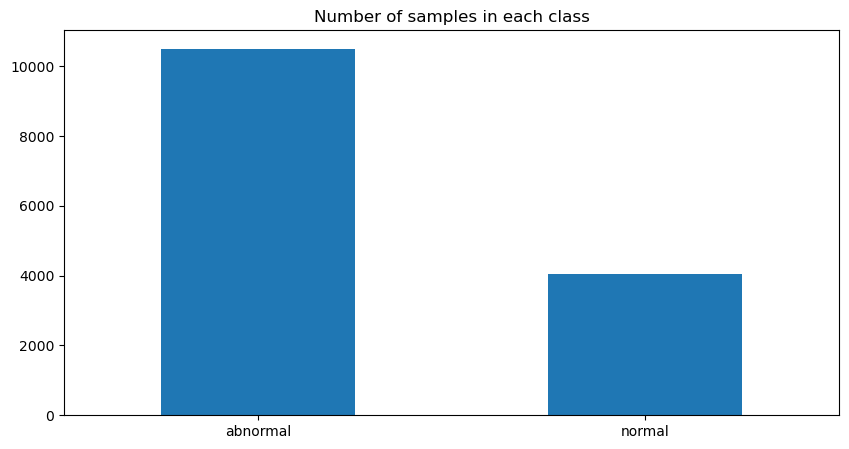

In [2]:
df_ptbd_normal = pd.read_csv("ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("ecg_dataset/ptbdb_abnormal.csv", header = None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1 
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

In [3]:
df_ptbd.head()

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X = df_ptbd.loc[:, df_ptbd.columns != "label"]
y = df_ptbd.loc[:, df_ptbd.columns == "label"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 

In [27]:
x_train = torch.tensor(X_train.values, dtype=torch.float32)
x_val   = torch.tensor(X_val.values, dtype=torch.float32)
x_test  = torch.tensor(X_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val   = torch.tensor(y_val.values, dtype=torch.float32)
y_test  = torch.tensor(y_test.values, dtype=torch.float32)

In [22]:
input_dim = len(df_ptbd.columns)-1
output_dim = 2

In [23]:
epochs = 50000
train_loss_tens = torch.empty(epochs)
train_loss_arr = np.zeros(epochs)

In [24]:
#CLASSIFICATION
##Logistic Regression Model

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
            
            
    def forward(self,x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    
model=LogisticRegression(input_dim, output_dim)
print(model)

IndentationError: unexpected indent (70971884.py, line 7)

In [9]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim = 0)
        return x


model1 = Net1()

In [10]:
criterion=torch.nn.BCELoss()
optimizer=torch.optim.SGD(model1.parameters(),lr=0.0001)

In [12]:
import copy 

min_val_loss = np.inf
for epoch in range(epochs):
    
    count_train_loss = 0.0
    
    
    pred_y = model1(x_train)

    # Compute and print loss
    train_loss = criterion(pred_y, y_train)
    
    count_train_loss+= train_loss.item()
    
    train_loss_tens[epoch] = train_loss
    
    

    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    #print(loss)
    print(f'Epoch {epoch +1} \t\t Training Loss: {train_loss / len(x_train)} \t')
    
train_loss_arr = train_loss_tens.detach().numpy()

Epoch 1 		 Training Loss: 0.0005809849826619029 	
Epoch 2 		 Training Loss: 0.0005809849826619029 	
Epoch 3 		 Training Loss: 0.0005809849826619029 	
Epoch 4 		 Training Loss: 0.0005809849826619029 	
Epoch 5 		 Training Loss: 0.0005809849826619029 	
Epoch 6 		 Training Loss: 0.0005809849826619029 	
Epoch 7 		 Training Loss: 0.0005809849826619029 	
Epoch 8 		 Training Loss: 0.0005809849826619029 	
Epoch 9 		 Training Loss: 0.0005809849826619029 	
Epoch 10 		 Training Loss: 0.0005809849826619029 	
Epoch 11 		 Training Loss: 0.0005809849826619029 	
Epoch 12 		 Training Loss: 0.0005809849826619029 	
Epoch 13 		 Training Loss: 0.0005809849826619029 	
Epoch 14 		 Training Loss: 0.0005809849826619029 	
Epoch 15 		 Training Loss: 0.0005809849826619029 	
Epoch 16 		 Training Loss: 0.0005809849826619029 	
Epoch 17 		 Training Loss: 0.0005809848662465811 	
Epoch 18 		 Training Loss: 0.0005809848662465811 	
Epoch 19 		 Training Loss: 0.0005809848662465811 	
Epoch 20 		 Training Loss: 0.00058098486

Epoch 161 		 Training Loss: 0.0005809839931316674 	
Epoch 162 		 Training Loss: 0.0005809839931316674 	
Epoch 163 		 Training Loss: 0.0005809840513393283 	
Epoch 164 		 Training Loss: 0.0005809839931316674 	
Epoch 165 		 Training Loss: 0.0005809839349240065 	
Epoch 166 		 Training Loss: 0.0005809839931316674 	
Epoch 167 		 Training Loss: 0.0005809839349240065 	
Epoch 168 		 Training Loss: 0.0005809839931316674 	
Epoch 169 		 Training Loss: 0.0005809839931316674 	
Epoch 170 		 Training Loss: 0.0005809839349240065 	
Epoch 171 		 Training Loss: 0.0005809839349240065 	
Epoch 172 		 Training Loss: 0.0005809839349240065 	
Epoch 173 		 Training Loss: 0.0005809839349240065 	
Epoch 174 		 Training Loss: 0.0005809839349240065 	
Epoch 175 		 Training Loss: 0.0005809839349240065 	
Epoch 176 		 Training Loss: 0.0005809839349240065 	
Epoch 177 		 Training Loss: 0.0005809839349240065 	
Epoch 178 		 Training Loss: 0.0005809839349240065 	
Epoch 179 		 Training Loss: 0.0005809839349240065 	
Epoch 180 		

Epoch 323 		 Training Loss: 0.0005809829453937709 	
Epoch 324 		 Training Loss: 0.0005809829453937709 	
Epoch 325 		 Training Loss: 0.00058098288718611 	
Epoch 326 		 Training Loss: 0.00058098288718611 	
Epoch 327 		 Training Loss: 0.00058098288718611 	
Epoch 328 		 Training Loss: 0.00058098288718611 	
Epoch 329 		 Training Loss: 0.00058098288718611 	
Epoch 330 		 Training Loss: 0.00058098288718611 	
Epoch 331 		 Training Loss: 0.00058098288718611 	
Epoch 332 		 Training Loss: 0.0005809829453937709 	
Epoch 333 		 Training Loss: 0.00058098288718611 	
Epoch 334 		 Training Loss: 0.0005809829453937709 	
Epoch 335 		 Training Loss: 0.0005809829453937709 	
Epoch 336 		 Training Loss: 0.00058098288718611 	
Epoch 337 		 Training Loss: 0.00058098288718611 	
Epoch 338 		 Training Loss: 0.0005809829453937709 	
Epoch 339 		 Training Loss: 0.00058098288718611 	
Epoch 340 		 Training Loss: 0.00058098288718611 	
Epoch 341 		 Training Loss: 0.0005809829453937709 	
Epoch 342 		 Training Loss: 0.000580

Epoch 483 		 Training Loss: 0.0005809820140711963 	
Epoch 484 		 Training Loss: 0.0005809820140711963 	
Epoch 485 		 Training Loss: 0.0005809820140711963 	
Epoch 486 		 Training Loss: 0.0005809820140711963 	
Epoch 487 		 Training Loss: 0.0005809821304865181 	
Epoch 488 		 Training Loss: 0.0005809820140711963 	
Epoch 489 		 Training Loss: 0.0005809820140711963 	
Epoch 490 		 Training Loss: 0.0005809820140711963 	
Epoch 491 		 Training Loss: 0.0005809820140711963 	
Epoch 492 		 Training Loss: 0.0005809820140711963 	
Epoch 493 		 Training Loss: 0.0005809820722788572 	
Epoch 494 		 Training Loss: 0.0005809820140711963 	
Epoch 495 		 Training Loss: 0.0005809820140711963 	
Epoch 496 		 Training Loss: 0.0005809820140711963 	
Epoch 497 		 Training Loss: 0.0005809820140711963 	
Epoch 498 		 Training Loss: 0.0005809820140711963 	
Epoch 499 		 Training Loss: 0.0005809820140711963 	
Epoch 500 		 Training Loss: 0.0005809820140711963 	
Epoch 501 		 Training Loss: 0.0005809820140711963 	
Epoch 502 		

Epoch 643 		 Training Loss: 0.0005809811409562826 	
Epoch 644 		 Training Loss: 0.0005809811409562826 	
Epoch 645 		 Training Loss: 0.0005809810827486217 	
Epoch 646 		 Training Loss: 0.0005809810827486217 	
Epoch 647 		 Training Loss: 0.0005809810827486217 	
Epoch 648 		 Training Loss: 0.0005809810827486217 	
Epoch 649 		 Training Loss: 0.0005809810827486217 	
Epoch 650 		 Training Loss: 0.0005809810827486217 	
Epoch 651 		 Training Loss: 0.0005809810827486217 	
Epoch 652 		 Training Loss: 0.0005809810827486217 	
Epoch 653 		 Training Loss: 0.0005809810827486217 	
Epoch 654 		 Training Loss: 0.0005809810827486217 	
Epoch 655 		 Training Loss: 0.0005809810827486217 	
Epoch 656 		 Training Loss: 0.0005809810827486217 	
Epoch 657 		 Training Loss: 0.0005809810827486217 	
Epoch 658 		 Training Loss: 0.0005809810245409608 	
Epoch 659 		 Training Loss: 0.0005809810827486217 	
Epoch 660 		 Training Loss: 0.0005809810245409608 	
Epoch 661 		 Training Loss: 0.0005809810245409608 	
Epoch 662 		

Epoch 807 		 Training Loss: 0.0005809800932183862 	
Epoch 808 		 Training Loss: 0.0005809800932183862 	
Epoch 809 		 Training Loss: 0.0005809800932183862 	
Epoch 810 		 Training Loss: 0.0005809800350107253 	
Epoch 811 		 Training Loss: 0.0005809800350107253 	
Epoch 812 		 Training Loss: 0.0005809800350107253 	
Epoch 813 		 Training Loss: 0.0005809800350107253 	
Epoch 814 		 Training Loss: 0.0005809800350107253 	
Epoch 815 		 Training Loss: 0.0005809800350107253 	
Epoch 816 		 Training Loss: 0.0005809800932183862 	
Epoch 817 		 Training Loss: 0.0005809800350107253 	
Epoch 818 		 Training Loss: 0.0005809800350107253 	
Epoch 819 		 Training Loss: 0.0005809800350107253 	
Epoch 820 		 Training Loss: 0.0005809800350107253 	
Epoch 821 		 Training Loss: 0.0005809800350107253 	
Epoch 822 		 Training Loss: 0.0005809800350107253 	
Epoch 823 		 Training Loss: 0.0005809800350107253 	
Epoch 824 		 Training Loss: 0.0005809800350107253 	
Epoch 825 		 Training Loss: 0.0005809800350107253 	
Epoch 826 		

Epoch 970 		 Training Loss: 0.0005809791036881506 	
Epoch 971 		 Training Loss: 0.0005809790454804897 	
Epoch 972 		 Training Loss: 0.0005809790454804897 	
Epoch 973 		 Training Loss: 0.0005809791036881506 	
Epoch 974 		 Training Loss: 0.0005809790454804897 	
Epoch 975 		 Training Loss: 0.0005809791036881506 	
Epoch 976 		 Training Loss: 0.0005809791036881506 	
Epoch 977 		 Training Loss: 0.0005809790454804897 	
Epoch 978 		 Training Loss: 0.0005809790454804897 	
Epoch 979 		 Training Loss: 0.0005809790454804897 	
Epoch 980 		 Training Loss: 0.0005809790454804897 	
Epoch 981 		 Training Loss: 0.0005809790454804897 	
Epoch 982 		 Training Loss: 0.0005809790454804897 	
Epoch 983 		 Training Loss: 0.0005809790454804897 	
Epoch 984 		 Training Loss: 0.0005809790454804897 	
Epoch 985 		 Training Loss: 0.0005809790454804897 	
Epoch 986 		 Training Loss: 0.0005809790454804897 	
Epoch 987 		 Training Loss: 0.0005809790454804897 	
Epoch 988 		 Training Loss: 0.0005809790454804897 	
Epoch 989 		

Epoch 1132 		 Training Loss: 0.0005809782305732369 	
Epoch 1133 		 Training Loss: 0.0005809782305732369 	
Epoch 1134 		 Training Loss: 0.0005809782305732369 	
Epoch 1135 		 Training Loss: 0.0005809782305732369 	
Epoch 1136 		 Training Loss: 0.0005809782305732369 	
Epoch 1137 		 Training Loss: 0.0005809782305732369 	
Epoch 1138 		 Training Loss: 0.0005809781141579151 	
Epoch 1139 		 Training Loss: 0.0005809782305732369 	
Epoch 1140 		 Training Loss: 0.0005809781141579151 	
Epoch 1141 		 Training Loss: 0.0005809781141579151 	
Epoch 1142 		 Training Loss: 0.0005809781141579151 	
Epoch 1143 		 Training Loss: 0.0005809781141579151 	
Epoch 1144 		 Training Loss: 0.0005809781141579151 	
Epoch 1145 		 Training Loss: 0.0005809781141579151 	
Epoch 1146 		 Training Loss: 0.0005809781141579151 	
Epoch 1147 		 Training Loss: 0.0005809781141579151 	
Epoch 1148 		 Training Loss: 0.0005809781141579151 	
Epoch 1149 		 Training Loss: 0.0005809781141579151 	
Epoch 1150 		 Training Loss: 0.000580978114157

Epoch 1302 		 Training Loss: 0.0005809769500046968 	
Epoch 1303 		 Training Loss: 0.0005809769500046968 	
Epoch 1304 		 Training Loss: 0.0005809769500046968 	
Epoch 1305 		 Training Loss: 0.0005809769500046968 	
Epoch 1306 		 Training Loss: 0.0005809769500046968 	
Epoch 1307 		 Training Loss: 0.0005809769500046968 	
Epoch 1308 		 Training Loss: 0.0005809769500046968 	
Epoch 1309 		 Training Loss: 0.0005809769500046968 	
Epoch 1310 		 Training Loss: 0.0005809769500046968 	
Epoch 1311 		 Training Loss: 0.0005809768917970359 	
Epoch 1312 		 Training Loss: 0.0005809768917970359 	
Epoch 1313 		 Training Loss: 0.0005809768917970359 	
Epoch 1314 		 Training Loss: 0.0005809769500046968 	
Epoch 1315 		 Training Loss: 0.0005809768917970359 	
Epoch 1316 		 Training Loss: 0.0005809768917970359 	
Epoch 1317 		 Training Loss: 0.0005809768917970359 	
Epoch 1318 		 Training Loss: 0.0005809768917970359 	
Epoch 1319 		 Training Loss: 0.0005809768917970359 	
Epoch 1320 		 Training Loss: 0.000580976891797

Epoch 1458 		 Training Loss: 0.0005809759022668004 	
Epoch 1459 		 Training Loss: 0.0005809759022668004 	
Epoch 1460 		 Training Loss: 0.0005809759022668004 	
Epoch 1461 		 Training Loss: 0.0005809759022668004 	
Epoch 1462 		 Training Loss: 0.0005809759022668004 	
Epoch 1463 		 Training Loss: 0.0005809759022668004 	
Epoch 1464 		 Training Loss: 0.0005809758440591395 	
Epoch 1465 		 Training Loss: 0.0005809758440591395 	
Epoch 1466 		 Training Loss: 0.0005809757858514786 	
Epoch 1467 		 Training Loss: 0.0005809757858514786 	
Epoch 1468 		 Training Loss: 0.0005809757858514786 	
Epoch 1469 		 Training Loss: 0.0005809759022668004 	
Epoch 1470 		 Training Loss: 0.0005809758440591395 	
Epoch 1471 		 Training Loss: 0.0005809758440591395 	
Epoch 1472 		 Training Loss: 0.0005809758440591395 	
Epoch 1473 		 Training Loss: 0.0005809758440591395 	
Epoch 1474 		 Training Loss: 0.0005809757858514786 	
Epoch 1475 		 Training Loss: 0.0005809757858514786 	
Epoch 1476 		 Training Loss: 0.000580975844059

Epoch 1613 		 Training Loss: 0.0005809752037748694 	
Epoch 1614 		 Training Loss: 0.0005809751455672085 	
Epoch 1615 		 Training Loss: 0.0005809752037748694 	
Epoch 1616 		 Training Loss: 0.0005809752037748694 	
Epoch 1617 		 Training Loss: 0.0005809751455672085 	
Epoch 1618 		 Training Loss: 0.0005809751455672085 	
Epoch 1619 		 Training Loss: 0.0005809751455672085 	
Epoch 1620 		 Training Loss: 0.0005809751455672085 	
Epoch 1621 		 Training Loss: 0.0005809752037748694 	
Epoch 1622 		 Training Loss: 0.0005809751455672085 	
Epoch 1623 		 Training Loss: 0.0005809751455672085 	
Epoch 1624 		 Training Loss: 0.0005809751455672085 	
Epoch 1625 		 Training Loss: 0.0005809751455672085 	
Epoch 1626 		 Training Loss: 0.0005809751455672085 	
Epoch 1627 		 Training Loss: 0.0005809751455672085 	
Epoch 1628 		 Training Loss: 0.0005809751455672085 	
Epoch 1629 		 Training Loss: 0.0005809751455672085 	
Epoch 1630 		 Training Loss: 0.0005809751455672085 	
Epoch 1631 		 Training Loss: 0.000580975145567

Epoch 1769 		 Training Loss: 0.0005809744470752776 	
Epoch 1770 		 Training Loss: 0.0005809744470752776 	
Epoch 1771 		 Training Loss: 0.0005809744470752776 	
Epoch 1772 		 Training Loss: 0.0005809744470752776 	
Epoch 1773 		 Training Loss: 0.0005809744470752776 	
Epoch 1774 		 Training Loss: 0.0005809744470752776 	
Epoch 1775 		 Training Loss: 0.0005809744470752776 	
Epoch 1776 		 Training Loss: 0.0005809744470752776 	
Epoch 1777 		 Training Loss: 0.0005809744470752776 	
Epoch 1778 		 Training Loss: 0.0005809744470752776 	
Epoch 1779 		 Training Loss: 0.0005809744470752776 	
Epoch 1780 		 Training Loss: 0.0005809744470752776 	
Epoch 1781 		 Training Loss: 0.0005809744470752776 	
Epoch 1782 		 Training Loss: 0.0005809744470752776 	
Epoch 1783 		 Training Loss: 0.0005809743888676167 	
Epoch 1784 		 Training Loss: 0.0005809744470752776 	
Epoch 1785 		 Training Loss: 0.0005809744470752776 	
Epoch 1786 		 Training Loss: 0.0005809743888676167 	
Epoch 1787 		 Training Loss: 0.000580974447075

Epoch 1925 		 Training Loss: 0.000580973515752703 	
Epoch 1926 		 Training Loss: 0.000580973515752703 	
Epoch 1927 		 Training Loss: 0.000580973515752703 	
Epoch 1928 		 Training Loss: 0.000580973515752703 	
Epoch 1929 		 Training Loss: 0.000580973515752703 	
Epoch 1930 		 Training Loss: 0.000580973515752703 	
Epoch 1931 		 Training Loss: 0.000580973515752703 	
Epoch 1932 		 Training Loss: 0.000580973515752703 	
Epoch 1933 		 Training Loss: 0.000580973515752703 	
Epoch 1934 		 Training Loss: 0.000580973515752703 	
Epoch 1935 		 Training Loss: 0.0005809733993373811 	
Epoch 1936 		 Training Loss: 0.0005809733993373811 	
Epoch 1937 		 Training Loss: 0.0005809733993373811 	
Epoch 1938 		 Training Loss: 0.0005809733993373811 	
Epoch 1939 		 Training Loss: 0.0005809733993373811 	
Epoch 1940 		 Training Loss: 0.0005809733993373811 	
Epoch 1941 		 Training Loss: 0.0005809733993373811 	
Epoch 1942 		 Training Loss: 0.0005809733993373811 	
Epoch 1943 		 Training Loss: 0.0005809733993373811 	
Epo

Epoch 2086 		 Training Loss: 0.0005809724098071456 	
Epoch 2087 		 Training Loss: 0.0005809724098071456 	
Epoch 2088 		 Training Loss: 0.0005809724098071456 	
Epoch 2089 		 Training Loss: 0.0005809724098071456 	
Epoch 2090 		 Training Loss: 0.0005809724098071456 	
Epoch 2091 		 Training Loss: 0.0005809724098071456 	
Epoch 2092 		 Training Loss: 0.0005809724098071456 	
Epoch 2093 		 Training Loss: 0.0005809724098071456 	
Epoch 2094 		 Training Loss: 0.0005809724098071456 	
Epoch 2095 		 Training Loss: 0.0005809724098071456 	
Epoch 2096 		 Training Loss: 0.0005809724098071456 	
Epoch 2097 		 Training Loss: 0.0005809724098071456 	
Epoch 2098 		 Training Loss: 0.0005809724098071456 	
Epoch 2099 		 Training Loss: 0.0005809724098071456 	
Epoch 2100 		 Training Loss: 0.0005809724098071456 	
Epoch 2101 		 Training Loss: 0.0005809724098071456 	
Epoch 2102 		 Training Loss: 0.0005809724098071456 	
Epoch 2103 		 Training Loss: 0.0005809724098071456 	
Epoch 2104 		 Training Loss: 0.000580972293391

Epoch 2252 		 Training Loss: 0.0005809714202769101 	
Epoch 2253 		 Training Loss: 0.0005809714202769101 	
Epoch 2254 		 Training Loss: 0.0005809714202769101 	
Epoch 2255 		 Training Loss: 0.0005809714202769101 	
Epoch 2256 		 Training Loss: 0.0005809714202769101 	
Epoch 2257 		 Training Loss: 0.0005809714202769101 	
Epoch 2258 		 Training Loss: 0.0005809714202769101 	
Epoch 2259 		 Training Loss: 0.0005809713038615882 	
Epoch 2260 		 Training Loss: 0.0005809713038615882 	
Epoch 2261 		 Training Loss: 0.0005809714202769101 	
Epoch 2262 		 Training Loss: 0.0005809714202769101 	
Epoch 2263 		 Training Loss: 0.0005809714202769101 	
Epoch 2264 		 Training Loss: 0.0005809713038615882 	
Epoch 2265 		 Training Loss: 0.0005809713038615882 	
Epoch 2266 		 Training Loss: 0.0005809713038615882 	
Epoch 2267 		 Training Loss: 0.0005809713038615882 	
Epoch 2268 		 Training Loss: 0.0005809713038615882 	
Epoch 2269 		 Training Loss: 0.0005809713038615882 	
Epoch 2270 		 Training Loss: 0.000580971303861

Epoch 2417 		 Training Loss: 0.0005809705471619964 	
Epoch 2418 		 Training Loss: 0.0005809704889543355 	
Epoch 2419 		 Training Loss: 0.0005809704889543355 	
Epoch 2420 		 Training Loss: 0.0005809704889543355 	
Epoch 2421 		 Training Loss: 0.0005809705471619964 	
Epoch 2422 		 Training Loss: 0.0005809704889543355 	
Epoch 2423 		 Training Loss: 0.0005809704889543355 	
Epoch 2424 		 Training Loss: 0.0005809704889543355 	
Epoch 2425 		 Training Loss: 0.0005809704889543355 	
Epoch 2426 		 Training Loss: 0.0005809704889543355 	
Epoch 2427 		 Training Loss: 0.0005809704889543355 	
Epoch 2428 		 Training Loss: 0.0005809704889543355 	
Epoch 2429 		 Training Loss: 0.0005809704889543355 	
Epoch 2430 		 Training Loss: 0.0005809703725390136 	
Epoch 2431 		 Training Loss: 0.0005809703725390136 	
Epoch 2432 		 Training Loss: 0.0005809704307466745 	
Epoch 2433 		 Training Loss: 0.0005809704307466745 	
Epoch 2434 		 Training Loss: 0.0005809703725390136 	
Epoch 2435 		 Training Loss: 0.000580970372539

Epoch 2583 		 Training Loss: 0.0005809695576317608 	
Epoch 2584 		 Training Loss: 0.0005809695576317608 	
Epoch 2585 		 Training Loss: 0.0005809695576317608 	
Epoch 2586 		 Training Loss: 0.0005809695576317608 	
Epoch 2587 		 Training Loss: 0.0005809695576317608 	
Epoch 2588 		 Training Loss: 0.0005809695576317608 	
Epoch 2589 		 Training Loss: 0.0005809695576317608 	
Epoch 2590 		 Training Loss: 0.0005809695576317608 	
Epoch 2591 		 Training Loss: 0.0005809695576317608 	
Epoch 2592 		 Training Loss: 0.0005809695576317608 	
Epoch 2593 		 Training Loss: 0.0005809695576317608 	
Epoch 2594 		 Training Loss: 0.0005809695576317608 	
Epoch 2595 		 Training Loss: 0.0005809695576317608 	
Epoch 2596 		 Training Loss: 0.0005809695576317608 	
Epoch 2597 		 Training Loss: 0.0005809695576317608 	
Epoch 2598 		 Training Loss: 0.0005809695576317608 	
Epoch 2599 		 Training Loss: 0.0005809694994240999 	
Epoch 2600 		 Training Loss: 0.0005809694994240999 	
Epoch 2601 		 Training Loss: 0.000580969499424

Epoch 2740 		 Training Loss: 0.0005809686845168471 	
Epoch 2741 		 Training Loss: 0.0005809686263091862 	
Epoch 2742 		 Training Loss: 0.0005809686263091862 	
Epoch 2743 		 Training Loss: 0.0005809686263091862 	
Epoch 2744 		 Training Loss: 0.0005809686263091862 	
Epoch 2745 		 Training Loss: 0.0005809685681015253 	
Epoch 2746 		 Training Loss: 0.0005809685681015253 	
Epoch 2747 		 Training Loss: 0.0005809685681015253 	
Epoch 2748 		 Training Loss: 0.0005809685681015253 	
Epoch 2749 		 Training Loss: 0.0005809685681015253 	
Epoch 2750 		 Training Loss: 0.0005809685681015253 	
Epoch 2751 		 Training Loss: 0.0005809685681015253 	
Epoch 2752 		 Training Loss: 0.0005809685681015253 	
Epoch 2753 		 Training Loss: 0.0005809685681015253 	
Epoch 2754 		 Training Loss: 0.0005809685681015253 	
Epoch 2755 		 Training Loss: 0.0005809685681015253 	
Epoch 2756 		 Training Loss: 0.0005809685681015253 	
Epoch 2757 		 Training Loss: 0.0005809684516862035 	
Epoch 2758 		 Training Loss: 0.000580968451686

Epoch 2896 		 Training Loss: 0.0005809676367789507 	
Epoch 2897 		 Training Loss: 0.0005809676367789507 	
Epoch 2898 		 Training Loss: 0.0005809676367789507 	
Epoch 2899 		 Training Loss: 0.0005809676367789507 	
Epoch 2900 		 Training Loss: 0.0005809676367789507 	
Epoch 2901 		 Training Loss: 0.0005809676367789507 	
Epoch 2902 		 Training Loss: 0.0005809676367789507 	
Epoch 2903 		 Training Loss: 0.0005809676367789507 	
Epoch 2904 		 Training Loss: 0.0005809676367789507 	
Epoch 2905 		 Training Loss: 0.0005809676367789507 	
Epoch 2906 		 Training Loss: 0.0005809676367789507 	
Epoch 2907 		 Training Loss: 0.0005809676367789507 	
Epoch 2908 		 Training Loss: 0.0005809676367789507 	
Epoch 2909 		 Training Loss: 0.0005809676367789507 	
Epoch 2910 		 Training Loss: 0.0005809676367789507 	
Epoch 2911 		 Training Loss: 0.0005809676367789507 	
Epoch 2912 		 Training Loss: 0.0005809676367789507 	
Epoch 2913 		 Training Loss: 0.0005809675785712898 	
Epoch 2914 		 Training Loss: 0.000580967578571

Epoch 3061 		 Training Loss: 0.000580966763664037 	
Epoch 3062 		 Training Loss: 0.000580966763664037 	
Epoch 3063 		 Training Loss: 0.000580966763664037 	
Epoch 3064 		 Training Loss: 0.000580966763664037 	
Epoch 3065 		 Training Loss: 0.000580966763664037 	
Epoch 3066 		 Training Loss: 0.000580966763664037 	
Epoch 3067 		 Training Loss: 0.000580966763664037 	
Epoch 3068 		 Training Loss: 0.000580966763664037 	
Epoch 3069 		 Training Loss: 0.000580966763664037 	
Epoch 3070 		 Training Loss: 0.000580966763664037 	
Epoch 3071 		 Training Loss: 0.000580966763664037 	
Epoch 3072 		 Training Loss: 0.000580966763664037 	
Epoch 3073 		 Training Loss: 0.000580966763664037 	
Epoch 3074 		 Training Loss: 0.000580966763664037 	
Epoch 3075 		 Training Loss: 0.000580966763664037 	
Epoch 3076 		 Training Loss: 0.000580966763664037 	
Epoch 3077 		 Training Loss: 0.000580966763664037 	
Epoch 3078 		 Training Loss: 0.000580966763664037 	
Epoch 3079 		 Training Loss: 0.000580966763664037 	
Epoch 3080 	

Epoch 3227 		 Training Loss: 0.0005809657741338015 	
Epoch 3228 		 Training Loss: 0.0005809657741338015 	
Epoch 3229 		 Training Loss: 0.0005809657741338015 	
Epoch 3230 		 Training Loss: 0.0005809657741338015 	
Epoch 3231 		 Training Loss: 0.0005809657741338015 	
Epoch 3232 		 Training Loss: 0.0005809657741338015 	
Epoch 3233 		 Training Loss: 0.0005809657741338015 	
Epoch 3234 		 Training Loss: 0.0005809657741338015 	
Epoch 3235 		 Training Loss: 0.0005809657741338015 	
Epoch 3236 		 Training Loss: 0.0005809657741338015 	
Epoch 3237 		 Training Loss: 0.0005809657741338015 	
Epoch 3238 		 Training Loss: 0.0005809657741338015 	
Epoch 3239 		 Training Loss: 0.0005809657741338015 	
Epoch 3240 		 Training Loss: 0.0005809657741338015 	
Epoch 3241 		 Training Loss: 0.0005809657741338015 	
Epoch 3242 		 Training Loss: 0.0005809657741338015 	
Epoch 3243 		 Training Loss: 0.0005809657741338015 	
Epoch 3244 		 Training Loss: 0.0005809657741338015 	
Epoch 3245 		 Training Loss: 0.000580965774133

Epoch 3382 		 Training Loss: 0.0005809647846035659 	
Epoch 3383 		 Training Loss: 0.000580964726395905 	
Epoch 3384 		 Training Loss: 0.000580964726395905 	
Epoch 3385 		 Training Loss: 0.000580964726395905 	
Epoch 3386 		 Training Loss: 0.000580964726395905 	
Epoch 3387 		 Training Loss: 0.000580964726395905 	
Epoch 3388 		 Training Loss: 0.000580964726395905 	
Epoch 3389 		 Training Loss: 0.0005809646681882441 	
Epoch 3390 		 Training Loss: 0.0005809646681882441 	
Epoch 3391 		 Training Loss: 0.0005809646099805832 	
Epoch 3392 		 Training Loss: 0.0005809646099805832 	
Epoch 3393 		 Training Loss: 0.0005809646099805832 	
Epoch 3394 		 Training Loss: 0.0005809646099805832 	
Epoch 3395 		 Training Loss: 0.0005809646099805832 	
Epoch 3396 		 Training Loss: 0.0005809646099805832 	
Epoch 3397 		 Training Loss: 0.0005809646099805832 	
Epoch 3398 		 Training Loss: 0.0005809646099805832 	
Epoch 3399 		 Training Loss: 0.0005809646099805832 	
Epoch 3400 		 Training Loss: 0.0005809646099805832 	

Epoch 3549 		 Training Loss: 0.0005809639114886522 	
Epoch 3550 		 Training Loss: 0.0005809639114886522 	
Epoch 3551 		 Training Loss: 0.0005809639114886522 	
Epoch 3552 		 Training Loss: 0.0005809639114886522 	
Epoch 3553 		 Training Loss: 0.0005809639114886522 	
Epoch 3554 		 Training Loss: 0.0005809639114886522 	
Epoch 3555 		 Training Loss: 0.0005809639114886522 	
Epoch 3556 		 Training Loss: 0.0005809639114886522 	
Epoch 3557 		 Training Loss: 0.0005809639114886522 	
Epoch 3558 		 Training Loss: 0.0005809637950733304 	
Epoch 3559 		 Training Loss: 0.0005809637950733304 	
Epoch 3560 		 Training Loss: 0.0005809637950733304 	
Epoch 3561 		 Training Loss: 0.0005809637950733304 	
Epoch 3562 		 Training Loss: 0.0005809637950733304 	
Epoch 3563 		 Training Loss: 0.0005809637950733304 	
Epoch 3564 		 Training Loss: 0.0005809637950733304 	
Epoch 3565 		 Training Loss: 0.0005809637950733304 	
Epoch 3566 		 Training Loss: 0.0005809637950733304 	
Epoch 3567 		 Training Loss: 0.000580963736865

Epoch 3704 		 Training Loss: 0.0005809632129967213 	
Epoch 3705 		 Training Loss: 0.0005809632129967213 	
Epoch 3706 		 Training Loss: 0.0005809632129967213 	
Epoch 3707 		 Training Loss: 0.0005809631547890604 	
Epoch 3708 		 Training Loss: 0.0005809632129967213 	
Epoch 3709 		 Training Loss: 0.0005809632129967213 	
Epoch 3710 		 Training Loss: 0.0005809632129967213 	
Epoch 3711 		 Training Loss: 0.0005809632129967213 	
Epoch 3712 		 Training Loss: 0.0005809632129967213 	
Epoch 3713 		 Training Loss: 0.0005809632129967213 	
Epoch 3714 		 Training Loss: 0.0005809632129967213 	
Epoch 3715 		 Training Loss: 0.0005809632129967213 	
Epoch 3716 		 Training Loss: 0.0005809632129967213 	
Epoch 3717 		 Training Loss: 0.0005809632129967213 	
Epoch 3718 		 Training Loss: 0.0005809631547890604 	
Epoch 3719 		 Training Loss: 0.0005809631547890604 	
Epoch 3720 		 Training Loss: 0.0005809630965813994 	
Epoch 3721 		 Training Loss: 0.0005809630965813994 	
Epoch 3722 		 Training Loss: 0.000580963096581

Epoch 3867 		 Training Loss: 0.0005809621070511639 	
Epoch 3868 		 Training Loss: 0.0005809622234664857 	
Epoch 3869 		 Training Loss: 0.0005809622234664857 	
Epoch 3870 		 Training Loss: 0.0005809621070511639 	
Epoch 3871 		 Training Loss: 0.0005809622234664857 	
Epoch 3872 		 Training Loss: 0.0005809621070511639 	
Epoch 3873 		 Training Loss: 0.0005809621070511639 	
Epoch 3874 		 Training Loss: 0.0005809621070511639 	
Epoch 3875 		 Training Loss: 0.0005809621070511639 	
Epoch 3876 		 Training Loss: 0.000580962048843503 	
Epoch 3877 		 Training Loss: 0.000580962048843503 	
Epoch 3878 		 Training Loss: 0.000580962048843503 	
Epoch 3879 		 Training Loss: 0.000580962048843503 	
Epoch 3880 		 Training Loss: 0.000580962048843503 	
Epoch 3881 		 Training Loss: 0.000580962048843503 	
Epoch 3882 		 Training Loss: 0.000580962048843503 	
Epoch 3883 		 Training Loss: 0.000580962048843503 	
Epoch 3884 		 Training Loss: 0.000580962048843503 	
Epoch 3885 		 Training Loss: 0.000580962048843503 	
Epo

Epoch 4035 		 Training Loss: 0.0005809611175209284 	
Epoch 4036 		 Training Loss: 0.0005809611175209284 	
Epoch 4037 		 Training Loss: 0.0005809611175209284 	
Epoch 4038 		 Training Loss: 0.0005809611175209284 	
Epoch 4039 		 Training Loss: 0.0005809611175209284 	
Epoch 4040 		 Training Loss: 0.0005809611175209284 	
Epoch 4041 		 Training Loss: 0.0005809611175209284 	
Epoch 4042 		 Training Loss: 0.0005809611175209284 	
Epoch 4043 		 Training Loss: 0.0005809611175209284 	
Epoch 4044 		 Training Loss: 0.0005809611175209284 	
Epoch 4045 		 Training Loss: 0.0005809611175209284 	
Epoch 4046 		 Training Loss: 0.0005809611175209284 	
Epoch 4047 		 Training Loss: 0.0005809610593132675 	
Epoch 4048 		 Training Loss: 0.0005809611175209284 	
Epoch 4049 		 Training Loss: 0.0005809611175209284 	
Epoch 4050 		 Training Loss: 0.0005809610593132675 	
Epoch 4051 		 Training Loss: 0.0005809610593132675 	
Epoch 4052 		 Training Loss: 0.0005809610593132675 	
Epoch 4053 		 Training Loss: 0.000580961059313

Epoch 4203 		 Training Loss: 0.0005809601279906929 	
Epoch 4204 		 Training Loss: 0.0005809601279906929 	
Epoch 4205 		 Training Loss: 0.0005809601279906929 	
Epoch 4206 		 Training Loss: 0.0005809601279906929 	
Epoch 4207 		 Training Loss: 0.0005809601279906929 	
Epoch 4208 		 Training Loss: 0.0005809600697830319 	
Epoch 4209 		 Training Loss: 0.0005809600697830319 	
Epoch 4210 		 Training Loss: 0.0005809600697830319 	
Epoch 4211 		 Training Loss: 0.000580960011575371 	
Epoch 4212 		 Training Loss: 0.000580960011575371 	
Epoch 4213 		 Training Loss: 0.000580960011575371 	
Epoch 4214 		 Training Loss: 0.000580960011575371 	
Epoch 4215 		 Training Loss: 0.000580960011575371 	
Epoch 4216 		 Training Loss: 0.000580960011575371 	
Epoch 4217 		 Training Loss: 0.000580960011575371 	
Epoch 4218 		 Training Loss: 0.000580960011575371 	
Epoch 4219 		 Training Loss: 0.0005809599533677101 	
Epoch 4220 		 Training Loss: 0.0005809599533677101 	
Epoch 4221 		 Training Loss: 0.0005809599533677101 	
E

Epoch 4366 		 Training Loss: 0.0005809592548757792 	
Epoch 4367 		 Training Loss: 0.0005809592548757792 	
Epoch 4368 		 Training Loss: 0.0005809592548757792 	
Epoch 4369 		 Training Loss: 0.0005809592548757792 	
Epoch 4370 		 Training Loss: 0.0005809592548757792 	
Epoch 4371 		 Training Loss: 0.0005809592548757792 	
Epoch 4372 		 Training Loss: 0.0005809592548757792 	
Epoch 4373 		 Training Loss: 0.0005809591966681182 	
Epoch 4374 		 Training Loss: 0.0005809591966681182 	
Epoch 4375 		 Training Loss: 0.0005809591966681182 	
Epoch 4376 		 Training Loss: 0.0005809591966681182 	
Epoch 4377 		 Training Loss: 0.0005809591966681182 	
Epoch 4378 		 Training Loss: 0.0005809591966681182 	
Epoch 4379 		 Training Loss: 0.0005809591966681182 	
Epoch 4380 		 Training Loss: 0.0005809591384604573 	
Epoch 4381 		 Training Loss: 0.0005809590802527964 	
Epoch 4382 		 Training Loss: 0.0005809590802527964 	
Epoch 4383 		 Training Loss: 0.0005809590802527964 	
Epoch 4384 		 Training Loss: 0.000580959080252

Epoch 4531 		 Training Loss: 0.0005809584981761873 	
Epoch 4532 		 Training Loss: 0.0005809584981761873 	
Epoch 4533 		 Training Loss: 0.0005809583817608654 	
Epoch 4534 		 Training Loss: 0.0005809583817608654 	
Epoch 4535 		 Training Loss: 0.0005809583817608654 	
Epoch 4536 		 Training Loss: 0.0005809583817608654 	
Epoch 4537 		 Training Loss: 0.0005809583235532045 	
Epoch 4538 		 Training Loss: 0.0005809583235532045 	
Epoch 4539 		 Training Loss: 0.0005809582653455436 	
Epoch 4540 		 Training Loss: 0.0005809582653455436 	
Epoch 4541 		 Training Loss: 0.0005809582653455436 	
Epoch 4542 		 Training Loss: 0.0005809582653455436 	
Epoch 4543 		 Training Loss: 0.0005809582653455436 	
Epoch 4544 		 Training Loss: 0.0005809582653455436 	
Epoch 4545 		 Training Loss: 0.0005809582653455436 	
Epoch 4546 		 Training Loss: 0.0005809582653455436 	
Epoch 4547 		 Training Loss: 0.0005809582653455436 	
Epoch 4548 		 Training Loss: 0.0005809582653455436 	
Epoch 4549 		 Training Loss: 0.000580958265345

Epoch 4698 		 Training Loss: 0.0005809574504382908 	
Epoch 4699 		 Training Loss: 0.0005809574504382908 	
Epoch 4700 		 Training Loss: 0.0005809574504382908 	
Epoch 4701 		 Training Loss: 0.0005809574504382908 	
Epoch 4702 		 Training Loss: 0.0005809574504382908 	
Epoch 4703 		 Training Loss: 0.0005809574504382908 	
Epoch 4704 		 Training Loss: 0.0005809574504382908 	
Epoch 4705 		 Training Loss: 0.0005809574504382908 	
Epoch 4706 		 Training Loss: 0.0005809574504382908 	
Epoch 4707 		 Training Loss: 0.000580957334022969 	
Epoch 4708 		 Training Loss: 0.0005809574504382908 	
Epoch 4709 		 Training Loss: 0.0005809574504382908 	
Epoch 4710 		 Training Loss: 0.0005809574504382908 	
Epoch 4711 		 Training Loss: 0.0005809574504382908 	
Epoch 4712 		 Training Loss: 0.0005809573922306299 	
Epoch 4713 		 Training Loss: 0.0005809574504382908 	
Epoch 4714 		 Training Loss: 0.0005809574504382908 	
Epoch 4715 		 Training Loss: 0.0005809574504382908 	
Epoch 4716 		 Training Loss: 0.0005809574504382

Epoch 4866 		 Training Loss: 0.0005809565773233771 	
Epoch 4867 		 Training Loss: 0.000580956693738699 	
Epoch 4868 		 Training Loss: 0.000580956693738699 	
Epoch 4869 		 Training Loss: 0.000580956693738699 	
Epoch 4870 		 Training Loss: 0.000580956693738699 	
Epoch 4871 		 Training Loss: 0.0005809565773233771 	
Epoch 4872 		 Training Loss: 0.0005809565773233771 	
Epoch 4873 		 Training Loss: 0.0005809565773233771 	
Epoch 4874 		 Training Loss: 0.0005809565773233771 	
Epoch 4875 		 Training Loss: 0.0005809565773233771 	
Epoch 4876 		 Training Loss: 0.0005809565773233771 	
Epoch 4877 		 Training Loss: 0.0005809565773233771 	
Epoch 4878 		 Training Loss: 0.0005809565773233771 	
Epoch 4879 		 Training Loss: 0.0005809565773233771 	
Epoch 4880 		 Training Loss: 0.0005809565773233771 	
Epoch 4881 		 Training Loss: 0.0005809565773233771 	
Epoch 4882 		 Training Loss: 0.0005809565773233771 	
Epoch 4883 		 Training Loss: 0.0005809565191157162 	
Epoch 4884 		 Training Loss: 0.0005809565191157162

Epoch 5031 		 Training Loss: 0.0005809558206237853 	
Epoch 5032 		 Training Loss: 0.0005809557624161243 	
Epoch 5033 		 Training Loss: 0.0005809558206237853 	
Epoch 5034 		 Training Loss: 0.0005809558206237853 	
Epoch 5035 		 Training Loss: 0.0005809558206237853 	
Epoch 5036 		 Training Loss: 0.0005809558206237853 	
Epoch 5037 		 Training Loss: 0.0005809558206237853 	
Epoch 5038 		 Training Loss: 0.0005809558206237853 	
Epoch 5039 		 Training Loss: 0.0005809557042084634 	
Epoch 5040 		 Training Loss: 0.0005809557042084634 	
Epoch 5041 		 Training Loss: 0.0005809557042084634 	
Epoch 5042 		 Training Loss: 0.0005809557042084634 	
Epoch 5043 		 Training Loss: 0.0005809557042084634 	
Epoch 5044 		 Training Loss: 0.0005809557042084634 	
Epoch 5045 		 Training Loss: 0.0005809557042084634 	
Epoch 5046 		 Training Loss: 0.0005809557042084634 	
Epoch 5047 		 Training Loss: 0.0005809557042084634 	
Epoch 5048 		 Training Loss: 0.0005809557042084634 	
Epoch 5049 		 Training Loss: 0.000580955704208

Epoch 5197 		 Training Loss: 0.0005809547146782279 	
Epoch 5198 		 Training Loss: 0.0005809547146782279 	
Epoch 5199 		 Training Loss: 0.0005809547146782279 	
Epoch 5200 		 Training Loss: 0.0005809547146782279 	
Epoch 5201 		 Training Loss: 0.0005809545982629061 	
Epoch 5202 		 Training Loss: 0.0005809545982629061 	
Epoch 5203 		 Training Loss: 0.0005809545982629061 	
Epoch 5204 		 Training Loss: 0.0005809545982629061 	
Epoch 5205 		 Training Loss: 0.0005809545982629061 	
Epoch 5206 		 Training Loss: 0.0005809545982629061 	
Epoch 5207 		 Training Loss: 0.0005809545982629061 	
Epoch 5208 		 Training Loss: 0.0005809545982629061 	
Epoch 5209 		 Training Loss: 0.0005809545982629061 	
Epoch 5210 		 Training Loss: 0.0005809545982629061 	
Epoch 5211 		 Training Loss: 0.0005809545982629061 	
Epoch 5212 		 Training Loss: 0.0005809545982629061 	
Epoch 5213 		 Training Loss: 0.0005809545982629061 	
Epoch 5214 		 Training Loss: 0.0005809545982629061 	
Epoch 5215 		 Training Loss: 0.000580954598262

Epoch 5364 		 Training Loss: 0.0005809535505250096 	
Epoch 5365 		 Training Loss: 0.0005809535505250096 	
Epoch 5366 		 Training Loss: 0.0005809535505250096 	
Epoch 5367 		 Training Loss: 0.0005809535505250096 	
Epoch 5368 		 Training Loss: 0.0005809534923173487 	
Epoch 5369 		 Training Loss: 0.0005809534923173487 	
Epoch 5370 		 Training Loss: 0.0005809534923173487 	
Epoch 5371 		 Training Loss: 0.0005809534923173487 	
Epoch 5372 		 Training Loss: 0.0005809534923173487 	
Epoch 5373 		 Training Loss: 0.0005809534923173487 	
Epoch 5374 		 Training Loss: 0.0005809534923173487 	
Epoch 5375 		 Training Loss: 0.0005809534923173487 	
Epoch 5376 		 Training Loss: 0.0005809534923173487 	
Epoch 5377 		 Training Loss: 0.0005809534923173487 	
Epoch 5378 		 Training Loss: 0.0005809534923173487 	
Epoch 5379 		 Training Loss: 0.0005809534923173487 	
Epoch 5380 		 Training Loss: 0.0005809534923173487 	
Epoch 5381 		 Training Loss: 0.0005809534923173487 	
Epoch 5382 		 Training Loss: 0.000580953434109

Epoch 5532 		 Training Loss: 0.0005809526774100959 	
Epoch 5533 		 Training Loss: 0.000580952619202435 	
Epoch 5534 		 Training Loss: 0.0005809526774100959 	
Epoch 5535 		 Training Loss: 0.000580952619202435 	
Epoch 5536 		 Training Loss: 0.000580952619202435 	
Epoch 5537 		 Training Loss: 0.000580952619202435 	
Epoch 5538 		 Training Loss: 0.000580952619202435 	
Epoch 5539 		 Training Loss: 0.000580952619202435 	
Epoch 5540 		 Training Loss: 0.000580952619202435 	
Epoch 5541 		 Training Loss: 0.000580952619202435 	
Epoch 5542 		 Training Loss: 0.000580952619202435 	
Epoch 5543 		 Training Loss: 0.000580952619202435 	
Epoch 5544 		 Training Loss: 0.000580952619202435 	
Epoch 5545 		 Training Loss: 0.000580952619202435 	
Epoch 5546 		 Training Loss: 0.000580952619202435 	
Epoch 5547 		 Training Loss: 0.000580952619202435 	
Epoch 5548 		 Training Loss: 0.000580952619202435 	
Epoch 5549 		 Training Loss: 0.000580952619202435 	
Epoch 5550 		 Training Loss: 0.000580952619202435 	
Epoch 5551

Epoch 5693 		 Training Loss: 0.0005809518042951822 	
Epoch 5694 		 Training Loss: 0.0005809518042951822 	
Epoch 5695 		 Training Loss: 0.0005809518042951822 	
Epoch 5696 		 Training Loss: 0.0005809518042951822 	
Epoch 5697 		 Training Loss: 0.0005809518042951822 	
Epoch 5698 		 Training Loss: 0.0005809518042951822 	
Epoch 5699 		 Training Loss: 0.0005809518042951822 	
Epoch 5700 		 Training Loss: 0.0005809518042951822 	
Epoch 5701 		 Training Loss: 0.0005809518042951822 	
Epoch 5702 		 Training Loss: 0.0005809518042951822 	
Epoch 5703 		 Training Loss: 0.0005809518042951822 	
Epoch 5704 		 Training Loss: 0.0005809518042951822 	
Epoch 5705 		 Training Loss: 0.0005809518042951822 	
Epoch 5706 		 Training Loss: 0.0005809517460875213 	
Epoch 5707 		 Training Loss: 0.0005809516878798604 	
Epoch 5708 		 Training Loss: 0.0005809518042951822 	
Epoch 5709 		 Training Loss: 0.0005809518042951822 	
Epoch 5710 		 Training Loss: 0.0005809518042951822 	
Epoch 5711 		 Training Loss: 0.000580951804295

Epoch 5851 		 Training Loss: 0.0005809508147649467 	
Epoch 5852 		 Training Loss: 0.0005809507565572858 	
Epoch 5853 		 Training Loss: 0.0005809507565572858 	
Epoch 5854 		 Training Loss: 0.0005809507565572858 	
Epoch 5855 		 Training Loss: 0.0005809507565572858 	
Epoch 5856 		 Training Loss: 0.0005809508147649467 	
Epoch 5857 		 Training Loss: 0.0005809508147649467 	
Epoch 5858 		 Training Loss: 0.0005809507565572858 	
Epoch 5859 		 Training Loss: 0.0005809508147649467 	
Epoch 5860 		 Training Loss: 0.0005809507565572858 	
Epoch 5861 		 Training Loss: 0.0005809507565572858 	
Epoch 5862 		 Training Loss: 0.0005809507565572858 	
Epoch 5863 		 Training Loss: 0.0005809507565572858 	
Epoch 5864 		 Training Loss: 0.0005809507565572858 	
Epoch 5865 		 Training Loss: 0.0005809507565572858 	
Epoch 5866 		 Training Loss: 0.0005809507565572858 	
Epoch 5867 		 Training Loss: 0.0005809507565572858 	
Epoch 5868 		 Training Loss: 0.0005809507565572858 	
Epoch 5869 		 Training Loss: 0.000580950756557

Epoch 6016 		 Training Loss: 0.0005809500580653548 	
Epoch 6017 		 Training Loss: 0.0005809500580653548 	
Epoch 6018 		 Training Loss: 0.0005809501744806767 	
Epoch 6019 		 Training Loss: 0.0005809501744806767 	
Epoch 6020 		 Training Loss: 0.0005809501744806767 	
Epoch 6021 		 Training Loss: 0.0005809501744806767 	
Epoch 6022 		 Training Loss: 0.0005809501744806767 	
Epoch 6023 		 Training Loss: 0.0005809501744806767 	
Epoch 6024 		 Training Loss: 0.0005809501744806767 	
Epoch 6025 		 Training Loss: 0.0005809501744806767 	
Epoch 6026 		 Training Loss: 0.0005809501744806767 	
Epoch 6027 		 Training Loss: 0.0005809500580653548 	
Epoch 6028 		 Training Loss: 0.0005809500580653548 	
Epoch 6029 		 Training Loss: 0.0005809500580653548 	
Epoch 6030 		 Training Loss: 0.0005809500580653548 	
Epoch 6031 		 Training Loss: 0.0005809500580653548 	
Epoch 6032 		 Training Loss: 0.0005809500580653548 	
Epoch 6033 		 Training Loss: 0.0005809500580653548 	
Epoch 6034 		 Training Loss: 0.000580950058065

Epoch 6184 		 Training Loss: 0.000580949243158102 	
Epoch 6185 		 Training Loss: 0.0005809491849504411 	
Epoch 6186 		 Training Loss: 0.0005809491849504411 	
Epoch 6187 		 Training Loss: 0.0005809491849504411 	
Epoch 6188 		 Training Loss: 0.0005809491849504411 	
Epoch 6189 		 Training Loss: 0.000580949243158102 	
Epoch 6190 		 Training Loss: 0.0005809491849504411 	
Epoch 6191 		 Training Loss: 0.0005809491849504411 	
Epoch 6192 		 Training Loss: 0.0005809491849504411 	
Epoch 6193 		 Training Loss: 0.0005809491849504411 	
Epoch 6194 		 Training Loss: 0.0005809491849504411 	
Epoch 6195 		 Training Loss: 0.0005809491849504411 	
Epoch 6196 		 Training Loss: 0.0005809491849504411 	
Epoch 6197 		 Training Loss: 0.0005809491849504411 	
Epoch 6198 		 Training Loss: 0.0005809491849504411 	
Epoch 6199 		 Training Loss: 0.0005809491849504411 	
Epoch 6200 		 Training Loss: 0.0005809490685351193 	
Epoch 6201 		 Training Loss: 0.0005809491849504411 	
Epoch 6202 		 Training Loss: 0.00058094906853511

Epoch 6347 		 Training Loss: 0.0005809483700431883 	
Epoch 6348 		 Training Loss: 0.0005809483700431883 	
Epoch 6349 		 Training Loss: 0.0005809483700431883 	
Epoch 6350 		 Training Loss: 0.0005809483700431883 	
Epoch 6351 		 Training Loss: 0.0005809483700431883 	
Epoch 6352 		 Training Loss: 0.0005809483700431883 	
Epoch 6353 		 Training Loss: 0.0005809482536278665 	
Epoch 6354 		 Training Loss: 0.0005809482536278665 	
Epoch 6355 		 Training Loss: 0.0005809482536278665 	
Epoch 6356 		 Training Loss: 0.0005809482536278665 	
Epoch 6357 		 Training Loss: 0.0005809482536278665 	
Epoch 6358 		 Training Loss: 0.0005809482536278665 	
Epoch 6359 		 Training Loss: 0.0005809482536278665 	
Epoch 6360 		 Training Loss: 0.0005809482536278665 	
Epoch 6361 		 Training Loss: 0.0005809482536278665 	
Epoch 6362 		 Training Loss: 0.0005809482536278665 	
Epoch 6363 		 Training Loss: 0.0005809481954202056 	
Epoch 6364 		 Training Loss: 0.0005809480790048838 	
Epoch 6365 		 Training Loss: 0.000580948079004

Epoch 6515 		 Training Loss: 0.0005809474387206137 	
Epoch 6516 		 Training Loss: 0.0005809474387206137 	
Epoch 6517 		 Training Loss: 0.0005809474387206137 	
Epoch 6518 		 Training Loss: 0.0005809474387206137 	
Epoch 6519 		 Training Loss: 0.0005809474387206137 	
Epoch 6520 		 Training Loss: 0.0005809474387206137 	
Epoch 6521 		 Training Loss: 0.0005809474387206137 	
Epoch 6522 		 Training Loss: 0.0005809474387206137 	
Epoch 6523 		 Training Loss: 0.0005809474387206137 	
Epoch 6524 		 Training Loss: 0.0005809474387206137 	
Epoch 6525 		 Training Loss: 0.0005809473805129528 	
Epoch 6526 		 Training Loss: 0.0005809473223052919 	
Epoch 6527 		 Training Loss: 0.0005809473805129528 	
Epoch 6528 		 Training Loss: 0.0005809474387206137 	
Epoch 6529 		 Training Loss: 0.0005809473223052919 	
Epoch 6530 		 Training Loss: 0.0005809473223052919 	
Epoch 6531 		 Training Loss: 0.0005809473805129528 	
Epoch 6532 		 Training Loss: 0.0005809473805129528 	
Epoch 6533 		 Training Loss: 0.000580947380512

Epoch 6680 		 Training Loss: 0.0005809466238133609 	
Epoch 6681 		 Training Loss: 0.0005809466238133609 	
Epoch 6682 		 Training Loss: 0.0005809466238133609 	
Epoch 6683 		 Training Loss: 0.0005809466238133609 	
Epoch 6684 		 Training Loss: 0.0005809466238133609 	
Epoch 6685 		 Training Loss: 0.0005809466238133609 	
Epoch 6686 		 Training Loss: 0.0005809466238133609 	
Epoch 6687 		 Training Loss: 0.0005809466238133609 	
Epoch 6688 		 Training Loss: 0.0005809466238133609 	
Epoch 6689 		 Training Loss: 0.0005809466238133609 	
Epoch 6690 		 Training Loss: 0.0005809466238133609 	
Epoch 6691 		 Training Loss: 0.0005809466238133609 	
Epoch 6692 		 Training Loss: 0.0005809466820210218 	
Epoch 6693 		 Training Loss: 0.0005809466238133609 	
Epoch 6694 		 Training Loss: 0.0005809466820210218 	
Epoch 6695 		 Training Loss: 0.0005809466820210218 	
Epoch 6696 		 Training Loss: 0.0005809466820210218 	
Epoch 6697 		 Training Loss: 0.0005809466238133609 	
Epoch 6698 		 Training Loss: 0.000580946682021

Epoch 6836 		 Training Loss: 0.0005809456342831254 	
Epoch 6837 		 Training Loss: 0.0005809456924907863 	
Epoch 6838 		 Training Loss: 0.0005809456342831254 	
Epoch 6839 		 Training Loss: 0.0005809456342831254 	
Epoch 6840 		 Training Loss: 0.0005809456342831254 	
Epoch 6841 		 Training Loss: 0.0005809455760754645 	
Epoch 6842 		 Training Loss: 0.0005809455760754645 	
Epoch 6843 		 Training Loss: 0.0005809455760754645 	
Epoch 6844 		 Training Loss: 0.0005809455760754645 	
Epoch 6845 		 Training Loss: 0.0005809455760754645 	
Epoch 6846 		 Training Loss: 0.0005809455760754645 	
Epoch 6847 		 Training Loss: 0.0005809455760754645 	
Epoch 6848 		 Training Loss: 0.0005809455760754645 	
Epoch 6849 		 Training Loss: 0.0005809455760754645 	
Epoch 6850 		 Training Loss: 0.0005809455760754645 	
Epoch 6851 		 Training Loss: 0.0005809455760754645 	
Epoch 6852 		 Training Loss: 0.0005809455760754645 	
Epoch 6853 		 Training Loss: 0.0005809455760754645 	
Epoch 6854 		 Training Loss: 0.000580945576075

Epoch 6992 		 Training Loss: 0.0005809447029605508 	
Epoch 6993 		 Training Loss: 0.0005809447029605508 	
Epoch 6994 		 Training Loss: 0.0005809447029605508 	
Epoch 6995 		 Training Loss: 0.0005809447029605508 	
Epoch 6996 		 Training Loss: 0.0005809447029605508 	
Epoch 6997 		 Training Loss: 0.0005809447029605508 	
Epoch 6998 		 Training Loss: 0.0005809447029605508 	
Epoch 6999 		 Training Loss: 0.0005809447029605508 	
Epoch 7000 		 Training Loss: 0.0005809447029605508 	
Epoch 7001 		 Training Loss: 0.0005809447029605508 	
Epoch 7002 		 Training Loss: 0.0005809446447528899 	
Epoch 7003 		 Training Loss: 0.0005809447029605508 	
Epoch 7004 		 Training Loss: 0.0005809447029605508 	
Epoch 7005 		 Training Loss: 0.0005809446447528899 	
Epoch 7006 		 Training Loss: 0.0005809446447528899 	
Epoch 7007 		 Training Loss: 0.0005809446447528899 	
Epoch 7008 		 Training Loss: 0.0005809446447528899 	
Epoch 7009 		 Training Loss: 0.000580944586545229 	
Epoch 7010 		 Training Loss: 0.0005809445865452

Epoch 7149 		 Training Loss: 0.0005809439462609589 	
Epoch 7150 		 Training Loss: 0.0005809439462609589 	
Epoch 7151 		 Training Loss: 0.0005809439462609589 	
Epoch 7152 		 Training Loss: 0.0005809439462609589 	
Epoch 7153 		 Training Loss: 0.0005809439462609589 	
Epoch 7154 		 Training Loss: 0.0005809438298456371 	
Epoch 7155 		 Training Loss: 0.0005809438298456371 	
Epoch 7156 		 Training Loss: 0.0005809438298456371 	
Epoch 7157 		 Training Loss: 0.0005809438298456371 	
Epoch 7158 		 Training Loss: 0.0005809438298456371 	
Epoch 7159 		 Training Loss: 0.0005809438298456371 	
Epoch 7160 		 Training Loss: 0.0005809438298456371 	
Epoch 7161 		 Training Loss: 0.0005809438298456371 	
Epoch 7162 		 Training Loss: 0.0005809438298456371 	
Epoch 7163 		 Training Loss: 0.0005809438298456371 	
Epoch 7164 		 Training Loss: 0.0005809438298456371 	
Epoch 7165 		 Training Loss: 0.0005809438298456371 	
Epoch 7166 		 Training Loss: 0.0005809438298456371 	
Epoch 7167 		 Training Loss: 0.000580943829845

Epoch 7306 		 Training Loss: 0.0005809431313537061 	
Epoch 7307 		 Training Loss: 0.0005809430149383843 	
Epoch 7308 		 Training Loss: 0.0005809430149383843 	
Epoch 7309 		 Training Loss: 0.0005809430149383843 	
Epoch 7310 		 Training Loss: 0.0005809430149383843 	
Epoch 7311 		 Training Loss: 0.0005809430149383843 	
Epoch 7312 		 Training Loss: 0.0005809430149383843 	
Epoch 7313 		 Training Loss: 0.0005809430149383843 	
Epoch 7314 		 Training Loss: 0.0005809430149383843 	
Epoch 7315 		 Training Loss: 0.0005809430149383843 	
Epoch 7316 		 Training Loss: 0.0005809430149383843 	
Epoch 7317 		 Training Loss: 0.0005809430149383843 	
Epoch 7318 		 Training Loss: 0.0005809430149383843 	
Epoch 7319 		 Training Loss: 0.0005809430149383843 	
Epoch 7320 		 Training Loss: 0.0005809430149383843 	
Epoch 7321 		 Training Loss: 0.0005809430149383843 	
Epoch 7322 		 Training Loss: 0.0005809430149383843 	
Epoch 7323 		 Training Loss: 0.0005809430149383843 	
Epoch 7324 		 Training Loss: 0.000580943014938

Epoch 7477 		 Training Loss: 0.0005809421418234706 	
Epoch 7478 		 Training Loss: 0.0005809421418234706 	
Epoch 7479 		 Training Loss: 0.0005809421418234706 	
Epoch 7480 		 Training Loss: 0.0005809421418234706 	
Epoch 7481 		 Training Loss: 0.0005809421418234706 	
Epoch 7482 		 Training Loss: 0.0005809421418234706 	
Epoch 7483 		 Training Loss: 0.0005809421418234706 	
Epoch 7484 		 Training Loss: 0.0005809421418234706 	
Epoch 7485 		 Training Loss: 0.0005809421418234706 	
Epoch 7486 		 Training Loss: 0.0005809420254081488 	
Epoch 7487 		 Training Loss: 0.0005809420254081488 	
Epoch 7488 		 Training Loss: 0.0005809421418234706 	
Epoch 7489 		 Training Loss: 0.0005809421418234706 	
Epoch 7490 		 Training Loss: 0.0005809420254081488 	
Epoch 7491 		 Training Loss: 0.0005809420254081488 	
Epoch 7492 		 Training Loss: 0.0005809420254081488 	
Epoch 7493 		 Training Loss: 0.0005809420254081488 	
Epoch 7494 		 Training Loss: 0.0005809420254081488 	
Epoch 7495 		 Training Loss: 0.000580942025408

Epoch 7647 		 Training Loss: 0.0005809410940855742 	
Epoch 7648 		 Training Loss: 0.000580941210500896 	
Epoch 7649 		 Training Loss: 0.0005809410940855742 	
Epoch 7650 		 Training Loss: 0.0005809410940855742 	
Epoch 7651 		 Training Loss: 0.0005809410940855742 	
Epoch 7652 		 Training Loss: 0.0005809410940855742 	
Epoch 7653 		 Training Loss: 0.0005809410940855742 	
Epoch 7654 		 Training Loss: 0.0005809410940855742 	
Epoch 7655 		 Training Loss: 0.0005809411522932351 	
Epoch 7656 		 Training Loss: 0.0005809410940855742 	
Epoch 7657 		 Training Loss: 0.0005809410940855742 	
Epoch 7658 		 Training Loss: 0.000580941210500896 	
Epoch 7659 		 Training Loss: 0.0005809410940855742 	
Epoch 7660 		 Training Loss: 0.0005809410940855742 	
Epoch 7661 		 Training Loss: 0.000580941210500896 	
Epoch 7662 		 Training Loss: 0.000580941210500896 	
Epoch 7663 		 Training Loss: 0.000580941210500896 	
Epoch 7664 		 Training Loss: 0.000580941210500896 	
Epoch 7665 		 Training Loss: 0.000580941210500896 	


Epoch 7817 		 Training Loss: 0.0005809404538013041 	
Epoch 7818 		 Training Loss: 0.0005809404538013041 	
Epoch 7819 		 Training Loss: 0.0005809404538013041 	
Epoch 7820 		 Training Loss: 0.0005809403955936432 	
Epoch 7821 		 Training Loss: 0.0005809403955936432 	
Epoch 7822 		 Training Loss: 0.0005809403955936432 	
Epoch 7823 		 Training Loss: 0.0005809403955936432 	
Epoch 7824 		 Training Loss: 0.0005809403955936432 	
Epoch 7825 		 Training Loss: 0.0005809403373859823 	
Epoch 7826 		 Training Loss: 0.0005809403373859823 	
Epoch 7827 		 Training Loss: 0.0005809403373859823 	
Epoch 7828 		 Training Loss: 0.0005809403373859823 	
Epoch 7829 		 Training Loss: 0.0005809403373859823 	
Epoch 7830 		 Training Loss: 0.0005809402791783214 	
Epoch 7831 		 Training Loss: 0.0005809403373859823 	
Epoch 7832 		 Training Loss: 0.0005809402791783214 	
Epoch 7833 		 Training Loss: 0.0005809402791783214 	
Epoch 7834 		 Training Loss: 0.0005809402791783214 	
Epoch 7835 		 Training Loss: 0.000580940279178

Epoch 7986 		 Training Loss: 0.0005809393478557467 	
Epoch 7987 		 Training Loss: 0.0005809393478557467 	
Epoch 7988 		 Training Loss: 0.0005809393478557467 	
Epoch 7989 		 Training Loss: 0.0005809393478557467 	
Epoch 7990 		 Training Loss: 0.0005809393478557467 	
Epoch 7991 		 Training Loss: 0.0005809392896480858 	
Epoch 7992 		 Training Loss: 0.0005809392896480858 	
Epoch 7993 		 Training Loss: 0.0005809392896480858 	
Epoch 7994 		 Training Loss: 0.0005809392896480858 	
Epoch 7995 		 Training Loss: 0.0005809392896480858 	
Epoch 7996 		 Training Loss: 0.0005809392896480858 	
Epoch 7997 		 Training Loss: 0.0005809392896480858 	
Epoch 7998 		 Training Loss: 0.0005809392896480858 	
Epoch 7999 		 Training Loss: 0.0005809392896480858 	
Epoch 8000 		 Training Loss: 0.0005809392896480858 	
Epoch 8001 		 Training Loss: 0.0005809392896480858 	
Epoch 8002 		 Training Loss: 0.0005809392896480858 	
Epoch 8003 		 Training Loss: 0.0005809392896480858 	
Epoch 8004 		 Training Loss: 0.000580939289648

Epoch 8150 		 Training Loss: 0.0005809385911561549 	
Epoch 8151 		 Training Loss: 0.0005809385911561549 	
Epoch 8152 		 Training Loss: 0.0005809385911561549 	
Epoch 8153 		 Training Loss: 0.0005809385911561549 	
Epoch 8154 		 Training Loss: 0.0005809385911561549 	
Epoch 8155 		 Training Loss: 0.0005809385911561549 	
Epoch 8156 		 Training Loss: 0.0005809385911561549 	
Epoch 8157 		 Training Loss: 0.0005809385911561549 	
Epoch 8158 		 Training Loss: 0.0005809385911561549 	
Epoch 8159 		 Training Loss: 0.0005809385911561549 	
Epoch 8160 		 Training Loss: 0.0005809385911561549 	
Epoch 8161 		 Training Loss: 0.0005809385911561549 	
Epoch 8162 		 Training Loss: 0.0005809385911561549 	
Epoch 8163 		 Training Loss: 0.0005809384165331721 	
Epoch 8164 		 Training Loss: 0.0005809384165331721 	
Epoch 8165 		 Training Loss: 0.000580938474740833 	
Epoch 8166 		 Training Loss: 0.000580938474740833 	
Epoch 8167 		 Training Loss: 0.0005809384165331721 	
Epoch 8168 		 Training Loss: 0.00058093841653317

Epoch 8311 		 Training Loss: 0.0005809377180412412 	
Epoch 8312 		 Training Loss: 0.0005809377180412412 	
Epoch 8313 		 Training Loss: 0.0005809377180412412 	
Epoch 8314 		 Training Loss: 0.0005809377180412412 	
Epoch 8315 		 Training Loss: 0.0005809377180412412 	
Epoch 8316 		 Training Loss: 0.0005809376016259193 	
Epoch 8317 		 Training Loss: 0.0005809376016259193 	
Epoch 8318 		 Training Loss: 0.0005809377180412412 	
Epoch 8319 		 Training Loss: 0.0005809377180412412 	
Epoch 8320 		 Training Loss: 0.0005809377180412412 	
Epoch 8321 		 Training Loss: 0.0005809377180412412 	
Epoch 8322 		 Training Loss: 0.0005809376016259193 	
Epoch 8323 		 Training Loss: 0.0005809376016259193 	
Epoch 8324 		 Training Loss: 0.0005809376016259193 	
Epoch 8325 		 Training Loss: 0.0005809376016259193 	
Epoch 8326 		 Training Loss: 0.0005809376016259193 	
Epoch 8327 		 Training Loss: 0.0005809376016259193 	
Epoch 8328 		 Training Loss: 0.0005809376016259193 	
Epoch 8329 		 Training Loss: 0.000580937601625

Epoch 8469 		 Training Loss: 0.0005809367285110056 	
Epoch 8470 		 Training Loss: 0.0005809366120956838 	
Epoch 8471 		 Training Loss: 0.0005809366120956838 	
Epoch 8472 		 Training Loss: 0.0005809366120956838 	
Epoch 8473 		 Training Loss: 0.0005809366120956838 	
Epoch 8474 		 Training Loss: 0.0005809366120956838 	
Epoch 8475 		 Training Loss: 0.0005809366120956838 	
Epoch 8476 		 Training Loss: 0.0005809366120956838 	
Epoch 8477 		 Training Loss: 0.0005809366120956838 	
Epoch 8478 		 Training Loss: 0.0005809366120956838 	
Epoch 8479 		 Training Loss: 0.0005809366120956838 	
Epoch 8480 		 Training Loss: 0.0005809366120956838 	
Epoch 8481 		 Training Loss: 0.0005809366120956838 	
Epoch 8482 		 Training Loss: 0.0005809366120956838 	
Epoch 8483 		 Training Loss: 0.0005809366120956838 	
Epoch 8484 		 Training Loss: 0.0005809366120956838 	
Epoch 8485 		 Training Loss: 0.0005809366120956838 	
Epoch 8486 		 Training Loss: 0.0005809366120956838 	
Epoch 8487 		 Training Loss: 0.000580936612095

Epoch 8631 		 Training Loss: 0.0005809360300190747 	
Epoch 8632 		 Training Loss: 0.0005809360300190747 	
Epoch 8633 		 Training Loss: 0.0005809360300190747 	
Epoch 8634 		 Training Loss: 0.0005809360300190747 	
Epoch 8635 		 Training Loss: 0.0005809360300190747 	
Epoch 8636 		 Training Loss: 0.0005809360300190747 	
Epoch 8637 		 Training Loss: 0.0005809360300190747 	
Epoch 8638 		 Training Loss: 0.0005809360300190747 	
Epoch 8639 		 Training Loss: 0.0005809360300190747 	
Epoch 8640 		 Training Loss: 0.0005809359136037529 	
Epoch 8641 		 Training Loss: 0.0005809359136037529 	
Epoch 8642 		 Training Loss: 0.0005809359136037529 	
Epoch 8643 		 Training Loss: 0.0005809359136037529 	
Epoch 8644 		 Training Loss: 0.0005809359136037529 	
Epoch 8645 		 Training Loss: 0.0005809359136037529 	
Epoch 8646 		 Training Loss: 0.0005809359136037529 	
Epoch 8647 		 Training Loss: 0.0005809359136037529 	
Epoch 8648 		 Training Loss: 0.0005809359136037529 	
Epoch 8649 		 Training Loss: 0.000580935913603

Epoch 8794 		 Training Loss: 0.0005809352151118219 	
Epoch 8795 		 Training Loss: 0.0005809352151118219 	
Epoch 8796 		 Training Loss: 0.0005809350986965001 	
Epoch 8797 		 Training Loss: 0.0005809352151118219 	
Epoch 8798 		 Training Loss: 0.0005809352151118219 	
Epoch 8799 		 Training Loss: 0.0005809350986965001 	
Epoch 8800 		 Training Loss: 0.0005809352151118219 	
Epoch 8801 		 Training Loss: 0.0005809352151118219 	
Epoch 8802 		 Training Loss: 0.0005809350986965001 	
Epoch 8803 		 Training Loss: 0.0005809350986965001 	
Epoch 8804 		 Training Loss: 0.0005809350986965001 	
Epoch 8805 		 Training Loss: 0.0005809350986965001 	
Epoch 8806 		 Training Loss: 0.0005809352151118219 	
Epoch 8807 		 Training Loss: 0.0005809352151118219 	
Epoch 8808 		 Training Loss: 0.000580935156904161 	
Epoch 8809 		 Training Loss: 0.0005809352151118219 	
Epoch 8810 		 Training Loss: 0.0005809352151118219 	
Epoch 8811 		 Training Loss: 0.0005809352151118219 	
Epoch 8812 		 Training Loss: 0.0005809352151118

Epoch 8964 		 Training Loss: 0.0005809339927509427 	
Epoch 8965 		 Training Loss: 0.0005809339927509427 	
Epoch 8966 		 Training Loss: 0.0005809339927509427 	
Epoch 8967 		 Training Loss: 0.0005809339927509427 	
Epoch 8968 		 Training Loss: 0.0005809339345432818 	
Epoch 8969 		 Training Loss: 0.0005809339345432818 	
Epoch 8970 		 Training Loss: 0.0005809339927509427 	
Epoch 8971 		 Training Loss: 0.0005809339345432818 	
Epoch 8972 		 Training Loss: 0.0005809339345432818 	
Epoch 8973 		 Training Loss: 0.0005809339345432818 	
Epoch 8974 		 Training Loss: 0.0005809339345432818 	
Epoch 8975 		 Training Loss: 0.0005809338763356209 	
Epoch 8976 		 Training Loss: 0.0005809338763356209 	
Epoch 8977 		 Training Loss: 0.0005809338763356209 	
Epoch 8978 		 Training Loss: 0.0005809338763356209 	
Epoch 8979 		 Training Loss: 0.0005809338763356209 	
Epoch 8980 		 Training Loss: 0.0005809338763356209 	
Epoch 8981 		 Training Loss: 0.0005809338763356209 	
Epoch 8982 		 Training Loss: 0.000580933876335

Epoch 9120 		 Training Loss: 0.0005809332360513508 	
Epoch 9121 		 Training Loss: 0.0005809332360513508 	
Epoch 9122 		 Training Loss: 0.0005809332360513508 	
Epoch 9123 		 Training Loss: 0.0005809332360513508 	
Epoch 9124 		 Training Loss: 0.0005809332360513508 	
Epoch 9125 		 Training Loss: 0.0005809332360513508 	
Epoch 9126 		 Training Loss: 0.0005809332360513508 	
Epoch 9127 		 Training Loss: 0.0005809332360513508 	
Epoch 9128 		 Training Loss: 0.0005809332360513508 	
Epoch 9129 		 Training Loss: 0.0005809332360513508 	
Epoch 9130 		 Training Loss: 0.0005809332360513508 	
Epoch 9131 		 Training Loss: 0.0005809332360513508 	
Epoch 9132 		 Training Loss: 0.0005809332360513508 	
Epoch 9133 		 Training Loss: 0.0005809331778436899 	
Epoch 9134 		 Training Loss: 0.0005809332360513508 	
Epoch 9135 		 Training Loss: 0.0005809331778436899 	
Epoch 9136 		 Training Loss: 0.000580933119636029 	
Epoch 9137 		 Training Loss: 0.000580933119636029 	
Epoch 9138 		 Training Loss: 0.00058093311963602

Epoch 9281 		 Training Loss: 0.000580932479351759 	
Epoch 9282 		 Training Loss: 0.000580932479351759 	
Epoch 9283 		 Training Loss: 0.000580932479351759 	
Epoch 9284 		 Training Loss: 0.000580932421144098 	
Epoch 9285 		 Training Loss: 0.000580932479351759 	
Epoch 9286 		 Training Loss: 0.000580932479351759 	
Epoch 9287 		 Training Loss: 0.000580932479351759 	
Epoch 9288 		 Training Loss: 0.000580932479351759 	
Epoch 9289 		 Training Loss: 0.000580932421144098 	
Epoch 9290 		 Training Loss: 0.000580932479351759 	
Epoch 9291 		 Training Loss: 0.000580932479351759 	
Epoch 9292 		 Training Loss: 0.000580932421144098 	
Epoch 9293 		 Training Loss: 0.000580932421144098 	
Epoch 9294 		 Training Loss: 0.000580932421144098 	
Epoch 9295 		 Training Loss: 0.000580932421144098 	
Epoch 9296 		 Training Loss: 0.000580932421144098 	
Epoch 9297 		 Training Loss: 0.0005809323629364371 	
Epoch 9298 		 Training Loss: 0.000580932421144098 	
Epoch 9299 		 Training Loss: 0.000580932421144098 	
Epoch 9300 

Epoch 9437 		 Training Loss: 0.000580931780859828 	
Epoch 9438 		 Training Loss: 0.000580931780859828 	
Epoch 9439 		 Training Loss: 0.000580931780859828 	
Epoch 9440 		 Training Loss: 0.000580931780859828 	
Epoch 9441 		 Training Loss: 0.000580931780859828 	
Epoch 9442 		 Training Loss: 0.000580931780859828 	
Epoch 9443 		 Training Loss: 0.000580931780859828 	
Epoch 9444 		 Training Loss: 0.000580931780859828 	
Epoch 9445 		 Training Loss: 0.000580931780859828 	
Epoch 9446 		 Training Loss: 0.0005809318390674889 	
Epoch 9447 		 Training Loss: 0.000580931780859828 	
Epoch 9448 		 Training Loss: 0.000580931780859828 	
Epoch 9449 		 Training Loss: 0.000580931780859828 	
Epoch 9450 		 Training Loss: 0.000580931780859828 	
Epoch 9451 		 Training Loss: 0.000580931780859828 	
Epoch 9452 		 Training Loss: 0.000580931780859828 	
Epoch 9453 		 Training Loss: 0.000580931780859828 	
Epoch 9454 		 Training Loss: 0.000580931780859828 	
Epoch 9455 		 Training Loss: 0.000580931780859828 	
Epoch 9456 

Epoch 9597 		 Training Loss: 0.0005809308495372534 	
Epoch 9598 		 Training Loss: 0.0005809308495372534 	
Epoch 9599 		 Training Loss: 0.0005809308495372534 	
Epoch 9600 		 Training Loss: 0.0005809308495372534 	
Epoch 9601 		 Training Loss: 0.0005809308495372534 	
Epoch 9602 		 Training Loss: 0.0005809308495372534 	
Epoch 9603 		 Training Loss: 0.0005809308495372534 	
Epoch 9604 		 Training Loss: 0.0005809308495372534 	
Epoch 9605 		 Training Loss: 0.0005809308495372534 	
Epoch 9606 		 Training Loss: 0.0005809308495372534 	
Epoch 9607 		 Training Loss: 0.0005809308495372534 	
Epoch 9608 		 Training Loss: 0.0005809308495372534 	
Epoch 9609 		 Training Loss: 0.0005809308495372534 	
Epoch 9610 		 Training Loss: 0.0005809308495372534 	
Epoch 9611 		 Training Loss: 0.0005809308495372534 	
Epoch 9612 		 Training Loss: 0.0005809308495372534 	
Epoch 9613 		 Training Loss: 0.0005809308495372534 	
Epoch 9614 		 Training Loss: 0.0005809308495372534 	
Epoch 9615 		 Training Loss: 0.000580930849537

Epoch 9755 		 Training Loss: 0.0005809302674606442 	
Epoch 9756 		 Training Loss: 0.0005809302674606442 	
Epoch 9757 		 Training Loss: 0.0005809302674606442 	
Epoch 9758 		 Training Loss: 0.0005809302674606442 	
Epoch 9759 		 Training Loss: 0.0005809302674606442 	
Epoch 9760 		 Training Loss: 0.0005809302674606442 	
Epoch 9761 		 Training Loss: 0.0005809301510453224 	
Epoch 9762 		 Training Loss: 0.0005809302674606442 	
Epoch 9763 		 Training Loss: 0.0005809302674606442 	
Epoch 9764 		 Training Loss: 0.0005809302674606442 	
Epoch 9765 		 Training Loss: 0.0005809301510453224 	
Epoch 9766 		 Training Loss: 0.0005809301510453224 	
Epoch 9767 		 Training Loss: 0.0005809301510453224 	
Epoch 9768 		 Training Loss: 0.0005809301510453224 	
Epoch 9769 		 Training Loss: 0.0005809301510453224 	
Epoch 9770 		 Training Loss: 0.0005809301510453224 	
Epoch 9771 		 Training Loss: 0.0005809301510453224 	
Epoch 9772 		 Training Loss: 0.0005809301510453224 	
Epoch 9773 		 Training Loss: 0.000580930151045

Epoch 9911 		 Training Loss: 0.0005809292779304087 	
Epoch 9912 		 Training Loss: 0.0005809292779304087 	
Epoch 9913 		 Training Loss: 0.0005809292779304087 	
Epoch 9914 		 Training Loss: 0.0005809292779304087 	
Epoch 9915 		 Training Loss: 0.0005809292779304087 	
Epoch 9916 		 Training Loss: 0.0005809292779304087 	
Epoch 9917 		 Training Loss: 0.0005809292779304087 	
Epoch 9918 		 Training Loss: 0.0005809292779304087 	
Epoch 9919 		 Training Loss: 0.0005809292779304087 	
Epoch 9920 		 Training Loss: 0.0005809292779304087 	
Epoch 9921 		 Training Loss: 0.0005809292779304087 	
Epoch 9922 		 Training Loss: 0.0005809292779304087 	
Epoch 9923 		 Training Loss: 0.0005809292779304087 	
Epoch 9924 		 Training Loss: 0.0005809291615150869 	
Epoch 9925 		 Training Loss: 0.0005809292197227478 	
Epoch 9926 		 Training Loss: 0.0005809292197227478 	
Epoch 9927 		 Training Loss: 0.0005809292197227478 	
Epoch 9928 		 Training Loss: 0.0005809292197227478 	
Epoch 9929 		 Training Loss: 0.000580929219722

Epoch 10067 		 Training Loss: 0.0005809282884001732 	
Epoch 10068 		 Training Loss: 0.0005809282884001732 	
Epoch 10069 		 Training Loss: 0.0005809282884001732 	
Epoch 10070 		 Training Loss: 0.0005809282884001732 	
Epoch 10071 		 Training Loss: 0.0005809282884001732 	
Epoch 10072 		 Training Loss: 0.0005809282884001732 	
Epoch 10073 		 Training Loss: 0.0005809282301925123 	
Epoch 10074 		 Training Loss: 0.0005809282301925123 	
Epoch 10075 		 Training Loss: 0.0005809282301925123 	
Epoch 10076 		 Training Loss: 0.0005809282301925123 	
Epoch 10077 		 Training Loss: 0.0005809282301925123 	
Epoch 10078 		 Training Loss: 0.0005809282301925123 	
Epoch 10079 		 Training Loss: 0.0005809282301925123 	
Epoch 10080 		 Training Loss: 0.0005809282301925123 	
Epoch 10081 		 Training Loss: 0.0005809282301925123 	
Epoch 10082 		 Training Loss: 0.0005809281719848514 	
Epoch 10083 		 Training Loss: 0.0005809282301925123 	
Epoch 10084 		 Training Loss: 0.0005809282301925123 	
Epoch 10085 		 Training Loss

Epoch 10224 		 Training Loss: 0.0005809275899082422 	
Epoch 10225 		 Training Loss: 0.0005809275899082422 	
Epoch 10226 		 Training Loss: 0.0005809275899082422 	
Epoch 10227 		 Training Loss: 0.0005809275899082422 	
Epoch 10228 		 Training Loss: 0.0005809275899082422 	
Epoch 10229 		 Training Loss: 0.0005809275899082422 	
Epoch 10230 		 Training Loss: 0.0005809275899082422 	
Epoch 10231 		 Training Loss: 0.0005809275899082422 	
Epoch 10232 		 Training Loss: 0.0005809275899082422 	
Epoch 10233 		 Training Loss: 0.0005809275899082422 	
Epoch 10234 		 Training Loss: 0.0005809275899082422 	
Epoch 10235 		 Training Loss: 0.0005809275899082422 	
Epoch 10236 		 Training Loss: 0.0005809275899082422 	
Epoch 10237 		 Training Loss: 0.0005809275899082422 	
Epoch 10238 		 Training Loss: 0.0005809275899082422 	
Epoch 10239 		 Training Loss: 0.0005809274734929204 	
Epoch 10240 		 Training Loss: 0.0005809275317005813 	
Epoch 10241 		 Training Loss: 0.0005809274734929204 	
Epoch 10242 		 Training Loss

Epoch 10387 		 Training Loss: 0.0005809264839626849 	
Epoch 10388 		 Training Loss: 0.0005809264839626849 	
Epoch 10389 		 Training Loss: 0.0005809264839626849 	
Epoch 10390 		 Training Loss: 0.0005809264839626849 	
Epoch 10391 		 Training Loss: 0.0005809264839626849 	
Epoch 10392 		 Training Loss: 0.0005809264839626849 	
Epoch 10393 		 Training Loss: 0.0005809264839626849 	
Epoch 10394 		 Training Loss: 0.0005809264839626849 	
Epoch 10395 		 Training Loss: 0.0005809264839626849 	
Epoch 10396 		 Training Loss: 0.0005809264839626849 	
Epoch 10397 		 Training Loss: 0.0005809264839626849 	
Epoch 10398 		 Training Loss: 0.000580926425755024 	
Epoch 10399 		 Training Loss: 0.000580926425755024 	
Epoch 10400 		 Training Loss: 0.000580926425755024 	
Epoch 10401 		 Training Loss: 0.000580926425755024 	
Epoch 10402 		 Training Loss: 0.000580926425755024 	
Epoch 10403 		 Training Loss: 0.000580926425755024 	
Epoch 10404 		 Training Loss: 0.000580926425755024 	
Epoch 10405 		 Training Loss: 0.000

Epoch 10546 		 Training Loss: 0.000580925727263093 	
Epoch 10547 		 Training Loss: 0.000580925727263093 	
Epoch 10548 		 Training Loss: 0.000580925727263093 	
Epoch 10549 		 Training Loss: 0.000580925727263093 	
Epoch 10550 		 Training Loss: 0.000580925727263093 	
Epoch 10551 		 Training Loss: 0.000580925727263093 	
Epoch 10552 		 Training Loss: 0.000580925727263093 	
Epoch 10553 		 Training Loss: 0.000580925727263093 	
Epoch 10554 		 Training Loss: 0.000580925727263093 	
Epoch 10555 		 Training Loss: 0.000580925727263093 	
Epoch 10556 		 Training Loss: 0.000580925727263093 	
Epoch 10557 		 Training Loss: 0.000580925727263093 	
Epoch 10558 		 Training Loss: 0.000580925727263093 	
Epoch 10559 		 Training Loss: 0.000580925727263093 	
Epoch 10560 		 Training Loss: 0.000580925727263093 	
Epoch 10561 		 Training Loss: 0.000580925727263093 	
Epoch 10562 		 Training Loss: 0.000580925727263093 	
Epoch 10563 		 Training Loss: 0.000580925727263093 	
Epoch 10564 		 Training Loss: 0.00058092572726

Epoch 10712 		 Training Loss: 0.0005809248541481793 	
Epoch 10713 		 Training Loss: 0.0005809248541481793 	
Epoch 10714 		 Training Loss: 0.0005809248541481793 	
Epoch 10715 		 Training Loss: 0.0005809248541481793 	
Epoch 10716 		 Training Loss: 0.0005809248541481793 	
Epoch 10717 		 Training Loss: 0.0005809248541481793 	
Epoch 10718 		 Training Loss: 0.0005809248541481793 	
Epoch 10719 		 Training Loss: 0.0005809248541481793 	
Epoch 10720 		 Training Loss: 0.0005809248541481793 	
Epoch 10721 		 Training Loss: 0.0005809248541481793 	
Epoch 10722 		 Training Loss: 0.0005809248541481793 	
Epoch 10723 		 Training Loss: 0.0005809248541481793 	
Epoch 10724 		 Training Loss: 0.0005809248541481793 	
Epoch 10725 		 Training Loss: 0.0005809248541481793 	
Epoch 10726 		 Training Loss: 0.0005809248541481793 	
Epoch 10727 		 Training Loss: 0.0005809248541481793 	
Epoch 10728 		 Training Loss: 0.0005809248541481793 	
Epoch 10729 		 Training Loss: 0.0005809248541481793 	
Epoch 10730 		 Training Loss

Epoch 10867 		 Training Loss: 0.0005809241556562483 	
Epoch 10868 		 Training Loss: 0.0005809241556562483 	
Epoch 10869 		 Training Loss: 0.0005809241556562483 	
Epoch 10870 		 Training Loss: 0.0005809241556562483 	
Epoch 10871 		 Training Loss: 0.0005809241556562483 	
Epoch 10872 		 Training Loss: 0.0005809241556562483 	
Epoch 10873 		 Training Loss: 0.0005809241556562483 	
Epoch 10874 		 Training Loss: 0.0005809241556562483 	
Epoch 10875 		 Training Loss: 0.0005809241556562483 	
Epoch 10876 		 Training Loss: 0.0005809240392409265 	
Epoch 10877 		 Training Loss: 0.0005809240392409265 	
Epoch 10878 		 Training Loss: 0.0005809241556562483 	
Epoch 10879 		 Training Loss: 0.0005809240392409265 	
Epoch 10880 		 Training Loss: 0.0005809240392409265 	
Epoch 10881 		 Training Loss: 0.0005809240392409265 	
Epoch 10882 		 Training Loss: 0.0005809240392409265 	
Epoch 10883 		 Training Loss: 0.0005809240392409265 	
Epoch 10884 		 Training Loss: 0.0005809240392409265 	
Epoch 10885 		 Training Loss

Epoch 11029 		 Training Loss: 0.0005809234571643174 	
Epoch 11030 		 Training Loss: 0.0005809234571643174 	
Epoch 11031 		 Training Loss: 0.0005809233407489955 	
Epoch 11032 		 Training Loss: 0.0005809233407489955 	
Epoch 11033 		 Training Loss: 0.0005809233407489955 	
Epoch 11034 		 Training Loss: 0.0005809233407489955 	
Epoch 11035 		 Training Loss: 0.0005809233407489955 	
Epoch 11036 		 Training Loss: 0.0005809233407489955 	
Epoch 11037 		 Training Loss: 0.0005809233407489955 	
Epoch 11038 		 Training Loss: 0.0005809233407489955 	
Epoch 11039 		 Training Loss: 0.0005809233407489955 	
Epoch 11040 		 Training Loss: 0.0005809233407489955 	
Epoch 11041 		 Training Loss: 0.0005809233407489955 	
Epoch 11042 		 Training Loss: 0.0005809233407489955 	
Epoch 11043 		 Training Loss: 0.0005809233407489955 	
Epoch 11044 		 Training Loss: 0.0005809233407489955 	
Epoch 11045 		 Training Loss: 0.0005809233407489955 	
Epoch 11046 		 Training Loss: 0.0005809233407489955 	
Epoch 11047 		 Training Loss

Epoch 11187 		 Training Loss: 0.0005809225840494037 	
Epoch 11188 		 Training Loss: 0.0005809225258417428 	
Epoch 11189 		 Training Loss: 0.0005809225840494037 	
Epoch 11190 		 Training Loss: 0.0005809225258417428 	
Epoch 11191 		 Training Loss: 0.0005809225258417428 	
Epoch 11192 		 Training Loss: 0.0005809225258417428 	
Epoch 11193 		 Training Loss: 0.0005809225258417428 	
Epoch 11194 		 Training Loss: 0.0005809225258417428 	
Epoch 11195 		 Training Loss: 0.0005809225258417428 	
Epoch 11196 		 Training Loss: 0.0005809225258417428 	
Epoch 11197 		 Training Loss: 0.0005809225258417428 	
Epoch 11198 		 Training Loss: 0.0005809224094264209 	
Epoch 11199 		 Training Loss: 0.0005809225258417428 	
Epoch 11200 		 Training Loss: 0.0005809224094264209 	
Epoch 11201 		 Training Loss: 0.0005809224094264209 	
Epoch 11202 		 Training Loss: 0.0005809224094264209 	
Epoch 11203 		 Training Loss: 0.0005809224094264209 	
Epoch 11204 		 Training Loss: 0.0005809224094264209 	
Epoch 11205 		 Training Loss

Epoch 11342 		 Training Loss: 0.000580921652726829 	
Epoch 11343 		 Training Loss: 0.0005809215945191681 	
Epoch 11344 		 Training Loss: 0.0005809215945191681 	
Epoch 11345 		 Training Loss: 0.0005809215945191681 	
Epoch 11346 		 Training Loss: 0.0005809215945191681 	
Epoch 11347 		 Training Loss: 0.0005809215945191681 	
Epoch 11348 		 Training Loss: 0.0005809215945191681 	
Epoch 11349 		 Training Loss: 0.0005809215945191681 	
Epoch 11350 		 Training Loss: 0.0005809215945191681 	
Epoch 11351 		 Training Loss: 0.0005809215945191681 	
Epoch 11352 		 Training Loss: 0.0005809215363115072 	
Epoch 11353 		 Training Loss: 0.0005809215363115072 	
Epoch 11354 		 Training Loss: 0.0005809215363115072 	
Epoch 11355 		 Training Loss: 0.0005809215363115072 	
Epoch 11356 		 Training Loss: 0.0005809215363115072 	
Epoch 11357 		 Training Loss: 0.0005809215363115072 	
Epoch 11358 		 Training Loss: 0.0005809215363115072 	
Epoch 11359 		 Training Loss: 0.0005809215363115072 	
Epoch 11360 		 Training Loss:

Epoch 11502 		 Training Loss: 0.0005809206049889326 	
Epoch 11503 		 Training Loss: 0.0005809206049889326 	
Epoch 11504 		 Training Loss: 0.0005809206049889326 	
Epoch 11505 		 Training Loss: 0.0005809206049889326 	
Epoch 11506 		 Training Loss: 0.0005809206049889326 	
Epoch 11507 		 Training Loss: 0.0005809206049889326 	
Epoch 11508 		 Training Loss: 0.0005809206049889326 	
Epoch 11509 		 Training Loss: 0.0005809206049889326 	
Epoch 11510 		 Training Loss: 0.0005809206049889326 	
Epoch 11511 		 Training Loss: 0.0005809206049889326 	
Epoch 11512 		 Training Loss: 0.0005809206049889326 	
Epoch 11513 		 Training Loss: 0.0005809206049889326 	
Epoch 11514 		 Training Loss: 0.0005809206049889326 	
Epoch 11515 		 Training Loss: 0.0005809206049889326 	
Epoch 11516 		 Training Loss: 0.0005809206049889326 	
Epoch 11517 		 Training Loss: 0.0005809206049889326 	
Epoch 11518 		 Training Loss: 0.0005809206049889326 	
Epoch 11519 		 Training Loss: 0.0005809206049889326 	
Epoch 11520 		 Training Loss

Epoch 11659 		 Training Loss: 0.0005809199064970016 	
Epoch 11660 		 Training Loss: 0.0005809199064970016 	
Epoch 11661 		 Training Loss: 0.0005809199064970016 	
Epoch 11662 		 Training Loss: 0.0005809199064970016 	
Epoch 11663 		 Training Loss: 0.0005809199064970016 	
Epoch 11664 		 Training Loss: 0.0005809199064970016 	
Epoch 11665 		 Training Loss: 0.0005809199064970016 	
Epoch 11666 		 Training Loss: 0.0005809199064970016 	
Epoch 11667 		 Training Loss: 0.0005809199064970016 	
Epoch 11668 		 Training Loss: 0.0005809199064970016 	
Epoch 11669 		 Training Loss: 0.0005809199064970016 	
Epoch 11670 		 Training Loss: 0.0005809199064970016 	
Epoch 11671 		 Training Loss: 0.0005809199064970016 	
Epoch 11672 		 Training Loss: 0.0005809199064970016 	
Epoch 11673 		 Training Loss: 0.0005809199064970016 	
Epoch 11674 		 Training Loss: 0.0005809199064970016 	
Epoch 11675 		 Training Loss: 0.0005809199064970016 	
Epoch 11676 		 Training Loss: 0.0005809199064970016 	
Epoch 11677 		 Training Loss

Epoch 11818 		 Training Loss: 0.0005809192080050707 	
Epoch 11819 		 Training Loss: 0.0005809192080050707 	
Epoch 11820 		 Training Loss: 0.0005809192080050707 	
Epoch 11821 		 Training Loss: 0.0005809192080050707 	
Epoch 11822 		 Training Loss: 0.0005809192080050707 	
Epoch 11823 		 Training Loss: 0.0005809192080050707 	
Epoch 11824 		 Training Loss: 0.0005809192080050707 	
Epoch 11825 		 Training Loss: 0.0005809192080050707 	
Epoch 11826 		 Training Loss: 0.0005809192080050707 	
Epoch 11827 		 Training Loss: 0.0005809192080050707 	
Epoch 11828 		 Training Loss: 0.0005809192080050707 	
Epoch 11829 		 Training Loss: 0.0005809192080050707 	
Epoch 11830 		 Training Loss: 0.0005809190915897489 	
Epoch 11831 		 Training Loss: 0.0005809192080050707 	
Epoch 11832 		 Training Loss: 0.0005809190915897489 	
Epoch 11833 		 Training Loss: 0.0005809190915897489 	
Epoch 11834 		 Training Loss: 0.0005809190915897489 	
Epoch 11835 		 Training Loss: 0.0005809192080050707 	
Epoch 11836 		 Training Loss

Epoch 11978 		 Training Loss: 0.0005809185095131397 	
Epoch 11979 		 Training Loss: 0.0005809186259284616 	
Epoch 11980 		 Training Loss: 0.0005809185095131397 	
Epoch 11981 		 Training Loss: 0.0005809186259284616 	
Epoch 11982 		 Training Loss: 0.0005809185095131397 	
Epoch 11983 		 Training Loss: 0.0005809185095131397 	
Epoch 11984 		 Training Loss: 0.0005809185095131397 	
Epoch 11985 		 Training Loss: 0.0005809186259284616 	
Epoch 11986 		 Training Loss: 0.0005809186259284616 	
Epoch 11987 		 Training Loss: 0.0005809185095131397 	
Epoch 11988 		 Training Loss: 0.0005809185095131397 	
Epoch 11989 		 Training Loss: 0.0005809185095131397 	
Epoch 11990 		 Training Loss: 0.0005809185095131397 	
Epoch 11991 		 Training Loss: 0.0005809185095131397 	
Epoch 11992 		 Training Loss: 0.0005809183930978179 	
Epoch 11993 		 Training Loss: 0.0005809185095131397 	
Epoch 11994 		 Training Loss: 0.0005809183930978179 	
Epoch 11995 		 Training Loss: 0.0005809183930978179 	
Epoch 11996 		 Training Loss

Epoch 12132 		 Training Loss: 0.0005809178110212088 	
Epoch 12133 		 Training Loss: 0.0005809177528135478 	
Epoch 12134 		 Training Loss: 0.0005809177528135478 	
Epoch 12135 		 Training Loss: 0.0005809176946058869 	
Epoch 12136 		 Training Loss: 0.0005809176946058869 	
Epoch 12137 		 Training Loss: 0.0005809176946058869 	
Epoch 12138 		 Training Loss: 0.0005809176946058869 	
Epoch 12139 		 Training Loss: 0.0005809176946058869 	
Epoch 12140 		 Training Loss: 0.0005809176946058869 	
Epoch 12141 		 Training Loss: 0.0005809176946058869 	
Epoch 12142 		 Training Loss: 0.0005809176946058869 	
Epoch 12143 		 Training Loss: 0.0005809176946058869 	
Epoch 12144 		 Training Loss: 0.000580917636398226 	
Epoch 12145 		 Training Loss: 0.0005809176946058869 	
Epoch 12146 		 Training Loss: 0.0005809176946058869 	
Epoch 12147 		 Training Loss: 0.0005809176946058869 	
Epoch 12148 		 Training Loss: 0.0005809176946058869 	
Epoch 12149 		 Training Loss: 0.0005809176946058869 	
Epoch 12150 		 Training Loss:

Epoch 12292 		 Training Loss: 0.0005809170543216169 	
Epoch 12293 		 Training Loss: 0.0005809170543216169 	
Epoch 12294 		 Training Loss: 0.0005809170543216169 	
Epoch 12295 		 Training Loss: 0.0005809170543216169 	
Epoch 12296 		 Training Loss: 0.0005809170543216169 	
Epoch 12297 		 Training Loss: 0.0005809170543216169 	
Epoch 12298 		 Training Loss: 0.000580916996113956 	
Epoch 12299 		 Training Loss: 0.0005809169379062951 	
Epoch 12300 		 Training Loss: 0.000580916996113956 	
Epoch 12301 		 Training Loss: 0.000580916996113956 	
Epoch 12302 		 Training Loss: 0.0005809169379062951 	
Epoch 12303 		 Training Loss: 0.0005809169379062951 	
Epoch 12304 		 Training Loss: 0.0005809169379062951 	
Epoch 12305 		 Training Loss: 0.0005809169379062951 	
Epoch 12306 		 Training Loss: 0.0005809169379062951 	
Epoch 12307 		 Training Loss: 0.0005809169379062951 	
Epoch 12308 		 Training Loss: 0.0005809169379062951 	
Epoch 12309 		 Training Loss: 0.0005809169379062951 	
Epoch 12310 		 Training Loss: 0

Epoch 12445 		 Training Loss: 0.0005809159483760595 	
Epoch 12446 		 Training Loss: 0.0005809158901683986 	
Epoch 12447 		 Training Loss: 0.0005809158901683986 	
Epoch 12448 		 Training Loss: 0.0005809158901683986 	
Epoch 12449 		 Training Loss: 0.0005809158319607377 	
Epoch 12450 		 Training Loss: 0.0005809158319607377 	
Epoch 12451 		 Training Loss: 0.0005809158319607377 	
Epoch 12452 		 Training Loss: 0.0005809158319607377 	
Epoch 12453 		 Training Loss: 0.0005809158319607377 	
Epoch 12454 		 Training Loss: 0.0005809158319607377 	
Epoch 12455 		 Training Loss: 0.0005809158319607377 	
Epoch 12456 		 Training Loss: 0.0005809158319607377 	
Epoch 12457 		 Training Loss: 0.0005809158319607377 	
Epoch 12458 		 Training Loss: 0.0005809158319607377 	
Epoch 12459 		 Training Loss: 0.0005809158901683986 	
Epoch 12460 		 Training Loss: 0.0005809158901683986 	
Epoch 12461 		 Training Loss: 0.0005809158901683986 	
Epoch 12462 		 Training Loss: 0.0005809158319607377 	
Epoch 12463 		 Training Loss

Epoch 12603 		 Training Loss: 0.000580914958845824 	
Epoch 12604 		 Training Loss: 0.0005809149006381631 	
Epoch 12605 		 Training Loss: 0.0005809149006381631 	
Epoch 12606 		 Training Loss: 0.0005809149006381631 	
Epoch 12607 		 Training Loss: 0.0005809149006381631 	
Epoch 12608 		 Training Loss: 0.0005809149006381631 	
Epoch 12609 		 Training Loss: 0.0005809149006381631 	
Epoch 12610 		 Training Loss: 0.0005809149006381631 	
Epoch 12611 		 Training Loss: 0.0005809149006381631 	
Epoch 12612 		 Training Loss: 0.0005809149006381631 	
Epoch 12613 		 Training Loss: 0.0005809149006381631 	
Epoch 12614 		 Training Loss: 0.0005809149006381631 	
Epoch 12615 		 Training Loss: 0.0005809149006381631 	
Epoch 12616 		 Training Loss: 0.0005809149006381631 	
Epoch 12617 		 Training Loss: 0.0005809149006381631 	
Epoch 12618 		 Training Loss: 0.0005809149006381631 	
Epoch 12619 		 Training Loss: 0.0005809148424305022 	
Epoch 12620 		 Training Loss: 0.0005809148424305022 	
Epoch 12621 		 Training Loss:

Epoch 12758 		 Training Loss: 0.0005809142021462321 	
Epoch 12759 		 Training Loss: 0.0005809142021462321 	
Epoch 12760 		 Training Loss: 0.0005809141439385712 	
Epoch 12761 		 Training Loss: 0.0005809141439385712 	
Epoch 12762 		 Training Loss: 0.0005809140857309103 	
Epoch 12763 		 Training Loss: 0.0005809141439385712 	
Epoch 12764 		 Training Loss: 0.0005809141439385712 	
Epoch 12765 		 Training Loss: 0.0005809140857309103 	
Epoch 12766 		 Training Loss: 0.0005809140857309103 	
Epoch 12767 		 Training Loss: 0.0005809140857309103 	
Epoch 12768 		 Training Loss: 0.0005809140857309103 	
Epoch 12769 		 Training Loss: 0.0005809140857309103 	
Epoch 12770 		 Training Loss: 0.0005809140857309103 	
Epoch 12771 		 Training Loss: 0.0005809140857309103 	
Epoch 12772 		 Training Loss: 0.0005809140857309103 	
Epoch 12773 		 Training Loss: 0.0005809140857309103 	
Epoch 12774 		 Training Loss: 0.0005809140857309103 	
Epoch 12775 		 Training Loss: 0.0005809140857309103 	
Epoch 12776 		 Training Loss

Epoch 12918 		 Training Loss: 0.0005809135618619621 	
Epoch 12919 		 Training Loss: 0.0005809135618619621 	
Epoch 12920 		 Training Loss: 0.0005809135618619621 	
Epoch 12921 		 Training Loss: 0.0005809135618619621 	
Epoch 12922 		 Training Loss: 0.0005809135618619621 	
Epoch 12923 		 Training Loss: 0.0005809135618619621 	
Epoch 12924 		 Training Loss: 0.0005809135618619621 	
Epoch 12925 		 Training Loss: 0.0005809135618619621 	
Epoch 12926 		 Training Loss: 0.0005809135618619621 	
Epoch 12927 		 Training Loss: 0.0005809135618619621 	
Epoch 12928 		 Training Loss: 0.0005809135618619621 	
Epoch 12929 		 Training Loss: 0.0005809135618619621 	
Epoch 12930 		 Training Loss: 0.0005809135618619621 	
Epoch 12931 		 Training Loss: 0.0005809135618619621 	
Epoch 12932 		 Training Loss: 0.0005809135618619621 	
Epoch 12933 		 Training Loss: 0.0005809135618619621 	
Epoch 12934 		 Training Loss: 0.0005809135618619621 	
Epoch 12935 		 Training Loss: 0.0005809135618619621 	
Epoch 12936 		 Training Loss

Epoch 13085 		 Training Loss: 0.0005809126887470484 	
Epoch 13086 		 Training Loss: 0.0005809126887470484 	
Epoch 13087 		 Training Loss: 0.0005809126887470484 	
Epoch 13088 		 Training Loss: 0.0005809126887470484 	
Epoch 13089 		 Training Loss: 0.0005809126887470484 	
Epoch 13090 		 Training Loss: 0.0005809126887470484 	
Epoch 13091 		 Training Loss: 0.0005809126887470484 	
Epoch 13092 		 Training Loss: 0.0005809126887470484 	
Epoch 13093 		 Training Loss: 0.0005809125723317266 	
Epoch 13094 		 Training Loss: 0.0005809125723317266 	
Epoch 13095 		 Training Loss: 0.0005809125723317266 	
Epoch 13096 		 Training Loss: 0.0005809125723317266 	
Epoch 13097 		 Training Loss: 0.0005809125723317266 	
Epoch 13098 		 Training Loss: 0.0005809125723317266 	
Epoch 13099 		 Training Loss: 0.0005809125723317266 	
Epoch 13100 		 Training Loss: 0.0005809125723317266 	
Epoch 13101 		 Training Loss: 0.0005809125723317266 	
Epoch 13102 		 Training Loss: 0.0005809125723317266 	
Epoch 13103 		 Training Loss

Epoch 13240 		 Training Loss: 0.0005809118738397956 	
Epoch 13241 		 Training Loss: 0.0005809118738397956 	
Epoch 13242 		 Training Loss: 0.0005809118738397956 	
Epoch 13243 		 Training Loss: 0.0005809118738397956 	
Epoch 13244 		 Training Loss: 0.0005809118738397956 	
Epoch 13245 		 Training Loss: 0.0005809118738397956 	
Epoch 13246 		 Training Loss: 0.0005809118156321347 	
Epoch 13247 		 Training Loss: 0.0005809118156321347 	
Epoch 13248 		 Training Loss: 0.0005809118156321347 	
Epoch 13249 		 Training Loss: 0.0005809118156321347 	
Epoch 13250 		 Training Loss: 0.0005809118156321347 	
Epoch 13251 		 Training Loss: 0.0005809118156321347 	
Epoch 13252 		 Training Loss: 0.0005809118156321347 	
Epoch 13253 		 Training Loss: 0.0005809118156321347 	
Epoch 13254 		 Training Loss: 0.0005809118156321347 	
Epoch 13255 		 Training Loss: 0.0005809118156321347 	
Epoch 13256 		 Training Loss: 0.0005809118156321347 	
Epoch 13257 		 Training Loss: 0.0005809118156321347 	
Epoch 13258 		 Training Loss

Epoch 13395 		 Training Loss: 0.0005809110589325428 	
Epoch 13396 		 Training Loss: 0.0005809110589325428 	
Epoch 13397 		 Training Loss: 0.0005809110589325428 	
Epoch 13398 		 Training Loss: 0.0005809110589325428 	
Epoch 13399 		 Training Loss: 0.0005809110007248819 	
Epoch 13400 		 Training Loss: 0.0005809110007248819 	
Epoch 13401 		 Training Loss: 0.0005809110007248819 	
Epoch 13402 		 Training Loss: 0.0005809110007248819 	
Epoch 13403 		 Training Loss: 0.0005809110007248819 	
Epoch 13404 		 Training Loss: 0.0005809110007248819 	
Epoch 13405 		 Training Loss: 0.0005809110007248819 	
Epoch 13406 		 Training Loss: 0.0005809110007248819 	
Epoch 13407 		 Training Loss: 0.0005809110007248819 	
Epoch 13408 		 Training Loss: 0.0005809110007248819 	
Epoch 13409 		 Training Loss: 0.0005809110007248819 	
Epoch 13410 		 Training Loss: 0.0005809110007248819 	
Epoch 13411 		 Training Loss: 0.0005809110007248819 	
Epoch 13412 		 Training Loss: 0.0005809110007248819 	
Epoch 13413 		 Training Loss

Epoch 13550 		 Training Loss: 0.00058091024402529 	
Epoch 13551 		 Training Loss: 0.00058091024402529 	
Epoch 13552 		 Training Loss: 0.00058091024402529 	
Epoch 13553 		 Training Loss: 0.00058091024402529 	
Epoch 13554 		 Training Loss: 0.00058091024402529 	
Epoch 13555 		 Training Loss: 0.00058091024402529 	
Epoch 13556 		 Training Loss: 0.00058091024402529 	
Epoch 13557 		 Training Loss: 0.00058091024402529 	
Epoch 13558 		 Training Loss: 0.0005809101858176291 	
Epoch 13559 		 Training Loss: 0.0005809101858176291 	
Epoch 13560 		 Training Loss: 0.0005809101858176291 	
Epoch 13561 		 Training Loss: 0.0005809101858176291 	
Epoch 13562 		 Training Loss: 0.0005809101858176291 	
Epoch 13563 		 Training Loss: 0.0005809101858176291 	
Epoch 13564 		 Training Loss: 0.0005809101858176291 	
Epoch 13565 		 Training Loss: 0.0005809101858176291 	
Epoch 13566 		 Training Loss: 0.0005809101858176291 	
Epoch 13567 		 Training Loss: 0.0005809101858176291 	
Epoch 13568 		 Training Loss: 0.000580910185

Epoch 13703 		 Training Loss: 0.0005809092544950545 	
Epoch 13704 		 Training Loss: 0.0005809092544950545 	
Epoch 13705 		 Training Loss: 0.0005809092544950545 	
Epoch 13706 		 Training Loss: 0.0005809092544950545 	
Epoch 13707 		 Training Loss: 0.0005809091962873936 	
Epoch 13708 		 Training Loss: 0.0005809091962873936 	
Epoch 13709 		 Training Loss: 0.0005809092544950545 	
Epoch 13710 		 Training Loss: 0.0005809091962873936 	
Epoch 13711 		 Training Loss: 0.0005809091962873936 	
Epoch 13712 		 Training Loss: 0.0005809091962873936 	
Epoch 13713 		 Training Loss: 0.0005809091962873936 	
Epoch 13714 		 Training Loss: 0.0005809091962873936 	
Epoch 13715 		 Training Loss: 0.0005809091962873936 	
Epoch 13716 		 Training Loss: 0.0005809091962873936 	
Epoch 13717 		 Training Loss: 0.0005809091962873936 	
Epoch 13718 		 Training Loss: 0.0005809091962873936 	
Epoch 13719 		 Training Loss: 0.0005809091962873936 	
Epoch 13720 		 Training Loss: 0.0005809091962873936 	
Epoch 13721 		 Training Loss

Epoch 13855 		 Training Loss: 0.0005809084977954626 	
Epoch 13856 		 Training Loss: 0.0005809084977954626 	
Epoch 13857 		 Training Loss: 0.0005809084977954626 	
Epoch 13858 		 Training Loss: 0.0005809084977954626 	
Epoch 13859 		 Training Loss: 0.0005809084977954626 	
Epoch 13860 		 Training Loss: 0.0005809084977954626 	
Epoch 13861 		 Training Loss: 0.0005809084977954626 	
Epoch 13862 		 Training Loss: 0.0005809084977954626 	
Epoch 13863 		 Training Loss: 0.0005809084977954626 	
Epoch 13864 		 Training Loss: 0.0005809084977954626 	
Epoch 13865 		 Training Loss: 0.0005809084977954626 	
Epoch 13866 		 Training Loss: 0.0005809084977954626 	
Epoch 13867 		 Training Loss: 0.0005809084977954626 	
Epoch 13868 		 Training Loss: 0.0005809084977954626 	
Epoch 13869 		 Training Loss: 0.0005809084977954626 	
Epoch 13870 		 Training Loss: 0.0005809084395878017 	
Epoch 13871 		 Training Loss: 0.0005809084395878017 	
Epoch 13872 		 Training Loss: 0.0005809084395878017 	
Epoch 13873 		 Training Loss

Epoch 14022 		 Training Loss: 0.000580907566472888 	
Epoch 14023 		 Training Loss: 0.000580907566472888 	
Epoch 14024 		 Training Loss: 0.000580907566472888 	
Epoch 14025 		 Training Loss: 0.000580907566472888 	
Epoch 14026 		 Training Loss: 0.000580907566472888 	
Epoch 14027 		 Training Loss: 0.000580907566472888 	
Epoch 14028 		 Training Loss: 0.000580907566472888 	
Epoch 14029 		 Training Loss: 0.000580907566472888 	
Epoch 14030 		 Training Loss: 0.000580907566472888 	
Epoch 14031 		 Training Loss: 0.000580907566472888 	
Epoch 14032 		 Training Loss: 0.000580907566472888 	
Epoch 14033 		 Training Loss: 0.0005809075082652271 	
Epoch 14034 		 Training Loss: 0.0005809075082652271 	
Epoch 14035 		 Training Loss: 0.0005809075082652271 	
Epoch 14036 		 Training Loss: 0.0005809075082652271 	
Epoch 14037 		 Training Loss: 0.0005809075082652271 	
Epoch 14038 		 Training Loss: 0.0005809075082652271 	
Epoch 14039 		 Training Loss: 0.0005809075082652271 	
Epoch 14040 		 Training Loss: 0.0005809

Epoch 14174 		 Training Loss: 0.0005809069261886179 	
Epoch 14175 		 Training Loss: 0.0005809069261886179 	
Epoch 14176 		 Training Loss: 0.0005809069261886179 	
Epoch 14177 		 Training Loss: 0.0005809069261886179 	
Epoch 14178 		 Training Loss: 0.0005809069261886179 	
Epoch 14179 		 Training Loss: 0.0005809069261886179 	
Epoch 14180 		 Training Loss: 0.0005809069261886179 	
Epoch 14181 		 Training Loss: 0.0005809069261886179 	
Epoch 14182 		 Training Loss: 0.0005809069261886179 	
Epoch 14183 		 Training Loss: 0.0005809069261886179 	
Epoch 14184 		 Training Loss: 0.0005809069261886179 	
Epoch 14185 		 Training Loss: 0.0005809069261886179 	
Epoch 14186 		 Training Loss: 0.0005809069261886179 	
Epoch 14187 		 Training Loss: 0.0005809069261886179 	
Epoch 14188 		 Training Loss: 0.0005809069261886179 	
Epoch 14189 		 Training Loss: 0.0005809069261886179 	
Epoch 14190 		 Training Loss: 0.0005809069261886179 	
Epoch 14191 		 Training Loss: 0.0005809069261886179 	
Epoch 14192 		 Training Loss

Epoch 14330 		 Training Loss: 0.000580906227696687 	
Epoch 14331 		 Training Loss: 0.000580906227696687 	
Epoch 14332 		 Training Loss: 0.000580906227696687 	
Epoch 14333 		 Training Loss: 0.000580906227696687 	
Epoch 14334 		 Training Loss: 0.000580906227696687 	
Epoch 14335 		 Training Loss: 0.000580906227696687 	
Epoch 14336 		 Training Loss: 0.000580906227696687 	
Epoch 14337 		 Training Loss: 0.000580906227696687 	
Epoch 14338 		 Training Loss: 0.000580906227696687 	
Epoch 14339 		 Training Loss: 0.000580906227696687 	
Epoch 14340 		 Training Loss: 0.0005809061694890261 	
Epoch 14341 		 Training Loss: 0.0005809061694890261 	
Epoch 14342 		 Training Loss: 0.0005809061694890261 	
Epoch 14343 		 Training Loss: 0.0005809061694890261 	
Epoch 14344 		 Training Loss: 0.0005809061694890261 	
Epoch 14345 		 Training Loss: 0.0005809061694890261 	
Epoch 14346 		 Training Loss: 0.0005809061694890261 	
Epoch 14347 		 Training Loss: 0.0005809061694890261 	
Epoch 14348 		 Training Loss: 0.000580

Epoch 14484 		 Training Loss: 0.000580905529204756 	
Epoch 14485 		 Training Loss: 0.000580905529204756 	
Epoch 14486 		 Training Loss: 0.0005809054709970951 	
Epoch 14487 		 Training Loss: 0.000580905529204756 	
Epoch 14488 		 Training Loss: 0.000580905529204756 	
Epoch 14489 		 Training Loss: 0.000580905529204756 	
Epoch 14490 		 Training Loss: 0.0005809054709970951 	
Epoch 14491 		 Training Loss: 0.0005809054709970951 	
Epoch 14492 		 Training Loss: 0.0005809054709970951 	
Epoch 14493 		 Training Loss: 0.0005809054709970951 	
Epoch 14494 		 Training Loss: 0.0005809054709970951 	
Epoch 14495 		 Training Loss: 0.0005809053545817733 	
Epoch 14496 		 Training Loss: 0.0005809054709970951 	
Epoch 14497 		 Training Loss: 0.0005809053545817733 	
Epoch 14498 		 Training Loss: 0.0005809053545817733 	
Epoch 14499 		 Training Loss: 0.0005809053545817733 	
Epoch 14500 		 Training Loss: 0.0005809053545817733 	
Epoch 14501 		 Training Loss: 0.0005809053545817733 	
Epoch 14502 		 Training Loss: 0.0

Epoch 14649 		 Training Loss: 0.0005809045396745205 	
Epoch 14650 		 Training Loss: 0.0005809045396745205 	
Epoch 14651 		 Training Loss: 0.0005809044814668596 	
Epoch 14652 		 Training Loss: 0.0005809044814668596 	
Epoch 14653 		 Training Loss: 0.0005809044814668596 	
Epoch 14654 		 Training Loss: 0.0005809045396745205 	
Epoch 14655 		 Training Loss: 0.0005809045396745205 	
Epoch 14656 		 Training Loss: 0.0005809045396745205 	
Epoch 14657 		 Training Loss: 0.0005809044814668596 	
Epoch 14658 		 Training Loss: 0.0005809044814668596 	
Epoch 14659 		 Training Loss: 0.0005809044814668596 	
Epoch 14660 		 Training Loss: 0.0005809044814668596 	
Epoch 14661 		 Training Loss: 0.0005809044814668596 	
Epoch 14662 		 Training Loss: 0.0005809043650515378 	
Epoch 14663 		 Training Loss: 0.0005809044814668596 	
Epoch 14664 		 Training Loss: 0.0005809044814668596 	
Epoch 14665 		 Training Loss: 0.0005809044814668596 	
Epoch 14666 		 Training Loss: 0.0005809044814668596 	
Epoch 14667 		 Training Loss

Epoch 14804 		 Training Loss: 0.0005809036665596068 	
Epoch 14805 		 Training Loss: 0.0005809036665596068 	
Epoch 14806 		 Training Loss: 0.0005809037247672677 	
Epoch 14807 		 Training Loss: 0.0005809036665596068 	
Epoch 14808 		 Training Loss: 0.0005809036665596068 	
Epoch 14809 		 Training Loss: 0.0005809036665596068 	
Epoch 14810 		 Training Loss: 0.0005809036665596068 	
Epoch 14811 		 Training Loss: 0.0005809036665596068 	
Epoch 14812 		 Training Loss: 0.0005809037247672677 	
Epoch 14813 		 Training Loss: 0.0005809036665596068 	
Epoch 14814 		 Training Loss: 0.0005809036665596068 	
Epoch 14815 		 Training Loss: 0.0005809036665596068 	
Epoch 14816 		 Training Loss: 0.0005809036665596068 	
Epoch 14817 		 Training Loss: 0.0005809036083519459 	
Epoch 14818 		 Training Loss: 0.0005809036083519459 	
Epoch 14819 		 Training Loss: 0.0005809036083519459 	
Epoch 14820 		 Training Loss: 0.0005809036083519459 	
Epoch 14821 		 Training Loss: 0.0005809036083519459 	
Epoch 14822 		 Training Loss

Epoch 14962 		 Training Loss: 0.0005809027934446931 	
Epoch 14963 		 Training Loss: 0.0005809027934446931 	
Epoch 14964 		 Training Loss: 0.0005809027934446931 	
Epoch 14965 		 Training Loss: 0.0005809027934446931 	
Epoch 14966 		 Training Loss: 0.0005809027934446931 	
Epoch 14967 		 Training Loss: 0.0005809027934446931 	
Epoch 14968 		 Training Loss: 0.0005809027352370322 	
Epoch 14969 		 Training Loss: 0.0005809027352370322 	
Epoch 14970 		 Training Loss: 0.0005809027352370322 	
Epoch 14971 		 Training Loss: 0.0005809027352370322 	
Epoch 14972 		 Training Loss: 0.0005809027352370322 	
Epoch 14973 		 Training Loss: 0.0005809027352370322 	
Epoch 14974 		 Training Loss: 0.0005809027352370322 	
Epoch 14975 		 Training Loss: 0.0005809027352370322 	
Epoch 14976 		 Training Loss: 0.0005809026770293713 	
Epoch 14977 		 Training Loss: 0.0005809026770293713 	
Epoch 14978 		 Training Loss: 0.0005809026770293713 	
Epoch 14979 		 Training Loss: 0.0005809026770293713 	
Epoch 14980 		 Training Loss

Epoch 15117 		 Training Loss: 0.0005809020367451012 	
Epoch 15118 		 Training Loss: 0.0005809020367451012 	
Epoch 15119 		 Training Loss: 0.000580902211368084 	
Epoch 15120 		 Training Loss: 0.000580902211368084 	
Epoch 15121 		 Training Loss: 0.000580902211368084 	
Epoch 15122 		 Training Loss: 0.000580902211368084 	
Epoch 15123 		 Training Loss: 0.0005809020949527621 	
Epoch 15124 		 Training Loss: 0.000580902211368084 	
Epoch 15125 		 Training Loss: 0.0005809020367451012 	
Epoch 15126 		 Training Loss: 0.0005809020367451012 	
Epoch 15127 		 Training Loss: 0.0005809020367451012 	
Epoch 15128 		 Training Loss: 0.0005809020367451012 	
Epoch 15129 		 Training Loss: 0.0005809020367451012 	
Epoch 15130 		 Training Loss: 0.0005809020949527621 	
Epoch 15131 		 Training Loss: 0.0005809020367451012 	
Epoch 15132 		 Training Loss: 0.0005809020949527621 	
Epoch 15133 		 Training Loss: 0.0005809020367451012 	
Epoch 15134 		 Training Loss: 0.0005809020367451012 	
Epoch 15135 		 Training Loss: 0.0

Epoch 15284 		 Training Loss: 0.0005809012218378484 	
Epoch 15285 		 Training Loss: 0.0005809011054225266 	
Epoch 15286 		 Training Loss: 0.0005809011054225266 	
Epoch 15287 		 Training Loss: 0.0005809011054225266 	
Epoch 15288 		 Training Loss: 0.0005809011054225266 	
Epoch 15289 		 Training Loss: 0.0005809011054225266 	
Epoch 15290 		 Training Loss: 0.0005809011054225266 	
Epoch 15291 		 Training Loss: 0.0005809011054225266 	
Epoch 15292 		 Training Loss: 0.0005809011054225266 	
Epoch 15293 		 Training Loss: 0.0005809011054225266 	
Epoch 15294 		 Training Loss: 0.0005809011054225266 	
Epoch 15295 		 Training Loss: 0.0005809011054225266 	
Epoch 15296 		 Training Loss: 0.0005809011054225266 	
Epoch 15297 		 Training Loss: 0.0005809011054225266 	
Epoch 15298 		 Training Loss: 0.0005809011054225266 	
Epoch 15299 		 Training Loss: 0.0005809011054225266 	
Epoch 15300 		 Training Loss: 0.0005809011054225266 	
Epoch 15301 		 Training Loss: 0.0005809011054225266 	
Epoch 15302 		 Training Loss

Epoch 15444 		 Training Loss: 0.0005809006397612393 	
Epoch 15445 		 Training Loss: 0.0005809006397612393 	
Epoch 15446 		 Training Loss: 0.0005809006397612393 	
Epoch 15447 		 Training Loss: 0.0005809005233459175 	
Epoch 15448 		 Training Loss: 0.0005809005233459175 	
Epoch 15449 		 Training Loss: 0.0005809006397612393 	
Epoch 15450 		 Training Loss: 0.0005809005233459175 	
Epoch 15451 		 Training Loss: 0.0005809005233459175 	
Epoch 15452 		 Training Loss: 0.0005809005233459175 	
Epoch 15453 		 Training Loss: 0.0005809005233459175 	
Epoch 15454 		 Training Loss: 0.0005809005233459175 	
Epoch 15455 		 Training Loss: 0.0005809005233459175 	
Epoch 15456 		 Training Loss: 0.0005809005233459175 	
Epoch 15457 		 Training Loss: 0.0005809005233459175 	
Epoch 15458 		 Training Loss: 0.0005809005233459175 	
Epoch 15459 		 Training Loss: 0.0005809005233459175 	
Epoch 15460 		 Training Loss: 0.0005809005233459175 	
Epoch 15461 		 Training Loss: 0.0005809005233459175 	
Epoch 15462 		 Training Loss

Epoch 15598 		 Training Loss: 0.0005808997084386647 	
Epoch 15599 		 Training Loss: 0.0005808995920233428 	
Epoch 15600 		 Training Loss: 0.0005808995920233428 	
Epoch 15601 		 Training Loss: 0.0005808995920233428 	
Epoch 15602 		 Training Loss: 0.0005808995920233428 	
Epoch 15603 		 Training Loss: 0.0005808995920233428 	
Epoch 15604 		 Training Loss: 0.0005808995920233428 	
Epoch 15605 		 Training Loss: 0.0005808995920233428 	
Epoch 15606 		 Training Loss: 0.0005808995920233428 	
Epoch 15607 		 Training Loss: 0.0005808995920233428 	
Epoch 15608 		 Training Loss: 0.0005808995920233428 	
Epoch 15609 		 Training Loss: 0.0005808995920233428 	
Epoch 15610 		 Training Loss: 0.0005808995920233428 	
Epoch 15611 		 Training Loss: 0.0005808995920233428 	
Epoch 15612 		 Training Loss: 0.0005808995920233428 	
Epoch 15613 		 Training Loss: 0.0005808995920233428 	
Epoch 15614 		 Training Loss: 0.0005808995920233428 	
Epoch 15615 		 Training Loss: 0.0005808995338156819 	
Epoch 15616 		 Training Loss

Epoch 15753 		 Training Loss: 0.0005808987771160901 	
Epoch 15754 		 Training Loss: 0.0005808987771160901 	
Epoch 15755 		 Training Loss: 0.0005808987771160901 	
Epoch 15756 		 Training Loss: 0.0005808987771160901 	
Epoch 15757 		 Training Loss: 0.0005808987771160901 	
Epoch 15758 		 Training Loss: 0.0005808987189084291 	
Epoch 15759 		 Training Loss: 0.0005808987771160901 	
Epoch 15760 		 Training Loss: 0.0005808987771160901 	
Epoch 15761 		 Training Loss: 0.0005808987189084291 	
Epoch 15762 		 Training Loss: 0.0005808987189084291 	
Epoch 15763 		 Training Loss: 0.0005808987189084291 	
Epoch 15764 		 Training Loss: 0.0005808987189084291 	
Epoch 15765 		 Training Loss: 0.0005808987189084291 	
Epoch 15766 		 Training Loss: 0.0005808987189084291 	
Epoch 15767 		 Training Loss: 0.0005808987189084291 	
Epoch 15768 		 Training Loss: 0.0005808987189084291 	
Epoch 15769 		 Training Loss: 0.0005808987189084291 	
Epoch 15770 		 Training Loss: 0.0005808987189084291 	
Epoch 15771 		 Training Loss

Epoch 15915 		 Training Loss: 0.0005808978457935154 	
Epoch 15916 		 Training Loss: 0.0005808978457935154 	
Epoch 15917 		 Training Loss: 0.0005808978457935154 	
Epoch 15918 		 Training Loss: 0.0005808978457935154 	
Epoch 15919 		 Training Loss: 0.0005808977875858545 	
Epoch 15920 		 Training Loss: 0.0005808977875858545 	
Epoch 15921 		 Training Loss: 0.0005808977875858545 	
Epoch 15922 		 Training Loss: 0.0005808977875858545 	
Epoch 15923 		 Training Loss: 0.0005808978457935154 	
Epoch 15924 		 Training Loss: 0.0005808978457935154 	
Epoch 15925 		 Training Loss: 0.0005808977875858545 	
Epoch 15926 		 Training Loss: 0.0005808977875858545 	
Epoch 15927 		 Training Loss: 0.0005808977875858545 	
Epoch 15928 		 Training Loss: 0.0005808977293781936 	
Epoch 15929 		 Training Loss: 0.0005808977293781936 	
Epoch 15930 		 Training Loss: 0.0005808977875858545 	
Epoch 15931 		 Training Loss: 0.0005808977293781936 	
Epoch 15932 		 Training Loss: 0.0005808977875858545 	
Epoch 15933 		 Training Loss

Epoch 16081 		 Training Loss: 0.0005808969726786017 	
Epoch 16082 		 Training Loss: 0.0005808969726786017 	
Epoch 16083 		 Training Loss: 0.0005808970308862627 	
Epoch 16084 		 Training Loss: 0.0005808969726786017 	
Epoch 16085 		 Training Loss: 0.0005808970308862627 	
Epoch 16086 		 Training Loss: 0.0005808969726786017 	
Epoch 16087 		 Training Loss: 0.0005808969144709408 	
Epoch 16088 		 Training Loss: 0.0005808969144709408 	
Epoch 16089 		 Training Loss: 0.0005808969144709408 	
Epoch 16090 		 Training Loss: 0.0005808969144709408 	
Epoch 16091 		 Training Loss: 0.0005808969144709408 	
Epoch 16092 		 Training Loss: 0.000580896798055619 	
Epoch 16093 		 Training Loss: 0.0005808969144709408 	
Epoch 16094 		 Training Loss: 0.0005808969144709408 	
Epoch 16095 		 Training Loss: 0.0005808969144709408 	
Epoch 16096 		 Training Loss: 0.000580896798055619 	
Epoch 16097 		 Training Loss: 0.000580896798055619 	
Epoch 16098 		 Training Loss: 0.000580896798055619 	
Epoch 16099 		 Training Loss: 0.

Epoch 16235 		 Training Loss: 0.000580896099563688 	
Epoch 16236 		 Training Loss: 0.000580896099563688 	
Epoch 16237 		 Training Loss: 0.000580896099563688 	
Epoch 16238 		 Training Loss: 0.000580896099563688 	
Epoch 16239 		 Training Loss: 0.000580896099563688 	
Epoch 16240 		 Training Loss: 0.000580896099563688 	
Epoch 16241 		 Training Loss: 0.0005808960413560271 	
Epoch 16242 		 Training Loss: 0.000580896099563688 	
Epoch 16243 		 Training Loss: 0.000580896099563688 	
Epoch 16244 		 Training Loss: 0.000580896099563688 	
Epoch 16245 		 Training Loss: 0.0005808960413560271 	
Epoch 16246 		 Training Loss: 0.0005808960413560271 	
Epoch 16247 		 Training Loss: 0.0005808960413560271 	
Epoch 16248 		 Training Loss: 0.0005808960413560271 	
Epoch 16249 		 Training Loss: 0.0005808960413560271 	
Epoch 16250 		 Training Loss: 0.0005808959831483662 	
Epoch 16251 		 Training Loss: 0.0005808959831483662 	
Epoch 16252 		 Training Loss: 0.0005808959831483662 	
Epoch 16253 		 Training Loss: 0.00058

Epoch 16397 		 Training Loss: 0.0005808953428640962 	
Epoch 16398 		 Training Loss: 0.0005808953428640962 	
Epoch 16399 		 Training Loss: 0.0005808953428640962 	
Epoch 16400 		 Training Loss: 0.0005808953428640962 	
Epoch 16401 		 Training Loss: 0.0005808953428640962 	
Epoch 16402 		 Training Loss: 0.0005808953428640962 	
Epoch 16403 		 Training Loss: 0.0005808953428640962 	
Epoch 16404 		 Training Loss: 0.0005808953428640962 	
Epoch 16405 		 Training Loss: 0.0005808953428640962 	
Epoch 16406 		 Training Loss: 0.0005808953428640962 	
Epoch 16407 		 Training Loss: 0.0005808953428640962 	
Epoch 16408 		 Training Loss: 0.0005808953428640962 	
Epoch 16409 		 Training Loss: 0.0005808953428640962 	
Epoch 16410 		 Training Loss: 0.0005808953428640962 	
Epoch 16411 		 Training Loss: 0.0005808953428640962 	
Epoch 16412 		 Training Loss: 0.0005808953428640962 	
Epoch 16413 		 Training Loss: 0.0005808953428640962 	
Epoch 16414 		 Training Loss: 0.0005808953428640962 	
Epoch 16415 		 Training Loss

Epoch 16560 		 Training Loss: 0.0005808945861645043 	
Epoch 16561 		 Training Loss: 0.0005808945861645043 	
Epoch 16562 		 Training Loss: 0.0005808945861645043 	
Epoch 16563 		 Training Loss: 0.0005808945861645043 	
Epoch 16564 		 Training Loss: 0.0005808945861645043 	
Epoch 16565 		 Training Loss: 0.0005808945861645043 	
Epoch 16566 		 Training Loss: 0.0005808945861645043 	
Epoch 16567 		 Training Loss: 0.0005808945861645043 	
Epoch 16568 		 Training Loss: 0.0005808945861645043 	
Epoch 16569 		 Training Loss: 0.0005808945861645043 	
Epoch 16570 		 Training Loss: 0.0005808945861645043 	
Epoch 16571 		 Training Loss: 0.0005808945861645043 	
Epoch 16572 		 Training Loss: 0.0005808945861645043 	
Epoch 16573 		 Training Loss: 0.0005808944697491825 	
Epoch 16574 		 Training Loss: 0.0005808944697491825 	
Epoch 16575 		 Training Loss: 0.0005808944697491825 	
Epoch 16576 		 Training Loss: 0.0005808944697491825 	
Epoch 16577 		 Training Loss: 0.0005808944697491825 	
Epoch 16578 		 Training Loss

Epoch 16713 		 Training Loss: 0.0005808938876725733 	
Epoch 16714 		 Training Loss: 0.0005808938876725733 	
Epoch 16715 		 Training Loss: 0.0005808938876725733 	
Epoch 16716 		 Training Loss: 0.0005808938876725733 	
Epoch 16717 		 Training Loss: 0.0005808938876725733 	
Epoch 16718 		 Training Loss: 0.0005808938876725733 	
Epoch 16719 		 Training Loss: 0.0005808938876725733 	
Epoch 16720 		 Training Loss: 0.0005808938876725733 	
Epoch 16721 		 Training Loss: 0.0005808938876725733 	
Epoch 16722 		 Training Loss: 0.0005808938876725733 	
Epoch 16723 		 Training Loss: 0.0005808938876725733 	
Epoch 16724 		 Training Loss: 0.0005808938876725733 	
Epoch 16725 		 Training Loss: 0.0005808938876725733 	
Epoch 16726 		 Training Loss: 0.0005808938876725733 	
Epoch 16727 		 Training Loss: 0.0005808938876725733 	
Epoch 16728 		 Training Loss: 0.0005808938876725733 	
Epoch 16729 		 Training Loss: 0.0005808937712572515 	
Epoch 16730 		 Training Loss: 0.0005808937712572515 	
Epoch 16731 		 Training Loss

Epoch 16868 		 Training Loss: 0.0005808930727653205 	
Epoch 16869 		 Training Loss: 0.0005808930727653205 	
Epoch 16870 		 Training Loss: 0.0005808930727653205 	
Epoch 16871 		 Training Loss: 0.0005808930727653205 	
Epoch 16872 		 Training Loss: 0.0005808930727653205 	
Epoch 16873 		 Training Loss: 0.0005808930727653205 	
Epoch 16874 		 Training Loss: 0.0005808930145576596 	
Epoch 16875 		 Training Loss: 0.0005808930145576596 	
Epoch 16876 		 Training Loss: 0.0005808930145576596 	
Epoch 16877 		 Training Loss: 0.0005808930145576596 	
Epoch 16878 		 Training Loss: 0.0005808930145576596 	
Epoch 16879 		 Training Loss: 0.0005808930145576596 	
Epoch 16880 		 Training Loss: 0.0005808929563499987 	
Epoch 16881 		 Training Loss: 0.0005808929563499987 	
Epoch 16882 		 Training Loss: 0.0005808929563499987 	
Epoch 16883 		 Training Loss: 0.0005808929563499987 	
Epoch 16884 		 Training Loss: 0.0005808929563499987 	
Epoch 16885 		 Training Loss: 0.0005808929563499987 	
Epoch 16886 		 Training Loss

Epoch 17021 		 Training Loss: 0.0005808923160657287 	
Epoch 17022 		 Training Loss: 0.0005808921996504068 	
Epoch 17023 		 Training Loss: 0.0005808923160657287 	
Epoch 17024 		 Training Loss: 0.0005808923160657287 	
Epoch 17025 		 Training Loss: 0.0005808921996504068 	
Epoch 17026 		 Training Loss: 0.0005808921996504068 	
Epoch 17027 		 Training Loss: 0.0005808921996504068 	
Epoch 17028 		 Training Loss: 0.0005808921996504068 	
Epoch 17029 		 Training Loss: 0.0005808921996504068 	
Epoch 17030 		 Training Loss: 0.0005808921996504068 	
Epoch 17031 		 Training Loss: 0.0005808921996504068 	
Epoch 17032 		 Training Loss: 0.0005808921996504068 	
Epoch 17033 		 Training Loss: 0.0005808921996504068 	
Epoch 17034 		 Training Loss: 0.0005808921414427459 	
Epoch 17035 		 Training Loss: 0.0005808921996504068 	
Epoch 17036 		 Training Loss: 0.0005808921996504068 	
Epoch 17037 		 Training Loss: 0.0005808921996504068 	
Epoch 17038 		 Training Loss: 0.0005808921996504068 	
Epoch 17039 		 Training Loss

Epoch 17185 		 Training Loss: 0.000580891384743154 	
Epoch 17186 		 Training Loss: 0.000580891384743154 	
Epoch 17187 		 Training Loss: 0.000580891384743154 	
Epoch 17188 		 Training Loss: 0.000580891384743154 	
Epoch 17189 		 Training Loss: 0.000580891384743154 	
Epoch 17190 		 Training Loss: 0.000580891384743154 	
Epoch 17191 		 Training Loss: 0.000580891384743154 	
Epoch 17192 		 Training Loss: 0.000580891384743154 	
Epoch 17193 		 Training Loss: 0.0005808913265354931 	
Epoch 17194 		 Training Loss: 0.0005808912683278322 	
Epoch 17195 		 Training Loss: 0.0005808912683278322 	
Epoch 17196 		 Training Loss: 0.0005808912683278322 	
Epoch 17197 		 Training Loss: 0.0005808912683278322 	
Epoch 17198 		 Training Loss: 0.0005808912683278322 	
Epoch 17199 		 Training Loss: 0.0005808912683278322 	
Epoch 17200 		 Training Loss: 0.0005808912683278322 	
Epoch 17201 		 Training Loss: 0.0005808912683278322 	
Epoch 17202 		 Training Loss: 0.0005808912683278322 	
Epoch 17203 		 Training Loss: 0.0005

Epoch 17351 		 Training Loss: 0.0005808902205899358 	
Epoch 17352 		 Training Loss: 0.0005808902205899358 	
Epoch 17353 		 Training Loss: 0.0005808902205899358 	
Epoch 17354 		 Training Loss: 0.0005808902205899358 	
Epoch 17355 		 Training Loss: 0.0005808902205899358 	
Epoch 17356 		 Training Loss: 0.0005808902205899358 	
Epoch 17357 		 Training Loss: 0.0005808902205899358 	
Epoch 17358 		 Training Loss: 0.0005808902205899358 	
Epoch 17359 		 Training Loss: 0.0005808902205899358 	
Epoch 17360 		 Training Loss: 0.0005808902205899358 	
Epoch 17361 		 Training Loss: 0.0005808902205899358 	
Epoch 17362 		 Training Loss: 0.0005808902205899358 	
Epoch 17363 		 Training Loss: 0.0005808902205899358 	
Epoch 17364 		 Training Loss: 0.0005808902205899358 	
Epoch 17365 		 Training Loss: 0.0005808902205899358 	
Epoch 17366 		 Training Loss: 0.0005808902205899358 	
Epoch 17367 		 Training Loss: 0.0005808902205899358 	
Epoch 17368 		 Training Loss: 0.0005808902205899358 	
Epoch 17369 		 Training Loss

Epoch 17506 		 Training Loss: 0.0005808896385133266 	
Epoch 17507 		 Training Loss: 0.0005808896385133266 	
Epoch 17508 		 Training Loss: 0.0005808896385133266 	
Epoch 17509 		 Training Loss: 0.0005808896385133266 	
Epoch 17510 		 Training Loss: 0.0005808896385133266 	
Epoch 17511 		 Training Loss: 0.0005808896385133266 	
Epoch 17512 		 Training Loss: 0.0005808896385133266 	
Epoch 17513 		 Training Loss: 0.0005808896385133266 	
Epoch 17514 		 Training Loss: 0.0005808896385133266 	
Epoch 17515 		 Training Loss: 0.0005808896385133266 	
Epoch 17516 		 Training Loss: 0.0005808896385133266 	
Epoch 17517 		 Training Loss: 0.0005808896385133266 	
Epoch 17518 		 Training Loss: 0.0005808896385133266 	
Epoch 17519 		 Training Loss: 0.0005808896385133266 	
Epoch 17520 		 Training Loss: 0.0005808896385133266 	
Epoch 17521 		 Training Loss: 0.0005808896385133266 	
Epoch 17522 		 Training Loss: 0.0005808896385133266 	
Epoch 17523 		 Training Loss: 0.0005808896385133266 	
Epoch 17524 		 Training Loss

Epoch 17660 		 Training Loss: 0.0005808886489830911 	
Epoch 17661 		 Training Loss: 0.0005808886489830911 	
Epoch 17662 		 Training Loss: 0.0005808886489830911 	
Epoch 17663 		 Training Loss: 0.0005808886489830911 	
Epoch 17664 		 Training Loss: 0.0005808886489830911 	
Epoch 17665 		 Training Loss: 0.0005808886489830911 	
Epoch 17666 		 Training Loss: 0.0005808886489830911 	
Epoch 17667 		 Training Loss: 0.0005808886489830911 	
Epoch 17668 		 Training Loss: 0.0005808886489830911 	
Epoch 17669 		 Training Loss: 0.0005808886489830911 	
Epoch 17670 		 Training Loss: 0.0005808886489830911 	
Epoch 17671 		 Training Loss: 0.0005808886489830911 	
Epoch 17672 		 Training Loss: 0.0005808886489830911 	
Epoch 17673 		 Training Loss: 0.0005808886489830911 	
Epoch 17674 		 Training Loss: 0.0005808886489830911 	
Epoch 17675 		 Training Loss: 0.0005808886489830911 	
Epoch 17676 		 Training Loss: 0.0005808886489830911 	
Epoch 17677 		 Training Loss: 0.0005808886489830911 	
Epoch 17678 		 Training Loss

Epoch 17814 		 Training Loss: 0.000580888066906482 	
Epoch 17815 		 Training Loss: 0.000580888066906482 	
Epoch 17816 		 Training Loss: 0.000580888066906482 	
Epoch 17817 		 Training Loss: 0.000580888066906482 	
Epoch 17818 		 Training Loss: 0.000580888066906482 	
Epoch 17819 		 Training Loss: 0.0005808881251141429 	
Epoch 17820 		 Training Loss: 0.0005808881251141429 	
Epoch 17821 		 Training Loss: 0.000580888066906482 	
Epoch 17822 		 Training Loss: 0.000580888066906482 	
Epoch 17823 		 Training Loss: 0.000580888066906482 	
Epoch 17824 		 Training Loss: 0.000580888066906482 	
Epoch 17825 		 Training Loss: 0.000580888066906482 	
Epoch 17826 		 Training Loss: 0.000580888066906482 	
Epoch 17827 		 Training Loss: 0.000580888066906482 	
Epoch 17828 		 Training Loss: 0.000580888066906482 	
Epoch 17829 		 Training Loss: 0.000580888066906482 	
Epoch 17830 		 Training Loss: 0.000580888066906482 	
Epoch 17831 		 Training Loss: 0.000580888066906482 	
Epoch 17832 		 Training Loss: 0.000580888066

Epoch 17968 		 Training Loss: 0.0005808874266222119 	
Epoch 17969 		 Training Loss: 0.0005808874266222119 	
Epoch 17970 		 Training Loss: 0.0005808874266222119 	
Epoch 17971 		 Training Loss: 0.0005808874266222119 	
Epoch 17972 		 Training Loss: 0.0005808874266222119 	
Epoch 17973 		 Training Loss: 0.0005808874266222119 	
Epoch 17974 		 Training Loss: 0.0005808874266222119 	
Epoch 17975 		 Training Loss: 0.0005808874266222119 	
Epoch 17976 		 Training Loss: 0.0005808874266222119 	
Epoch 17977 		 Training Loss: 0.0005808874266222119 	
Epoch 17978 		 Training Loss: 0.0005808874266222119 	
Epoch 17979 		 Training Loss: 0.0005808874266222119 	
Epoch 17980 		 Training Loss: 0.0005808874266222119 	
Epoch 17981 		 Training Loss: 0.0005808874266222119 	
Epoch 17982 		 Training Loss: 0.0005808874266222119 	
Epoch 17983 		 Training Loss: 0.0005808874266222119 	
Epoch 17984 		 Training Loss: 0.0005808874266222119 	
Epoch 17985 		 Training Loss: 0.0005808874266222119 	
Epoch 17986 		 Training Loss

Epoch 18124 		 Training Loss: 0.0005808866699226201 	
Epoch 18125 		 Training Loss: 0.0005808866699226201 	
Epoch 18126 		 Training Loss: 0.0005808866699226201 	
Epoch 18127 		 Training Loss: 0.0005808866699226201 	
Epoch 18128 		 Training Loss: 0.0005808866699226201 	
Epoch 18129 		 Training Loss: 0.0005808866699226201 	
Epoch 18130 		 Training Loss: 0.0005808866699226201 	
Epoch 18131 		 Training Loss: 0.0005808866699226201 	
Epoch 18132 		 Training Loss: 0.0005808866699226201 	
Epoch 18133 		 Training Loss: 0.0005808865535072982 	
Epoch 18134 		 Training Loss: 0.0005808865535072982 	
Epoch 18135 		 Training Loss: 0.0005808866117149591 	
Epoch 18136 		 Training Loss: 0.0005808866117149591 	
Epoch 18137 		 Training Loss: 0.0005808866117149591 	
Epoch 18138 		 Training Loss: 0.0005808866117149591 	
Epoch 18139 		 Training Loss: 0.0005808865535072982 	
Epoch 18140 		 Training Loss: 0.0005808865535072982 	
Epoch 18141 		 Training Loss: 0.0005808865535072982 	
Epoch 18142 		 Training Loss

Epoch 18282 		 Training Loss: 0.0005808857386000454 	
Epoch 18283 		 Training Loss: 0.0005808857386000454 	
Epoch 18284 		 Training Loss: 0.0005808857386000454 	
Epoch 18285 		 Training Loss: 0.0005808857386000454 	
Epoch 18286 		 Training Loss: 0.0005808857386000454 	
Epoch 18287 		 Training Loss: 0.0005808857386000454 	
Epoch 18288 		 Training Loss: 0.0005808857386000454 	
Epoch 18289 		 Training Loss: 0.0005808857386000454 	
Epoch 18290 		 Training Loss: 0.0005808857386000454 	
Epoch 18291 		 Training Loss: 0.0005808857386000454 	
Epoch 18292 		 Training Loss: 0.0005808857386000454 	
Epoch 18293 		 Training Loss: 0.0005808857386000454 	
Epoch 18294 		 Training Loss: 0.0005808857386000454 	
Epoch 18295 		 Training Loss: 0.0005808857386000454 	
Epoch 18296 		 Training Loss: 0.0005808857386000454 	
Epoch 18297 		 Training Loss: 0.0005808857386000454 	
Epoch 18298 		 Training Loss: 0.0005808857386000454 	
Epoch 18299 		 Training Loss: 0.0005808857386000454 	
Epoch 18300 		 Training Loss

Epoch 18437 		 Training Loss: 0.0005808849236927927 	
Epoch 18438 		 Training Loss: 0.0005808849236927927 	
Epoch 18439 		 Training Loss: 0.0005808849236927927 	
Epoch 18440 		 Training Loss: 0.0005808849236927927 	
Epoch 18441 		 Training Loss: 0.0005808848654851317 	
Epoch 18442 		 Training Loss: 0.0005808849236927927 	
Epoch 18443 		 Training Loss: 0.0005808848654851317 	
Epoch 18444 		 Training Loss: 0.0005808848654851317 	
Epoch 18445 		 Training Loss: 0.0005808848654851317 	
Epoch 18446 		 Training Loss: 0.0005808848654851317 	
Epoch 18447 		 Training Loss: 0.0005808848654851317 	
Epoch 18448 		 Training Loss: 0.0005808848072774708 	
Epoch 18449 		 Training Loss: 0.0005808848072774708 	
Epoch 18450 		 Training Loss: 0.0005808848072774708 	
Epoch 18451 		 Training Loss: 0.0005808848072774708 	
Epoch 18452 		 Training Loss: 0.0005808848072774708 	
Epoch 18453 		 Training Loss: 0.0005808848072774708 	
Epoch 18454 		 Training Loss: 0.0005808847490698099 	
Epoch 18455 		 Training Loss

Epoch 18599 		 Training Loss: 0.0005808841669932008 	
Epoch 18600 		 Training Loss: 0.0005808841669932008 	
Epoch 18601 		 Training Loss: 0.0005808841669932008 	
Epoch 18602 		 Training Loss: 0.0005808841669932008 	
Epoch 18603 		 Training Loss: 0.0005808841087855399 	
Epoch 18604 		 Training Loss: 0.0005808841087855399 	
Epoch 18605 		 Training Loss: 0.0005808841669932008 	
Epoch 18606 		 Training Loss: 0.0005808841087855399 	
Epoch 18607 		 Training Loss: 0.0005808841087855399 	
Epoch 18608 		 Training Loss: 0.0005808841087855399 	
Epoch 18609 		 Training Loss: 0.0005808841087855399 	
Epoch 18610 		 Training Loss: 0.0005808841087855399 	
Epoch 18611 		 Training Loss: 0.0005808841087855399 	
Epoch 18612 		 Training Loss: 0.0005808841087855399 	
Epoch 18613 		 Training Loss: 0.0005808841087855399 	
Epoch 18614 		 Training Loss: 0.0005808841087855399 	
Epoch 18615 		 Training Loss: 0.0005808841087855399 	
Epoch 18616 		 Training Loss: 0.0005808841087855399 	
Epoch 18617 		 Training Loss

Epoch 18751 		 Training Loss: 0.0005808835267089307 	
Epoch 18752 		 Training Loss: 0.0005808835267089307 	
Epoch 18753 		 Training Loss: 0.0005808835267089307 	
Epoch 18754 		 Training Loss: 0.0005808835267089307 	
Epoch 18755 		 Training Loss: 0.0005808835267089307 	
Epoch 18756 		 Training Loss: 0.0005808835267089307 	
Epoch 18757 		 Training Loss: 0.0005808835267089307 	
Epoch 18758 		 Training Loss: 0.0005808835267089307 	
Epoch 18759 		 Training Loss: 0.0005808835267089307 	
Epoch 18760 		 Training Loss: 0.0005808835267089307 	
Epoch 18761 		 Training Loss: 0.0005808835267089307 	
Epoch 18762 		 Training Loss: 0.0005808835267089307 	
Epoch 18763 		 Training Loss: 0.0005808835267089307 	
Epoch 18764 		 Training Loss: 0.0005808835267089307 	
Epoch 18765 		 Training Loss: 0.0005808835267089307 	
Epoch 18766 		 Training Loss: 0.0005808835267089307 	
Epoch 18767 		 Training Loss: 0.0005808835267089307 	
Epoch 18768 		 Training Loss: 0.0005808834102936089 	
Epoch 18769 		 Training Loss

Epoch 18917 		 Training Loss: 0.0005808825953863561 	
Epoch 18918 		 Training Loss: 0.0005808825953863561 	
Epoch 18919 		 Training Loss: 0.0005808825953863561 	
Epoch 18920 		 Training Loss: 0.0005808825953863561 	
Epoch 18921 		 Training Loss: 0.0005808825953863561 	
Epoch 18922 		 Training Loss: 0.0005808825953863561 	
Epoch 18923 		 Training Loss: 0.0005808825953863561 	
Epoch 18924 		 Training Loss: 0.0005808825953863561 	
Epoch 18925 		 Training Loss: 0.0005808825953863561 	
Epoch 18926 		 Training Loss: 0.0005808825953863561 	
Epoch 18927 		 Training Loss: 0.0005808825953863561 	
Epoch 18928 		 Training Loss: 0.0005808825953863561 	
Epoch 18929 		 Training Loss: 0.0005808825953863561 	
Epoch 18930 		 Training Loss: 0.0005808825953863561 	
Epoch 18931 		 Training Loss: 0.0005808825953863561 	
Epoch 18932 		 Training Loss: 0.0005808825953863561 	
Epoch 18933 		 Training Loss: 0.0005808825953863561 	
Epoch 18934 		 Training Loss: 0.0005808825371786952 	
Epoch 18935 		 Training Loss

Epoch 19076 		 Training Loss: 0.0005808818386867642 	
Epoch 19077 		 Training Loss: 0.0005808818386867642 	
Epoch 19078 		 Training Loss: 0.0005808818386867642 	
Epoch 19079 		 Training Loss: 0.0005808818386867642 	
Epoch 19080 		 Training Loss: 0.0005808818386867642 	
Epoch 19081 		 Training Loss: 0.0005808818386867642 	
Epoch 19082 		 Training Loss: 0.0005808818386867642 	
Epoch 19083 		 Training Loss: 0.0005808818386867642 	
Epoch 19084 		 Training Loss: 0.0005808818968944252 	
Epoch 19085 		 Training Loss: 0.0005808818386867642 	
Epoch 19086 		 Training Loss: 0.0005808818386867642 	
Epoch 19087 		 Training Loss: 0.0005808818386867642 	
Epoch 19088 		 Training Loss: 0.0005808818386867642 	
Epoch 19089 		 Training Loss: 0.0005808818386867642 	
Epoch 19090 		 Training Loss: 0.0005808818386867642 	
Epoch 19091 		 Training Loss: 0.0005808818386867642 	
Epoch 19092 		 Training Loss: 0.0005808818386867642 	
Epoch 19093 		 Training Loss: 0.0005808818386867642 	
Epoch 19094 		 Training Loss

Epoch 19232 		 Training Loss: 0.0005808810237795115 	
Epoch 19233 		 Training Loss: 0.0005808810237795115 	
Epoch 19234 		 Training Loss: 0.0005808810237795115 	
Epoch 19235 		 Training Loss: 0.0005808809655718505 	
Epoch 19236 		 Training Loss: 0.0005808809655718505 	
Epoch 19237 		 Training Loss: 0.0005808809073641896 	
Epoch 19238 		 Training Loss: 0.0005808809073641896 	
Epoch 19239 		 Training Loss: 0.0005808809073641896 	
Epoch 19240 		 Training Loss: 0.0005808809655718505 	
Epoch 19241 		 Training Loss: 0.0005808809073641896 	
Epoch 19242 		 Training Loss: 0.0005808809073641896 	
Epoch 19243 		 Training Loss: 0.0005808809073641896 	
Epoch 19244 		 Training Loss: 0.0005808809073641896 	
Epoch 19245 		 Training Loss: 0.0005808809073641896 	
Epoch 19246 		 Training Loss: 0.0005808809073641896 	
Epoch 19247 		 Training Loss: 0.0005808809073641896 	
Epoch 19248 		 Training Loss: 0.0005808809073641896 	
Epoch 19249 		 Training Loss: 0.0005808809073641896 	
Epoch 19250 		 Training Loss

Epoch 19386 		 Training Loss: 0.0005808799178339541 	
Epoch 19387 		 Training Loss: 0.000580879976041615 	
Epoch 19388 		 Training Loss: 0.0005808799178339541 	
Epoch 19389 		 Training Loss: 0.0005808799178339541 	
Epoch 19390 		 Training Loss: 0.0005808799178339541 	
Epoch 19391 		 Training Loss: 0.0005808799178339541 	
Epoch 19392 		 Training Loss: 0.0005808799178339541 	
Epoch 19393 		 Training Loss: 0.0005808799178339541 	
Epoch 19394 		 Training Loss: 0.0005808799178339541 	
Epoch 19395 		 Training Loss: 0.0005808799178339541 	
Epoch 19396 		 Training Loss: 0.0005808799178339541 	
Epoch 19397 		 Training Loss: 0.0005808799178339541 	
Epoch 19398 		 Training Loss: 0.0005808798596262932 	
Epoch 19399 		 Training Loss: 0.0005808798596262932 	
Epoch 19400 		 Training Loss: 0.0005808798596262932 	
Epoch 19401 		 Training Loss: 0.0005808798596262932 	
Epoch 19402 		 Training Loss: 0.0005808798596262932 	
Epoch 19403 		 Training Loss: 0.0005808798596262932 	
Epoch 19404 		 Training Loss:

Epoch 19543 		 Training Loss: 0.0005808792193420231 	
Epoch 19544 		 Training Loss: 0.0005808791611343622 	
Epoch 19545 		 Training Loss: 0.0005808792193420231 	
Epoch 19546 		 Training Loss: 0.0005808791611343622 	
Epoch 19547 		 Training Loss: 0.0005808791611343622 	
Epoch 19548 		 Training Loss: 0.0005808792193420231 	
Epoch 19549 		 Training Loss: 0.0005808791611343622 	
Epoch 19550 		 Training Loss: 0.0005808792193420231 	
Epoch 19551 		 Training Loss: 0.0005808792193420231 	
Epoch 19552 		 Training Loss: 0.0005808791611343622 	
Epoch 19553 		 Training Loss: 0.0005808792193420231 	
Epoch 19554 		 Training Loss: 0.0005808791611343622 	
Epoch 19555 		 Training Loss: 0.0005808791611343622 	
Epoch 19556 		 Training Loss: 0.0005808791611343622 	
Epoch 19557 		 Training Loss: 0.0005808791611343622 	
Epoch 19558 		 Training Loss: 0.0005808791611343622 	
Epoch 19559 		 Training Loss: 0.0005808791611343622 	
Epoch 19560 		 Training Loss: 0.0005808791611343622 	
Epoch 19561 		 Training Loss

Epoch 19695 		 Training Loss: 0.0005808781716041267 	
Epoch 19696 		 Training Loss: 0.0005808781716041267 	
Epoch 19697 		 Training Loss: 0.0005808781716041267 	
Epoch 19698 		 Training Loss: 0.0005808781716041267 	
Epoch 19699 		 Training Loss: 0.0005808781716041267 	
Epoch 19700 		 Training Loss: 0.0005808781716041267 	
Epoch 19701 		 Training Loss: 0.0005808781716041267 	
Epoch 19702 		 Training Loss: 0.0005808781716041267 	
Epoch 19703 		 Training Loss: 0.0005808781716041267 	
Epoch 19704 		 Training Loss: 0.0005808781716041267 	
Epoch 19705 		 Training Loss: 0.0005808781716041267 	
Epoch 19706 		 Training Loss: 0.0005808781716041267 	
Epoch 19707 		 Training Loss: 0.0005808781716041267 	
Epoch 19708 		 Training Loss: 0.0005808781716041267 	
Epoch 19709 		 Training Loss: 0.0005808781716041267 	
Epoch 19710 		 Training Loss: 0.0005808781716041267 	
Epoch 19711 		 Training Loss: 0.0005808781716041267 	
Epoch 19712 		 Training Loss: 0.0005808781716041267 	
Epoch 19713 		 Training Loss

Epoch 19859 		 Training Loss: 0.0005808776477351785 	
Epoch 19860 		 Training Loss: 0.0005808776477351785 	
Epoch 19861 		 Training Loss: 0.0005808776477351785 	
Epoch 19862 		 Training Loss: 0.0005808776477351785 	
Epoch 19863 		 Training Loss: 0.0005808776477351785 	
Epoch 19864 		 Training Loss: 0.0005808776477351785 	
Epoch 19865 		 Training Loss: 0.0005808776477351785 	
Epoch 19866 		 Training Loss: 0.0005808776477351785 	
Epoch 19867 		 Training Loss: 0.0005808776477351785 	
Epoch 19868 		 Training Loss: 0.0005808776477351785 	
Epoch 19869 		 Training Loss: 0.0005808776477351785 	
Epoch 19870 		 Training Loss: 0.0005808776477351785 	
Epoch 19871 		 Training Loss: 0.0005808776477351785 	
Epoch 19872 		 Training Loss: 0.0005808775895275176 	
Epoch 19873 		 Training Loss: 0.0005808775895275176 	
Epoch 19874 		 Training Loss: 0.0005808775895275176 	
Epoch 19875 		 Training Loss: 0.0005808776477351785 	
Epoch 19876 		 Training Loss: 0.0005808775895275176 	
Epoch 19877 		 Training Loss

Epoch 20019 		 Training Loss: 0.0005808768910355866 	
Epoch 20020 		 Training Loss: 0.0005808768910355866 	
Epoch 20021 		 Training Loss: 0.0005808768910355866 	
Epoch 20022 		 Training Loss: 0.0005808768910355866 	
Epoch 20023 		 Training Loss: 0.0005808768910355866 	
Epoch 20024 		 Training Loss: 0.0005808768910355866 	
Epoch 20025 		 Training Loss: 0.0005808768910355866 	
Epoch 20026 		 Training Loss: 0.0005808767746202648 	
Epoch 20027 		 Training Loss: 0.0005808767746202648 	
Epoch 20028 		 Training Loss: 0.0005808767746202648 	
Epoch 20029 		 Training Loss: 0.0005808767746202648 	
Epoch 20030 		 Training Loss: 0.0005808767746202648 	
Epoch 20031 		 Training Loss: 0.0005808767746202648 	
Epoch 20032 		 Training Loss: 0.0005808767746202648 	
Epoch 20033 		 Training Loss: 0.0005808767746202648 	
Epoch 20034 		 Training Loss: 0.0005808767746202648 	
Epoch 20035 		 Training Loss: 0.0005808767746202648 	
Epoch 20036 		 Training Loss: 0.0005808767746202648 	
Epoch 20037 		 Training Loss

Epoch 20184 		 Training Loss: 0.0005808760179206729 	
Epoch 20185 		 Training Loss: 0.0005808760179206729 	
Epoch 20186 		 Training Loss: 0.000580875959713012 	
Epoch 20187 		 Training Loss: 0.000580875959713012 	
Epoch 20188 		 Training Loss: 0.000580875959713012 	
Epoch 20189 		 Training Loss: 0.000580875959713012 	
Epoch 20190 		 Training Loss: 0.000580875959713012 	
Epoch 20191 		 Training Loss: 0.000580875959713012 	
Epoch 20192 		 Training Loss: 0.000580875959713012 	
Epoch 20193 		 Training Loss: 0.000580875959713012 	
Epoch 20194 		 Training Loss: 0.000580875959713012 	
Epoch 20195 		 Training Loss: 0.000580875959713012 	
Epoch 20196 		 Training Loss: 0.0005808757850900292 	
Epoch 20197 		 Training Loss: 0.0005808759015053511 	
Epoch 20198 		 Training Loss: 0.0005808757850900292 	
Epoch 20199 		 Training Loss: 0.0005808759015053511 	
Epoch 20200 		 Training Loss: 0.0005808757850900292 	
Epoch 20201 		 Training Loss: 0.0005808757850900292 	
Epoch 20202 		 Training Loss: 0.000580

Epoch 20346 		 Training Loss: 0.0005808752030134201 	
Epoch 20347 		 Training Loss: 0.0005808752030134201 	
Epoch 20348 		 Training Loss: 0.0005808752030134201 	
Epoch 20349 		 Training Loss: 0.0005808750865980983 	
Epoch 20350 		 Training Loss: 0.0005808750865980983 	
Epoch 20351 		 Training Loss: 0.0005808752030134201 	
Epoch 20352 		 Training Loss: 0.0005808752030134201 	
Epoch 20353 		 Training Loss: 0.0005808752030134201 	
Epoch 20354 		 Training Loss: 0.0005808750865980983 	
Epoch 20355 		 Training Loss: 0.0005808750865980983 	
Epoch 20356 		 Training Loss: 0.0005808750865980983 	
Epoch 20357 		 Training Loss: 0.0005808750865980983 	
Epoch 20358 		 Training Loss: 0.0005808750865980983 	
Epoch 20359 		 Training Loss: 0.0005808750865980983 	
Epoch 20360 		 Training Loss: 0.0005808750865980983 	
Epoch 20361 		 Training Loss: 0.0005808750865980983 	
Epoch 20362 		 Training Loss: 0.0005808750865980983 	
Epoch 20363 		 Training Loss: 0.0005808750865980983 	
Epoch 20364 		 Training Loss

Epoch 20501 		 Training Loss: 0.0005808740970678627 	
Epoch 20502 		 Training Loss: 0.0005808740970678627 	
Epoch 20503 		 Training Loss: 0.0005808740970678627 	
Epoch 20504 		 Training Loss: 0.0005808740970678627 	
Epoch 20505 		 Training Loss: 0.0005808740970678627 	
Epoch 20506 		 Training Loss: 0.0005808740970678627 	
Epoch 20507 		 Training Loss: 0.0005808740970678627 	
Epoch 20508 		 Training Loss: 0.0005808740970678627 	
Epoch 20509 		 Training Loss: 0.0005808740970678627 	
Epoch 20510 		 Training Loss: 0.0005808740970678627 	
Epoch 20511 		 Training Loss: 0.0005808740970678627 	
Epoch 20512 		 Training Loss: 0.0005808740970678627 	
Epoch 20513 		 Training Loss: 0.0005808740970678627 	
Epoch 20514 		 Training Loss: 0.0005808740970678627 	
Epoch 20515 		 Training Loss: 0.0005808740970678627 	
Epoch 20516 		 Training Loss: 0.0005808740970678627 	
Epoch 20517 		 Training Loss: 0.0005808740388602018 	
Epoch 20518 		 Training Loss: 0.0005808740388602018 	
Epoch 20519 		 Training Loss

Epoch 20657 		 Training Loss: 0.00058087328216061 	
Epoch 20658 		 Training Loss: 0.00058087328216061 	
Epoch 20659 		 Training Loss: 0.000580873223952949 	
Epoch 20660 		 Training Loss: 0.000580873223952949 	
Epoch 20661 		 Training Loss: 0.000580873223952949 	
Epoch 20662 		 Training Loss: 0.000580873223952949 	
Epoch 20663 		 Training Loss: 0.000580873223952949 	
Epoch 20664 		 Training Loss: 0.0005808731657452881 	
Epoch 20665 		 Training Loss: 0.0005808731657452881 	
Epoch 20666 		 Training Loss: 0.0005808731657452881 	
Epoch 20667 		 Training Loss: 0.000580873223952949 	
Epoch 20668 		 Training Loss: 0.0005808731657452881 	
Epoch 20669 		 Training Loss: 0.0005808731657452881 	
Epoch 20670 		 Training Loss: 0.0005808731657452881 	
Epoch 20671 		 Training Loss: 0.0005808731657452881 	
Epoch 20672 		 Training Loss: 0.0005808731657452881 	
Epoch 20673 		 Training Loss: 0.0005808731657452881 	
Epoch 20674 		 Training Loss: 0.0005808731657452881 	
Epoch 20675 		 Training Loss: 0.000580

Epoch 20809 		 Training Loss: 0.0005808724090456963 	
Epoch 20810 		 Training Loss: 0.0005808724090456963 	
Epoch 20811 		 Training Loss: 0.0005808724090456963 	
Epoch 20812 		 Training Loss: 0.0005808723508380353 	
Epoch 20813 		 Training Loss: 0.0005808723508380353 	
Epoch 20814 		 Training Loss: 0.0005808722926303744 	
Epoch 20815 		 Training Loss: 0.0005808723508380353 	
Epoch 20816 		 Training Loss: 0.0005808722926303744 	
Epoch 20817 		 Training Loss: 0.0005808722926303744 	
Epoch 20818 		 Training Loss: 0.0005808722926303744 	
Epoch 20819 		 Training Loss: 0.0005808722926303744 	
Epoch 20820 		 Training Loss: 0.0005808722926303744 	
Epoch 20821 		 Training Loss: 0.0005808722926303744 	
Epoch 20822 		 Training Loss: 0.0005808722926303744 	
Epoch 20823 		 Training Loss: 0.0005808722926303744 	
Epoch 20824 		 Training Loss: 0.0005808722926303744 	
Epoch 20825 		 Training Loss: 0.0005808722926303744 	
Epoch 20826 		 Training Loss: 0.0005808722926303744 	
Epoch 20827 		 Training Loss

Epoch 20967 		 Training Loss: 0.0005808716523461044 	
Epoch 20968 		 Training Loss: 0.0005808716523461044 	
Epoch 20969 		 Training Loss: 0.0005808716523461044 	
Epoch 20970 		 Training Loss: 0.0005808716523461044 	
Epoch 20971 		 Training Loss: 0.0005808716523461044 	
Epoch 20972 		 Training Loss: 0.0005808716523461044 	
Epoch 20973 		 Training Loss: 0.0005808716523461044 	
Epoch 20974 		 Training Loss: 0.0005808716523461044 	
Epoch 20975 		 Training Loss: 0.0005808716523461044 	
Epoch 20976 		 Training Loss: 0.0005808716523461044 	
Epoch 20977 		 Training Loss: 0.0005808716523461044 	
Epoch 20978 		 Training Loss: 0.0005808716523461044 	
Epoch 20979 		 Training Loss: 0.0005808716523461044 	
Epoch 20980 		 Training Loss: 0.0005808716523461044 	
Epoch 20981 		 Training Loss: 0.0005808716523461044 	
Epoch 20982 		 Training Loss: 0.0005808715359307826 	
Epoch 20983 		 Training Loss: 0.0005808715359307826 	
Epoch 20984 		 Training Loss: 0.0005808715359307826 	
Epoch 20985 		 Training Loss

Epoch 21134 		 Training Loss: 0.0005808709538541734 	
Epoch 21135 		 Training Loss: 0.0005808709538541734 	
Epoch 21136 		 Training Loss: 0.0005808709538541734 	
Epoch 21137 		 Training Loss: 0.0005808709538541734 	
Epoch 21138 		 Training Loss: 0.0005808709538541734 	
Epoch 21139 		 Training Loss: 0.0005808708374388516 	
Epoch 21140 		 Training Loss: 0.0005808708374388516 	
Epoch 21141 		 Training Loss: 0.0005808709538541734 	
Epoch 21142 		 Training Loss: 0.0005808709538541734 	
Epoch 21143 		 Training Loss: 0.0005808709538541734 	
Epoch 21144 		 Training Loss: 0.0005808709538541734 	
Epoch 21145 		 Training Loss: 0.0005808709538541734 	
Epoch 21146 		 Training Loss: 0.0005808709538541734 	
Epoch 21147 		 Training Loss: 0.0005808709538541734 	
Epoch 21148 		 Training Loss: 0.0005808709538541734 	
Epoch 21149 		 Training Loss: 0.0005808709538541734 	
Epoch 21150 		 Training Loss: 0.0005808709538541734 	
Epoch 21151 		 Training Loss: 0.0005808709538541734 	
Epoch 21152 		 Training Loss

Epoch 21295 		 Training Loss: 0.0005808700807392597 	
Epoch 21296 		 Training Loss: 0.0005808700807392597 	
Epoch 21297 		 Training Loss: 0.0005808700807392597 	
Epoch 21298 		 Training Loss: 0.0005808700807392597 	
Epoch 21299 		 Training Loss: 0.0005808700807392597 	
Epoch 21300 		 Training Loss: 0.0005808701389469206 	
Epoch 21301 		 Training Loss: 0.0005808701389469206 	
Epoch 21302 		 Training Loss: 0.0005808701389469206 	
Epoch 21303 		 Training Loss: 0.0005808701389469206 	
Epoch 21304 		 Training Loss: 0.0005808701389469206 	
Epoch 21305 		 Training Loss: 0.0005808701389469206 	
Epoch 21306 		 Training Loss: 0.0005808701389469206 	
Epoch 21307 		 Training Loss: 0.0005808700807392597 	
Epoch 21308 		 Training Loss: 0.0005808701389469206 	
Epoch 21309 		 Training Loss: 0.0005808700807392597 	
Epoch 21310 		 Training Loss: 0.0005808700807392597 	
Epoch 21311 		 Training Loss: 0.0005808700807392597 	
Epoch 21312 		 Training Loss: 0.0005808701389469206 	
Epoch 21313 		 Training Loss

Epoch 21450 		 Training Loss: 0.0005808694404549897 	
Epoch 21451 		 Training Loss: 0.0005808693822473288 	
Epoch 21452 		 Training Loss: 0.0005808693822473288 	
Epoch 21453 		 Training Loss: 0.0005808693822473288 	
Epoch 21454 		 Training Loss: 0.0005808693822473288 	
Epoch 21455 		 Training Loss: 0.0005808693822473288 	
Epoch 21456 		 Training Loss: 0.0005808693822473288 	
Epoch 21457 		 Training Loss: 0.0005808693822473288 	
Epoch 21458 		 Training Loss: 0.0005808693822473288 	
Epoch 21459 		 Training Loss: 0.0005808692658320069 	
Epoch 21460 		 Training Loss: 0.0005808692658320069 	
Epoch 21461 		 Training Loss: 0.0005808693240396678 	
Epoch 21462 		 Training Loss: 0.0005808693240396678 	
Epoch 21463 		 Training Loss: 0.0005808693822473288 	
Epoch 21464 		 Training Loss: 0.0005808693822473288 	
Epoch 21465 		 Training Loss: 0.0005808693822473288 	
Epoch 21466 		 Training Loss: 0.0005808692658320069 	
Epoch 21467 		 Training Loss: 0.0005808692658320069 	
Epoch 21468 		 Training Loss

Epoch 21609 		 Training Loss: 0.0005808685091324151 	
Epoch 21610 		 Training Loss: 0.0005808685091324151 	
Epoch 21611 		 Training Loss: 0.0005808684509247541 	
Epoch 21612 		 Training Loss: 0.0005808684509247541 	
Epoch 21613 		 Training Loss: 0.0005808684509247541 	
Epoch 21614 		 Training Loss: 0.0005808684509247541 	
Epoch 21615 		 Training Loss: 0.0005808684509247541 	
Epoch 21616 		 Training Loss: 0.0005808684509247541 	
Epoch 21617 		 Training Loss: 0.0005808684509247541 	
Epoch 21618 		 Training Loss: 0.0005808684509247541 	
Epoch 21619 		 Training Loss: 0.0005808684509247541 	
Epoch 21620 		 Training Loss: 0.0005808684509247541 	
Epoch 21621 		 Training Loss: 0.0005808684509247541 	
Epoch 21622 		 Training Loss: 0.0005808684509247541 	
Epoch 21623 		 Training Loss: 0.0005808684509247541 	
Epoch 21624 		 Training Loss: 0.0005808684509247541 	
Epoch 21625 		 Training Loss: 0.0005808684509247541 	
Epoch 21626 		 Training Loss: 0.0005808683927170932 	
Epoch 21627 		 Training Loss

Epoch 21766 		 Training Loss: 0.0005808676942251623 	
Epoch 21767 		 Training Loss: 0.0005808676942251623 	
Epoch 21768 		 Training Loss: 0.0005808676942251623 	
Epoch 21769 		 Training Loss: 0.0005808676942251623 	
Epoch 21770 		 Training Loss: 0.0005808676942251623 	
Epoch 21771 		 Training Loss: 0.0005808676942251623 	
Epoch 21772 		 Training Loss: 0.0005808676942251623 	
Epoch 21773 		 Training Loss: 0.0005808675196021795 	
Epoch 21774 		 Training Loss: 0.0005808676360175014 	
Epoch 21775 		 Training Loss: 0.0005808675196021795 	
Epoch 21776 		 Training Loss: 0.0005808674613945186 	
Epoch 21777 		 Training Loss: 0.0005808674613945186 	
Epoch 21778 		 Training Loss: 0.0005808674613945186 	
Epoch 21779 		 Training Loss: 0.0005808675196021795 	
Epoch 21780 		 Training Loss: 0.0005808675196021795 	
Epoch 21781 		 Training Loss: 0.0005808675196021795 	
Epoch 21782 		 Training Loss: 0.0005808674613945186 	
Epoch 21783 		 Training Loss: 0.0005808674613945186 	
Epoch 21784 		 Training Loss

Epoch 21932 		 Training Loss: 0.0005808665882796049 	
Epoch 21933 		 Training Loss: 0.0005808665882796049 	
Epoch 21934 		 Training Loss: 0.0005808665882796049 	
Epoch 21935 		 Training Loss: 0.0005808665882796049 	
Epoch 21936 		 Training Loss: 0.0005808665882796049 	
Epoch 21937 		 Training Loss: 0.0005808665882796049 	
Epoch 21938 		 Training Loss: 0.0005808665882796049 	
Epoch 21939 		 Training Loss: 0.0005808664718642831 	
Epoch 21940 		 Training Loss: 0.000580866530071944 	
Epoch 21941 		 Training Loss: 0.000580866530071944 	
Epoch 21942 		 Training Loss: 0.0005808664718642831 	
Epoch 21943 		 Training Loss: 0.0005808664718642831 	
Epoch 21944 		 Training Loss: 0.0005808665882796049 	
Epoch 21945 		 Training Loss: 0.0005808665882796049 	
Epoch 21946 		 Training Loss: 0.000580866530071944 	
Epoch 21947 		 Training Loss: 0.0005808665882796049 	
Epoch 21948 		 Training Loss: 0.0005808665882796049 	
Epoch 21949 		 Training Loss: 0.0005808665882796049 	
Epoch 21950 		 Training Loss: 0

Epoch 22093 		 Training Loss: 0.000580865831580013 	
Epoch 22094 		 Training Loss: 0.000580865831580013 	
Epoch 22095 		 Training Loss: 0.0005808657733723521 	
Epoch 22096 		 Training Loss: 0.0005808657733723521 	
Epoch 22097 		 Training Loss: 0.0005808657733723521 	
Epoch 22098 		 Training Loss: 0.000580865831580013 	
Epoch 22099 		 Training Loss: 0.000580865831580013 	
Epoch 22100 		 Training Loss: 0.000580865831580013 	
Epoch 22101 		 Training Loss: 0.0005808657733723521 	
Epoch 22102 		 Training Loss: 0.000580865831580013 	
Epoch 22103 		 Training Loss: 0.000580865831580013 	
Epoch 22104 		 Training Loss: 0.000580865831580013 	
Epoch 22105 		 Training Loss: 0.000580865831580013 	
Epoch 22106 		 Training Loss: 0.0005808657733723521 	
Epoch 22107 		 Training Loss: 0.0005808657733723521 	
Epoch 22108 		 Training Loss: 0.0005808657733723521 	
Epoch 22109 		 Training Loss: 0.0005808657733723521 	
Epoch 22110 		 Training Loss: 0.0005808657733723521 	
Epoch 22111 		 Training Loss: 0.00058

Epoch 22249 		 Training Loss: 0.0005808651330880821 	
Epoch 22250 		 Training Loss: 0.0005808651330880821 	
Epoch 22251 		 Training Loss: 0.0005808651330880821 	
Epoch 22252 		 Training Loss: 0.0005808651330880821 	
Epoch 22253 		 Training Loss: 0.0005808651330880821 	
Epoch 22254 		 Training Loss: 0.0005808651330880821 	
Epoch 22255 		 Training Loss: 0.0005808651330880821 	
Epoch 22256 		 Training Loss: 0.0005808651330880821 	
Epoch 22257 		 Training Loss: 0.0005808651330880821 	
Epoch 22258 		 Training Loss: 0.0005808651330880821 	
Epoch 22259 		 Training Loss: 0.0005808651330880821 	
Epoch 22260 		 Training Loss: 0.0005808651330880821 	
Epoch 22261 		 Training Loss: 0.0005808651330880821 	
Epoch 22262 		 Training Loss: 0.0005808650166727602 	
Epoch 22263 		 Training Loss: 0.0005808651330880821 	
Epoch 22264 		 Training Loss: 0.0005808650166727602 	
Epoch 22265 		 Training Loss: 0.0005808651330880821 	
Epoch 22266 		 Training Loss: 0.0005808651330880821 	
Epoch 22267 		 Training Loss

Epoch 22416 		 Training Loss: 0.0005808643181808293 	
Epoch 22417 		 Training Loss: 0.0005808643181808293 	
Epoch 22418 		 Training Loss: 0.0005808643181808293 	
Epoch 22419 		 Training Loss: 0.0005808643181808293 	
Epoch 22420 		 Training Loss: 0.0005808643181808293 	
Epoch 22421 		 Training Loss: 0.0005808642017655075 	
Epoch 22422 		 Training Loss: 0.0005808642017655075 	
Epoch 22423 		 Training Loss: 0.0005808642017655075 	
Epoch 22424 		 Training Loss: 0.0005808642017655075 	
Epoch 22425 		 Training Loss: 0.0005808642017655075 	
Epoch 22426 		 Training Loss: 0.0005808642017655075 	
Epoch 22427 		 Training Loss: 0.0005808642017655075 	
Epoch 22428 		 Training Loss: 0.0005808642017655075 	
Epoch 22429 		 Training Loss: 0.0005808642017655075 	
Epoch 22430 		 Training Loss: 0.0005808642017655075 	
Epoch 22431 		 Training Loss: 0.0005808642017655075 	
Epoch 22432 		 Training Loss: 0.0005808642017655075 	
Epoch 22433 		 Training Loss: 0.0005808642017655075 	
Epoch 22434 		 Training Loss

Epoch 22574 		 Training Loss: 0.0005808635614812374 	
Epoch 22575 		 Training Loss: 0.0005808634450659156 	
Epoch 22576 		 Training Loss: 0.0005808634450659156 	
Epoch 22577 		 Training Loss: 0.0005808634450659156 	
Epoch 22578 		 Training Loss: 0.0005808634450659156 	
Epoch 22579 		 Training Loss: 0.0005808634450659156 	
Epoch 22580 		 Training Loss: 0.0005808634450659156 	
Epoch 22581 		 Training Loss: 0.0005808634450659156 	
Epoch 22582 		 Training Loss: 0.0005808634450659156 	
Epoch 22583 		 Training Loss: 0.0005808634450659156 	
Epoch 22584 		 Training Loss: 0.0005808634450659156 	
Epoch 22585 		 Training Loss: 0.0005808634450659156 	
Epoch 22586 		 Training Loss: 0.0005808634450659156 	
Epoch 22587 		 Training Loss: 0.0005808634450659156 	
Epoch 22588 		 Training Loss: 0.0005808634450659156 	
Epoch 22589 		 Training Loss: 0.0005808634450659156 	
Epoch 22590 		 Training Loss: 0.0005808634450659156 	
Epoch 22591 		 Training Loss: 0.0005808634450659156 	
Epoch 22592 		 Training Loss

Epoch 22729 		 Training Loss: 0.0005808627465739846 	
Epoch 22730 		 Training Loss: 0.0005808626883663237 	
Epoch 22731 		 Training Loss: 0.0005808626883663237 	
Epoch 22732 		 Training Loss: 0.0005808626883663237 	
Epoch 22733 		 Training Loss: 0.0005808626883663237 	
Epoch 22734 		 Training Loss: 0.0005808626883663237 	
Epoch 22735 		 Training Loss: 0.0005808626883663237 	
Epoch 22736 		 Training Loss: 0.0005808626883663237 	
Epoch 22737 		 Training Loss: 0.0005808626883663237 	
Epoch 22738 		 Training Loss: 0.0005808626301586628 	
Epoch 22739 		 Training Loss: 0.0005808626883663237 	
Epoch 22740 		 Training Loss: 0.0005808626301586628 	
Epoch 22741 		 Training Loss: 0.0005808626301586628 	
Epoch 22742 		 Training Loss: 0.0005808625719510019 	
Epoch 22743 		 Training Loss: 0.0005808625719510019 	
Epoch 22744 		 Training Loss: 0.0005808626301586628 	
Epoch 22745 		 Training Loss: 0.0005808625719510019 	
Epoch 22746 		 Training Loss: 0.0005808625719510019 	
Epoch 22747 		 Training Loss

Epoch 22892 		 Training Loss: 0.0005808617570437491 	
Epoch 22893 		 Training Loss: 0.0005808617570437491 	
Epoch 22894 		 Training Loss: 0.0005808617570437491 	
Epoch 22895 		 Training Loss: 0.0005808617570437491 	
Epoch 22896 		 Training Loss: 0.0005808617570437491 	
Epoch 22897 		 Training Loss: 0.0005808617570437491 	
Epoch 22898 		 Training Loss: 0.0005808616988360882 	
Epoch 22899 		 Training Loss: 0.0005808616988360882 	
Epoch 22900 		 Training Loss: 0.0005808616988360882 	
Epoch 22901 		 Training Loss: 0.0005808616988360882 	
Epoch 22902 		 Training Loss: 0.0005808616988360882 	
Epoch 22903 		 Training Loss: 0.0005808616988360882 	
Epoch 22904 		 Training Loss: 0.0005808616988360882 	
Epoch 22905 		 Training Loss: 0.0005808616988360882 	
Epoch 22906 		 Training Loss: 0.0005808616406284273 	
Epoch 22907 		 Training Loss: 0.0005808616988360882 	
Epoch 22908 		 Training Loss: 0.0005808616406284273 	
Epoch 22909 		 Training Loss: 0.0005808616988360882 	
Epoch 22910 		 Training Loss

Epoch 23052 		 Training Loss: 0.0005808607675135136 	
Epoch 23053 		 Training Loss: 0.0005808607093058527 	
Epoch 23054 		 Training Loss: 0.0005808607675135136 	
Epoch 23055 		 Training Loss: 0.0005808607675135136 	
Epoch 23056 		 Training Loss: 0.0005808607675135136 	
Epoch 23057 		 Training Loss: 0.0005808607093058527 	
Epoch 23058 		 Training Loss: 0.0005808607093058527 	
Epoch 23059 		 Training Loss: 0.0005808607093058527 	
Epoch 23060 		 Training Loss: 0.0005808607093058527 	
Epoch 23061 		 Training Loss: 0.0005808607093058527 	
Epoch 23062 		 Training Loss: 0.0005808607093058527 	
Epoch 23063 		 Training Loss: 0.0005808607093058527 	
Epoch 23064 		 Training Loss: 0.0005808607093058527 	
Epoch 23065 		 Training Loss: 0.0005808607093058527 	
Epoch 23066 		 Training Loss: 0.0005808607093058527 	
Epoch 23067 		 Training Loss: 0.0005808607093058527 	
Epoch 23068 		 Training Loss: 0.0005808606510981917 	
Epoch 23069 		 Training Loss: 0.0005808606510981917 	
Epoch 23070 		 Training Loss

Epoch 23207 		 Training Loss: 0.0005808600690215826 	
Epoch 23208 		 Training Loss: 0.0005808600108139217 	
Epoch 23209 		 Training Loss: 0.0005808600108139217 	
Epoch 23210 		 Training Loss: 0.0005808600108139217 	
Epoch 23211 		 Training Loss: 0.0005808600108139217 	
Epoch 23212 		 Training Loss: 0.0005808600108139217 	
Epoch 23213 		 Training Loss: 0.0005808600108139217 	
Epoch 23214 		 Training Loss: 0.0005808600108139217 	
Epoch 23215 		 Training Loss: 0.0005808600108139217 	
Epoch 23216 		 Training Loss: 0.0005808600108139217 	
Epoch 23217 		 Training Loss: 0.0005808600108139217 	
Epoch 23218 		 Training Loss: 0.0005808600108139217 	
Epoch 23219 		 Training Loss: 0.0005808600108139217 	
Epoch 23220 		 Training Loss: 0.0005808600108139217 	
Epoch 23221 		 Training Loss: 0.0005808600108139217 	
Epoch 23222 		 Training Loss: 0.0005808600108139217 	
Epoch 23223 		 Training Loss: 0.0005808599526062608 	
Epoch 23224 		 Training Loss: 0.0005808599526062608 	
Epoch 23225 		 Training Loss

Epoch 23365 		 Training Loss: 0.0005808591959066689 	
Epoch 23366 		 Training Loss: 0.0005808591959066689 	
Epoch 23367 		 Training Loss: 0.0005808591959066689 	
Epoch 23368 		 Training Loss: 0.0005808591959066689 	
Epoch 23369 		 Training Loss: 0.0005808591959066689 	
Epoch 23370 		 Training Loss: 0.0005808591959066689 	
Epoch 23371 		 Training Loss: 0.0005808591959066689 	
Epoch 23372 		 Training Loss: 0.0005808591959066689 	
Epoch 23373 		 Training Loss: 0.0005808591959066689 	
Epoch 23374 		 Training Loss: 0.0005808591959066689 	
Epoch 23375 		 Training Loss: 0.0005808591959066689 	
Epoch 23376 		 Training Loss: 0.0005808591959066689 	
Epoch 23377 		 Training Loss: 0.0005808590794913471 	
Epoch 23378 		 Training Loss: 0.0005808591959066689 	
Epoch 23379 		 Training Loss: 0.0005808590794913471 	
Epoch 23380 		 Training Loss: 0.0005808590794913471 	
Epoch 23381 		 Training Loss: 0.0005808590794913471 	
Epoch 23382 		 Training Loss: 0.0005808590794913471 	
Epoch 23383 		 Training Loss

Epoch 23520 		 Training Loss: 0.0005808583809994161 	
Epoch 23521 		 Training Loss: 0.0005808583809994161 	
Epoch 23522 		 Training Loss: 0.0005808583809994161 	
Epoch 23523 		 Training Loss: 0.0005808583809994161 	
Epoch 23524 		 Training Loss: 0.0005808582645840943 	
Epoch 23525 		 Training Loss: 0.0005808582645840943 	
Epoch 23526 		 Training Loss: 0.0005808582645840943 	
Epoch 23527 		 Training Loss: 0.0005808582645840943 	
Epoch 23528 		 Training Loss: 0.0005808582645840943 	
Epoch 23529 		 Training Loss: 0.0005808582645840943 	
Epoch 23530 		 Training Loss: 0.0005808582645840943 	
Epoch 23531 		 Training Loss: 0.0005808582645840943 	
Epoch 23532 		 Training Loss: 0.0005808582645840943 	
Epoch 23533 		 Training Loss: 0.0005808582645840943 	
Epoch 23534 		 Training Loss: 0.0005808582645840943 	
Epoch 23535 		 Training Loss: 0.0005808582645840943 	
Epoch 23536 		 Training Loss: 0.0005808582645840943 	
Epoch 23537 		 Training Loss: 0.0005808582645840943 	
Epoch 23538 		 Training Loss

Epoch 23676 		 Training Loss: 0.0005808576825074852 	
Epoch 23677 		 Training Loss: 0.0005808576825074852 	
Epoch 23678 		 Training Loss: 0.0005808576825074852 	
Epoch 23679 		 Training Loss: 0.0005808576825074852 	
Epoch 23680 		 Training Loss: 0.0005808576825074852 	
Epoch 23681 		 Training Loss: 0.0005808576825074852 	
Epoch 23682 		 Training Loss: 0.0005808576825074852 	
Epoch 23683 		 Training Loss: 0.0005808576825074852 	
Epoch 23684 		 Training Loss: 0.0005808576825074852 	
Epoch 23685 		 Training Loss: 0.0005808576825074852 	
Epoch 23686 		 Training Loss: 0.0005808576825074852 	
Epoch 23687 		 Training Loss: 0.0005808576825074852 	
Epoch 23688 		 Training Loss: 0.0005808576242998242 	
Epoch 23689 		 Training Loss: 0.0005808576825074852 	
Epoch 23690 		 Training Loss: 0.0005808576242998242 	
Epoch 23691 		 Training Loss: 0.0005808576242998242 	
Epoch 23692 		 Training Loss: 0.0005808576242998242 	
Epoch 23693 		 Training Loss: 0.0005808576242998242 	
Epoch 23694 		 Training Loss

Epoch 23843 		 Training Loss: 0.0005808566929772496 	
Epoch 23844 		 Training Loss: 0.0005808566929772496 	
Epoch 23845 		 Training Loss: 0.0005808566929772496 	
Epoch 23846 		 Training Loss: 0.0005808566929772496 	
Epoch 23847 		 Training Loss: 0.0005808566929772496 	
Epoch 23848 		 Training Loss: 0.0005808566929772496 	
Epoch 23849 		 Training Loss: 0.0005808566929772496 	
Epoch 23850 		 Training Loss: 0.0005808566347695887 	
Epoch 23851 		 Training Loss: 0.0005808566347695887 	
Epoch 23852 		 Training Loss: 0.0005808566347695887 	
Epoch 23853 		 Training Loss: 0.0005808566347695887 	
Epoch 23854 		 Training Loss: 0.0005808566347695887 	
Epoch 23855 		 Training Loss: 0.0005808566347695887 	
Epoch 23856 		 Training Loss: 0.0005808565765619278 	
Epoch 23857 		 Training Loss: 0.0005808565765619278 	
Epoch 23858 		 Training Loss: 0.0005808565183542669 	
Epoch 23859 		 Training Loss: 0.0005808565765619278 	
Epoch 23860 		 Training Loss: 0.0005808565765619278 	
Epoch 23861 		 Training Loss

Epoch 24002 		 Training Loss: 0.000580855761654675 	
Epoch 24003 		 Training Loss: 0.000580855761654675 	
Epoch 24004 		 Training Loss: 0.000580855761654675 	
Epoch 24005 		 Training Loss: 0.000580855761654675 	
Epoch 24006 		 Training Loss: 0.000580855761654675 	
Epoch 24007 		 Training Loss: 0.000580855761654675 	
Epoch 24008 		 Training Loss: 0.0005808556452393532 	
Epoch 24009 		 Training Loss: 0.000580855761654675 	
Epoch 24010 		 Training Loss: 0.0005808556452393532 	
Epoch 24011 		 Training Loss: 0.0005808556452393532 	
Epoch 24012 		 Training Loss: 0.0005808556452393532 	
Epoch 24013 		 Training Loss: 0.0005808556452393532 	
Epoch 24014 		 Training Loss: 0.000580855761654675 	
Epoch 24015 		 Training Loss: 0.000580855761654675 	
Epoch 24016 		 Training Loss: 0.0005808557034470141 	
Epoch 24017 		 Training Loss: 0.000580855761654675 	
Epoch 24018 		 Training Loss: 0.000580855761654675 	
Epoch 24019 		 Training Loss: 0.000580855761654675 	
Epoch 24020 		 Training Loss: 0.00058085

Epoch 24155 		 Training Loss: 0.000580855063162744 	
Epoch 24156 		 Training Loss: 0.0005808551795780659 	
Epoch 24157 		 Training Loss: 0.000580855063162744 	
Epoch 24158 		 Training Loss: 0.000580855063162744 	
Epoch 24159 		 Training Loss: 0.000580855063162744 	
Epoch 24160 		 Training Loss: 0.000580855063162744 	
Epoch 24161 		 Training Loss: 0.000580855063162744 	
Epoch 24162 		 Training Loss: 0.000580855063162744 	
Epoch 24163 		 Training Loss: 0.000580855063162744 	
Epoch 24164 		 Training Loss: 0.000580855063162744 	
Epoch 24165 		 Training Loss: 0.000580855063162744 	
Epoch 24166 		 Training Loss: 0.000580855063162744 	
Epoch 24167 		 Training Loss: 0.0005808550049550831 	
Epoch 24168 		 Training Loss: 0.000580855063162744 	
Epoch 24169 		 Training Loss: 0.000580855063162744 	
Epoch 24170 		 Training Loss: 0.0005808550049550831 	
Epoch 24171 		 Training Loss: 0.0005808550049550831 	
Epoch 24172 		 Training Loss: 0.0005808549467474222 	
Epoch 24173 		 Training Loss: 0.000580854

Epoch 24319 		 Training Loss: 0.0005808540154248476 	
Epoch 24320 		 Training Loss: 0.0005808540154248476 	
Epoch 24321 		 Training Loss: 0.0005808540154248476 	
Epoch 24322 		 Training Loss: 0.0005808540154248476 	
Epoch 24323 		 Training Loss: 0.0005808540154248476 	
Epoch 24324 		 Training Loss: 0.0005808540154248476 	
Epoch 24325 		 Training Loss: 0.0005808540154248476 	
Epoch 24326 		 Training Loss: 0.0005808540154248476 	
Epoch 24327 		 Training Loss: 0.0005808540154248476 	
Epoch 24328 		 Training Loss: 0.0005808540154248476 	
Epoch 24329 		 Training Loss: 0.0005808540154248476 	
Epoch 24330 		 Training Loss: 0.0005808540154248476 	
Epoch 24331 		 Training Loss: 0.0005808540154248476 	
Epoch 24332 		 Training Loss: 0.0005808540154248476 	
Epoch 24333 		 Training Loss: 0.0005808540154248476 	
Epoch 24334 		 Training Loss: 0.0005808540154248476 	
Epoch 24335 		 Training Loss: 0.0005808540154248476 	
Epoch 24336 		 Training Loss: 0.0005808539572171867 	
Epoch 24337 		 Training Loss

Epoch 24477 		 Training Loss: 0.0005808532587252557 	
Epoch 24478 		 Training Loss: 0.0005808532587252557 	
Epoch 24479 		 Training Loss: 0.0005808532587252557 	
Epoch 24480 		 Training Loss: 0.0005808532587252557 	
Epoch 24481 		 Training Loss: 0.0005808532587252557 	
Epoch 24482 		 Training Loss: 0.0005808532587252557 	
Epoch 24483 		 Training Loss: 0.0005808532587252557 	
Epoch 24484 		 Training Loss: 0.0005808532587252557 	
Epoch 24485 		 Training Loss: 0.0005808532587252557 	
Epoch 24486 		 Training Loss: 0.0005808532587252557 	
Epoch 24487 		 Training Loss: 0.0005808532587252557 	
Epoch 24488 		 Training Loss: 0.0005808532587252557 	
Epoch 24489 		 Training Loss: 0.0005808532587252557 	
Epoch 24490 		 Training Loss: 0.0005808532587252557 	
Epoch 24491 		 Training Loss: 0.0005808532587252557 	
Epoch 24492 		 Training Loss: 0.0005808532587252557 	
Epoch 24493 		 Training Loss: 0.0005808532587252557 	
Epoch 24494 		 Training Loss: 0.0005808531423099339 	
Epoch 24495 		 Training Loss

Epoch 24632 		 Training Loss: 0.0005808522691950202 	
Epoch 24633 		 Training Loss: 0.0005808522691950202 	
Epoch 24634 		 Training Loss: 0.0005808522691950202 	
Epoch 24635 		 Training Loss: 0.0005808522691950202 	
Epoch 24636 		 Training Loss: 0.0005808522691950202 	
Epoch 24637 		 Training Loss: 0.0005808522691950202 	
Epoch 24638 		 Training Loss: 0.0005808522691950202 	
Epoch 24639 		 Training Loss: 0.0005808522691950202 	
Epoch 24640 		 Training Loss: 0.0005808522691950202 	
Epoch 24641 		 Training Loss: 0.0005808521527796984 	
Epoch 24642 		 Training Loss: 0.0005808521527796984 	
Epoch 24643 		 Training Loss: 0.0005808521527796984 	
Epoch 24644 		 Training Loss: 0.0005808522691950202 	
Epoch 24645 		 Training Loss: 0.0005808522691950202 	
Epoch 24646 		 Training Loss: 0.0005808521527796984 	
Epoch 24647 		 Training Loss: 0.0005808521527796984 	
Epoch 24648 		 Training Loss: 0.0005808521527796984 	
Epoch 24649 		 Training Loss: 0.0005808521527796984 	
Epoch 24650 		 Training Loss

Epoch 24793 		 Training Loss: 0.0005808513960801065 	
Epoch 24794 		 Training Loss: 0.0005808514542877674 	
Epoch 24795 		 Training Loss: 0.0005808513960801065 	
Epoch 24796 		 Training Loss: 0.0005808513960801065 	
Epoch 24797 		 Training Loss: 0.0005808513960801065 	
Epoch 24798 		 Training Loss: 0.0005808513960801065 	
Epoch 24799 		 Training Loss: 0.0005808513960801065 	
Epoch 24800 		 Training Loss: 0.0005808513378724456 	
Epoch 24801 		 Training Loss: 0.0005808513378724456 	
Epoch 24802 		 Training Loss: 0.0005808513960801065 	
Epoch 24803 		 Training Loss: 0.0005808513960801065 	
Epoch 24804 		 Training Loss: 0.0005808513960801065 	
Epoch 24805 		 Training Loss: 0.0005808514542877674 	
Epoch 24806 		 Training Loss: 0.0005808513960801065 	
Epoch 24807 		 Training Loss: 0.0005808513960801065 	
Epoch 24808 		 Training Loss: 0.0005808514542877674 	
Epoch 24809 		 Training Loss: 0.0005808514542877674 	
Epoch 24810 		 Training Loss: 0.0005808513960801065 	
Epoch 24811 		 Training Loss

Epoch 24957 		 Training Loss: 0.0005808509304188192 	
Epoch 24958 		 Training Loss: 0.0005808508140034974 	
Epoch 24959 		 Training Loss: 0.0005808508140034974 	
Epoch 24960 		 Training Loss: 0.0005808508140034974 	
Epoch 24961 		 Training Loss: 0.0005808507557958364 	
Epoch 24962 		 Training Loss: 0.0005808508140034974 	
Epoch 24963 		 Training Loss: 0.0005808508140034974 	
Epoch 24964 		 Training Loss: 0.0005808508140034974 	
Epoch 24965 		 Training Loss: 0.0005808508140034974 	
Epoch 24966 		 Training Loss: 0.0005808507557958364 	
Epoch 24967 		 Training Loss: 0.0005808507557958364 	
Epoch 24968 		 Training Loss: 0.0005808507557958364 	
Epoch 24969 		 Training Loss: 0.0005808507557958364 	
Epoch 24970 		 Training Loss: 0.0005808507557958364 	
Epoch 24971 		 Training Loss: 0.0005808507557958364 	
Epoch 24972 		 Training Loss: 0.0005808507557958364 	
Epoch 24973 		 Training Loss: 0.0005808507557958364 	
Epoch 24974 		 Training Loss: 0.0005808507557958364 	
Epoch 24975 		 Training Loss

Epoch 25114 		 Training Loss: 0.0005808498826809227 	
Epoch 25115 		 Training Loss: 0.0005808498826809227 	
Epoch 25116 		 Training Loss: 0.0005808498826809227 	
Epoch 25117 		 Training Loss: 0.0005808498826809227 	
Epoch 25118 		 Training Loss: 0.0005808498826809227 	
Epoch 25119 		 Training Loss: 0.0005808498826809227 	
Epoch 25120 		 Training Loss: 0.0005808498826809227 	
Epoch 25121 		 Training Loss: 0.0005808498826809227 	
Epoch 25122 		 Training Loss: 0.0005808498826809227 	
Epoch 25123 		 Training Loss: 0.0005808498826809227 	
Epoch 25124 		 Training Loss: 0.0005808498244732618 	
Epoch 25125 		 Training Loss: 0.0005808497662656009 	
Epoch 25126 		 Training Loss: 0.0005808497662656009 	
Epoch 25127 		 Training Loss: 0.0005808497662656009 	
Epoch 25128 		 Training Loss: 0.0005808497662656009 	
Epoch 25129 		 Training Loss: 0.0005808497662656009 	
Epoch 25130 		 Training Loss: 0.0005808497662656009 	
Epoch 25131 		 Training Loss: 0.0005808497662656009 	
Epoch 25132 		 Training Loss

Epoch 25276 		 Training Loss: 0.0005808489513583481 	
Epoch 25277 		 Training Loss: 0.0005808489513583481 	
Epoch 25278 		 Training Loss: 0.0005808489513583481 	
Epoch 25279 		 Training Loss: 0.0005808489513583481 	
Epoch 25280 		 Training Loss: 0.0005808489513583481 	
Epoch 25281 		 Training Loss: 0.0005808488931506872 	
Epoch 25282 		 Training Loss: 0.0005808489513583481 	
Epoch 25283 		 Training Loss: 0.0005808488349430263 	
Epoch 25284 		 Training Loss: 0.0005808488349430263 	
Epoch 25285 		 Training Loss: 0.0005808488349430263 	
Epoch 25286 		 Training Loss: 0.0005808488349430263 	
Epoch 25287 		 Training Loss: 0.0005808488349430263 	
Epoch 25288 		 Training Loss: 0.0005808488349430263 	
Epoch 25289 		 Training Loss: 0.0005808488349430263 	
Epoch 25290 		 Training Loss: 0.0005808488349430263 	
Epoch 25291 		 Training Loss: 0.0005808488349430263 	
Epoch 25292 		 Training Loss: 0.0005808487185277045 	
Epoch 25293 		 Training Loss: 0.0005808487767353654 	
Epoch 25294 		 Training Loss

Epoch 25432 		 Training Loss: 0.0005808480782434344 	
Epoch 25433 		 Training Loss: 0.0005808480782434344 	
Epoch 25434 		 Training Loss: 0.0005808480782434344 	
Epoch 25435 		 Training Loss: 0.0005808480782434344 	
Epoch 25436 		 Training Loss: 0.0005808480782434344 	
Epoch 25437 		 Training Loss: 0.0005808480782434344 	
Epoch 25438 		 Training Loss: 0.0005808480782434344 	
Epoch 25439 		 Training Loss: 0.0005808480782434344 	
Epoch 25440 		 Training Loss: 0.0005808480782434344 	
Epoch 25441 		 Training Loss: 0.0005808480200357735 	
Epoch 25442 		 Training Loss: 0.0005808480200357735 	
Epoch 25443 		 Training Loss: 0.0005808480200357735 	
Epoch 25444 		 Training Loss: 0.0005808480200357735 	
Epoch 25445 		 Training Loss: 0.0005808480200357735 	
Epoch 25446 		 Training Loss: 0.0005808480200357735 	
Epoch 25447 		 Training Loss: 0.0005808480200357735 	
Epoch 25448 		 Training Loss: 0.0005808480200357735 	
Epoch 25449 		 Training Loss: 0.0005808480200357735 	
Epoch 25450 		 Training Loss

Epoch 25585 		 Training Loss: 0.0005808473215438426 	
Epoch 25586 		 Training Loss: 0.0005808473215438426 	
Epoch 25587 		 Training Loss: 0.0005808473215438426 	
Epoch 25588 		 Training Loss: 0.0005808473215438426 	
Epoch 25589 		 Training Loss: 0.0005808473215438426 	
Epoch 25590 		 Training Loss: 0.0005808473215438426 	
Epoch 25591 		 Training Loss: 0.0005808473215438426 	
Epoch 25592 		 Training Loss: 0.0005808473215438426 	
Epoch 25593 		 Training Loss: 0.0005808473215438426 	
Epoch 25594 		 Training Loss: 0.0005808473215438426 	
Epoch 25595 		 Training Loss: 0.0005808473215438426 	
Epoch 25596 		 Training Loss: 0.0005808473215438426 	
Epoch 25597 		 Training Loss: 0.0005808473215438426 	
Epoch 25598 		 Training Loss: 0.0005808473215438426 	
Epoch 25599 		 Training Loss: 0.0005808473215438426 	
Epoch 25600 		 Training Loss: 0.0005808473215438426 	
Epoch 25601 		 Training Loss: 0.0005808473215438426 	
Epoch 25602 		 Training Loss: 0.0005808473215438426 	
Epoch 25603 		 Training Loss

Epoch 25750 		 Training Loss: 0.0005808466230519116 	
Epoch 25751 		 Training Loss: 0.0005808466230519116 	
Epoch 25752 		 Training Loss: 0.0005808466230519116 	
Epoch 25753 		 Training Loss: 0.0005808466230519116 	
Epoch 25754 		 Training Loss: 0.0005808465066365898 	
Epoch 25755 		 Training Loss: 0.0005808465066365898 	
Epoch 25756 		 Training Loss: 0.0005808465066365898 	
Epoch 25757 		 Training Loss: 0.0005808465066365898 	
Epoch 25758 		 Training Loss: 0.0005808466230519116 	
Epoch 25759 		 Training Loss: 0.0005808465066365898 	
Epoch 25760 		 Training Loss: 0.0005808465066365898 	
Epoch 25761 		 Training Loss: 0.0005808465066365898 	
Epoch 25762 		 Training Loss: 0.0005808465066365898 	
Epoch 25763 		 Training Loss: 0.0005808465066365898 	
Epoch 25764 		 Training Loss: 0.0005808465066365898 	
Epoch 25765 		 Training Loss: 0.0005808465066365898 	
Epoch 25766 		 Training Loss: 0.0005808464484289289 	
Epoch 25767 		 Training Loss: 0.0005808464484289289 	
Epoch 25768 		 Training Loss

Epoch 25914 		 Training Loss: 0.0005808458081446588 	
Epoch 25915 		 Training Loss: 0.0005808458081446588 	
Epoch 25916 		 Training Loss: 0.0005808457499369979 	
Epoch 25917 		 Training Loss: 0.0005808458081446588 	
Epoch 25918 		 Training Loss: 0.0005808457499369979 	
Epoch 25919 		 Training Loss: 0.0005808457499369979 	
Epoch 25920 		 Training Loss: 0.0005808457499369979 	
Epoch 25921 		 Training Loss: 0.0005808457499369979 	
Epoch 25922 		 Training Loss: 0.0005808457499369979 	
Epoch 25923 		 Training Loss: 0.0005808457499369979 	
Epoch 25924 		 Training Loss: 0.0005808457499369979 	
Epoch 25925 		 Training Loss: 0.0005808457499369979 	
Epoch 25926 		 Training Loss: 0.0005808456335216761 	
Epoch 25927 		 Training Loss: 0.0005808457499369979 	
Epoch 25928 		 Training Loss: 0.0005808456335216761 	
Epoch 25929 		 Training Loss: 0.0005808456335216761 	
Epoch 25930 		 Training Loss: 0.0005808456335216761 	
Epoch 25931 		 Training Loss: 0.0005808457499369979 	
Epoch 25932 		 Training Loss

Epoch 26070 		 Training Loss: 0.0005808447021991014 	
Epoch 26071 		 Training Loss: 0.0005808447021991014 	
Epoch 26072 		 Training Loss: 0.0005808447021991014 	
Epoch 26073 		 Training Loss: 0.0005808447021991014 	
Epoch 26074 		 Training Loss: 0.0005808447021991014 	
Epoch 26075 		 Training Loss: 0.0005808447021991014 	
Epoch 26076 		 Training Loss: 0.0005808447021991014 	
Epoch 26077 		 Training Loss: 0.0005808447021991014 	
Epoch 26078 		 Training Loss: 0.0005808447021991014 	
Epoch 26079 		 Training Loss: 0.0005808447021991014 	
Epoch 26080 		 Training Loss: 0.0005808447021991014 	
Epoch 26081 		 Training Loss: 0.0005808447021991014 	
Epoch 26082 		 Training Loss: 0.0005808447021991014 	
Epoch 26083 		 Training Loss: 0.0005808446439914405 	
Epoch 26084 		 Training Loss: 0.0005808446439914405 	
Epoch 26085 		 Training Loss: 0.0005808446439914405 	
Epoch 26086 		 Training Loss: 0.0005808446439914405 	
Epoch 26087 		 Training Loss: 0.0005808446439914405 	
Epoch 26088 		 Training Loss

Epoch 26229 		 Training Loss: 0.0005808438872918487 	
Epoch 26230 		 Training Loss: 0.0005808438872918487 	
Epoch 26231 		 Training Loss: 0.0005808438872918487 	
Epoch 26232 		 Training Loss: 0.0005808438872918487 	
Epoch 26233 		 Training Loss: 0.0005808438872918487 	
Epoch 26234 		 Training Loss: 0.0005808439454995096 	
Epoch 26235 		 Training Loss: 0.0005808439454995096 	
Epoch 26236 		 Training Loss: 0.0005808438872918487 	
Epoch 26237 		 Training Loss: 0.0005808438872918487 	
Epoch 26238 		 Training Loss: 0.0005808438872918487 	
Epoch 26239 		 Training Loss: 0.0005808438872918487 	
Epoch 26240 		 Training Loss: 0.0005808438290841877 	
Epoch 26241 		 Training Loss: 0.0005808438290841877 	
Epoch 26242 		 Training Loss: 0.0005808438290841877 	
Epoch 26243 		 Training Loss: 0.0005808437708765268 	
Epoch 26244 		 Training Loss: 0.0005808437708765268 	
Epoch 26245 		 Training Loss: 0.0005808437708765268 	
Epoch 26246 		 Training Loss: 0.0005808437708765268 	
Epoch 26247 		 Training Loss

Epoch 26385 		 Training Loss: 0.0005808430723845959 	
Epoch 26386 		 Training Loss: 0.0005808430723845959 	
Epoch 26387 		 Training Loss: 0.0005808430723845959 	
Epoch 26388 		 Training Loss: 0.0005808430723845959 	
Epoch 26389 		 Training Loss: 0.0005808430723845959 	
Epoch 26390 		 Training Loss: 0.000580843014176935 	
Epoch 26391 		 Training Loss: 0.0005808430723845959 	
Epoch 26392 		 Training Loss: 0.0005808430723845959 	
Epoch 26393 		 Training Loss: 0.000580843014176935 	
Epoch 26394 		 Training Loss: 0.000580843014176935 	
Epoch 26395 		 Training Loss: 0.0005808430723845959 	
Epoch 26396 		 Training Loss: 0.000580843014176935 	
Epoch 26397 		 Training Loss: 0.000580843014176935 	
Epoch 26398 		 Training Loss: 0.000580843014176935 	
Epoch 26399 		 Training Loss: 0.000580843014176935 	
Epoch 26400 		 Training Loss: 0.000580842955969274 	
Epoch 26401 		 Training Loss: 0.000580842955969274 	
Epoch 26402 		 Training Loss: 0.000580842955969274 	
Epoch 26403 		 Training Loss: 0.000580

Epoch 26543 		 Training Loss: 0.0005808421410620213 	
Epoch 26544 		 Training Loss: 0.0005808421410620213 	
Epoch 26545 		 Training Loss: 0.0005808421410620213 	
Epoch 26546 		 Training Loss: 0.0005808421410620213 	
Epoch 26547 		 Training Loss: 0.0005808421992696822 	
Epoch 26548 		 Training Loss: 0.0005808421992696822 	
Epoch 26549 		 Training Loss: 0.0005808421992696822 	
Epoch 26550 		 Training Loss: 0.0005808421410620213 	
Epoch 26551 		 Training Loss: 0.0005808421410620213 	
Epoch 26552 		 Training Loss: 0.0005808421410620213 	
Epoch 26553 		 Training Loss: 0.0005808420828543603 	
Epoch 26554 		 Training Loss: 0.0005808421410620213 	
Epoch 26555 		 Training Loss: 0.0005808420828543603 	
Epoch 26556 		 Training Loss: 0.0005808421410620213 	
Epoch 26557 		 Training Loss: 0.0005808420828543603 	
Epoch 26558 		 Training Loss: 0.0005808420828543603 	
Epoch 26559 		 Training Loss: 0.0005808420828543603 	
Epoch 26560 		 Training Loss: 0.0005808420828543603 	
Epoch 26561 		 Training Loss

Epoch 26700 		 Training Loss: 0.0005808413843624294 	
Epoch 26701 		 Training Loss: 0.0005808413843624294 	
Epoch 26702 		 Training Loss: 0.0005808413843624294 	
Epoch 26703 		 Training Loss: 0.0005808413843624294 	
Epoch 26704 		 Training Loss: 0.0005808413843624294 	
Epoch 26705 		 Training Loss: 0.0005808413843624294 	
Epoch 26706 		 Training Loss: 0.0005808413843624294 	
Epoch 26707 		 Training Loss: 0.0005808413843624294 	
Epoch 26708 		 Training Loss: 0.0005808413843624294 	
Epoch 26709 		 Training Loss: 0.0005808413843624294 	
Epoch 26710 		 Training Loss: 0.0005808413843624294 	
Epoch 26711 		 Training Loss: 0.0005808413843624294 	
Epoch 26712 		 Training Loss: 0.0005808413843624294 	
Epoch 26713 		 Training Loss: 0.0005808412679471076 	
Epoch 26714 		 Training Loss: 0.0005808412097394466 	
Epoch 26715 		 Training Loss: 0.0005808412097394466 	
Epoch 26716 		 Training Loss: 0.0005808412097394466 	
Epoch 26717 		 Training Loss: 0.0005808412097394466 	
Epoch 26718 		 Training Loss

Epoch 26860 		 Training Loss: 0.0005808405694551766 	
Epoch 26861 		 Training Loss: 0.0005808406858704984 	
Epoch 26862 		 Training Loss: 0.0005808405694551766 	
Epoch 26863 		 Training Loss: 0.0005808405694551766 	
Epoch 26864 		 Training Loss: 0.0005808405694551766 	
Epoch 26865 		 Training Loss: 0.0005808405694551766 	
Epoch 26866 		 Training Loss: 0.0005808405694551766 	
Epoch 26867 		 Training Loss: 0.0005808405112475157 	
Epoch 26868 		 Training Loss: 0.0005808405112475157 	
Epoch 26869 		 Training Loss: 0.0005808405112475157 	
Epoch 26870 		 Training Loss: 0.0005808405112475157 	
Epoch 26871 		 Training Loss: 0.0005808405112475157 	
Epoch 26872 		 Training Loss: 0.0005808405112475157 	
Epoch 26873 		 Training Loss: 0.0005808405112475157 	
Epoch 26874 		 Training Loss: 0.0005808403948321939 	
Epoch 26875 		 Training Loss: 0.0005808403948321939 	
Epoch 26876 		 Training Loss: 0.0005808405112475157 	
Epoch 26877 		 Training Loss: 0.0005808403948321939 	
Epoch 26878 		 Training Loss

Epoch 27019 		 Training Loss: 0.0005808394053019583 	
Epoch 27020 		 Training Loss: 0.0005808394053019583 	
Epoch 27021 		 Training Loss: 0.0005808394053019583 	
Epoch 27022 		 Training Loss: 0.0005808394053019583 	
Epoch 27023 		 Training Loss: 0.0005808394053019583 	
Epoch 27024 		 Training Loss: 0.0005808394053019583 	
Epoch 27025 		 Training Loss: 0.0005808394053019583 	
Epoch 27026 		 Training Loss: 0.0005808394053019583 	
Epoch 27027 		 Training Loss: 0.0005808394053019583 	
Epoch 27028 		 Training Loss: 0.0005808394053019583 	
Epoch 27029 		 Training Loss: 0.0005808394053019583 	
Epoch 27030 		 Training Loss: 0.0005808394053019583 	
Epoch 27031 		 Training Loss: 0.0005808394053019583 	
Epoch 27032 		 Training Loss: 0.0005808394053019583 	
Epoch 27033 		 Training Loss: 0.0005808394053019583 	
Epoch 27034 		 Training Loss: 0.0005808394053019583 	
Epoch 27035 		 Training Loss: 0.0005808394053019583 	
Epoch 27036 		 Training Loss: 0.0005808394053019583 	
Epoch 27037 		 Training Loss

Epoch 27174 		 Training Loss: 0.0005808385903947055 	
Epoch 27175 		 Training Loss: 0.0005808385903947055 	
Epoch 27176 		 Training Loss: 0.0005808385903947055 	
Epoch 27177 		 Training Loss: 0.0005808385903947055 	
Epoch 27178 		 Training Loss: 0.0005808385903947055 	
Epoch 27179 		 Training Loss: 0.0005808385903947055 	
Epoch 27180 		 Training Loss: 0.0005808385903947055 	
Epoch 27181 		 Training Loss: 0.0005808385903947055 	
Epoch 27182 		 Training Loss: 0.0005808385903947055 	
Epoch 27183 		 Training Loss: 0.0005808385321870446 	
Epoch 27184 		 Training Loss: 0.0005808385903947055 	
Epoch 27185 		 Training Loss: 0.0005808385321870446 	
Epoch 27186 		 Training Loss: 0.0005808385321870446 	
Epoch 27187 		 Training Loss: 0.0005808385903947055 	
Epoch 27188 		 Training Loss: 0.0005808385903947055 	
Epoch 27189 		 Training Loss: 0.0005808385903947055 	
Epoch 27190 		 Training Loss: 0.0005808385903947055 	
Epoch 27191 		 Training Loss: 0.0005808384739793837 	
Epoch 27192 		 Training Loss

Epoch 27332 		 Training Loss: 0.0005808377172797918 	
Epoch 27333 		 Training Loss: 0.0005808377172797918 	
Epoch 27334 		 Training Loss: 0.0005808377172797918 	
Epoch 27335 		 Training Loss: 0.0005808377172797918 	
Epoch 27336 		 Training Loss: 0.0005808377172797918 	
Epoch 27337 		 Training Loss: 0.0005808377172797918 	
Epoch 27338 		 Training Loss: 0.0005808377172797918 	
Epoch 27339 		 Training Loss: 0.0005808376590721309 	
Epoch 27340 		 Training Loss: 0.0005808376590721309 	
Epoch 27341 		 Training Loss: 0.0005808377172797918 	
Epoch 27342 		 Training Loss: 0.0005808377172797918 	
Epoch 27343 		 Training Loss: 0.0005808377172797918 	
Epoch 27344 		 Training Loss: 0.0005808377172797918 	
Epoch 27345 		 Training Loss: 0.0005808377172797918 	
Epoch 27346 		 Training Loss: 0.0005808377172797918 	
Epoch 27347 		 Training Loss: 0.0005808377172797918 	
Epoch 27348 		 Training Loss: 0.0005808377172797918 	
Epoch 27349 		 Training Loss: 0.0005808377172797918 	
Epoch 27350 		 Training Loss

Epoch 27486 		 Training Loss: 0.0005808370769955218 	
Epoch 27487 		 Training Loss: 0.0005808370769955218 	
Epoch 27488 		 Training Loss: 0.0005808370769955218 	
Epoch 27489 		 Training Loss: 0.0005808370769955218 	
Epoch 27490 		 Training Loss: 0.0005808370769955218 	
Epoch 27491 		 Training Loss: 0.0005808370769955218 	
Epoch 27492 		 Training Loss: 0.0005808370187878609 	
Epoch 27493 		 Training Loss: 0.0005808370187878609 	
Epoch 27494 		 Training Loss: 0.0005808370769955218 	
Epoch 27495 		 Training Loss: 0.0005808370769955218 	
Epoch 27496 		 Training Loss: 0.0005808370769955218 	
Epoch 27497 		 Training Loss: 0.0005808370769955218 	
Epoch 27498 		 Training Loss: 0.0005808370769955218 	
Epoch 27499 		 Training Loss: 0.0005808370769955218 	
Epoch 27500 		 Training Loss: 0.0005808370769955218 	
Epoch 27501 		 Training Loss: 0.0005808370187878609 	
Epoch 27502 		 Training Loss: 0.0005808370769955218 	
Epoch 27503 		 Training Loss: 0.0005808370187878609 	
Epoch 27504 		 Training Loss

Epoch 27639 		 Training Loss: 0.0005808362038806081 	
Epoch 27640 		 Training Loss: 0.0005808362038806081 	
Epoch 27641 		 Training Loss: 0.0005808362038806081 	
Epoch 27642 		 Training Loss: 0.0005808362038806081 	
Epoch 27643 		 Training Loss: 0.0005808362038806081 	
Epoch 27644 		 Training Loss: 0.0005808362038806081 	
Epoch 27645 		 Training Loss: 0.0005808361456729472 	
Epoch 27646 		 Training Loss: 0.0005808361456729472 	
Epoch 27647 		 Training Loss: 0.0005808361456729472 	
Epoch 27648 		 Training Loss: 0.0005808361456729472 	
Epoch 27649 		 Training Loss: 0.0005808361456729472 	
Epoch 27650 		 Training Loss: 0.0005808361456729472 	
Epoch 27651 		 Training Loss: 0.0005808361456729472 	
Epoch 27652 		 Training Loss: 0.0005808360292576253 	
Epoch 27653 		 Training Loss: 0.0005808360292576253 	
Epoch 27654 		 Training Loss: 0.0005808360292576253 	
Epoch 27655 		 Training Loss: 0.0005808360292576253 	
Epoch 27656 		 Training Loss: 0.0005808360292576253 	
Epoch 27657 		 Training Loss

Epoch 27801 		 Training Loss: 0.0005808351561427116 	
Epoch 27802 		 Training Loss: 0.0005808352725580335 	
Epoch 27803 		 Training Loss: 0.0005808352725580335 	
Epoch 27804 		 Training Loss: 0.0005808352725580335 	
Epoch 27805 		 Training Loss: 0.0005808352725580335 	
Epoch 27806 		 Training Loss: 0.0005808351561427116 	
Epoch 27807 		 Training Loss: 0.0005808352725580335 	
Epoch 27808 		 Training Loss: 0.0005808351561427116 	
Epoch 27809 		 Training Loss: 0.0005808351561427116 	
Epoch 27810 		 Training Loss: 0.0005808351561427116 	
Epoch 27811 		 Training Loss: 0.0005808351561427116 	
Epoch 27812 		 Training Loss: 0.0005808351561427116 	
Epoch 27813 		 Training Loss: 0.0005808351561427116 	
Epoch 27814 		 Training Loss: 0.0005808351561427116 	
Epoch 27815 		 Training Loss: 0.0005808351561427116 	
Epoch 27816 		 Training Loss: 0.0005808351561427116 	
Epoch 27817 		 Training Loss: 0.0005808351561427116 	
Epoch 27818 		 Training Loss: 0.0005808351561427116 	
Epoch 27819 		 Training Loss

Epoch 27963 		 Training Loss: 0.0005808344576507807 	
Epoch 27964 		 Training Loss: 0.0005808344576507807 	
Epoch 27965 		 Training Loss: 0.0005808344576507807 	
Epoch 27966 		 Training Loss: 0.0005808344576507807 	
Epoch 27967 		 Training Loss: 0.0005808344576507807 	
Epoch 27968 		 Training Loss: 0.0005808344576507807 	
Epoch 27969 		 Training Loss: 0.0005808344576507807 	
Epoch 27970 		 Training Loss: 0.0005808344576507807 	
Epoch 27971 		 Training Loss: 0.0005808344576507807 	
Epoch 27972 		 Training Loss: 0.0005808344576507807 	
Epoch 27973 		 Training Loss: 0.0005808344576507807 	
Epoch 27974 		 Training Loss: 0.0005808344576507807 	
Epoch 27975 		 Training Loss: 0.0005808344576507807 	
Epoch 27976 		 Training Loss: 0.0005808344576507807 	
Epoch 27977 		 Training Loss: 0.0005808344576507807 	
Epoch 27978 		 Training Loss: 0.0005808344576507807 	
Epoch 27979 		 Training Loss: 0.0005808344576507807 	
Epoch 27980 		 Training Loss: 0.0005808344576507807 	
Epoch 27981 		 Training Loss

Epoch 28117 		 Training Loss: 0.0005808334681205451 	
Epoch 28118 		 Training Loss: 0.0005808334681205451 	
Epoch 28119 		 Training Loss: 0.0005808334681205451 	
Epoch 28120 		 Training Loss: 0.0005808334681205451 	
Epoch 28121 		 Training Loss: 0.0005808334681205451 	
Epoch 28122 		 Training Loss: 0.0005808334681205451 	
Epoch 28123 		 Training Loss: 0.0005808333517052233 	
Epoch 28124 		 Training Loss: 0.0005808333517052233 	
Epoch 28125 		 Training Loss: 0.0005808333517052233 	
Epoch 28126 		 Training Loss: 0.0005808333517052233 	
Epoch 28127 		 Training Loss: 0.0005808333517052233 	
Epoch 28128 		 Training Loss: 0.0005808333517052233 	
Epoch 28129 		 Training Loss: 0.0005808333517052233 	
Epoch 28130 		 Training Loss: 0.0005808333517052233 	
Epoch 28131 		 Training Loss: 0.0005808333517052233 	
Epoch 28132 		 Training Loss: 0.0005808333517052233 	
Epoch 28133 		 Training Loss: 0.0005808333517052233 	
Epoch 28134 		 Training Loss: 0.0005808333517052233 	
Epoch 28135 		 Training Loss

Epoch 28273 		 Training Loss: 0.0005808327114209533 	
Epoch 28274 		 Training Loss: 0.0005808327114209533 	
Epoch 28275 		 Training Loss: 0.0005808327114209533 	
Epoch 28276 		 Training Loss: 0.0005808327114209533 	
Epoch 28277 		 Training Loss: 0.0005808327114209533 	
Epoch 28278 		 Training Loss: 0.0005808327114209533 	
Epoch 28279 		 Training Loss: 0.0005808327114209533 	
Epoch 28280 		 Training Loss: 0.0005808327114209533 	
Epoch 28281 		 Training Loss: 0.0005808326532132924 	
Epoch 28282 		 Training Loss: 0.0005808326532132924 	
Epoch 28283 		 Training Loss: 0.0005808326532132924 	
Epoch 28284 		 Training Loss: 0.0005808326532132924 	
Epoch 28285 		 Training Loss: 0.0005808326532132924 	
Epoch 28286 		 Training Loss: 0.0005808326532132924 	
Epoch 28287 		 Training Loss: 0.0005808326532132924 	
Epoch 28288 		 Training Loss: 0.0005808326532132924 	
Epoch 28289 		 Training Loss: 0.0005808326532132924 	
Epoch 28290 		 Training Loss: 0.0005808326532132924 	
Epoch 28291 		 Training Loss

Epoch 28436 		 Training Loss: 0.0005808318383060396 	
Epoch 28437 		 Training Loss: 0.0005808318383060396 	
Epoch 28438 		 Training Loss: 0.0005808318383060396 	
Epoch 28439 		 Training Loss: 0.0005808318383060396 	
Epoch 28440 		 Training Loss: 0.0005808318383060396 	
Epoch 28441 		 Training Loss: 0.0005808318383060396 	
Epoch 28442 		 Training Loss: 0.0005808318383060396 	
Epoch 28443 		 Training Loss: 0.0005808318383060396 	
Epoch 28444 		 Training Loss: 0.0005808318383060396 	
Epoch 28445 		 Training Loss: 0.0005808318383060396 	
Epoch 28446 		 Training Loss: 0.0005808318383060396 	
Epoch 28447 		 Training Loss: 0.0005808318383060396 	
Epoch 28448 		 Training Loss: 0.0005808318383060396 	
Epoch 28449 		 Training Loss: 0.0005808317800983787 	
Epoch 28450 		 Training Loss: 0.0005808317800983787 	
Epoch 28451 		 Training Loss: 0.0005808317800983787 	
Epoch 28452 		 Training Loss: 0.0005808317800983787 	
Epoch 28453 		 Training Loss: 0.0005808317800983787 	
Epoch 28454 		 Training Loss

Epoch 28591 		 Training Loss: 0.0005808310233987868 	
Epoch 28592 		 Training Loss: 0.0005808310233987868 	
Epoch 28593 		 Training Loss: 0.0005808310233987868 	
Epoch 28594 		 Training Loss: 0.0005808310233987868 	
Epoch 28595 		 Training Loss: 0.0005808310233987868 	
Epoch 28596 		 Training Loss: 0.0005808310233987868 	
Epoch 28597 		 Training Loss: 0.0005808310233987868 	
Epoch 28598 		 Training Loss: 0.0005808310233987868 	
Epoch 28599 		 Training Loss: 0.0005808310233987868 	
Epoch 28600 		 Training Loss: 0.0005808310233987868 	
Epoch 28601 		 Training Loss: 0.0005808310233987868 	
Epoch 28602 		 Training Loss: 0.0005808310233987868 	
Epoch 28603 		 Training Loss: 0.0005808310233987868 	
Epoch 28604 		 Training Loss: 0.0005808310233987868 	
Epoch 28605 		 Training Loss: 0.0005808310233987868 	
Epoch 28606 		 Training Loss: 0.0005808309651911259 	
Epoch 28607 		 Training Loss: 0.0005808310233987868 	
Epoch 28608 		 Training Loss: 0.0005808310233987868 	
Epoch 28609 		 Training Loss

Epoch 28744 		 Training Loss: 0.0005808301502838731 	
Epoch 28745 		 Training Loss: 0.0005808300920762122 	
Epoch 28746 		 Training Loss: 0.0005808300920762122 	
Epoch 28747 		 Training Loss: 0.0005808300920762122 	
Epoch 28748 		 Training Loss: 0.0005808300338685513 	
Epoch 28749 		 Training Loss: 0.0005808300338685513 	
Epoch 28750 		 Training Loss: 0.0005808300338685513 	
Epoch 28751 		 Training Loss: 0.0005808300338685513 	
Epoch 28752 		 Training Loss: 0.0005808299756608903 	
Epoch 28753 		 Training Loss: 0.0005808299756608903 	
Epoch 28754 		 Training Loss: 0.0005808300338685513 	
Epoch 28755 		 Training Loss: 0.0005808299756608903 	
Epoch 28756 		 Training Loss: 0.0005808300338685513 	
Epoch 28757 		 Training Loss: 0.0005808299756608903 	
Epoch 28758 		 Training Loss: 0.0005808299756608903 	
Epoch 28759 		 Training Loss: 0.0005808299756608903 	
Epoch 28760 		 Training Loss: 0.0005808299756608903 	
Epoch 28761 		 Training Loss: 0.0005808299756608903 	
Epoch 28762 		 Training Loss

Epoch 28899 		 Training Loss: 0.0005808292189612985 	
Epoch 28900 		 Training Loss: 0.0005808292189612985 	
Epoch 28901 		 Training Loss: 0.0005808292189612985 	
Epoch 28902 		 Training Loss: 0.0005808292189612985 	
Epoch 28903 		 Training Loss: 0.0005808292189612985 	
Epoch 28904 		 Training Loss: 0.0005808292189612985 	
Epoch 28905 		 Training Loss: 0.0005808292189612985 	
Epoch 28906 		 Training Loss: 0.0005808292189612985 	
Epoch 28907 		 Training Loss: 0.0005808292189612985 	
Epoch 28908 		 Training Loss: 0.0005808292189612985 	
Epoch 28909 		 Training Loss: 0.0005808292189612985 	
Epoch 28910 		 Training Loss: 0.0005808292189612985 	
Epoch 28911 		 Training Loss: 0.0005808291025459766 	
Epoch 28912 		 Training Loss: 0.0005808291025459766 	
Epoch 28913 		 Training Loss: 0.0005808290443383157 	
Epoch 28914 		 Training Loss: 0.0005808291025459766 	
Epoch 28915 		 Training Loss: 0.0005808290443383157 	
Epoch 28916 		 Training Loss: 0.0005808290443383157 	
Epoch 28917 		 Training Loss

Epoch 29061 		 Training Loss: 0.0005808283458463848 	
Epoch 29062 		 Training Loss: 0.0005808282294310629 	
Epoch 29063 		 Training Loss: 0.0005808282294310629 	
Epoch 29064 		 Training Loss: 0.0005808282294310629 	
Epoch 29065 		 Training Loss: 0.0005808282294310629 	
Epoch 29066 		 Training Loss: 0.0005808283458463848 	
Epoch 29067 		 Training Loss: 0.0005808282294310629 	
Epoch 29068 		 Training Loss: 0.0005808283458463848 	
Epoch 29069 		 Training Loss: 0.0005808282294310629 	
Epoch 29070 		 Training Loss: 0.0005808282294310629 	
Epoch 29071 		 Training Loss: 0.0005808282294310629 	
Epoch 29072 		 Training Loss: 0.0005808282294310629 	
Epoch 29073 		 Training Loss: 0.0005808282294310629 	
Epoch 29074 		 Training Loss: 0.0005808282294310629 	
Epoch 29075 		 Training Loss: 0.0005808282294310629 	
Epoch 29076 		 Training Loss: 0.0005808282294310629 	
Epoch 29077 		 Training Loss: 0.0005808283458463848 	
Epoch 29078 		 Training Loss: 0.0005808282294310629 	
Epoch 29079 		 Training Loss

Epoch 29219 		 Training Loss: 0.0005808274145238101 	
Epoch 29220 		 Training Loss: 0.0005808274145238101 	
Epoch 29221 		 Training Loss: 0.0005808274145238101 	
Epoch 29222 		 Training Loss: 0.0005808274145238101 	
Epoch 29223 		 Training Loss: 0.0005808273563161492 	
Epoch 29224 		 Training Loss: 0.0005808273563161492 	
Epoch 29225 		 Training Loss: 0.0005808273563161492 	
Epoch 29226 		 Training Loss: 0.0005808273563161492 	
Epoch 29227 		 Training Loss: 0.0005808273563161492 	
Epoch 29228 		 Training Loss: 0.0005808273563161492 	
Epoch 29229 		 Training Loss: 0.0005808273563161492 	
Epoch 29230 		 Training Loss: 0.0005808273563161492 	
Epoch 29231 		 Training Loss: 0.0005808273563161492 	
Epoch 29232 		 Training Loss: 0.0005808273563161492 	
Epoch 29233 		 Training Loss: 0.0005808273563161492 	
Epoch 29234 		 Training Loss: 0.0005808273563161492 	
Epoch 29235 		 Training Loss: 0.0005808273563161492 	
Epoch 29236 		 Training Loss: 0.0005808273563161492 	
Epoch 29237 		 Training Loss

Epoch 29377 		 Training Loss: 0.0005808265414088964 	
Epoch 29378 		 Training Loss: 0.0005808265414088964 	
Epoch 29379 		 Training Loss: 0.0005808265414088964 	
Epoch 29380 		 Training Loss: 0.0005808265414088964 	
Epoch 29381 		 Training Loss: 0.0005808265414088964 	
Epoch 29382 		 Training Loss: 0.0005808265414088964 	
Epoch 29383 		 Training Loss: 0.0005808264832012355 	
Epoch 29384 		 Training Loss: 0.0005808264832012355 	
Epoch 29385 		 Training Loss: 0.0005808263667859137 	
Epoch 29386 		 Training Loss: 0.0005808263667859137 	
Epoch 29387 		 Training Loss: 0.0005808263667859137 	
Epoch 29388 		 Training Loss: 0.0005808263667859137 	
Epoch 29389 		 Training Loss: 0.0005808263667859137 	
Epoch 29390 		 Training Loss: 0.0005808263667859137 	
Epoch 29391 		 Training Loss: 0.0005808263667859137 	
Epoch 29392 		 Training Loss: 0.0005808263667859137 	
Epoch 29393 		 Training Loss: 0.0005808263667859137 	
Epoch 29394 		 Training Loss: 0.0005808263085782528 	
Epoch 29395 		 Training Loss

Epoch 29534 		 Training Loss: 0.0005808256682939827 	
Epoch 29535 		 Training Loss: 0.0005808256682939827 	
Epoch 29536 		 Training Loss: 0.0005808256682939827 	
Epoch 29537 		 Training Loss: 0.0005808256682939827 	
Epoch 29538 		 Training Loss: 0.0005808256682939827 	
Epoch 29539 		 Training Loss: 0.0005808256682939827 	
Epoch 29540 		 Training Loss: 0.0005808256682939827 	
Epoch 29541 		 Training Loss: 0.0005808256682939827 	
Epoch 29542 		 Training Loss: 0.0005808256682939827 	
Epoch 29543 		 Training Loss: 0.0005808256100863218 	
Epoch 29544 		 Training Loss: 0.0005808256100863218 	
Epoch 29545 		 Training Loss: 0.0005808256100863218 	
Epoch 29546 		 Training Loss: 0.0005808256100863218 	
Epoch 29547 		 Training Loss: 0.0005808256100863218 	
Epoch 29548 		 Training Loss: 0.0005808256100863218 	
Epoch 29549 		 Training Loss: 0.0005808256682939827 	
Epoch 29550 		 Training Loss: 0.0005808256682939827 	
Epoch 29551 		 Training Loss: 0.0005808256682939827 	
Epoch 29552 		 Training Loss

Epoch 29692 		 Training Loss: 0.00058082485338673 	
Epoch 29693 		 Training Loss: 0.00058082485338673 	
Epoch 29694 		 Training Loss: 0.00058082485338673 	
Epoch 29695 		 Training Loss: 0.00058082485338673 	
Epoch 29696 		 Training Loss: 0.00058082485338673 	
Epoch 29697 		 Training Loss: 0.00058082485338673 	
Epoch 29698 		 Training Loss: 0.00058082485338673 	
Epoch 29699 		 Training Loss: 0.00058082485338673 	
Epoch 29700 		 Training Loss: 0.00058082485338673 	
Epoch 29701 		 Training Loss: 0.00058082485338673 	
Epoch 29702 		 Training Loss: 0.000580824795179069 	
Epoch 29703 		 Training Loss: 0.000580824795179069 	
Epoch 29704 		 Training Loss: 0.000580824795179069 	
Epoch 29705 		 Training Loss: 0.0005808247369714081 	
Epoch 29706 		 Training Loss: 0.0005808247369714081 	
Epoch 29707 		 Training Loss: 0.0005808247369714081 	
Epoch 29708 		 Training Loss: 0.0005808247369714081 	
Epoch 29709 		 Training Loss: 0.0005808247369714081 	
Epoch 29710 		 Training Loss: 0.0005808247369714081

Epoch 29853 		 Training Loss: 0.0005808239802718163 	
Epoch 29854 		 Training Loss: 0.0005808239802718163 	
Epoch 29855 		 Training Loss: 0.0005808239802718163 	
Epoch 29856 		 Training Loss: 0.0005808239220641553 	
Epoch 29857 		 Training Loss: 0.0005808238638564944 	
Epoch 29858 		 Training Loss: 0.0005808238638564944 	
Epoch 29859 		 Training Loss: 0.0005808238638564944 	
Epoch 29860 		 Training Loss: 0.0005808238638564944 	
Epoch 29861 		 Training Loss: 0.0005808238056488335 	
Epoch 29862 		 Training Loss: 0.0005808238056488335 	
Epoch 29863 		 Training Loss: 0.0005808238056488335 	
Epoch 29864 		 Training Loss: 0.0005808238056488335 	
Epoch 29865 		 Training Loss: 0.0005808238056488335 	
Epoch 29866 		 Training Loss: 0.0005808238056488335 	
Epoch 29867 		 Training Loss: 0.0005808238056488335 	
Epoch 29868 		 Training Loss: 0.0005808238056488335 	
Epoch 29869 		 Training Loss: 0.0005808238056488335 	
Epoch 29870 		 Training Loss: 0.0005808238056488335 	
Epoch 29871 		 Training Loss

Epoch 30009 		 Training Loss: 0.0005808228743262589 	
Epoch 30010 		 Training Loss: 0.0005808228743262589 	
Epoch 30011 		 Training Loss: 0.0005808228743262589 	
Epoch 30012 		 Training Loss: 0.0005808228743262589 	
Epoch 30013 		 Training Loss: 0.0005808228743262589 	
Epoch 30014 		 Training Loss: 0.0005808228743262589 	
Epoch 30015 		 Training Loss: 0.0005808228743262589 	
Epoch 30016 		 Training Loss: 0.0005808228743262589 	
Epoch 30017 		 Training Loss: 0.0005808228743262589 	
Epoch 30018 		 Training Loss: 0.0005808228743262589 	
Epoch 30019 		 Training Loss: 0.0005808228743262589 	
Epoch 30020 		 Training Loss: 0.0005808228743262589 	
Epoch 30021 		 Training Loss: 0.0005808228743262589 	
Epoch 30022 		 Training Loss: 0.0005808228743262589 	
Epoch 30023 		 Training Loss: 0.0005808228743262589 	
Epoch 30024 		 Training Loss: 0.0005808228743262589 	
Epoch 30025 		 Training Loss: 0.0005808228743262589 	
Epoch 30026 		 Training Loss: 0.0005808228743262589 	
Epoch 30027 		 Training Loss

Epoch 30167 		 Training Loss: 0.0005808221758343279 	
Epoch 30168 		 Training Loss: 0.0005808221758343279 	
Epoch 30169 		 Training Loss: 0.000580822117626667 	
Epoch 30170 		 Training Loss: 0.000580822117626667 	
Epoch 30171 		 Training Loss: 0.0005808221758343279 	
Epoch 30172 		 Training Loss: 0.0005808221758343279 	
Epoch 30173 		 Training Loss: 0.000580822117626667 	
Epoch 30174 		 Training Loss: 0.000580822117626667 	
Epoch 30175 		 Training Loss: 0.000580822117626667 	
Epoch 30176 		 Training Loss: 0.000580822117626667 	
Epoch 30177 		 Training Loss: 0.000580822117626667 	
Epoch 30178 		 Training Loss: 0.000580822117626667 	
Epoch 30179 		 Training Loss: 0.000580822117626667 	
Epoch 30180 		 Training Loss: 0.0005808220012113452 	
Epoch 30181 		 Training Loss: 0.0005808220012113452 	
Epoch 30182 		 Training Loss: 0.0005808220012113452 	
Epoch 30183 		 Training Loss: 0.0005808220012113452 	
Epoch 30184 		 Training Loss: 0.0005808220012113452 	
Epoch 30185 		 Training Loss: 0.00058

Epoch 30321 		 Training Loss: 0.0005808213027194142 	
Epoch 30322 		 Training Loss: 0.0005808212445117533 	
Epoch 30323 		 Training Loss: 0.0005808211863040924 	
Epoch 30324 		 Training Loss: 0.0005808212445117533 	
Epoch 30325 		 Training Loss: 0.0005808213027194142 	
Epoch 30326 		 Training Loss: 0.0005808212445117533 	
Epoch 30327 		 Training Loss: 0.0005808212445117533 	
Epoch 30328 		 Training Loss: 0.0005808212445117533 	
Epoch 30329 		 Training Loss: 0.0005808211863040924 	
Epoch 30330 		 Training Loss: 0.0005808211863040924 	
Epoch 30331 		 Training Loss: 0.0005808211863040924 	
Epoch 30332 		 Training Loss: 0.0005808211863040924 	
Epoch 30333 		 Training Loss: 0.0005808211863040924 	
Epoch 30334 		 Training Loss: 0.0005808211863040924 	
Epoch 30335 		 Training Loss: 0.0005808211863040924 	
Epoch 30336 		 Training Loss: 0.0005808211863040924 	
Epoch 30337 		 Training Loss: 0.0005808211863040924 	
Epoch 30338 		 Training Loss: 0.0005808211863040924 	
Epoch 30339 		 Training Loss

Epoch 30483 		 Training Loss: 0.0005808204878121614 	
Epoch 30484 		 Training Loss: 0.0005808204878121614 	
Epoch 30485 		 Training Loss: 0.0005808204878121614 	
Epoch 30486 		 Training Loss: 0.0005808204878121614 	
Epoch 30487 		 Training Loss: 0.0005808204878121614 	
Epoch 30488 		 Training Loss: 0.0005808204878121614 	
Epoch 30489 		 Training Loss: 0.0005808204878121614 	
Epoch 30490 		 Training Loss: 0.0005808204878121614 	
Epoch 30491 		 Training Loss: 0.0005808204878121614 	
Epoch 30492 		 Training Loss: 0.0005808204878121614 	
Epoch 30493 		 Training Loss: 0.0005808204878121614 	
Epoch 30494 		 Training Loss: 0.0005808204878121614 	
Epoch 30495 		 Training Loss: 0.0005808204878121614 	
Epoch 30496 		 Training Loss: 0.0005808204878121614 	
Epoch 30497 		 Training Loss: 0.0005808203713968396 	
Epoch 30498 		 Training Loss: 0.0005808203713968396 	
Epoch 30499 		 Training Loss: 0.0005808203713968396 	
Epoch 30500 		 Training Loss: 0.0005808203713968396 	
Epoch 30501 		 Training Loss

Epoch 30636 		 Training Loss: 0.0005808197311125696 	
Epoch 30637 		 Training Loss: 0.0005808197311125696 	
Epoch 30638 		 Training Loss: 0.0005808197311125696 	
Epoch 30639 		 Training Loss: 0.0005808197311125696 	
Epoch 30640 		 Training Loss: 0.0005808197311125696 	
Epoch 30641 		 Training Loss: 0.0005808197311125696 	
Epoch 30642 		 Training Loss: 0.0005808197311125696 	
Epoch 30643 		 Training Loss: 0.0005808197311125696 	
Epoch 30644 		 Training Loss: 0.0005808197311125696 	
Epoch 30645 		 Training Loss: 0.0005808197311125696 	
Epoch 30646 		 Training Loss: 0.0005808197311125696 	
Epoch 30647 		 Training Loss: 0.0005808197311125696 	
Epoch 30648 		 Training Loss: 0.0005808197311125696 	
Epoch 30649 		 Training Loss: 0.0005808196146972477 	
Epoch 30650 		 Training Loss: 0.0005808196146972477 	
Epoch 30651 		 Training Loss: 0.0005808196146972477 	
Epoch 30652 		 Training Loss: 0.0005808196146972477 	
Epoch 30653 		 Training Loss: 0.0005808196146972477 	
Epoch 30654 		 Training Loss

Epoch 30792 		 Training Loss: 0.0005808188579976559 	
Epoch 30793 		 Training Loss: 0.0005808188579976559 	
Epoch 30794 		 Training Loss: 0.0005808188579976559 	
Epoch 30795 		 Training Loss: 0.0005808188579976559 	
Epoch 30796 		 Training Loss: 0.0005808188579976559 	
Epoch 30797 		 Training Loss: 0.0005808188579976559 	
Epoch 30798 		 Training Loss: 0.000580818799789995 	
Epoch 30799 		 Training Loss: 0.000580818799789995 	
Epoch 30800 		 Training Loss: 0.000580818799789995 	
Epoch 30801 		 Training Loss: 0.000580818799789995 	
Epoch 30802 		 Training Loss: 0.000580818799789995 	
Epoch 30803 		 Training Loss: 0.000580818799789995 	
Epoch 30804 		 Training Loss: 0.000580818799789995 	
Epoch 30805 		 Training Loss: 0.000580818741582334 	
Epoch 30806 		 Training Loss: 0.000580818741582334 	
Epoch 30807 		 Training Loss: 0.000580818741582334 	
Epoch 30808 		 Training Loss: 0.000580818741582334 	
Epoch 30809 		 Training Loss: 0.000580818741582334 	
Epoch 30810 		 Training Loss: 0.00058081

Epoch 30952 		 Training Loss: 0.0005808177520520985 	
Epoch 30953 		 Training Loss: 0.0005808177520520985 	
Epoch 30954 		 Training Loss: 0.0005808177520520985 	
Epoch 30955 		 Training Loss: 0.0005808177520520985 	
Epoch 30956 		 Training Loss: 0.0005808177520520985 	
Epoch 30957 		 Training Loss: 0.0005808177520520985 	
Epoch 30958 		 Training Loss: 0.0005808177520520985 	
Epoch 30959 		 Training Loss: 0.0005808177520520985 	
Epoch 30960 		 Training Loss: 0.0005808177520520985 	
Epoch 30961 		 Training Loss: 0.0005808177520520985 	
Epoch 30962 		 Training Loss: 0.0005808177520520985 	
Epoch 30963 		 Training Loss: 0.0005808177520520985 	
Epoch 30964 		 Training Loss: 0.0005808177520520985 	
Epoch 30965 		 Training Loss: 0.0005808177520520985 	
Epoch 30966 		 Training Loss: 0.0005808177520520985 	
Epoch 30967 		 Training Loss: 0.0005808177520520985 	
Epoch 30968 		 Training Loss: 0.0005808177520520985 	
Epoch 30969 		 Training Loss: 0.0005808176356367767 	
Epoch 30970 		 Training Loss

Epoch 31110 		 Training Loss: 0.0005808170535601676 	
Epoch 31111 		 Training Loss: 0.0005808170535601676 	
Epoch 31112 		 Training Loss: 0.0005808170535601676 	
Epoch 31113 		 Training Loss: 0.0005808170535601676 	
Epoch 31114 		 Training Loss: 0.0005808170535601676 	
Epoch 31115 		 Training Loss: 0.0005808170535601676 	
Epoch 31116 		 Training Loss: 0.0005808170535601676 	
Epoch 31117 		 Training Loss: 0.0005808170535601676 	
Epoch 31118 		 Training Loss: 0.0005808170535601676 	
Epoch 31119 		 Training Loss: 0.0005808170535601676 	
Epoch 31120 		 Training Loss: 0.0005808170535601676 	
Epoch 31121 		 Training Loss: 0.0005808170535601676 	
Epoch 31122 		 Training Loss: 0.0005808170535601676 	
Epoch 31123 		 Training Loss: 0.0005808169371448457 	
Epoch 31124 		 Training Loss: 0.0005808169371448457 	
Epoch 31125 		 Training Loss: 0.0005808169371448457 	
Epoch 31126 		 Training Loss: 0.0005808169371448457 	
Epoch 31127 		 Training Loss: 0.0005808169371448457 	
Epoch 31128 		 Training Loss

Epoch 31267 		 Training Loss: 0.0005808159476146102 	
Epoch 31268 		 Training Loss: 0.0005808159476146102 	
Epoch 31269 		 Training Loss: 0.0005808159476146102 	
Epoch 31270 		 Training Loss: 0.0005808159476146102 	
Epoch 31271 		 Training Loss: 0.0005808158894069493 	
Epoch 31272 		 Training Loss: 0.0005808158894069493 	
Epoch 31273 		 Training Loss: 0.0005808158894069493 	
Epoch 31274 		 Training Loss: 0.0005808158894069493 	
Epoch 31275 		 Training Loss: 0.0005808158894069493 	
Epoch 31276 		 Training Loss: 0.0005808158894069493 	
Epoch 31277 		 Training Loss: 0.0005808158894069493 	
Epoch 31278 		 Training Loss: 0.0005808158894069493 	
Epoch 31279 		 Training Loss: 0.0005808158894069493 	
Epoch 31280 		 Training Loss: 0.0005808158894069493 	
Epoch 31281 		 Training Loss: 0.0005808158894069493 	
Epoch 31282 		 Training Loss: 0.0005808158894069493 	
Epoch 31283 		 Training Loss: 0.0005808158894069493 	
Epoch 31284 		 Training Loss: 0.0005808158894069493 	
Epoch 31285 		 Training Loss

Epoch 31422 		 Training Loss: 0.0005808151909150183 	
Epoch 31423 		 Training Loss: 0.0005808151909150183 	
Epoch 31424 		 Training Loss: 0.0005808151909150183 	
Epoch 31425 		 Training Loss: 0.0005808151909150183 	
Epoch 31426 		 Training Loss: 0.0005808151909150183 	
Epoch 31427 		 Training Loss: 0.0005808151909150183 	
Epoch 31428 		 Training Loss: 0.0005808150744996965 	
Epoch 31429 		 Training Loss: 0.0005808150744996965 	
Epoch 31430 		 Training Loss: 0.0005808150744996965 	
Epoch 31431 		 Training Loss: 0.0005808150744996965 	
Epoch 31432 		 Training Loss: 0.0005808150744996965 	
Epoch 31433 		 Training Loss: 0.0005808150744996965 	
Epoch 31434 		 Training Loss: 0.0005808150744996965 	
Epoch 31435 		 Training Loss: 0.0005808149580843747 	
Epoch 31436 		 Training Loss: 0.0005808149580843747 	
Epoch 31437 		 Training Loss: 0.0005808150744996965 	
Epoch 31438 		 Training Loss: 0.0005808149580843747 	
Epoch 31439 		 Training Loss: 0.0005808149580843747 	
Epoch 31440 		 Training Loss

Epoch 31581 		 Training Loss: 0.0005808143760077655 	
Epoch 31582 		 Training Loss: 0.0005808144924230874 	
Epoch 31583 		 Training Loss: 0.0005808143760077655 	
Epoch 31584 		 Training Loss: 0.0005808143760077655 	
Epoch 31585 		 Training Loss: 0.0005808144342154264 	
Epoch 31586 		 Training Loss: 0.0005808143760077655 	
Epoch 31587 		 Training Loss: 0.0005808143760077655 	
Epoch 31588 		 Training Loss: 0.0005808143760077655 	
Epoch 31589 		 Training Loss: 0.0005808143760077655 	
Epoch 31590 		 Training Loss: 0.0005808143760077655 	
Epoch 31591 		 Training Loss: 0.0005808143760077655 	
Epoch 31592 		 Training Loss: 0.0005808143760077655 	
Epoch 31593 		 Training Loss: 0.0005808143760077655 	
Epoch 31594 		 Training Loss: 0.0005808143760077655 	
Epoch 31595 		 Training Loss: 0.0005808143760077655 	
Epoch 31596 		 Training Loss: 0.0005808143760077655 	
Epoch 31597 		 Training Loss: 0.0005808143178001046 	
Epoch 31598 		 Training Loss: 0.0005808143178001046 	
Epoch 31599 		 Training Loss

Epoch 31740 		 Training Loss: 0.0005808134446851909 	
Epoch 31741 		 Training Loss: 0.0005808135028928518 	
Epoch 31742 		 Training Loss: 0.0005808134446851909 	
Epoch 31743 		 Training Loss: 0.0005808134446851909 	
Epoch 31744 		 Training Loss: 0.0005808135028928518 	
Epoch 31745 		 Training Loss: 0.0005808135028928518 	
Epoch 31746 		 Training Loss: 0.0005808135028928518 	
Epoch 31747 		 Training Loss: 0.0005808135028928518 	
Epoch 31748 		 Training Loss: 0.0005808134446851909 	
Epoch 31749 		 Training Loss: 0.0005808134446851909 	
Epoch 31750 		 Training Loss: 0.0005808134446851909 	
Epoch 31751 		 Training Loss: 0.00058081338647753 	
Epoch 31752 		 Training Loss: 0.00058081338647753 	
Epoch 31753 		 Training Loss: 0.00058081338647753 	
Epoch 31754 		 Training Loss: 0.00058081338647753 	
Epoch 31755 		 Training Loss: 0.00058081338647753 	
Epoch 31756 		 Training Loss: 0.00058081338647753 	
Epoch 31757 		 Training Loss: 0.00058081338647753 	
Epoch 31758 		 Training Loss: 0.0005808133

Epoch 31894 		 Training Loss: 0.0005808126297779381 	
Epoch 31895 		 Training Loss: 0.0005808126297779381 	
Epoch 31896 		 Training Loss: 0.0005808126297779381 	
Epoch 31897 		 Training Loss: 0.0005808126297779381 	
Epoch 31898 		 Training Loss: 0.0005808126297779381 	
Epoch 31899 		 Training Loss: 0.0005808126297779381 	
Epoch 31900 		 Training Loss: 0.0005808125715702772 	
Epoch 31901 		 Training Loss: 0.0005808125715702772 	
Epoch 31902 		 Training Loss: 0.0005808125715702772 	
Epoch 31903 		 Training Loss: 0.0005808125715702772 	
Epoch 31904 		 Training Loss: 0.0005808125715702772 	
Epoch 31905 		 Training Loss: 0.0005808125715702772 	
Epoch 31906 		 Training Loss: 0.0005808125715702772 	
Epoch 31907 		 Training Loss: 0.0005808125715702772 	
Epoch 31908 		 Training Loss: 0.0005808125715702772 	
Epoch 31909 		 Training Loss: 0.0005808125715702772 	
Epoch 31910 		 Training Loss: 0.0005808125133626163 	
Epoch 31911 		 Training Loss: 0.0005808124551549554 	
Epoch 31912 		 Training Loss

Epoch 32049 		 Training Loss: 0.0005808115238323808 	
Epoch 32050 		 Training Loss: 0.0005808115238323808 	
Epoch 32051 		 Training Loss: 0.0005808115820400417 	
Epoch 32052 		 Training Loss: 0.0005808115820400417 	
Epoch 32053 		 Training Loss: 0.0005808115238323808 	
Epoch 32054 		 Training Loss: 0.0005808115238323808 	
Epoch 32055 		 Training Loss: 0.0005808115238323808 	
Epoch 32056 		 Training Loss: 0.0005808115238323808 	
Epoch 32057 		 Training Loss: 0.0005808115238323808 	
Epoch 32058 		 Training Loss: 0.0005808115238323808 	
Epoch 32059 		 Training Loss: 0.0005808115238323808 	
Epoch 32060 		 Training Loss: 0.0005808115238323808 	
Epoch 32061 		 Training Loss: 0.0005808115238323808 	
Epoch 32062 		 Training Loss: 0.0005808115238323808 	
Epoch 32063 		 Training Loss: 0.0005808115238323808 	
Epoch 32064 		 Training Loss: 0.0005808115238323808 	
Epoch 32065 		 Training Loss: 0.0005808115238323808 	
Epoch 32066 		 Training Loss: 0.0005808115238323808 	
Epoch 32067 		 Training Loss

Epoch 32212 		 Training Loss: 0.0005808105343021452 	
Epoch 32213 		 Training Loss: 0.0005808105343021452 	
Epoch 32214 		 Training Loss: 0.0005808105343021452 	
Epoch 32215 		 Training Loss: 0.0005808105343021452 	
Epoch 32216 		 Training Loss: 0.0005808105343021452 	
Epoch 32217 		 Training Loss: 0.0005808105343021452 	
Epoch 32218 		 Training Loss: 0.0005808105343021452 	
Epoch 32219 		 Training Loss: 0.0005808105343021452 	
Epoch 32220 		 Training Loss: 0.0005808105343021452 	
Epoch 32221 		 Training Loss: 0.0005808105343021452 	
Epoch 32222 		 Training Loss: 0.0005808105343021452 	
Epoch 32223 		 Training Loss: 0.0005808105343021452 	
Epoch 32224 		 Training Loss: 0.0005808105343021452 	
Epoch 32225 		 Training Loss: 0.0005808105343021452 	
Epoch 32226 		 Training Loss: 0.0005808105343021452 	
Epoch 32227 		 Training Loss: 0.0005808105343021452 	
Epoch 32228 		 Training Loss: 0.0005808105343021452 	
Epoch 32229 		 Training Loss: 0.0005808105343021452 	
Epoch 32230 		 Training Loss

Epoch 32369 		 Training Loss: 0.000580810010433197 	
Epoch 32370 		 Training Loss: 0.000580810010433197 	
Epoch 32371 		 Training Loss: 0.000580810010433197 	
Epoch 32372 		 Training Loss: 0.000580810010433197 	
Epoch 32373 		 Training Loss: 0.000580810010433197 	
Epoch 32374 		 Training Loss: 0.000580810010433197 	
Epoch 32375 		 Training Loss: 0.000580810010433197 	
Epoch 32376 		 Training Loss: 0.000580810010433197 	
Epoch 32377 		 Training Loss: 0.000580810010433197 	
Epoch 32378 		 Training Loss: 0.000580810010433197 	
Epoch 32379 		 Training Loss: 0.0005808099522255361 	
Epoch 32380 		 Training Loss: 0.0005808099522255361 	
Epoch 32381 		 Training Loss: 0.0005808098358102143 	
Epoch 32382 		 Training Loss: 0.0005808099522255361 	
Epoch 32383 		 Training Loss: 0.0005808098358102143 	
Epoch 32384 		 Training Loss: 0.0005808098358102143 	
Epoch 32385 		 Training Loss: 0.0005808098358102143 	
Epoch 32386 		 Training Loss: 0.0005808098358102143 	
Epoch 32387 		 Training Loss: 0.000580

Epoch 32524 		 Training Loss: 0.0005808090209029615 	
Epoch 32525 		 Training Loss: 0.0005808090209029615 	
Epoch 32526 		 Training Loss: 0.0005808090209029615 	
Epoch 32527 		 Training Loss: 0.0005808090209029615 	
Epoch 32528 		 Training Loss: 0.0005808090209029615 	
Epoch 32529 		 Training Loss: 0.0005808090209029615 	
Epoch 32530 		 Training Loss: 0.0005808089626953006 	
Epoch 32531 		 Training Loss: 0.0005808089626953006 	
Epoch 32532 		 Training Loss: 0.0005808089626953006 	
Epoch 32533 		 Training Loss: 0.0005808089626953006 	
Epoch 32534 		 Training Loss: 0.0005808089626953006 	
Epoch 32535 		 Training Loss: 0.0005808089626953006 	
Epoch 32536 		 Training Loss: 0.0005808089626953006 	
Epoch 32537 		 Training Loss: 0.0005808089626953006 	
Epoch 32538 		 Training Loss: 0.0005808089626953006 	
Epoch 32539 		 Training Loss: 0.0005808089626953006 	
Epoch 32540 		 Training Loss: 0.0005808089626953006 	
Epoch 32541 		 Training Loss: 0.0005808089626953006 	
Epoch 32542 		 Training Loss

Epoch 32682 		 Training Loss: 0.0005808082059957087 	
Epoch 32683 		 Training Loss: 0.0005808082059957087 	
Epoch 32684 		 Training Loss: 0.0005808082059957087 	
Epoch 32685 		 Training Loss: 0.0005808082059957087 	
Epoch 32686 		 Training Loss: 0.0005808082059957087 	
Epoch 32687 		 Training Loss: 0.0005808082059957087 	
Epoch 32688 		 Training Loss: 0.0005808081477880478 	
Epoch 32689 		 Training Loss: 0.0005808081477880478 	
Epoch 32690 		 Training Loss: 0.0005808081477880478 	
Epoch 32691 		 Training Loss: 0.0005808081477880478 	
Epoch 32692 		 Training Loss: 0.0005808081477880478 	
Epoch 32693 		 Training Loss: 0.0005808081477880478 	
Epoch 32694 		 Training Loss: 0.0005808081477880478 	
Epoch 32695 		 Training Loss: 0.0005808081477880478 	
Epoch 32696 		 Training Loss: 0.0005808081477880478 	
Epoch 32697 		 Training Loss: 0.0005808081477880478 	
Epoch 32698 		 Training Loss: 0.0005808081477880478 	
Epoch 32699 		 Training Loss: 0.0005808081477880478 	
Epoch 32700 		 Training Loss

Epoch 32837 		 Training Loss: 0.0005808073910884559 	
Epoch 32838 		 Training Loss: 0.0005808073910884559 	
Epoch 32839 		 Training Loss: 0.0005808073910884559 	
Epoch 32840 		 Training Loss: 0.0005808073910884559 	
Epoch 32841 		 Training Loss: 0.0005808073910884559 	
Epoch 32842 		 Training Loss: 0.0005808073910884559 	
Epoch 32843 		 Training Loss: 0.0005808073910884559 	
Epoch 32844 		 Training Loss: 0.0005808073910884559 	
Epoch 32845 		 Training Loss: 0.0005808073910884559 	
Epoch 32846 		 Training Loss: 0.000580807332880795 	
Epoch 32847 		 Training Loss: 0.000580807332880795 	
Epoch 32848 		 Training Loss: 0.000580807332880795 	
Epoch 32849 		 Training Loss: 0.000580807332880795 	
Epoch 32850 		 Training Loss: 0.000580807332880795 	
Epoch 32851 		 Training Loss: 0.000580807332880795 	
Epoch 32852 		 Training Loss: 0.000580807332880795 	
Epoch 32853 		 Training Loss: 0.000580807332880795 	
Epoch 32854 		 Training Loss: 0.0005808072746731341 	
Epoch 32855 		 Training Loss: 0.0005

Epoch 32998 		 Training Loss: 0.0005808063433505595 	
Epoch 32999 		 Training Loss: 0.0005808063433505595 	
Epoch 33000 		 Training Loss: 0.0005808063433505595 	
Epoch 33001 		 Training Loss: 0.0005808063433505595 	
Epoch 33002 		 Training Loss: 0.0005808063433505595 	
Epoch 33003 		 Training Loss: 0.0005808063433505595 	
Epoch 33004 		 Training Loss: 0.0005808063433505595 	
Epoch 33005 		 Training Loss: 0.0005808063433505595 	
Epoch 33006 		 Training Loss: 0.0005808063433505595 	
Epoch 33007 		 Training Loss: 0.0005808063433505595 	
Epoch 33008 		 Training Loss: 0.0005808063433505595 	
Epoch 33009 		 Training Loss: 0.0005808063433505595 	
Epoch 33010 		 Training Loss: 0.0005808063433505595 	
Epoch 33011 		 Training Loss: 0.0005808063433505595 	
Epoch 33012 		 Training Loss: 0.0005808063433505595 	
Epoch 33013 		 Training Loss: 0.0005808063433505595 	
Epoch 33014 		 Training Loss: 0.0005808063433505595 	
Epoch 33015 		 Training Loss: 0.0005808063433505595 	
Epoch 33016 		 Training Loss

Epoch 33154 		 Training Loss: 0.0005808055866509676 	
Epoch 33155 		 Training Loss: 0.0005808055866509676 	
Epoch 33156 		 Training Loss: 0.0005808055866509676 	
Epoch 33157 		 Training Loss: 0.0005808055866509676 	
Epoch 33158 		 Training Loss: 0.0005808055866509676 	
Epoch 33159 		 Training Loss: 0.0005808055866509676 	
Epoch 33160 		 Training Loss: 0.0005808055866509676 	
Epoch 33161 		 Training Loss: 0.0005808055866509676 	
Epoch 33162 		 Training Loss: 0.0005808055866509676 	
Epoch 33163 		 Training Loss: 0.0005808055866509676 	
Epoch 33164 		 Training Loss: 0.0005808055866509676 	
Epoch 33165 		 Training Loss: 0.0005808055866509676 	
Epoch 33166 		 Training Loss: 0.0005808055866509676 	
Epoch 33167 		 Training Loss: 0.0005808055866509676 	
Epoch 33168 		 Training Loss: 0.0005808055866509676 	
Epoch 33169 		 Training Loss: 0.0005808055866509676 	
Epoch 33170 		 Training Loss: 0.0005808055866509676 	
Epoch 33171 		 Training Loss: 0.0005808055866509676 	
Epoch 33172 		 Training Loss

Epoch 33306 		 Training Loss: 0.0005808047135360539 	
Epoch 33307 		 Training Loss: 0.0005808047135360539 	
Epoch 33308 		 Training Loss: 0.0005808047135360539 	
Epoch 33309 		 Training Loss: 0.0005808047135360539 	
Epoch 33310 		 Training Loss: 0.0005808047135360539 	
Epoch 33311 		 Training Loss: 0.0005808047135360539 	
Epoch 33312 		 Training Loss: 0.0005808047135360539 	
Epoch 33313 		 Training Loss: 0.0005808047135360539 	
Epoch 33314 		 Training Loss: 0.0005808047135360539 	
Epoch 33315 		 Training Loss: 0.0005808047135360539 	
Epoch 33316 		 Training Loss: 0.0005808045971207321 	
Epoch 33317 		 Training Loss: 0.0005808045971207321 	
Epoch 33318 		 Training Loss: 0.0005808045971207321 	
Epoch 33319 		 Training Loss: 0.0005808045971207321 	
Epoch 33320 		 Training Loss: 0.0005808045971207321 	
Epoch 33321 		 Training Loss: 0.0005808045971207321 	
Epoch 33322 		 Training Loss: 0.0005808045971207321 	
Epoch 33323 		 Training Loss: 0.0005808045971207321 	
Epoch 33324 		 Training Loss

Epoch 33466 		 Training Loss: 0.0005808038986288011 	
Epoch 33467 		 Training Loss: 0.0005808038986288011 	
Epoch 33468 		 Training Loss: 0.0005808038986288011 	
Epoch 33469 		 Training Loss: 0.0005808038986288011 	
Epoch 33470 		 Training Loss: 0.0005808038986288011 	
Epoch 33471 		 Training Loss: 0.0005808038986288011 	
Epoch 33472 		 Training Loss: 0.0005808038986288011 	
Epoch 33473 		 Training Loss: 0.0005808038986288011 	
Epoch 33474 		 Training Loss: 0.0005808038986288011 	
Epoch 33475 		 Training Loss: 0.0005808038986288011 	
Epoch 33476 		 Training Loss: 0.0005808038986288011 	
Epoch 33477 		 Training Loss: 0.0005808038986288011 	
Epoch 33478 		 Training Loss: 0.0005808038986288011 	
Epoch 33479 		 Training Loss: 0.0005808037822134793 	
Epoch 33480 		 Training Loss: 0.0005808037822134793 	
Epoch 33481 		 Training Loss: 0.0005808037822134793 	
Epoch 33482 		 Training Loss: 0.0005808037822134793 	
Epoch 33483 		 Training Loss: 0.0005808037822134793 	
Epoch 33484 		 Training Loss

Epoch 33621 		 Training Loss: 0.0005808030255138874 	
Epoch 33622 		 Training Loss: 0.0005808030255138874 	
Epoch 33623 		 Training Loss: 0.0005808030255138874 	
Epoch 33624 		 Training Loss: 0.0005808030837215483 	
Epoch 33625 		 Training Loss: 0.0005808030255138874 	
Epoch 33626 		 Training Loss: 0.0005808030255138874 	
Epoch 33627 		 Training Loss: 0.0005808030255138874 	
Epoch 33628 		 Training Loss: 0.0005808030255138874 	
Epoch 33629 		 Training Loss: 0.0005808030255138874 	
Epoch 33630 		 Training Loss: 0.0005808030255138874 	
Epoch 33631 		 Training Loss: 0.0005808029090985656 	
Epoch 33632 		 Training Loss: 0.0005808029090985656 	
Epoch 33633 		 Training Loss: 0.0005808029090985656 	
Epoch 33634 		 Training Loss: 0.0005808029090985656 	
Epoch 33635 		 Training Loss: 0.0005808029090985656 	
Epoch 33636 		 Training Loss: 0.0005808029090985656 	
Epoch 33637 		 Training Loss: 0.0005808029090985656 	
Epoch 33638 		 Training Loss: 0.0005808029090985656 	
Epoch 33639 		 Training Loss

Epoch 33776 		 Training Loss: 0.0005808022688142955 	
Epoch 33777 		 Training Loss: 0.0005808022688142955 	
Epoch 33778 		 Training Loss: 0.0005808021523989737 	
Epoch 33779 		 Training Loss: 0.0005808022106066346 	
Epoch 33780 		 Training Loss: 0.0005808022106066346 	
Epoch 33781 		 Training Loss: 0.0005808022106066346 	
Epoch 33782 		 Training Loss: 0.0005808021523989737 	
Epoch 33783 		 Training Loss: 0.0005808021523989737 	
Epoch 33784 		 Training Loss: 0.0005808021523989737 	
Epoch 33785 		 Training Loss: 0.0005808021523989737 	
Epoch 33786 		 Training Loss: 0.0005808021523989737 	
Epoch 33787 		 Training Loss: 0.0005808021523989737 	
Epoch 33788 		 Training Loss: 0.0005808021523989737 	
Epoch 33789 		 Training Loss: 0.0005808021523989737 	
Epoch 33790 		 Training Loss: 0.0005808021523989737 	
Epoch 33791 		 Training Loss: 0.0005808020941913128 	
Epoch 33792 		 Training Loss: 0.0005808021523989737 	
Epoch 33793 		 Training Loss: 0.0005808021523989737 	
Epoch 33794 		 Training Loss

Epoch 33937 		 Training Loss: 0.0005808011046610773 	
Epoch 33938 		 Training Loss: 0.0005808011046610773 	
Epoch 33939 		 Training Loss: 0.0005808011046610773 	
Epoch 33940 		 Training Loss: 0.0005808011046610773 	
Epoch 33941 		 Training Loss: 0.0005808011046610773 	
Epoch 33942 		 Training Loss: 0.0005808011046610773 	
Epoch 33943 		 Training Loss: 0.0005808011046610773 	
Epoch 33944 		 Training Loss: 0.0005808011046610773 	
Epoch 33945 		 Training Loss: 0.0005808011046610773 	
Epoch 33946 		 Training Loss: 0.0005808011046610773 	
Epoch 33947 		 Training Loss: 0.0005808011046610773 	
Epoch 33948 		 Training Loss: 0.0005808010464534163 	
Epoch 33949 		 Training Loss: 0.0005808010464534163 	
Epoch 33950 		 Training Loss: 0.0005808009882457554 	
Epoch 33951 		 Training Loss: 0.0005808010464534163 	
Epoch 33952 		 Training Loss: 0.0005808009882457554 	
Epoch 33953 		 Training Loss: 0.0005808010464534163 	
Epoch 33954 		 Training Loss: 0.0005808010464534163 	
Epoch 33955 		 Training Loss

Epoch 34096 		 Training Loss: 0.0005808002897538245 	
Epoch 34097 		 Training Loss: 0.0005808002897538245 	
Epoch 34098 		 Training Loss: 0.0005808002897538245 	
Epoch 34099 		 Training Loss: 0.0005808001733385026 	
Epoch 34100 		 Training Loss: 0.0005808002897538245 	
Epoch 34101 		 Training Loss: 0.0005808001733385026 	
Epoch 34102 		 Training Loss: 0.0005808001733385026 	
Epoch 34103 		 Training Loss: 0.0005808001733385026 	
Epoch 34104 		 Training Loss: 0.0005808002315461636 	
Epoch 34105 		 Training Loss: 0.0005808002315461636 	
Epoch 34106 		 Training Loss: 0.0005808002315461636 	
Epoch 34107 		 Training Loss: 0.0005808002897538245 	
Epoch 34108 		 Training Loss: 0.0005808002897538245 	
Epoch 34109 		 Training Loss: 0.0005808002897538245 	
Epoch 34110 		 Training Loss: 0.0005808002897538245 	
Epoch 34111 		 Training Loss: 0.0005808002315461636 	
Epoch 34112 		 Training Loss: 0.0005808002897538245 	
Epoch 34113 		 Training Loss: 0.0005808002315461636 	
Epoch 34114 		 Training Loss

Epoch 34248 		 Training Loss: 0.0005807995330542326 	
Epoch 34249 		 Training Loss: 0.0005807995330542326 	
Epoch 34250 		 Training Loss: 0.0005807995330542326 	
Epoch 34251 		 Training Loss: 0.0005807994748465717 	
Epoch 34252 		 Training Loss: 0.0005807994748465717 	
Epoch 34253 		 Training Loss: 0.0005807994748465717 	
Epoch 34254 		 Training Loss: 0.0005807994748465717 	
Epoch 34255 		 Training Loss: 0.0005807994748465717 	
Epoch 34256 		 Training Loss: 0.0005807994748465717 	
Epoch 34257 		 Training Loss: 0.0005807994748465717 	
Epoch 34258 		 Training Loss: 0.0005807994748465717 	
Epoch 34259 		 Training Loss: 0.0005807994748465717 	
Epoch 34260 		 Training Loss: 0.0005807994748465717 	
Epoch 34261 		 Training Loss: 0.0005807993584312499 	
Epoch 34262 		 Training Loss: 0.0005807994166389108 	
Epoch 34263 		 Training Loss: 0.0005807994166389108 	
Epoch 34264 		 Training Loss: 0.0005807994166389108 	
Epoch 34265 		 Training Loss: 0.0005807993584312499 	
Epoch 34266 		 Training Loss

Epoch 34404 		 Training Loss: 0.0005807984853163362 	
Epoch 34405 		 Training Loss: 0.0005807984853163362 	
Epoch 34406 		 Training Loss: 0.0005807984853163362 	
Epoch 34407 		 Training Loss: 0.0005807984853163362 	
Epoch 34408 		 Training Loss: 0.0005807984853163362 	
Epoch 34409 		 Training Loss: 0.0005807984853163362 	
Epoch 34410 		 Training Loss: 0.0005807984853163362 	
Epoch 34411 		 Training Loss: 0.0005807984853163362 	
Epoch 34412 		 Training Loss: 0.0005807984853163362 	
Epoch 34413 		 Training Loss: 0.0005807984853163362 	
Epoch 34414 		 Training Loss: 0.0005807984853163362 	
Epoch 34415 		 Training Loss: 0.0005807984853163362 	
Epoch 34416 		 Training Loss: 0.0005807984853163362 	
Epoch 34417 		 Training Loss: 0.0005807984853163362 	
Epoch 34418 		 Training Loss: 0.0005807984853163362 	
Epoch 34419 		 Training Loss: 0.0005807984853163362 	
Epoch 34420 		 Training Loss: 0.0005807984853163362 	
Epoch 34421 		 Training Loss: 0.0005807983689010143 	
Epoch 34422 		 Training Loss

Epoch 34557 		 Training Loss: 0.0005807976704090834 	
Epoch 34558 		 Training Loss: 0.0005807976704090834 	
Epoch 34559 		 Training Loss: 0.0005807976704090834 	
Epoch 34560 		 Training Loss: 0.0005807976704090834 	
Epoch 34561 		 Training Loss: 0.0005807976704090834 	
Epoch 34562 		 Training Loss: 0.0005807976704090834 	
Epoch 34563 		 Training Loss: 0.0005807976704090834 	
Epoch 34564 		 Training Loss: 0.0005807976704090834 	
Epoch 34565 		 Training Loss: 0.0005807976704090834 	
Epoch 34566 		 Training Loss: 0.0005807975539937615 	
Epoch 34567 		 Training Loss: 0.0005807975539937615 	
Epoch 34568 		 Training Loss: 0.0005807975539937615 	
Epoch 34569 		 Training Loss: 0.0005807976704090834 	
Epoch 34570 		 Training Loss: 0.0005807976704090834 	
Epoch 34571 		 Training Loss: 0.0005807976704090834 	
Epoch 34572 		 Training Loss: 0.0005807976704090834 	
Epoch 34573 		 Training Loss: 0.0005807975539937615 	
Epoch 34574 		 Training Loss: 0.0005807975539937615 	
Epoch 34575 		 Training Loss

Epoch 34716 		 Training Loss: 0.0005807967972941697 	
Epoch 34717 		 Training Loss: 0.0005807968555018306 	
Epoch 34718 		 Training Loss: 0.0005807967390865088 	
Epoch 34719 		 Training Loss: 0.0005807967390865088 	
Epoch 34720 		 Training Loss: 0.0005807967390865088 	
Epoch 34721 		 Training Loss: 0.0005807967390865088 	
Epoch 34722 		 Training Loss: 0.0005807967390865088 	
Epoch 34723 		 Training Loss: 0.0005807967390865088 	
Epoch 34724 		 Training Loss: 0.0005807967390865088 	
Epoch 34725 		 Training Loss: 0.0005807967390865088 	
Epoch 34726 		 Training Loss: 0.0005807967390865088 	
Epoch 34727 		 Training Loss: 0.0005807967390865088 	
Epoch 34728 		 Training Loss: 0.0005807967390865088 	
Epoch 34729 		 Training Loss: 0.0005807967390865088 	
Epoch 34730 		 Training Loss: 0.0005807967390865088 	
Epoch 34731 		 Training Loss: 0.0005807967390865088 	
Epoch 34732 		 Training Loss: 0.0005807967390865088 	
Epoch 34733 		 Training Loss: 0.0005807967390865088 	
Epoch 34734 		 Training Loss

Epoch 34868 		 Training Loss: 0.0005807960988022387 	
Epoch 34869 		 Training Loss: 0.0005807960988022387 	
Epoch 34870 		 Training Loss: 0.0005807960988022387 	
Epoch 34871 		 Training Loss: 0.0005807960988022387 	
Epoch 34872 		 Training Loss: 0.0005807960988022387 	
Epoch 34873 		 Training Loss: 0.0005807960988022387 	
Epoch 34874 		 Training Loss: 0.0005807960988022387 	
Epoch 34875 		 Training Loss: 0.0005807960988022387 	
Epoch 34876 		 Training Loss: 0.0005807960988022387 	
Epoch 34877 		 Training Loss: 0.0005807960988022387 	
Epoch 34878 		 Training Loss: 0.0005807960988022387 	
Epoch 34879 		 Training Loss: 0.0005807960988022387 	
Epoch 34880 		 Training Loss: 0.0005807960988022387 	
Epoch 34881 		 Training Loss: 0.0005807960988022387 	
Epoch 34882 		 Training Loss: 0.0005807960988022387 	
Epoch 34883 		 Training Loss: 0.0005807960988022387 	
Epoch 34884 		 Training Loss: 0.0005807960988022387 	
Epoch 34885 		 Training Loss: 0.0005807960988022387 	
Epoch 34886 		 Training Loss

Epoch 35034 		 Training Loss: 0.0005807949928566813 	
Epoch 35035 		 Training Loss: 0.0005807949928566813 	
Epoch 35036 		 Training Loss: 0.0005807949928566813 	
Epoch 35037 		 Training Loss: 0.0005807949928566813 	
Epoch 35038 		 Training Loss: 0.0005807949928566813 	
Epoch 35039 		 Training Loss: 0.0005807949928566813 	
Epoch 35040 		 Training Loss: 0.0005807949928566813 	
Epoch 35041 		 Training Loss: 0.0005807949346490204 	
Epoch 35042 		 Training Loss: 0.0005807949346490204 	
Epoch 35043 		 Training Loss: 0.0005807949346490204 	
Epoch 35044 		 Training Loss: 0.0005807948764413595 	
Epoch 35045 		 Training Loss: 0.0005807948764413595 	
Epoch 35046 		 Training Loss: 0.0005807948764413595 	
Epoch 35047 		 Training Loss: 0.0005807948764413595 	
Epoch 35048 		 Training Loss: 0.0005807948764413595 	
Epoch 35049 		 Training Loss: 0.0005807948764413595 	
Epoch 35050 		 Training Loss: 0.0005807948764413595 	
Epoch 35051 		 Training Loss: 0.0005807948764413595 	
Epoch 35052 		 Training Loss

Epoch 35194 		 Training Loss: 0.0005807941197417676 	
Epoch 35195 		 Training Loss: 0.0005807941197417676 	
Epoch 35196 		 Training Loss: 0.0005807941197417676 	
Epoch 35197 		 Training Loss: 0.0005807941197417676 	
Epoch 35198 		 Training Loss: 0.0005807941197417676 	
Epoch 35199 		 Training Loss: 0.0005807941197417676 	
Epoch 35200 		 Training Loss: 0.0005807941197417676 	
Epoch 35201 		 Training Loss: 0.0005807940033264458 	
Epoch 35202 		 Training Loss: 0.0005807940033264458 	
Epoch 35203 		 Training Loss: 0.0005807940033264458 	
Epoch 35204 		 Training Loss: 0.0005807940033264458 	
Epoch 35205 		 Training Loss: 0.0005807940033264458 	
Epoch 35206 		 Training Loss: 0.0005807940033264458 	
Epoch 35207 		 Training Loss: 0.0005807940033264458 	
Epoch 35208 		 Training Loss: 0.0005807940033264458 	
Epoch 35209 		 Training Loss: 0.0005807940033264458 	
Epoch 35210 		 Training Loss: 0.0005807940033264458 	
Epoch 35211 		 Training Loss: 0.0005807940033264458 	
Epoch 35212 		 Training Loss

Epoch 35357 		 Training Loss: 0.0005807933048345149 	
Epoch 35358 		 Training Loss: 0.0005807933048345149 	
Epoch 35359 		 Training Loss: 0.0005807933048345149 	
Epoch 35360 		 Training Loss: 0.0005807933048345149 	
Epoch 35361 		 Training Loss: 0.0005807933048345149 	
Epoch 35362 		 Training Loss: 0.0005807933048345149 	
Epoch 35363 		 Training Loss: 0.0005807932466268539 	
Epoch 35364 		 Training Loss: 0.000580793188419193 	
Epoch 35365 		 Training Loss: 0.000580793188419193 	
Epoch 35366 		 Training Loss: 0.000580793188419193 	
Epoch 35367 		 Training Loss: 0.0005807932466268539 	
Epoch 35368 		 Training Loss: 0.000580793188419193 	
Epoch 35369 		 Training Loss: 0.0005807932466268539 	
Epoch 35370 		 Training Loss: 0.0005807932466268539 	
Epoch 35371 		 Training Loss: 0.0005807932466268539 	
Epoch 35372 		 Training Loss: 0.0005807932466268539 	
Epoch 35373 		 Training Loss: 0.000580793188419193 	
Epoch 35374 		 Training Loss: 0.000580793188419193 	
Epoch 35375 		 Training Loss: 0.00

Epoch 35519 		 Training Loss: 0.000580792548134923 	
Epoch 35520 		 Training Loss: 0.0005807926063425839 	
Epoch 35521 		 Training Loss: 0.0005807926063425839 	
Epoch 35522 		 Training Loss: 0.000580792548134923 	
Epoch 35523 		 Training Loss: 0.0005807926063425839 	
Epoch 35524 		 Training Loss: 0.0005807926063425839 	
Epoch 35525 		 Training Loss: 0.0005807926063425839 	
Epoch 35526 		 Training Loss: 0.0005807926063425839 	
Epoch 35527 		 Training Loss: 0.000580792548134923 	
Epoch 35528 		 Training Loss: 0.0005807926063425839 	
Epoch 35529 		 Training Loss: 0.0005807926063425839 	
Epoch 35530 		 Training Loss: 0.0005807926063425839 	
Epoch 35531 		 Training Loss: 0.0005807926063425839 	
Epoch 35532 		 Training Loss: 0.0005807924317196012 	
Epoch 35533 		 Training Loss: 0.0005807924317196012 	
Epoch 35534 		 Training Loss: 0.0005807924317196012 	
Epoch 35535 		 Training Loss: 0.0005807924317196012 	
Epoch 35536 		 Training Loss: 0.0005807924317196012 	
Epoch 35537 		 Training Loss: 0

Epoch 35681 		 Training Loss: 0.0005807915586046875 	
Epoch 35682 		 Training Loss: 0.0005807915586046875 	
Epoch 35683 		 Training Loss: 0.0005807915586046875 	
Epoch 35684 		 Training Loss: 0.0005807915586046875 	
Epoch 35685 		 Training Loss: 0.0005807915586046875 	
Epoch 35686 		 Training Loss: 0.0005807915586046875 	
Epoch 35687 		 Training Loss: 0.0005807915586046875 	
Epoch 35688 		 Training Loss: 0.0005807915586046875 	
Epoch 35689 		 Training Loss: 0.0005807915586046875 	
Epoch 35690 		 Training Loss: 0.0005807915586046875 	
Epoch 35691 		 Training Loss: 0.0005807915586046875 	
Epoch 35692 		 Training Loss: 0.0005807915586046875 	
Epoch 35693 		 Training Loss: 0.0005807914421893656 	
Epoch 35694 		 Training Loss: 0.0005807914421893656 	
Epoch 35695 		 Training Loss: 0.0005807914421893656 	
Epoch 35696 		 Training Loss: 0.0005807914421893656 	
Epoch 35697 		 Training Loss: 0.0005807914421893656 	
Epoch 35698 		 Training Loss: 0.0005807914421893656 	
Epoch 35699 		 Training Loss

Epoch 35835 		 Training Loss: 0.0005807906854897738 	
Epoch 35836 		 Training Loss: 0.0005807906854897738 	
Epoch 35837 		 Training Loss: 0.0005807906272821128 	
Epoch 35838 		 Training Loss: 0.0005807906272821128 	
Epoch 35839 		 Training Loss: 0.0005807906272821128 	
Epoch 35840 		 Training Loss: 0.0005807906272821128 	
Epoch 35841 		 Training Loss: 0.0005807906272821128 	
Epoch 35842 		 Training Loss: 0.0005807906272821128 	
Epoch 35843 		 Training Loss: 0.0005807905690744519 	
Epoch 35844 		 Training Loss: 0.0005807905690744519 	
Epoch 35845 		 Training Loss: 0.0005807905690744519 	
Epoch 35846 		 Training Loss: 0.0005807905690744519 	
Epoch 35847 		 Training Loss: 0.0005807905690744519 	
Epoch 35848 		 Training Loss: 0.0005807905690744519 	
Epoch 35849 		 Training Loss: 0.0005807905690744519 	
Epoch 35850 		 Training Loss: 0.0005807905690744519 	
Epoch 35851 		 Training Loss: 0.0005807905690744519 	
Epoch 35852 		 Training Loss: 0.0005807905690744519 	
Epoch 35853 		 Training Loss

Epoch 35992 		 Training Loss: 0.000580789870582521 	
Epoch 35993 		 Training Loss: 0.000580789870582521 	
Epoch 35994 		 Training Loss: 0.00058078981237486 	
Epoch 35995 		 Training Loss: 0.00058078981237486 	
Epoch 35996 		 Training Loss: 0.00058078981237486 	
Epoch 35997 		 Training Loss: 0.00058078981237486 	
Epoch 35998 		 Training Loss: 0.00058078981237486 	
Epoch 35999 		 Training Loss: 0.00058078981237486 	
Epoch 36000 		 Training Loss: 0.00058078981237486 	
Epoch 36001 		 Training Loss: 0.0005807896959595382 	
Epoch 36002 		 Training Loss: 0.0005807896959595382 	
Epoch 36003 		 Training Loss: 0.00058078981237486 	
Epoch 36004 		 Training Loss: 0.0005807896959595382 	
Epoch 36005 		 Training Loss: 0.0005807896959595382 	
Epoch 36006 		 Training Loss: 0.0005807896959595382 	
Epoch 36007 		 Training Loss: 0.0005807896959595382 	
Epoch 36008 		 Training Loss: 0.0005807896377518773 	
Epoch 36009 		 Training Loss: 0.0005807896959595382 	
Epoch 36010 		 Training Loss: 0.00058078963775

Epoch 36149 		 Training Loss: 0.0005807890556752682 	
Epoch 36150 		 Training Loss: 0.0005807890556752682 	
Epoch 36151 		 Training Loss: 0.0005807890556752682 	
Epoch 36152 		 Training Loss: 0.0005807889974676073 	
Epoch 36153 		 Training Loss: 0.0005807889974676073 	
Epoch 36154 		 Training Loss: 0.0005807889974676073 	
Epoch 36155 		 Training Loss: 0.0005807889974676073 	
Epoch 36156 		 Training Loss: 0.0005807889974676073 	
Epoch 36157 		 Training Loss: 0.0005807889974676073 	
Epoch 36158 		 Training Loss: 0.0005807889974676073 	
Epoch 36159 		 Training Loss: 0.0005807889974676073 	
Epoch 36160 		 Training Loss: 0.0005807889974676073 	
Epoch 36161 		 Training Loss: 0.0005807889974676073 	
Epoch 36162 		 Training Loss: 0.0005807889974676073 	
Epoch 36163 		 Training Loss: 0.0005807889974676073 	
Epoch 36164 		 Training Loss: 0.0005807889392599463 	
Epoch 36165 		 Training Loss: 0.0005807889392599463 	
Epoch 36166 		 Training Loss: 0.0005807888810522854 	
Epoch 36167 		 Training Loss

Epoch 36314 		 Training Loss: 0.0005807879497297108 	
Epoch 36315 		 Training Loss: 0.0005807879497297108 	
Epoch 36316 		 Training Loss: 0.0005807879497297108 	
Epoch 36317 		 Training Loss: 0.0005807879497297108 	
Epoch 36318 		 Training Loss: 0.0005807879497297108 	
Epoch 36319 		 Training Loss: 0.0005807879497297108 	
Epoch 36320 		 Training Loss: 0.0005807879497297108 	
Epoch 36321 		 Training Loss: 0.0005807879497297108 	
Epoch 36322 		 Training Loss: 0.0005807878915220499 	
Epoch 36323 		 Training Loss: 0.0005807878915220499 	
Epoch 36324 		 Training Loss: 0.0005807878915220499 	
Epoch 36325 		 Training Loss: 0.0005807878915220499 	
Epoch 36326 		 Training Loss: 0.0005807878915220499 	
Epoch 36327 		 Training Loss: 0.0005807878915220499 	
Epoch 36328 		 Training Loss: 0.0005807878915220499 	
Epoch 36329 		 Training Loss: 0.0005807878915220499 	
Epoch 36330 		 Training Loss: 0.0005807878915220499 	
Epoch 36331 		 Training Loss: 0.0005807878915220499 	
Epoch 36332 		 Training Loss

Epoch 36477 		 Training Loss: 0.0005807870766147971 	
Epoch 36478 		 Training Loss: 0.0005807871930301189 	
Epoch 36479 		 Training Loss: 0.0005807870766147971 	
Epoch 36480 		 Training Loss: 0.0005807870766147971 	
Epoch 36481 		 Training Loss: 0.0005807871930301189 	
Epoch 36482 		 Training Loss: 0.0005807870766147971 	
Epoch 36483 		 Training Loss: 0.0005807870766147971 	
Epoch 36484 		 Training Loss: 0.0005807870766147971 	
Epoch 36485 		 Training Loss: 0.0005807871930301189 	
Epoch 36486 		 Training Loss: 0.0005807871930301189 	
Epoch 36487 		 Training Loss: 0.0005807871930301189 	
Epoch 36488 		 Training Loss: 0.0005807871930301189 	
Epoch 36489 		 Training Loss: 0.0005807871930301189 	
Epoch 36490 		 Training Loss: 0.0005807871930301189 	
Epoch 36491 		 Training Loss: 0.0005807871930301189 	
Epoch 36492 		 Training Loss: 0.0005807871930301189 	
Epoch 36493 		 Training Loss: 0.0005807871930301189 	
Epoch 36494 		 Training Loss: 0.0005807871930301189 	
Epoch 36495 		 Training Loss

Epoch 36632 		 Training Loss: 0.0005807863199152052 	
Epoch 36633 		 Training Loss: 0.0005807863199152052 	
Epoch 36634 		 Training Loss: 0.0005807863199152052 	
Epoch 36635 		 Training Loss: 0.0005807863199152052 	
Epoch 36636 		 Training Loss: 0.0005807863199152052 	
Epoch 36637 		 Training Loss: 0.0005807863199152052 	
Epoch 36638 		 Training Loss: 0.0005807863199152052 	
Epoch 36639 		 Training Loss: 0.0005807863199152052 	
Epoch 36640 		 Training Loss: 0.0005807863199152052 	
Epoch 36641 		 Training Loss: 0.0005807863199152052 	
Epoch 36642 		 Training Loss: 0.0005807863199152052 	
Epoch 36643 		 Training Loss: 0.0005807863199152052 	
Epoch 36644 		 Training Loss: 0.0005807863199152052 	
Epoch 36645 		 Training Loss: 0.0005807862034998834 	
Epoch 36646 		 Training Loss: 0.0005807863199152052 	
Epoch 36647 		 Training Loss: 0.0005807863199152052 	
Epoch 36648 		 Training Loss: 0.0005807862034998834 	
Epoch 36649 		 Training Loss: 0.0005807862034998834 	
Epoch 36650 		 Training Loss

Epoch 36785 		 Training Loss: 0.0005807855050079525 	
Epoch 36786 		 Training Loss: 0.0005807855050079525 	
Epoch 36787 		 Training Loss: 0.0005807855050079525 	
Epoch 36788 		 Training Loss: 0.0005807855050079525 	
Epoch 36789 		 Training Loss: 0.0005807855050079525 	
Epoch 36790 		 Training Loss: 0.0005807855050079525 	
Epoch 36791 		 Training Loss: 0.0005807855050079525 	
Epoch 36792 		 Training Loss: 0.0005807855050079525 	
Epoch 36793 		 Training Loss: 0.0005807855050079525 	
Epoch 36794 		 Training Loss: 0.0005807855050079525 	
Epoch 36795 		 Training Loss: 0.0005807855050079525 	
Epoch 36796 		 Training Loss: 0.0005807855050079525 	
Epoch 36797 		 Training Loss: 0.0005807855050079525 	
Epoch 36798 		 Training Loss: 0.0005807853885926306 	
Epoch 36799 		 Training Loss: 0.0005807855050079525 	
Epoch 36800 		 Training Loss: 0.0005807855050079525 	
Epoch 36801 		 Training Loss: 0.0005807853885926306 	
Epoch 36802 		 Training Loss: 0.0005807853885926306 	
Epoch 36803 		 Training Loss

Epoch 36942 		 Training Loss: 0.0005807843990623951 	
Epoch 36943 		 Training Loss: 0.0005807843990623951 	
Epoch 36944 		 Training Loss: 0.0005807843990623951 	
Epoch 36945 		 Training Loss: 0.0005807843990623951 	
Epoch 36946 		 Training Loss: 0.0005807843990623951 	
Epoch 36947 		 Training Loss: 0.0005807843408547342 	
Epoch 36948 		 Training Loss: 0.0005807843408547342 	
Epoch 36949 		 Training Loss: 0.0005807843408547342 	
Epoch 36950 		 Training Loss: 0.0005807843408547342 	
Epoch 36951 		 Training Loss: 0.0005807843408547342 	
Epoch 36952 		 Training Loss: 0.0005807843408547342 	
Epoch 36953 		 Training Loss: 0.0005807843408547342 	
Epoch 36954 		 Training Loss: 0.0005807843408547342 	
Epoch 36955 		 Training Loss: 0.0005807842826470733 	
Epoch 36956 		 Training Loss: 0.0005807842826470733 	
Epoch 36957 		 Training Loss: 0.0005807842826470733 	
Epoch 36958 		 Training Loss: 0.0005807842244394124 	
Epoch 36959 		 Training Loss: 0.0005807842244394124 	
Epoch 36960 		 Training Loss

Epoch 37099 		 Training Loss: 0.0005807837005704641 	
Epoch 37100 		 Training Loss: 0.0005807837005704641 	
Epoch 37101 		 Training Loss: 0.0005807837005704641 	
Epoch 37102 		 Training Loss: 0.0005807837005704641 	
Epoch 37103 		 Training Loss: 0.0005807837005704641 	
Epoch 37104 		 Training Loss: 0.0005807837005704641 	
Epoch 37105 		 Training Loss: 0.0005807837005704641 	
Epoch 37106 		 Training Loss: 0.0005807835841551423 	
Epoch 37107 		 Training Loss: 0.0005807835841551423 	
Epoch 37108 		 Training Loss: 0.0005807837005704641 	
Epoch 37109 		 Training Loss: 0.0005807837005704641 	
Epoch 37110 		 Training Loss: 0.0005807837005704641 	
Epoch 37111 		 Training Loss: 0.0005807835841551423 	
Epoch 37112 		 Training Loss: 0.0005807836423628032 	
Epoch 37113 		 Training Loss: 0.0005807835841551423 	
Epoch 37114 		 Training Loss: 0.0005807835841551423 	
Epoch 37115 		 Training Loss: 0.0005807835841551423 	
Epoch 37116 		 Training Loss: 0.0005807835841551423 	
Epoch 37117 		 Training Loss

Epoch 37258 		 Training Loss: 0.0005807828274555504 	
Epoch 37259 		 Training Loss: 0.0005807828274555504 	
Epoch 37260 		 Training Loss: 0.0005807828274555504 	
Epoch 37261 		 Training Loss: 0.0005807828274555504 	
Epoch 37262 		 Training Loss: 0.0005807828274555504 	
Epoch 37263 		 Training Loss: 0.0005807828274555504 	
Epoch 37264 		 Training Loss: 0.0005807828274555504 	
Epoch 37265 		 Training Loss: 0.0005807828274555504 	
Epoch 37266 		 Training Loss: 0.0005807827110402286 	
Epoch 37267 		 Training Loss: 0.0005807828274555504 	
Epoch 37268 		 Training Loss: 0.0005807827692478895 	
Epoch 37269 		 Training Loss: 0.0005807828274555504 	
Epoch 37270 		 Training Loss: 0.0005807828274555504 	
Epoch 37271 		 Training Loss: 0.0005807828274555504 	
Epoch 37272 		 Training Loss: 0.0005807828274555504 	
Epoch 37273 		 Training Loss: 0.0005807828274555504 	
Epoch 37274 		 Training Loss: 0.0005807827110402286 	
Epoch 37275 		 Training Loss: 0.0005807827110402286 	
Epoch 37276 		 Training Loss

Epoch 37413 		 Training Loss: 0.0005807819543406367 	
Epoch 37414 		 Training Loss: 0.0005807818961329758 	
Epoch 37415 		 Training Loss: 0.0005807819543406367 	
Epoch 37416 		 Training Loss: 0.0005807820707559586 	
Epoch 37417 		 Training Loss: 0.0005807819543406367 	
Epoch 37418 		 Training Loss: 0.0005807818961329758 	
Epoch 37419 		 Training Loss: 0.0005807818961329758 	
Epoch 37420 		 Training Loss: 0.0005807818961329758 	
Epoch 37421 		 Training Loss: 0.0005807818961329758 	
Epoch 37422 		 Training Loss: 0.0005807820125482976 	
Epoch 37423 		 Training Loss: 0.0005807818961329758 	
Epoch 37424 		 Training Loss: 0.0005807818961329758 	
Epoch 37425 		 Training Loss: 0.0005807818961329758 	
Epoch 37426 		 Training Loss: 0.0005807818961329758 	
Epoch 37427 		 Training Loss: 0.0005807818961329758 	
Epoch 37428 		 Training Loss: 0.0005807818961329758 	
Epoch 37429 		 Training Loss: 0.0005807818961329758 	
Epoch 37430 		 Training Loss: 0.0005807818961329758 	
Epoch 37431 		 Training Loss

Epoch 37567 		 Training Loss: 0.0005807808483950794 	
Epoch 37568 		 Training Loss: 0.0005807807901874185 	
Epoch 37569 		 Training Loss: 0.0005807807901874185 	
Epoch 37570 		 Training Loss: 0.0005807807901874185 	
Epoch 37571 		 Training Loss: 0.0005807807901874185 	
Epoch 37572 		 Training Loss: 0.0005807807901874185 	
Epoch 37573 		 Training Loss: 0.0005807807901874185 	
Epoch 37574 		 Training Loss: 0.0005807807901874185 	
Epoch 37575 		 Training Loss: 0.0005807807901874185 	
Epoch 37576 		 Training Loss: 0.0005807807901874185 	
Epoch 37577 		 Training Loss: 0.0005807807901874185 	
Epoch 37578 		 Training Loss: 0.0005807807901874185 	
Epoch 37579 		 Training Loss: 0.0005807807901874185 	
Epoch 37580 		 Training Loss: 0.0005807807901874185 	
Epoch 37581 		 Training Loss: 0.0005807807901874185 	
Epoch 37582 		 Training Loss: 0.0005807807901874185 	
Epoch 37583 		 Training Loss: 0.0005807807901874185 	
Epoch 37584 		 Training Loss: 0.0005807807319797575 	
Epoch 37585 		 Training Loss

Epoch 37726 		 Training Loss: 0.0005807801499031484 	
Epoch 37727 		 Training Loss: 0.0005807801499031484 	
Epoch 37728 		 Training Loss: 0.0005807801499031484 	
Epoch 37729 		 Training Loss: 0.0005807801499031484 	
Epoch 37730 		 Training Loss: 0.0005807801499031484 	
Epoch 37731 		 Training Loss: 0.0005807801499031484 	
Epoch 37732 		 Training Loss: 0.0005807800916954875 	
Epoch 37733 		 Training Loss: 0.0005807801499031484 	
Epoch 37734 		 Training Loss: 0.0005807800916954875 	
Epoch 37735 		 Training Loss: 0.0005807800916954875 	
Epoch 37736 		 Training Loss: 0.0005807800916954875 	
Epoch 37737 		 Training Loss: 0.0005807800916954875 	
Epoch 37738 		 Training Loss: 0.0005807800916954875 	
Epoch 37739 		 Training Loss: 0.0005807800916954875 	
Epoch 37740 		 Training Loss: 0.0005807799752801657 	
Epoch 37741 		 Training Loss: 0.0005807799752801657 	
Epoch 37742 		 Training Loss: 0.0005807799752801657 	
Epoch 37743 		 Training Loss: 0.0005807799752801657 	
Epoch 37744 		 Training Loss

Epoch 37885 		 Training Loss: 0.0005807792767882347 	
Epoch 37886 		 Training Loss: 0.0005807792767882347 	
Epoch 37887 		 Training Loss: 0.0005807792767882347 	
Epoch 37888 		 Training Loss: 0.0005807792767882347 	
Epoch 37889 		 Training Loss: 0.0005807792767882347 	
Epoch 37890 		 Training Loss: 0.0005807791603729129 	
Epoch 37891 		 Training Loss: 0.0005807791603729129 	
Epoch 37892 		 Training Loss: 0.0005807791603729129 	
Epoch 37893 		 Training Loss: 0.0005807792767882347 	
Epoch 37894 		 Training Loss: 0.0005807791603729129 	
Epoch 37895 		 Training Loss: 0.0005807792767882347 	
Epoch 37896 		 Training Loss: 0.0005807792767882347 	
Epoch 37897 		 Training Loss: 0.0005807791603729129 	
Epoch 37898 		 Training Loss: 0.0005807791603729129 	
Epoch 37899 		 Training Loss: 0.0005807791603729129 	
Epoch 37900 		 Training Loss: 0.0005807791603729129 	
Epoch 37901 		 Training Loss: 0.0005807791603729129 	
Epoch 37902 		 Training Loss: 0.0005807791603729129 	
Epoch 37903 		 Training Loss

Epoch 38043 		 Training Loss: 0.0005807785782963037 	
Epoch 38044 		 Training Loss: 0.0005807785782963037 	
Epoch 38045 		 Training Loss: 0.0005807785782963037 	
Epoch 38046 		 Training Loss: 0.0005807785200886428 	
Epoch 38047 		 Training Loss: 0.0005807785200886428 	
Epoch 38048 		 Training Loss: 0.0005807785200886428 	
Epoch 38049 		 Training Loss: 0.0005807785782963037 	
Epoch 38050 		 Training Loss: 0.0005807785200886428 	
Epoch 38051 		 Training Loss: 0.0005807785200886428 	
Epoch 38052 		 Training Loss: 0.0005807785200886428 	
Epoch 38053 		 Training Loss: 0.0005807784618809819 	
Epoch 38054 		 Training Loss: 0.0005807784618809819 	
Epoch 38055 		 Training Loss: 0.0005807785200886428 	
Epoch 38056 		 Training Loss: 0.0005807784618809819 	
Epoch 38057 		 Training Loss: 0.0005807784618809819 	
Epoch 38058 		 Training Loss: 0.0005807785200886428 	
Epoch 38059 		 Training Loss: 0.0005807785200886428 	
Epoch 38060 		 Training Loss: 0.0005807785200886428 	
Epoch 38061 		 Training Loss

Epoch 38201 		 Training Loss: 0.0005807774723507464 	
Epoch 38202 		 Training Loss: 0.0005807774723507464 	
Epoch 38203 		 Training Loss: 0.0005807774723507464 	
Epoch 38204 		 Training Loss: 0.0005807774723507464 	
Epoch 38205 		 Training Loss: 0.0005807774141430855 	
Epoch 38206 		 Training Loss: 0.0005807774141430855 	
Epoch 38207 		 Training Loss: 0.0005807773559354246 	
Epoch 38208 		 Training Loss: 0.0005807773559354246 	
Epoch 38209 		 Training Loss: 0.0005807773559354246 	
Epoch 38210 		 Training Loss: 0.0005807773559354246 	
Epoch 38211 		 Training Loss: 0.0005807773559354246 	
Epoch 38212 		 Training Loss: 0.0005807772977277637 	
Epoch 38213 		 Training Loss: 0.0005807772977277637 	
Epoch 38214 		 Training Loss: 0.0005807772977277637 	
Epoch 38215 		 Training Loss: 0.0005807773559354246 	
Epoch 38216 		 Training Loss: 0.0005807772977277637 	
Epoch 38217 		 Training Loss: 0.0005807772977277637 	
Epoch 38218 		 Training Loss: 0.0005807772977277637 	
Epoch 38219 		 Training Loss

Epoch 38355 		 Training Loss: 0.0005807765410281718 	
Epoch 38356 		 Training Loss: 0.0005807765410281718 	
Epoch 38357 		 Training Loss: 0.0005807765410281718 	
Epoch 38358 		 Training Loss: 0.0005807765410281718 	
Epoch 38359 		 Training Loss: 0.0005807765410281718 	
Epoch 38360 		 Training Loss: 0.0005807765410281718 	
Epoch 38361 		 Training Loss: 0.0005807765410281718 	
Epoch 38362 		 Training Loss: 0.0005807765410281718 	
Epoch 38363 		 Training Loss: 0.0005807765410281718 	
Epoch 38364 		 Training Loss: 0.0005807765410281718 	
Epoch 38365 		 Training Loss: 0.0005807765410281718 	
Epoch 38366 		 Training Loss: 0.0005807765410281718 	
Epoch 38367 		 Training Loss: 0.0005807765410281718 	
Epoch 38368 		 Training Loss: 0.0005807765410281718 	
Epoch 38369 		 Training Loss: 0.00058077642461285 	
Epoch 38370 		 Training Loss: 0.00058077642461285 	
Epoch 38371 		 Training Loss: 0.00058077642461285 	
Epoch 38372 		 Training Loss: 0.00058077642461285 	
Epoch 38373 		 Training Loss: 0.0005

Epoch 38510 		 Training Loss: 0.000580775726120919 	
Epoch 38511 		 Training Loss: 0.000580775726120919 	
Epoch 38512 		 Training Loss: 0.000580775726120919 	
Epoch 38513 		 Training Loss: 0.000580775726120919 	
Epoch 38514 		 Training Loss: 0.000580775726120919 	
Epoch 38515 		 Training Loss: 0.000580775726120919 	
Epoch 38516 		 Training Loss: 0.000580775726120919 	
Epoch 38517 		 Training Loss: 0.000580775726120919 	
Epoch 38518 		 Training Loss: 0.000580775726120919 	
Epoch 38519 		 Training Loss: 0.000580775726120919 	
Epoch 38520 		 Training Loss: 0.000580775726120919 	
Epoch 38521 		 Training Loss: 0.000580775726120919 	
Epoch 38522 		 Training Loss: 0.000580775726120919 	
Epoch 38523 		 Training Loss: 0.000580775726120919 	
Epoch 38524 		 Training Loss: 0.000580775726120919 	
Epoch 38525 		 Training Loss: 0.000580775726120919 	
Epoch 38526 		 Training Loss: 0.0005807756097055972 	
Epoch 38527 		 Training Loss: 0.000580775726120919 	
Epoch 38528 		 Training Loss: 0.0005807756097

Epoch 38676 		 Training Loss: 0.0005807748530060053 	
Epoch 38677 		 Training Loss: 0.0005807747365906835 	
Epoch 38678 		 Training Loss: 0.0005807748530060053 	
Epoch 38679 		 Training Loss: 0.0005807748530060053 	
Epoch 38680 		 Training Loss: 0.0005807748530060053 	
Epoch 38681 		 Training Loss: 0.0005807748530060053 	
Epoch 38682 		 Training Loss: 0.0005807749112136662 	
Epoch 38683 		 Training Loss: 0.0005807748530060053 	
Epoch 38684 		 Training Loss: 0.0005807748530060053 	
Epoch 38685 		 Training Loss: 0.0005807748530060053 	
Epoch 38686 		 Training Loss: 0.0005807748530060053 	
Epoch 38687 		 Training Loss: 0.0005807748530060053 	
Epoch 38688 		 Training Loss: 0.0005807747365906835 	
Epoch 38689 		 Training Loss: 0.0005807747365906835 	
Epoch 38690 		 Training Loss: 0.0005807747365906835 	
Epoch 38691 		 Training Loss: 0.0005807747365906835 	
Epoch 38692 		 Training Loss: 0.0005807747365906835 	
Epoch 38693 		 Training Loss: 0.0005807747365906835 	
Epoch 38694 		 Training Loss

Epoch 38839 		 Training Loss: 0.0005807739216834307 	
Epoch 38840 		 Training Loss: 0.0005807739216834307 	
Epoch 38841 		 Training Loss: 0.0005807739216834307 	
Epoch 38842 		 Training Loss: 0.0005807739216834307 	
Epoch 38843 		 Training Loss: 0.0005807739216834307 	
Epoch 38844 		 Training Loss: 0.0005807739216834307 	
Epoch 38845 		 Training Loss: 0.0005807739216834307 	
Epoch 38846 		 Training Loss: 0.0005807739216834307 	
Epoch 38847 		 Training Loss: 0.0005807739216834307 	
Epoch 38848 		 Training Loss: 0.0005807738634757698 	
Epoch 38849 		 Training Loss: 0.0005807738634757698 	
Epoch 38850 		 Training Loss: 0.0005807738634757698 	
Epoch 38851 		 Training Loss: 0.0005807739216834307 	
Epoch 38852 		 Training Loss: 0.0005807739216834307 	
Epoch 38853 		 Training Loss: 0.0005807739216834307 	
Epoch 38854 		 Training Loss: 0.0005807738634757698 	
Epoch 38855 		 Training Loss: 0.0005807738634757698 	
Epoch 38856 		 Training Loss: 0.0005807738634757698 	
Epoch 38857 		 Training Loss

Epoch 39002 		 Training Loss: 0.000580773048568517 	
Epoch 39003 		 Training Loss: 0.000580773048568517 	
Epoch 39004 		 Training Loss: 0.000580773048568517 	
Epoch 39005 		 Training Loss: 0.000580773048568517 	
Epoch 39006 		 Training Loss: 0.0005807729321531951 	
Epoch 39007 		 Training Loss: 0.0005807729321531951 	
Epoch 39008 		 Training Loss: 0.0005807729321531951 	
Epoch 39009 		 Training Loss: 0.0005807729321531951 	
Epoch 39010 		 Training Loss: 0.0005807729321531951 	
Epoch 39011 		 Training Loss: 0.0005807729321531951 	
Epoch 39012 		 Training Loss: 0.0005807729321531951 	
Epoch 39013 		 Training Loss: 0.0005807729321531951 	
Epoch 39014 		 Training Loss: 0.0005807729321531951 	
Epoch 39015 		 Training Loss: 0.0005807729321531951 	
Epoch 39016 		 Training Loss: 0.0005807729321531951 	
Epoch 39017 		 Training Loss: 0.0005807729321531951 	
Epoch 39018 		 Training Loss: 0.0005807729321531951 	
Epoch 39019 		 Training Loss: 0.0005807728739455342 	
Epoch 39020 		 Training Loss: 0.

Epoch 39161 		 Training Loss: 0.0005807724664919078 	
Epoch 39162 		 Training Loss: 0.0005807724664919078 	
Epoch 39163 		 Training Loss: 0.0005807725246995687 	
Epoch 39164 		 Training Loss: 0.0005807725246995687 	
Epoch 39165 		 Training Loss: 0.0005807724664919078 	
Epoch 39166 		 Training Loss: 0.0005807724664919078 	
Epoch 39167 		 Training Loss: 0.0005807724664919078 	
Epoch 39168 		 Training Loss: 0.0005807724664919078 	
Epoch 39169 		 Training Loss: 0.0005807724664919078 	
Epoch 39170 		 Training Loss: 0.0005807724664919078 	
Epoch 39171 		 Training Loss: 0.0005807724664919078 	
Epoch 39172 		 Training Loss: 0.0005807724664919078 	
Epoch 39173 		 Training Loss: 0.0005807724082842469 	
Epoch 39174 		 Training Loss: 0.0005807724664919078 	
Epoch 39175 		 Training Loss: 0.0005807724082842469 	
Epoch 39176 		 Training Loss: 0.0005807724082842469 	
Epoch 39177 		 Training Loss: 0.0005807724082842469 	
Epoch 39178 		 Training Loss: 0.0005807724082842469 	
Epoch 39179 		 Training Loss

Epoch 39316 		 Training Loss: 0.0005807715351693332 	
Epoch 39317 		 Training Loss: 0.0005807714769616723 	
Epoch 39318 		 Training Loss: 0.0005807714769616723 	
Epoch 39319 		 Training Loss: 0.0005807714769616723 	
Epoch 39320 		 Training Loss: 0.0005807714769616723 	
Epoch 39321 		 Training Loss: 0.0005807714769616723 	
Epoch 39322 		 Training Loss: 0.0005807714769616723 	
Epoch 39323 		 Training Loss: 0.0005807714187540114 	
Epoch 39324 		 Training Loss: 0.0005807713605463505 	
Epoch 39325 		 Training Loss: 0.0005807714187540114 	
Epoch 39326 		 Training Loss: 0.0005807713605463505 	
Epoch 39327 		 Training Loss: 0.0005807713605463505 	
Epoch 39328 		 Training Loss: 0.0005807713605463505 	
Epoch 39329 		 Training Loss: 0.0005807713605463505 	
Epoch 39330 		 Training Loss: 0.0005807713605463505 	
Epoch 39331 		 Training Loss: 0.0005807713023386896 	
Epoch 39332 		 Training Loss: 0.0005807713023386896 	
Epoch 39333 		 Training Loss: 0.0005807712441310287 	
Epoch 39334 		 Training Loss

Epoch 39473 		 Training Loss: 0.0005807705456390977 	
Epoch 39474 		 Training Loss: 0.0005807705456390977 	
Epoch 39475 		 Training Loss: 0.0005807705456390977 	
Epoch 39476 		 Training Loss: 0.0005807705456390977 	
Epoch 39477 		 Training Loss: 0.0005807705456390977 	
Epoch 39478 		 Training Loss: 0.0005807704874314368 	
Epoch 39479 		 Training Loss: 0.0005807704292237759 	
Epoch 39480 		 Training Loss: 0.0005807704292237759 	
Epoch 39481 		 Training Loss: 0.0005807704292237759 	
Epoch 39482 		 Training Loss: 0.0005807704292237759 	
Epoch 39483 		 Training Loss: 0.0005807704292237759 	
Epoch 39484 		 Training Loss: 0.0005807704292237759 	
Epoch 39485 		 Training Loss: 0.000580770371016115 	
Epoch 39486 		 Training Loss: 0.0005807704292237759 	
Epoch 39487 		 Training Loss: 0.0005807704292237759 	
Epoch 39488 		 Training Loss: 0.000580770371016115 	
Epoch 39489 		 Training Loss: 0.000580770371016115 	
Epoch 39490 		 Training Loss: 0.000580770371016115 	
Epoch 39491 		 Training Loss: 0.

Epoch 39629 		 Training Loss: 0.0005807696143165231 	
Epoch 39630 		 Training Loss: 0.0005807696143165231 	
Epoch 39631 		 Training Loss: 0.0005807696143165231 	
Epoch 39632 		 Training Loss: 0.0005807696143165231 	
Epoch 39633 		 Training Loss: 0.0005807696143165231 	
Epoch 39634 		 Training Loss: 0.0005807696143165231 	
Epoch 39635 		 Training Loss: 0.0005807696143165231 	
Epoch 39636 		 Training Loss: 0.0005807696143165231 	
Epoch 39637 		 Training Loss: 0.0005807696143165231 	
Epoch 39638 		 Training Loss: 0.0005807696143165231 	
Epoch 39639 		 Training Loss: 0.0005807696143165231 	
Epoch 39640 		 Training Loss: 0.0005807696143165231 	
Epoch 39641 		 Training Loss: 0.0005807696143165231 	
Epoch 39642 		 Training Loss: 0.0005807696143165231 	
Epoch 39643 		 Training Loss: 0.0005807695561088622 	
Epoch 39644 		 Training Loss: 0.0005807695561088622 	
Epoch 39645 		 Training Loss: 0.0005807695561088622 	
Epoch 39646 		 Training Loss: 0.0005807695561088622 	
Epoch 39647 		 Training Loss

Epoch 39791 		 Training Loss: 0.0005807689158245921 	
Epoch 39792 		 Training Loss: 0.0005807689158245921 	
Epoch 39793 		 Training Loss: 0.0005807689158245921 	
Epoch 39794 		 Training Loss: 0.0005807689158245921 	
Epoch 39795 		 Training Loss: 0.0005807689158245921 	
Epoch 39796 		 Training Loss: 0.0005807689158245921 	
Epoch 39797 		 Training Loss: 0.0005807689158245921 	
Epoch 39798 		 Training Loss: 0.0005807689158245921 	
Epoch 39799 		 Training Loss: 0.0005807689158245921 	
Epoch 39800 		 Training Loss: 0.0005807689158245921 	
Epoch 39801 		 Training Loss: 0.0005807689158245921 	
Epoch 39802 		 Training Loss: 0.0005807687994092703 	
Epoch 39803 		 Training Loss: 0.0005807689158245921 	
Epoch 39804 		 Training Loss: 0.0005807689158245921 	
Epoch 39805 		 Training Loss: 0.0005807687994092703 	
Epoch 39806 		 Training Loss: 0.0005807687994092703 	
Epoch 39807 		 Training Loss: 0.0005807689158245921 	
Epoch 39808 		 Training Loss: 0.0005807687994092703 	
Epoch 39809 		 Training Loss

Epoch 39945 		 Training Loss: 0.0005807678098790348 	
Epoch 39946 		 Training Loss: 0.0005807678098790348 	
Epoch 39947 		 Training Loss: 0.0005807678098790348 	
Epoch 39948 		 Training Loss: 0.0005807678098790348 	
Epoch 39949 		 Training Loss: 0.0005807678098790348 	
Epoch 39950 		 Training Loss: 0.0005807678098790348 	
Epoch 39951 		 Training Loss: 0.0005807678098790348 	
Epoch 39952 		 Training Loss: 0.0005807676934637129 	
Epoch 39953 		 Training Loss: 0.0005807676934637129 	
Epoch 39954 		 Training Loss: 0.0005807676934637129 	
Epoch 39955 		 Training Loss: 0.0005807676934637129 	
Epoch 39956 		 Training Loss: 0.0005807676934637129 	
Epoch 39957 		 Training Loss: 0.0005807676934637129 	
Epoch 39958 		 Training Loss: 0.0005807676934637129 	
Epoch 39959 		 Training Loss: 0.0005807676934637129 	
Epoch 39960 		 Training Loss: 0.0005807676934637129 	
Epoch 39961 		 Training Loss: 0.0005807676934637129 	
Epoch 39962 		 Training Loss: 0.0005807676934637129 	
Epoch 39963 		 Training Loss

Epoch 40106 		 Training Loss: 0.0005807672278024256 	
Epoch 40107 		 Training Loss: 0.0005807672278024256 	
Epoch 40108 		 Training Loss: 0.0005807671113871038 	
Epoch 40109 		 Training Loss: 0.0005807671113871038 	
Epoch 40110 		 Training Loss: 0.0005807671113871038 	
Epoch 40111 		 Training Loss: 0.0005807670531794429 	
Epoch 40112 		 Training Loss: 0.0005807670531794429 	
Epoch 40113 		 Training Loss: 0.0005807670531794429 	
Epoch 40114 		 Training Loss: 0.0005807670531794429 	
Epoch 40115 		 Training Loss: 0.0005807670531794429 	
Epoch 40116 		 Training Loss: 0.0005807670531794429 	
Epoch 40117 		 Training Loss: 0.0005807670531794429 	
Epoch 40118 		 Training Loss: 0.0005807670531794429 	
Epoch 40119 		 Training Loss: 0.0005807670531794429 	
Epoch 40120 		 Training Loss: 0.0005807671113871038 	
Epoch 40121 		 Training Loss: 0.0005807671113871038 	
Epoch 40122 		 Training Loss: 0.0005807670531794429 	
Epoch 40123 		 Training Loss: 0.0005807670531794429 	
Epoch 40124 		 Training Loss

Epoch 40259 		 Training Loss: 0.0005807661218568683 	
Epoch 40260 		 Training Loss: 0.0005807660636492074 	
Epoch 40261 		 Training Loss: 0.0005807661218568683 	
Epoch 40262 		 Training Loss: 0.0005807661218568683 	
Epoch 40263 		 Training Loss: 0.0005807661218568683 	
Epoch 40264 		 Training Loss: 0.0005807661218568683 	
Epoch 40265 		 Training Loss: 0.0005807661218568683 	
Epoch 40266 		 Training Loss: 0.0005807661218568683 	
Epoch 40267 		 Training Loss: 0.0005807661218568683 	
Epoch 40268 		 Training Loss: 0.0005807661218568683 	
Epoch 40269 		 Training Loss: 0.0005807661218568683 	
Epoch 40270 		 Training Loss: 0.0005807661218568683 	
Epoch 40271 		 Training Loss: 0.0005807661218568683 	
Epoch 40272 		 Training Loss: 0.0005807660636492074 	
Epoch 40273 		 Training Loss: 0.0005807660636492074 	
Epoch 40274 		 Training Loss: 0.0005807660636492074 	
Epoch 40275 		 Training Loss: 0.0005807661218568683 	
Epoch 40276 		 Training Loss: 0.0005807660636492074 	
Epoch 40277 		 Training Loss

Epoch 40412 		 Training Loss: 0.0005807654815725982 	
Epoch 40413 		 Training Loss: 0.0005807655397802591 	
Epoch 40414 		 Training Loss: 0.0005807655397802591 	
Epoch 40415 		 Training Loss: 0.0005807655397802591 	
Epoch 40416 		 Training Loss: 0.0005807655397802591 	
Epoch 40417 		 Training Loss: 0.0005807655397802591 	
Epoch 40418 		 Training Loss: 0.0005807654815725982 	
Epoch 40419 		 Training Loss: 0.0005807654815725982 	
Epoch 40420 		 Training Loss: 0.0005807654815725982 	
Epoch 40421 		 Training Loss: 0.0005807655397802591 	
Epoch 40422 		 Training Loss: 0.0005807655397802591 	
Epoch 40423 		 Training Loss: 0.0005807654815725982 	
Epoch 40424 		 Training Loss: 0.0005807654815725982 	
Epoch 40425 		 Training Loss: 0.0005807654815725982 	
Epoch 40426 		 Training Loss: 0.0005807654815725982 	
Epoch 40427 		 Training Loss: 0.0005807654233649373 	
Epoch 40428 		 Training Loss: 0.0005807654233649373 	
Epoch 40429 		 Training Loss: 0.0005807654233649373 	
Epoch 40430 		 Training Loss

Epoch 40572 		 Training Loss: 0.0005807646666653454 	
Epoch 40573 		 Training Loss: 0.0005807645502500236 	
Epoch 40574 		 Training Loss: 0.0005807645502500236 	
Epoch 40575 		 Training Loss: 0.0005807645502500236 	
Epoch 40576 		 Training Loss: 0.0005807645502500236 	
Epoch 40577 		 Training Loss: 0.0005807645502500236 	
Epoch 40578 		 Training Loss: 0.0005807645502500236 	
Epoch 40579 		 Training Loss: 0.0005807646084576845 	
Epoch 40580 		 Training Loss: 0.0005807645502500236 	
Epoch 40581 		 Training Loss: 0.0005807645502500236 	
Epoch 40582 		 Training Loss: 0.0005807645502500236 	
Epoch 40583 		 Training Loss: 0.0005807645502500236 	
Epoch 40584 		 Training Loss: 0.0005807645502500236 	
Epoch 40585 		 Training Loss: 0.0005807644920423627 	
Epoch 40586 		 Training Loss: 0.0005807644920423627 	
Epoch 40587 		 Training Loss: 0.0005807644920423627 	
Epoch 40588 		 Training Loss: 0.0005807644920423627 	
Epoch 40589 		 Training Loss: 0.0005807644920423627 	
Epoch 40590 		 Training Loss

Epoch 40733 		 Training Loss: 0.0005807637353427708 	
Epoch 40734 		 Training Loss: 0.0005807637353427708 	
Epoch 40735 		 Training Loss: 0.0005807637353427708 	
Epoch 40736 		 Training Loss: 0.0005807637353427708 	
Epoch 40737 		 Training Loss: 0.0005807637353427708 	
Epoch 40738 		 Training Loss: 0.0005807637353427708 	
Epoch 40739 		 Training Loss: 0.0005807637353427708 	
Epoch 40740 		 Training Loss: 0.000580763618927449 	
Epoch 40741 		 Training Loss: 0.000580763618927449 	
Epoch 40742 		 Training Loss: 0.000580763618927449 	
Epoch 40743 		 Training Loss: 0.000580763618927449 	
Epoch 40744 		 Training Loss: 0.000580763618927449 	
Epoch 40745 		 Training Loss: 0.000580763618927449 	
Epoch 40746 		 Training Loss: 0.0005807635607197881 	
Epoch 40747 		 Training Loss: 0.0005807635607197881 	
Epoch 40748 		 Training Loss: 0.0005807635607197881 	
Epoch 40749 		 Training Loss: 0.0005807635607197881 	
Epoch 40750 		 Training Loss: 0.0005807635607197881 	
Epoch 40751 		 Training Loss: 0.00

Epoch 40897 		 Training Loss: 0.0005807628622278571 	
Epoch 40898 		 Training Loss: 0.0005807628622278571 	
Epoch 40899 		 Training Loss: 0.0005807628622278571 	
Epoch 40900 		 Training Loss: 0.0005807628622278571 	
Epoch 40901 		 Training Loss: 0.0005807627458125353 	
Epoch 40902 		 Training Loss: 0.0005807628622278571 	
Epoch 40903 		 Training Loss: 0.0005807628622278571 	
Epoch 40904 		 Training Loss: 0.0005807628622278571 	
Epoch 40905 		 Training Loss: 0.0005807628622278571 	
Epoch 40906 		 Training Loss: 0.0005807628622278571 	
Epoch 40907 		 Training Loss: 0.0005807628622278571 	
Epoch 40908 		 Training Loss: 0.0005807628622278571 	
Epoch 40909 		 Training Loss: 0.0005807628622278571 	
Epoch 40910 		 Training Loss: 0.0005807628622278571 	
Epoch 40911 		 Training Loss: 0.0005807628622278571 	
Epoch 40912 		 Training Loss: 0.0005807628622278571 	
Epoch 40913 		 Training Loss: 0.0005807628622278571 	
Epoch 40914 		 Training Loss: 0.0005807627458125353 	
Epoch 40915 		 Training Loss

Epoch 41058 		 Training Loss: 0.0005807618726976216 	
Epoch 41059 		 Training Loss: 0.0005807618726976216 	
Epoch 41060 		 Training Loss: 0.0005807618726976216 	
Epoch 41061 		 Training Loss: 0.0005807618726976216 	
Epoch 41062 		 Training Loss: 0.0005807618726976216 	
Epoch 41063 		 Training Loss: 0.0005807618726976216 	
Epoch 41064 		 Training Loss: 0.0005807618726976216 	
Epoch 41065 		 Training Loss: 0.0005807618726976216 	
Epoch 41066 		 Training Loss: 0.0005807617562822998 	
Epoch 41067 		 Training Loss: 0.0005807617562822998 	
Epoch 41068 		 Training Loss: 0.0005807617562822998 	
Epoch 41069 		 Training Loss: 0.0005807617562822998 	
Epoch 41070 		 Training Loss: 0.0005807617562822998 	
Epoch 41071 		 Training Loss: 0.0005807617562822998 	
Epoch 41072 		 Training Loss: 0.0005807617562822998 	
Epoch 41073 		 Training Loss: 0.0005807617562822998 	
Epoch 41074 		 Training Loss: 0.0005807617562822998 	
Epoch 41075 		 Training Loss: 0.0005807617562822998 	
Epoch 41076 		 Training Loss

Epoch 41215 		 Training Loss: 0.0005807612906210124 	
Epoch 41216 		 Training Loss: 0.0005807612906210124 	
Epoch 41217 		 Training Loss: 0.0005807612906210124 	
Epoch 41218 		 Training Loss: 0.0005807611742056906 	
Epoch 41219 		 Training Loss: 0.0005807612906210124 	
Epoch 41220 		 Training Loss: 0.0005807612906210124 	
Epoch 41221 		 Training Loss: 0.0005807611742056906 	
Epoch 41222 		 Training Loss: 0.0005807611742056906 	
Epoch 41223 		 Training Loss: 0.0005807611742056906 	
Epoch 41224 		 Training Loss: 0.0005807611742056906 	
Epoch 41225 		 Training Loss: 0.0005807611742056906 	
Epoch 41226 		 Training Loss: 0.0005807611742056906 	
Epoch 41227 		 Training Loss: 0.0005807611742056906 	
Epoch 41228 		 Training Loss: 0.0005807611742056906 	
Epoch 41229 		 Training Loss: 0.0005807611742056906 	
Epoch 41230 		 Training Loss: 0.0005807611742056906 	
Epoch 41231 		 Training Loss: 0.0005807611742056906 	
Epoch 41232 		 Training Loss: 0.0005807611742056906 	
Epoch 41233 		 Training Loss

Epoch 41373 		 Training Loss: 0.000580760242883116 	
Epoch 41374 		 Training Loss: 0.000580760242883116 	
Epoch 41375 		 Training Loss: 0.0005807601846754551 	
Epoch 41376 		 Training Loss: 0.0005807601846754551 	
Epoch 41377 		 Training Loss: 0.0005807601264677942 	
Epoch 41378 		 Training Loss: 0.0005807601264677942 	
Epoch 41379 		 Training Loss: 0.0005807601264677942 	
Epoch 41380 		 Training Loss: 0.0005807601264677942 	
Epoch 41381 		 Training Loss: 0.0005807601264677942 	
Epoch 41382 		 Training Loss: 0.0005807601264677942 	
Epoch 41383 		 Training Loss: 0.0005807601264677942 	
Epoch 41384 		 Training Loss: 0.0005807601264677942 	
Epoch 41385 		 Training Loss: 0.0005807601264677942 	
Epoch 41386 		 Training Loss: 0.0005807601264677942 	
Epoch 41387 		 Training Loss: 0.0005807601264677942 	
Epoch 41388 		 Training Loss: 0.0005807601264677942 	
Epoch 41389 		 Training Loss: 0.0005807601264677942 	
Epoch 41390 		 Training Loss: 0.0005807601264677942 	
Epoch 41391 		 Training Loss: 

Epoch 41531 		 Training Loss: 0.0005807594861835241 	
Epoch 41532 		 Training Loss: 0.0005807594861835241 	
Epoch 41533 		 Training Loss: 0.0005807594861835241 	
Epoch 41534 		 Training Loss: 0.0005807594861835241 	
Epoch 41535 		 Training Loss: 0.0005807594279758632 	
Epoch 41536 		 Training Loss: 0.0005807594861835241 	
Epoch 41537 		 Training Loss: 0.0005807594861835241 	
Epoch 41538 		 Training Loss: 0.000580759544391185 	
Epoch 41539 		 Training Loss: 0.0005807594861835241 	
Epoch 41540 		 Training Loss: 0.0005807594861835241 	
Epoch 41541 		 Training Loss: 0.0005807594861835241 	
Epoch 41542 		 Training Loss: 0.0005807594861835241 	
Epoch 41543 		 Training Loss: 0.0005807594861835241 	
Epoch 41544 		 Training Loss: 0.000580759544391185 	
Epoch 41545 		 Training Loss: 0.000580759544391185 	
Epoch 41546 		 Training Loss: 0.0005807594861835241 	
Epoch 41547 		 Training Loss: 0.0005807594861835241 	
Epoch 41548 		 Training Loss: 0.0005807594861835241 	
Epoch 41549 		 Training Loss: 0

Epoch 41688 		 Training Loss: 0.0005807584966532886 	
Epoch 41689 		 Training Loss: 0.0005807584384456277 	
Epoch 41690 		 Training Loss: 0.0005807584966532886 	
Epoch 41691 		 Training Loss: 0.0005807584384456277 	
Epoch 41692 		 Training Loss: 0.0005807584384456277 	
Epoch 41693 		 Training Loss: 0.0005807584384456277 	
Epoch 41694 		 Training Loss: 0.0005807584384456277 	
Epoch 41695 		 Training Loss: 0.0005807584384456277 	
Epoch 41696 		 Training Loss: 0.0005807584384456277 	
Epoch 41697 		 Training Loss: 0.0005807584384456277 	
Epoch 41698 		 Training Loss: 0.0005807584384456277 	
Epoch 41699 		 Training Loss: 0.0005807584384456277 	
Epoch 41700 		 Training Loss: 0.0005807584384456277 	
Epoch 41701 		 Training Loss: 0.0005807584384456277 	
Epoch 41702 		 Training Loss: 0.0005807584384456277 	
Epoch 41703 		 Training Loss: 0.0005807584384456277 	
Epoch 41704 		 Training Loss: 0.0005807584384456277 	
Epoch 41705 		 Training Loss: 0.0005807583802379668 	
Epoch 41706 		 Training Loss

Epoch 41844 		 Training Loss: 0.0005807578563690186 	
Epoch 41845 		 Training Loss: 0.0005807578563690186 	
Epoch 41846 		 Training Loss: 0.0005807577981613576 	
Epoch 41847 		 Training Loss: 0.0005807578563690186 	
Epoch 41848 		 Training Loss: 0.0005807577981613576 	
Epoch 41849 		 Training Loss: 0.0005807578563690186 	
Epoch 41850 		 Training Loss: 0.0005807577981613576 	
Epoch 41851 		 Training Loss: 0.0005807577981613576 	
Epoch 41852 		 Training Loss: 0.0005807577981613576 	
Epoch 41853 		 Training Loss: 0.0005807577981613576 	
Epoch 41854 		 Training Loss: 0.0005807577981613576 	
Epoch 41855 		 Training Loss: 0.0005807577399536967 	
Epoch 41856 		 Training Loss: 0.0005807577399536967 	
Epoch 41857 		 Training Loss: 0.0005807577399536967 	
Epoch 41858 		 Training Loss: 0.0005807577399536967 	
Epoch 41859 		 Training Loss: 0.0005807577399536967 	
Epoch 41860 		 Training Loss: 0.0005807577399536967 	
Epoch 41861 		 Training Loss: 0.0005807577399536967 	
Epoch 41862 		 Training Loss

Epoch 42006 		 Training Loss: 0.0005807568086311221 	
Epoch 42007 		 Training Loss: 0.0005807568086311221 	
Epoch 42008 		 Training Loss: 0.0005807568086311221 	
Epoch 42009 		 Training Loss: 0.0005807568086311221 	
Epoch 42010 		 Training Loss: 0.0005807568086311221 	
Epoch 42011 		 Training Loss: 0.0005807568086311221 	
Epoch 42012 		 Training Loss: 0.0005807568086311221 	
Epoch 42013 		 Training Loss: 0.0005807568086311221 	
Epoch 42014 		 Training Loss: 0.0005807568086311221 	
Epoch 42015 		 Training Loss: 0.0005807568086311221 	
Epoch 42016 		 Training Loss: 0.0005807568086311221 	
Epoch 42017 		 Training Loss: 0.0005807568086311221 	
Epoch 42018 		 Training Loss: 0.0005807568086311221 	
Epoch 42019 		 Training Loss: 0.0005807567504234612 	
Epoch 42020 		 Training Loss: 0.0005807568086311221 	
Epoch 42021 		 Training Loss: 0.0005807567504234612 	
Epoch 42022 		 Training Loss: 0.0005807567504234612 	
Epoch 42023 		 Training Loss: 0.0005807567504234612 	
Epoch 42024 		 Training Loss

Epoch 42167 		 Training Loss: 0.0005807561683468521 	
Epoch 42168 		 Training Loss: 0.0005807561683468521 	
Epoch 42169 		 Training Loss: 0.0005807561683468521 	
Epoch 42170 		 Training Loss: 0.0005807561683468521 	
Epoch 42171 		 Training Loss: 0.0005807561683468521 	
Epoch 42172 		 Training Loss: 0.0005807561683468521 	
Epoch 42173 		 Training Loss: 0.0005807561683468521 	
Epoch 42174 		 Training Loss: 0.0005807561683468521 	
Epoch 42175 		 Training Loss: 0.0005807560519315302 	
Epoch 42176 		 Training Loss: 0.0005807561683468521 	
Epoch 42177 		 Training Loss: 0.0005807561683468521 	
Epoch 42178 		 Training Loss: 0.0005807561683468521 	
Epoch 42179 		 Training Loss: 0.0005807561683468521 	
Epoch 42180 		 Training Loss: 0.0005807561683468521 	
Epoch 42181 		 Training Loss: 0.0005807561683468521 	
Epoch 42182 		 Training Loss: 0.0005807560519315302 	
Epoch 42183 		 Training Loss: 0.0005807560519315302 	
Epoch 42184 		 Training Loss: 0.0005807560519315302 	
Epoch 42185 		 Training Loss

Epoch 42329 		 Training Loss: 0.0005807552370242774 	
Epoch 42330 		 Training Loss: 0.0005807552370242774 	
Epoch 42331 		 Training Loss: 0.0005807552370242774 	
Epoch 42332 		 Training Loss: 0.0005807551788166165 	
Epoch 42333 		 Training Loss: 0.0005807551206089556 	
Epoch 42334 		 Training Loss: 0.0005807551206089556 	
Epoch 42335 		 Training Loss: 0.0005807551788166165 	
Epoch 42336 		 Training Loss: 0.0005807551206089556 	
Epoch 42337 		 Training Loss: 0.0005807551788166165 	
Epoch 42338 		 Training Loss: 0.0005807551788166165 	
Epoch 42339 		 Training Loss: 0.0005807551206089556 	
Epoch 42340 		 Training Loss: 0.0005807551206089556 	
Epoch 42341 		 Training Loss: 0.0005807551206089556 	
Epoch 42342 		 Training Loss: 0.0005807550624012947 	
Epoch 42343 		 Training Loss: 0.0005807549459859729 	
Epoch 42344 		 Training Loss: 0.0005807549459859729 	
Epoch 42345 		 Training Loss: 0.0005807549459859729 	
Epoch 42346 		 Training Loss: 0.0005807549459859729 	
Epoch 42347 		 Training Loss

Epoch 42491 		 Training Loss: 0.0005807542474940419 	
Epoch 42492 		 Training Loss: 0.0005807542474940419 	
Epoch 42493 		 Training Loss: 0.0005807542474940419 	
Epoch 42494 		 Training Loss: 0.0005807542474940419 	
Epoch 42495 		 Training Loss: 0.0005807542474940419 	
Epoch 42496 		 Training Loss: 0.0005807542474940419 	
Epoch 42497 		 Training Loss: 0.0005807542474940419 	
Epoch 42498 		 Training Loss: 0.0005807542474940419 	
Epoch 42499 		 Training Loss: 0.0005807542474940419 	
Epoch 42500 		 Training Loss: 0.0005807542474940419 	
Epoch 42501 		 Training Loss: 0.0005807542474940419 	
Epoch 42502 		 Training Loss: 0.0005807542474940419 	
Epoch 42503 		 Training Loss: 0.0005807542474940419 	
Epoch 42504 		 Training Loss: 0.0005807542474940419 	
Epoch 42505 		 Training Loss: 0.0005807542474940419 	
Epoch 42506 		 Training Loss: 0.0005807542474940419 	
Epoch 42507 		 Training Loss: 0.0005807542474940419 	
Epoch 42508 		 Training Loss: 0.0005807542474940419 	
Epoch 42509 		 Training Loss

Epoch 42645 		 Training Loss: 0.0005807533743791282 	
Epoch 42646 		 Training Loss: 0.0005807533743791282 	
Epoch 42647 		 Training Loss: 0.0005807533743791282 	
Epoch 42648 		 Training Loss: 0.0005807533743791282 	
Epoch 42649 		 Training Loss: 0.0005807533743791282 	
Epoch 42650 		 Training Loss: 0.0005807533743791282 	
Epoch 42651 		 Training Loss: 0.0005807533743791282 	
Epoch 42652 		 Training Loss: 0.0005807533743791282 	
Epoch 42653 		 Training Loss: 0.0005807533743791282 	
Epoch 42654 		 Training Loss: 0.0005807533161714673 	
Epoch 42655 		 Training Loss: 0.0005807533743791282 	
Epoch 42656 		 Training Loss: 0.0005807533743791282 	
Epoch 42657 		 Training Loss: 0.0005807533743791282 	
Epoch 42658 		 Training Loss: 0.0005807533743791282 	
Epoch 42659 		 Training Loss: 0.0005807533161714673 	
Epoch 42660 		 Training Loss: 0.0005807533743791282 	
Epoch 42661 		 Training Loss: 0.0005807533161714673 	
Epoch 42662 		 Training Loss: 0.0005807533161714673 	
Epoch 42663 		 Training Loss

Epoch 42800 		 Training Loss: 0.0005807526758871973 	
Epoch 42801 		 Training Loss: 0.0005807526758871973 	
Epoch 42802 		 Training Loss: 0.0005807526758871973 	
Epoch 42803 		 Training Loss: 0.0005807527340948582 	
Epoch 42804 		 Training Loss: 0.0005807526176795363 	
Epoch 42805 		 Training Loss: 0.0005807526758871973 	
Epoch 42806 		 Training Loss: 0.0005807526758871973 	
Epoch 42807 		 Training Loss: 0.0005807526758871973 	
Epoch 42808 		 Training Loss: 0.0005807526176795363 	
Epoch 42809 		 Training Loss: 0.0005807527340948582 	
Epoch 42810 		 Training Loss: 0.0005807527340948582 	
Epoch 42811 		 Training Loss: 0.0005807527923025191 	
Epoch 42812 		 Training Loss: 0.0005807527340948582 	
Epoch 42813 		 Training Loss: 0.0005807526176795363 	
Epoch 42814 		 Training Loss: 0.0005807527340948582 	
Epoch 42815 		 Training Loss: 0.0005807527340948582 	
Epoch 42816 		 Training Loss: 0.0005807527340948582 	
Epoch 42817 		 Training Loss: 0.0005807526758871973 	
Epoch 42818 		 Training Loss

Epoch 42956 		 Training Loss: 0.0005807519191876054 	
Epoch 42957 		 Training Loss: 0.0005807519191876054 	
Epoch 42958 		 Training Loss: 0.0005807519191876054 	
Epoch 42959 		 Training Loss: 0.0005807519191876054 	
Epoch 42960 		 Training Loss: 0.0005807518609799445 	
Epoch 42961 		 Training Loss: 0.0005807519191876054 	
Epoch 42962 		 Training Loss: 0.0005807519191876054 	
Epoch 42963 		 Training Loss: 0.0005807518609799445 	
Epoch 42964 		 Training Loss: 0.0005807519191876054 	
Epoch 42965 		 Training Loss: 0.0005807518609799445 	
Epoch 42966 		 Training Loss: 0.0005807518609799445 	
Epoch 42967 		 Training Loss: 0.0005807518609799445 	
Epoch 42968 		 Training Loss: 0.0005807518609799445 	
Epoch 42969 		 Training Loss: 0.0005807518609799445 	
Epoch 42970 		 Training Loss: 0.0005807518609799445 	
Epoch 42971 		 Training Loss: 0.0005807519191876054 	
Epoch 42972 		 Training Loss: 0.0005807518609799445 	
Epoch 42973 		 Training Loss: 0.0005807518027722836 	
Epoch 42974 		 Training Loss

Epoch 43116 		 Training Loss: 0.0005807509296573699 	
Epoch 43117 		 Training Loss: 0.0005807509296573699 	
Epoch 43118 		 Training Loss: 0.0005807509878650308 	
Epoch 43119 		 Training Loss: 0.0005807509878650308 	
Epoch 43120 		 Training Loss: 0.0005807509878650308 	
Epoch 43121 		 Training Loss: 0.0005807509878650308 	
Epoch 43122 		 Training Loss: 0.0005807509296573699 	
Epoch 43123 		 Training Loss: 0.0005807509296573699 	
Epoch 43124 		 Training Loss: 0.0005807509296573699 	
Epoch 43125 		 Training Loss: 0.0005807509296573699 	
Epoch 43126 		 Training Loss: 0.0005807509296573699 	
Epoch 43127 		 Training Loss: 0.0005807509296573699 	
Epoch 43128 		 Training Loss: 0.0005807509296573699 	
Epoch 43129 		 Training Loss: 0.0005807509296573699 	
Epoch 43130 		 Training Loss: 0.0005807509296573699 	
Epoch 43131 		 Training Loss: 0.0005807509296573699 	
Epoch 43132 		 Training Loss: 0.0005807509296573699 	
Epoch 43133 		 Training Loss: 0.0005807509296573699 	
Epoch 43134 		 Training Loss

Epoch 43280 		 Training Loss: 0.0005807501147501171 	
Epoch 43281 		 Training Loss: 0.0005807499983347952 	
Epoch 43282 		 Training Loss: 0.0005807499983347952 	
Epoch 43283 		 Training Loss: 0.0005807499983347952 	
Epoch 43284 		 Training Loss: 0.0005807499983347952 	
Epoch 43285 		 Training Loss: 0.0005807499983347952 	
Epoch 43286 		 Training Loss: 0.0005807499983347952 	
Epoch 43287 		 Training Loss: 0.0005807499983347952 	
Epoch 43288 		 Training Loss: 0.0005807499983347952 	
Epoch 43289 		 Training Loss: 0.0005807499983347952 	
Epoch 43290 		 Training Loss: 0.0005807499983347952 	
Epoch 43291 		 Training Loss: 0.0005807499983347952 	
Epoch 43292 		 Training Loss: 0.0005807499983347952 	
Epoch 43293 		 Training Loss: 0.0005807499983347952 	
Epoch 43294 		 Training Loss: 0.0005807499983347952 	
Epoch 43295 		 Training Loss: 0.0005807499983347952 	
Epoch 43296 		 Training Loss: 0.0005807499983347952 	
Epoch 43297 		 Training Loss: 0.0005807498819194734 	
Epoch 43298 		 Training Loss

Epoch 43440 		 Training Loss: 0.0005807492416352034 	
Epoch 43441 		 Training Loss: 0.0005807491834275424 	
Epoch 43442 		 Training Loss: 0.0005807491834275424 	
Epoch 43443 		 Training Loss: 0.0005807491834275424 	
Epoch 43444 		 Training Loss: 0.0005807491834275424 	
Epoch 43445 		 Training Loss: 0.0005807491834275424 	
Epoch 43446 		 Training Loss: 0.0005807491834275424 	
Epoch 43447 		 Training Loss: 0.0005807491834275424 	
Epoch 43448 		 Training Loss: 0.0005807491834275424 	
Epoch 43449 		 Training Loss: 0.0005807491834275424 	
Epoch 43450 		 Training Loss: 0.0005807491834275424 	
Epoch 43451 		 Training Loss: 0.0005807491252198815 	
Epoch 43452 		 Training Loss: 0.0005807491252198815 	
Epoch 43453 		 Training Loss: 0.0005807491252198815 	
Epoch 43454 		 Training Loss: 0.0005807491252198815 	
Epoch 43455 		 Training Loss: 0.0005807491252198815 	
Epoch 43456 		 Training Loss: 0.0005807491252198815 	
Epoch 43457 		 Training Loss: 0.0005807491834275424 	
Epoch 43458 		 Training Loss

Epoch 43605 		 Training Loss: 0.0005807485431432724 	
Epoch 43606 		 Training Loss: 0.0005807485431432724 	
Epoch 43607 		 Training Loss: 0.0005807485431432724 	
Epoch 43608 		 Training Loss: 0.0005807485431432724 	
Epoch 43609 		 Training Loss: 0.0005807485431432724 	
Epoch 43610 		 Training Loss: 0.0005807485431432724 	
Epoch 43611 		 Training Loss: 0.0005807485431432724 	
Epoch 43612 		 Training Loss: 0.0005807485431432724 	
Epoch 43613 		 Training Loss: 0.0005807484267279506 	
Epoch 43614 		 Training Loss: 0.0005807484267279506 	
Epoch 43615 		 Training Loss: 0.0005807484267279506 	
Epoch 43616 		 Training Loss: 0.0005807484267279506 	
Epoch 43617 		 Training Loss: 0.0005807485431432724 	
Epoch 43618 		 Training Loss: 0.0005807485431432724 	
Epoch 43619 		 Training Loss: 0.0005807485431432724 	
Epoch 43620 		 Training Loss: 0.0005807485431432724 	
Epoch 43621 		 Training Loss: 0.0005807485431432724 	
Epoch 43622 		 Training Loss: 0.0005807485431432724 	
Epoch 43623 		 Training Loss

Epoch 43766 		 Training Loss: 0.0005807476118206978 	
Epoch 43767 		 Training Loss: 0.0005807475536130369 	
Epoch 43768 		 Training Loss: 0.0005807475536130369 	
Epoch 43769 		 Training Loss: 0.0005807475536130369 	
Epoch 43770 		 Training Loss: 0.0005807475536130369 	
Epoch 43771 		 Training Loss: 0.0005807475536130369 	
Epoch 43772 		 Training Loss: 0.0005807475536130369 	
Epoch 43773 		 Training Loss: 0.0005807475536130369 	
Epoch 43774 		 Training Loss: 0.0005807475536130369 	
Epoch 43775 		 Training Loss: 0.0005807475536130369 	
Epoch 43776 		 Training Loss: 0.0005807475536130369 	
Epoch 43777 		 Training Loss: 0.0005807475536130369 	
Epoch 43778 		 Training Loss: 0.0005807475536130369 	
Epoch 43779 		 Training Loss: 0.0005807475536130369 	
Epoch 43780 		 Training Loss: 0.0005807475536130369 	
Epoch 43781 		 Training Loss: 0.0005807475536130369 	
Epoch 43782 		 Training Loss: 0.0005807475536130369 	
Epoch 43783 		 Training Loss: 0.0005807475536130369 	
Epoch 43784 		 Training Loss

Epoch 43925 		 Training Loss: 0.0005807466804981232 	
Epoch 43926 		 Training Loss: 0.0005807466222904623 	
Epoch 43927 		 Training Loss: 0.0005807466222904623 	
Epoch 43928 		 Training Loss: 0.0005807465640828013 	
Epoch 43929 		 Training Loss: 0.0005807466222904623 	
Epoch 43930 		 Training Loss: 0.0005807465640828013 	
Epoch 43931 		 Training Loss: 0.0005807465640828013 	
Epoch 43932 		 Training Loss: 0.0005807465640828013 	
Epoch 43933 		 Training Loss: 0.0005807465640828013 	
Epoch 43934 		 Training Loss: 0.0005807465058751404 	
Epoch 43935 		 Training Loss: 0.0005807465058751404 	
Epoch 43936 		 Training Loss: 0.0005807465058751404 	
Epoch 43937 		 Training Loss: 0.0005807465058751404 	
Epoch 43938 		 Training Loss: 0.0005807465058751404 	
Epoch 43939 		 Training Loss: 0.0005807465058751404 	
Epoch 43940 		 Training Loss: 0.0005807465058751404 	
Epoch 43941 		 Training Loss: 0.0005807465058751404 	
Epoch 43942 		 Training Loss: 0.0005807465058751404 	
Epoch 43943 		 Training Loss

Epoch 44080 		 Training Loss: 0.0005807460402138531 	
Epoch 44081 		 Training Loss: 0.0005807459820061922 	
Epoch 44082 		 Training Loss: 0.0005807459820061922 	
Epoch 44083 		 Training Loss: 0.0005807459820061922 	
Epoch 44084 		 Training Loss: 0.0005807460402138531 	
Epoch 44085 		 Training Loss: 0.0005807460402138531 	
Epoch 44086 		 Training Loss: 0.0005807459820061922 	
Epoch 44087 		 Training Loss: 0.0005807459237985313 	
Epoch 44088 		 Training Loss: 0.0005807459820061922 	
Epoch 44089 		 Training Loss: 0.0005807459820061922 	
Epoch 44090 		 Training Loss: 0.0005807459820061922 	
Epoch 44091 		 Training Loss: 0.0005807459820061922 	
Epoch 44092 		 Training Loss: 0.0005807459237985313 	
Epoch 44093 		 Training Loss: 0.0005807459237985313 	
Epoch 44094 		 Training Loss: 0.0005807459237985313 	
Epoch 44095 		 Training Loss: 0.0005807459820061922 	
Epoch 44096 		 Training Loss: 0.0005807459237985313 	
Epoch 44097 		 Training Loss: 0.0005807459237985313 	
Epoch 44098 		 Training Loss

Epoch 44236 		 Training Loss: 0.0005807451670989394 	
Epoch 44237 		 Training Loss: 0.0005807450506836176 	
Epoch 44238 		 Training Loss: 0.0005807450506836176 	
Epoch 44239 		 Training Loss: 0.0005807450506836176 	
Epoch 44240 		 Training Loss: 0.0005807450506836176 	
Epoch 44241 		 Training Loss: 0.0005807450506836176 	
Epoch 44242 		 Training Loss: 0.0005807450506836176 	
Epoch 44243 		 Training Loss: 0.0005807450506836176 	
Epoch 44244 		 Training Loss: 0.0005807450506836176 	
Epoch 44245 		 Training Loss: 0.0005807450506836176 	
Epoch 44246 		 Training Loss: 0.0005807450506836176 	
Epoch 44247 		 Training Loss: 0.0005807450506836176 	
Epoch 44248 		 Training Loss: 0.0005807450506836176 	
Epoch 44249 		 Training Loss: 0.0005807450506836176 	
Epoch 44250 		 Training Loss: 0.0005807450506836176 	
Epoch 44251 		 Training Loss: 0.0005807450506836176 	
Epoch 44252 		 Training Loss: 0.0005807449924759567 	
Epoch 44253 		 Training Loss: 0.0005807449924759567 	
Epoch 44254 		 Training Loss

Epoch 44395 		 Training Loss: 0.0005807441775687039 	
Epoch 44396 		 Training Loss: 0.0005807442939840257 	
Epoch 44397 		 Training Loss: 0.0005807442939840257 	
Epoch 44398 		 Training Loss: 0.0005807442939840257 	
Epoch 44399 		 Training Loss: 0.0005807442939840257 	
Epoch 44400 		 Training Loss: 0.0005807442939840257 	
Epoch 44401 		 Training Loss: 0.0005807442939840257 	
Epoch 44402 		 Training Loss: 0.0005807441775687039 	
Epoch 44403 		 Training Loss: 0.0005807442939840257 	
Epoch 44404 		 Training Loss: 0.0005807442939840257 	
Epoch 44405 		 Training Loss: 0.0005807442939840257 	
Epoch 44406 		 Training Loss: 0.0005807442939840257 	
Epoch 44407 		 Training Loss: 0.0005807442939840257 	
Epoch 44408 		 Training Loss: 0.0005807442939840257 	
Epoch 44409 		 Training Loss: 0.0005807442939840257 	
Epoch 44410 		 Training Loss: 0.0005807442939840257 	
Epoch 44411 		 Training Loss: 0.0005807442939840257 	
Epoch 44412 		 Training Loss: 0.0005807442939840257 	
Epoch 44413 		 Training Loss

Epoch 44548 		 Training Loss: 0.0005807434790767729 	
Epoch 44549 		 Training Loss: 0.0005807434790767729 	
Epoch 44550 		 Training Loss: 0.0005807434790767729 	
Epoch 44551 		 Training Loss: 0.0005807434790767729 	
Epoch 44552 		 Training Loss: 0.0005807434790767729 	
Epoch 44553 		 Training Loss: 0.0005807434790767729 	
Epoch 44554 		 Training Loss: 0.0005807434790767729 	
Epoch 44555 		 Training Loss: 0.0005807435954920948 	
Epoch 44556 		 Training Loss: 0.0005807434790767729 	
Epoch 44557 		 Training Loss: 0.0005807434790767729 	
Epoch 44558 		 Training Loss: 0.0005807434790767729 	
Epoch 44559 		 Training Loss: 0.0005807434790767729 	
Epoch 44560 		 Training Loss: 0.0005807434790767729 	
Epoch 44561 		 Training Loss: 0.0005807434790767729 	
Epoch 44562 		 Training Loss: 0.0005807434790767729 	
Epoch 44563 		 Training Loss: 0.0005807434790767729 	
Epoch 44564 		 Training Loss: 0.0005807434790767729 	
Epoch 44565 		 Training Loss: 0.0005807434790767729 	
Epoch 44566 		 Training Loss

Epoch 44705 		 Training Loss: 0.0005807426059618592 	
Epoch 44706 		 Training Loss: 0.0005807426641695201 	
Epoch 44707 		 Training Loss: 0.000580742722377181 	
Epoch 44708 		 Training Loss: 0.000580742722377181 	
Epoch 44709 		 Training Loss: 0.000580742722377181 	
Epoch 44710 		 Training Loss: 0.000580742722377181 	
Epoch 44711 		 Training Loss: 0.000580742722377181 	
Epoch 44712 		 Training Loss: 0.0005807426059618592 	
Epoch 44713 		 Training Loss: 0.0005807426059618592 	
Epoch 44714 		 Training Loss: 0.000580742722377181 	
Epoch 44715 		 Training Loss: 0.0005807426059618592 	
Epoch 44716 		 Training Loss: 0.000580742722377181 	
Epoch 44717 		 Training Loss: 0.000580742722377181 	
Epoch 44718 		 Training Loss: 0.0005807426641695201 	
Epoch 44719 		 Training Loss: 0.0005807426059618592 	
Epoch 44720 		 Training Loss: 0.0005807426059618592 	
Epoch 44721 		 Training Loss: 0.0005807426059618592 	
Epoch 44722 		 Training Loss: 0.0005807426059618592 	
Epoch 44723 		 Training Loss: 0.0005

Epoch 44863 		 Training Loss: 0.0005807417910546064 	
Epoch 44864 		 Training Loss: 0.0005807417328469455 	
Epoch 44865 		 Training Loss: 0.0005807416746392846 	
Epoch 44866 		 Training Loss: 0.0005807416746392846 	
Epoch 44867 		 Training Loss: 0.0005807416746392846 	
Epoch 44868 		 Training Loss: 0.0005807416746392846 	
Epoch 44869 		 Training Loss: 0.0005807417328469455 	
Epoch 44870 		 Training Loss: 0.0005807416746392846 	
Epoch 44871 		 Training Loss: 0.0005807416746392846 	
Epoch 44872 		 Training Loss: 0.0005807416746392846 	
Epoch 44873 		 Training Loss: 0.0005807416746392846 	
Epoch 44874 		 Training Loss: 0.0005807416746392846 	
Epoch 44875 		 Training Loss: 0.0005807416746392846 	
Epoch 44876 		 Training Loss: 0.0005807416746392846 	
Epoch 44877 		 Training Loss: 0.0005807417328469455 	
Epoch 44878 		 Training Loss: 0.0005807416746392846 	
Epoch 44879 		 Training Loss: 0.0005807416746392846 	
Epoch 44880 		 Training Loss: 0.0005807416746392846 	
Epoch 44881 		 Training Loss

Epoch 45021 		 Training Loss: 0.0005807410925626755 	
Epoch 45022 		 Training Loss: 0.0005807410925626755 	
Epoch 45023 		 Training Loss: 0.0005807410925626755 	
Epoch 45024 		 Training Loss: 0.0005807410925626755 	
Epoch 45025 		 Training Loss: 0.0005807411507703364 	
Epoch 45026 		 Training Loss: 0.0005807410925626755 	
Epoch 45027 		 Training Loss: 0.0005807410925626755 	
Epoch 45028 		 Training Loss: 0.0005807410925626755 	
Epoch 45029 		 Training Loss: 0.0005807410925626755 	
Epoch 45030 		 Training Loss: 0.0005807410925626755 	
Epoch 45031 		 Training Loss: 0.0005807410925626755 	
Epoch 45032 		 Training Loss: 0.0005807410925626755 	
Epoch 45033 		 Training Loss: 0.0005807410925626755 	
Epoch 45034 		 Training Loss: 0.0005807410343550146 	
Epoch 45035 		 Training Loss: 0.0005807410343550146 	
Epoch 45036 		 Training Loss: 0.0005807409761473536 	
Epoch 45037 		 Training Loss: 0.0005807410343550146 	
Epoch 45038 		 Training Loss: 0.0005807409761473536 	
Epoch 45039 		 Training Loss

Epoch 45173 		 Training Loss: 0.0005807403358630836 	
Epoch 45174 		 Training Loss: 0.0005807402194477618 	
Epoch 45175 		 Training Loss: 0.0005807403358630836 	
Epoch 45176 		 Training Loss: 0.0005807402194477618 	
Epoch 45177 		 Training Loss: 0.0005807402194477618 	
Epoch 45178 		 Training Loss: 0.0005807402194477618 	
Epoch 45179 		 Training Loss: 0.0005807402194477618 	
Epoch 45180 		 Training Loss: 0.0005807402194477618 	
Epoch 45181 		 Training Loss: 0.0005807402194477618 	
Epoch 45182 		 Training Loss: 0.0005807402194477618 	
Epoch 45183 		 Training Loss: 0.0005807402194477618 	
Epoch 45184 		 Training Loss: 0.0005807402194477618 	
Epoch 45185 		 Training Loss: 0.0005807402776554227 	
Epoch 45186 		 Training Loss: 0.0005807402776554227 	
Epoch 45187 		 Training Loss: 0.0005807403358630836 	
Epoch 45188 		 Training Loss: 0.0005807403358630836 	
Epoch 45189 		 Training Loss: 0.0005807402194477618 	
Epoch 45190 		 Training Loss: 0.0005807402194477618 	
Epoch 45191 		 Training Loss

Epoch 45337 		 Training Loss: 0.0005807394627481699 	
Epoch 45338 		 Training Loss: 0.000580739404540509 	
Epoch 45339 		 Training Loss: 0.000580739404540509 	
Epoch 45340 		 Training Loss: 0.000580739404540509 	
Epoch 45341 		 Training Loss: 0.000580739404540509 	
Epoch 45342 		 Training Loss: 0.000580739404540509 	
Epoch 45343 		 Training Loss: 0.0005807393463328481 	
Epoch 45344 		 Training Loss: 0.0005807393463328481 	
Epoch 45345 		 Training Loss: 0.000580739404540509 	
Epoch 45346 		 Training Loss: 0.0005807393463328481 	
Epoch 45347 		 Training Loss: 0.000580739404540509 	
Epoch 45348 		 Training Loss: 0.000580739404540509 	
Epoch 45349 		 Training Loss: 0.000580739404540509 	
Epoch 45350 		 Training Loss: 0.000580739404540509 	
Epoch 45351 		 Training Loss: 0.000580739404540509 	
Epoch 45352 		 Training Loss: 0.000580739404540509 	
Epoch 45353 		 Training Loss: 0.0005807393463328481 	
Epoch 45354 		 Training Loss: 0.0005807393463328481 	
Epoch 45355 		 Training Loss: 0.00058073

Epoch 45498 		 Training Loss: 0.0005807385314255953 	
Epoch 45499 		 Training Loss: 0.0005807385314255953 	
Epoch 45500 		 Training Loss: 0.0005807385314255953 	
Epoch 45501 		 Training Loss: 0.0005807385314255953 	
Epoch 45502 		 Training Loss: 0.0005807385314255953 	
Epoch 45503 		 Training Loss: 0.0005807385314255953 	
Epoch 45504 		 Training Loss: 0.0005807385314255953 	
Epoch 45505 		 Training Loss: 0.0005807385314255953 	
Epoch 45506 		 Training Loss: 0.0005807385314255953 	
Epoch 45507 		 Training Loss: 0.0005807385314255953 	
Epoch 45508 		 Training Loss: 0.0005807385314255953 	
Epoch 45509 		 Training Loss: 0.0005807385314255953 	
Epoch 45510 		 Training Loss: 0.0005807385314255953 	
Epoch 45511 		 Training Loss: 0.0005807385314255953 	
Epoch 45512 		 Training Loss: 0.0005807385314255953 	
Epoch 45513 		 Training Loss: 0.0005807384150102735 	
Epoch 45514 		 Training Loss: 0.0005807385314255953 	
Epoch 45515 		 Training Loss: 0.0005807384150102735 	
Epoch 45516 		 Training Loss

Epoch 45654 		 Training Loss: 0.0005807378329336643 	
Epoch 45655 		 Training Loss: 0.0005807378329336643 	
Epoch 45656 		 Training Loss: 0.0005807378329336643 	
Epoch 45657 		 Training Loss: 0.0005807378329336643 	
Epoch 45658 		 Training Loss: 0.0005807378329336643 	
Epoch 45659 		 Training Loss: 0.0005807378329336643 	
Epoch 45660 		 Training Loss: 0.0005807378329336643 	
Epoch 45661 		 Training Loss: 0.0005807378329336643 	
Epoch 45662 		 Training Loss: 0.0005807378329336643 	
Epoch 45663 		 Training Loss: 0.0005807378329336643 	
Epoch 45664 		 Training Loss: 0.0005807378329336643 	
Epoch 45665 		 Training Loss: 0.0005807378329336643 	
Epoch 45666 		 Training Loss: 0.0005807378329336643 	
Epoch 45667 		 Training Loss: 0.0005807378329336643 	
Epoch 45668 		 Training Loss: 0.0005807378329336643 	
Epoch 45669 		 Training Loss: 0.0005807378329336643 	
Epoch 45670 		 Training Loss: 0.0005807378329336643 	
Epoch 45671 		 Training Loss: 0.0005807378329336643 	
Epoch 45672 		 Training Loss

Epoch 45814 		 Training Loss: 0.0005807368434034288 	
Epoch 45815 		 Training Loss: 0.0005807368434034288 	
Epoch 45816 		 Training Loss: 0.0005807368434034288 	
Epoch 45817 		 Training Loss: 0.0005807368434034288 	
Epoch 45818 		 Training Loss: 0.0005807368434034288 	
Epoch 45819 		 Training Loss: 0.0005807368434034288 	
Epoch 45820 		 Training Loss: 0.0005807368434034288 	
Epoch 45821 		 Training Loss: 0.0005807368434034288 	
Epoch 45822 		 Training Loss: 0.0005807368434034288 	
Epoch 45823 		 Training Loss: 0.0005807368434034288 	
Epoch 45824 		 Training Loss: 0.0005807368434034288 	
Epoch 45825 		 Training Loss: 0.0005807368434034288 	
Epoch 45826 		 Training Loss: 0.0005807368434034288 	
Epoch 45827 		 Training Loss: 0.0005807368434034288 	
Epoch 45828 		 Training Loss: 0.0005807368434034288 	
Epoch 45829 		 Training Loss: 0.0005807367851957679 	
Epoch 45830 		 Training Loss: 0.0005807367851957679 	
Epoch 45831 		 Training Loss: 0.0005807367851957679 	
Epoch 45832 		 Training Loss

Epoch 45975 		 Training Loss: 0.0005807362613268197 	
Epoch 45976 		 Training Loss: 0.0005807362613268197 	
Epoch 45977 		 Training Loss: 0.0005807362613268197 	
Epoch 45978 		 Training Loss: 0.0005807362613268197 	
Epoch 45979 		 Training Loss: 0.0005807362613268197 	
Epoch 45980 		 Training Loss: 0.0005807362613268197 	
Epoch 45981 		 Training Loss: 0.0005807362613268197 	
Epoch 45982 		 Training Loss: 0.0005807362613268197 	
Epoch 45983 		 Training Loss: 0.0005807362031191587 	
Epoch 45984 		 Training Loss: 0.0005807362031191587 	
Epoch 45985 		 Training Loss: 0.0005807362613268197 	
Epoch 45986 		 Training Loss: 0.0005807362031191587 	
Epoch 45987 		 Training Loss: 0.0005807362031191587 	
Epoch 45988 		 Training Loss: 0.0005807361449114978 	
Epoch 45989 		 Training Loss: 0.0005807362031191587 	
Epoch 45990 		 Training Loss: 0.0005807361449114978 	
Epoch 45991 		 Training Loss: 0.0005807361449114978 	
Epoch 45992 		 Training Loss: 0.0005807361449114978 	
Epoch 45993 		 Training Loss

Epoch 46137 		 Training Loss: 0.0005807352717965841 	
Epoch 46138 		 Training Loss: 0.0005807352717965841 	
Epoch 46139 		 Training Loss: 0.000580735330004245 	
Epoch 46140 		 Training Loss: 0.000580735330004245 	
Epoch 46141 		 Training Loss: 0.000580735330004245 	
Epoch 46142 		 Training Loss: 0.000580735330004245 	
Epoch 46143 		 Training Loss: 0.0005807352717965841 	
Epoch 46144 		 Training Loss: 0.0005807352717965841 	
Epoch 46145 		 Training Loss: 0.000580735330004245 	
Epoch 46146 		 Training Loss: 0.000580735330004245 	
Epoch 46147 		 Training Loss: 0.0005807352717965841 	
Epoch 46148 		 Training Loss: 0.0005807352717965841 	
Epoch 46149 		 Training Loss: 0.0005807352717965841 	
Epoch 46150 		 Training Loss: 0.0005807352135889232 	
Epoch 46151 		 Training Loss: 0.0005807352135889232 	
Epoch 46152 		 Training Loss: 0.0005807352135889232 	
Epoch 46153 		 Training Loss: 0.0005807352135889232 	
Epoch 46154 		 Training Loss: 0.0005807352135889232 	
Epoch 46155 		 Training Loss: 0.00

Epoch 46300 		 Training Loss: 0.0005807343404740095 	
Epoch 46301 		 Training Loss: 0.0005807343404740095 	
Epoch 46302 		 Training Loss: 0.0005807343404740095 	
Epoch 46303 		 Training Loss: 0.0005807343404740095 	
Epoch 46304 		 Training Loss: 0.0005807343404740095 	
Epoch 46305 		 Training Loss: 0.0005807342240586877 	
Epoch 46306 		 Training Loss: 0.0005807342822663486 	
Epoch 46307 		 Training Loss: 0.0005807343404740095 	
Epoch 46308 		 Training Loss: 0.0005807343404740095 	
Epoch 46309 		 Training Loss: 0.0005807343404740095 	
Epoch 46310 		 Training Loss: 0.0005807343404740095 	
Epoch 46311 		 Training Loss: 0.0005807343404740095 	
Epoch 46312 		 Training Loss: 0.0005807342240586877 	
Epoch 46313 		 Training Loss: 0.0005807342240586877 	
Epoch 46314 		 Training Loss: 0.0005807343404740095 	
Epoch 46315 		 Training Loss: 0.0005807343404740095 	
Epoch 46316 		 Training Loss: 0.0005807343404740095 	
Epoch 46317 		 Training Loss: 0.0005807343404740095 	
Epoch 46318 		 Training Loss

Epoch 46455 		 Training Loss: 0.0005807337583974004 	
Epoch 46456 		 Training Loss: 0.0005807337583974004 	
Epoch 46457 		 Training Loss: 0.0005807337583974004 	
Epoch 46458 		 Training Loss: 0.0005807337583974004 	
Epoch 46459 		 Training Loss: 0.0005807337583974004 	
Epoch 46460 		 Training Loss: 0.0005807337583974004 	
Epoch 46461 		 Training Loss: 0.0005807337583974004 	
Epoch 46462 		 Training Loss: 0.0005807337583974004 	
Epoch 46463 		 Training Loss: 0.0005807337583974004 	
Epoch 46464 		 Training Loss: 0.0005807337583974004 	
Epoch 46465 		 Training Loss: 0.0005807337583974004 	
Epoch 46466 		 Training Loss: 0.0005807337001897395 	
Epoch 46467 		 Training Loss: 0.0005807337583974004 	
Epoch 46468 		 Training Loss: 0.0005807337583974004 	
Epoch 46469 		 Training Loss: 0.0005807337583974004 	
Epoch 46470 		 Training Loss: 0.0005807337583974004 	
Epoch 46471 		 Training Loss: 0.0005807337583974004 	
Epoch 46472 		 Training Loss: 0.0005807337583974004 	
Epoch 46473 		 Training Loss

Epoch 46612 		 Training Loss: 0.0005807325360365212 	
Epoch 46613 		 Training Loss: 0.0005807325360365212 	
Epoch 46614 		 Training Loss: 0.0005807325942441821 	
Epoch 46615 		 Training Loss: 0.0005807325942441821 	
Epoch 46616 		 Training Loss: 0.0005807325942441821 	
Epoch 46617 		 Training Loss: 0.0005807325360365212 	
Epoch 46618 		 Training Loss: 0.0005807325942441821 	
Epoch 46619 		 Training Loss: 0.0005807325360365212 	
Epoch 46620 		 Training Loss: 0.0005807325360365212 	
Epoch 46621 		 Training Loss: 0.0005807325360365212 	
Epoch 46622 		 Training Loss: 0.0005807325360365212 	
Epoch 46623 		 Training Loss: 0.0005807324778288603 	
Epoch 46624 		 Training Loss: 0.0005807324778288603 	
Epoch 46625 		 Training Loss: 0.0005807324778288603 	
Epoch 46626 		 Training Loss: 0.0005807325360365212 	
Epoch 46627 		 Training Loss: 0.0005807324778288603 	
Epoch 46628 		 Training Loss: 0.0005807324778288603 	
Epoch 46629 		 Training Loss: 0.0005807324778288603 	
Epoch 46630 		 Training Loss

Epoch 46774 		 Training Loss: 0.0005807318957522511 	
Epoch 46775 		 Training Loss: 0.0005807318957522511 	
Epoch 46776 		 Training Loss: 0.0005807318957522511 	
Epoch 46777 		 Training Loss: 0.0005807318957522511 	
Epoch 46778 		 Training Loss: 0.0005807318957522511 	
Epoch 46779 		 Training Loss: 0.0005807318957522511 	
Epoch 46780 		 Training Loss: 0.0005807318957522511 	
Epoch 46781 		 Training Loss: 0.0005807318957522511 	
Epoch 46782 		 Training Loss: 0.0005807318957522511 	
Epoch 46783 		 Training Loss: 0.0005807318957522511 	
Epoch 46784 		 Training Loss: 0.0005807318957522511 	
Epoch 46785 		 Training Loss: 0.0005807318957522511 	
Epoch 46786 		 Training Loss: 0.0005807318957522511 	
Epoch 46787 		 Training Loss: 0.0005807318957522511 	
Epoch 46788 		 Training Loss: 0.0005807318375445902 	
Epoch 46789 		 Training Loss: 0.0005807318957522511 	
Epoch 46790 		 Training Loss: 0.0005807318957522511 	
Epoch 46791 		 Training Loss: 0.0005807317211292684 	
Epoch 46792 		 Training Loss

Epoch 46930 		 Training Loss: 0.000580731313675642 	
Epoch 46931 		 Training Loss: 0.000580731313675642 	
Epoch 46932 		 Training Loss: 0.000580731313675642 	
Epoch 46933 		 Training Loss: 0.000580731313675642 	
Epoch 46934 		 Training Loss: 0.000580731313675642 	
Epoch 46935 		 Training Loss: 0.000580731313675642 	
Epoch 46936 		 Training Loss: 0.000580731313675642 	
Epoch 46937 		 Training Loss: 0.000580731313675642 	
Epoch 46938 		 Training Loss: 0.000580731313675642 	
Epoch 46939 		 Training Loss: 0.000580731313675642 	
Epoch 46940 		 Training Loss: 0.000580731313675642 	
Epoch 46941 		 Training Loss: 0.000580731313675642 	
Epoch 46942 		 Training Loss: 0.000580731313675642 	
Epoch 46943 		 Training Loss: 0.000580731313675642 	
Epoch 46944 		 Training Loss: 0.000580731313675642 	
Epoch 46945 		 Training Loss: 0.000580731313675642 	
Epoch 46946 		 Training Loss: 0.000580731313675642 	
Epoch 46947 		 Training Loss: 0.000580731313675642 	
Epoch 46948 		 Training Loss: 0.00058073119726

Epoch 47089 		 Training Loss: 0.0005807303241454065 	
Epoch 47090 		 Training Loss: 0.0005807303241454065 	
Epoch 47091 		 Training Loss: 0.0005807303241454065 	
Epoch 47092 		 Training Loss: 0.0005807303241454065 	
Epoch 47093 		 Training Loss: 0.0005807302659377456 	
Epoch 47094 		 Training Loss: 0.0005807302659377456 	
Epoch 47095 		 Training Loss: 0.0005807302659377456 	
Epoch 47096 		 Training Loss: 0.0005807302077300847 	
Epoch 47097 		 Training Loss: 0.0005807302077300847 	
Epoch 47098 		 Training Loss: 0.0005807302077300847 	
Epoch 47099 		 Training Loss: 0.0005807302077300847 	
Epoch 47100 		 Training Loss: 0.0005807302077300847 	
Epoch 47101 		 Training Loss: 0.0005807302077300847 	
Epoch 47102 		 Training Loss: 0.0005807302077300847 	
Epoch 47103 		 Training Loss: 0.0005807302077300847 	
Epoch 47104 		 Training Loss: 0.0005807302077300847 	
Epoch 47105 		 Training Loss: 0.0005807301495224237 	
Epoch 47106 		 Training Loss: 0.0005807302077300847 	
Epoch 47107 		 Training Loss

Epoch 47242 		 Training Loss: 0.0005807294510304928 	
Epoch 47243 		 Training Loss: 0.0005807293928228319 	
Epoch 47244 		 Training Loss: 0.0005807294510304928 	
Epoch 47245 		 Training Loss: 0.0005807294510304928 	
Epoch 47246 		 Training Loss: 0.0005807295092381537 	
Epoch 47247 		 Training Loss: 0.0005807295092381537 	
Epoch 47248 		 Training Loss: 0.0005807294510304928 	
Epoch 47249 		 Training Loss: 0.0005807293928228319 	
Epoch 47250 		 Training Loss: 0.0005807293928228319 	
Epoch 47251 		 Training Loss: 0.000580729334615171 	
Epoch 47252 		 Training Loss: 0.000580729334615171 	
Epoch 47253 		 Training Loss: 0.000580729334615171 	
Epoch 47254 		 Training Loss: 0.000580729334615171 	
Epoch 47255 		 Training Loss: 0.000580729334615171 	
Epoch 47256 		 Training Loss: 0.000580729334615171 	
Epoch 47257 		 Training Loss: 0.000580729334615171 	
Epoch 47258 		 Training Loss: 0.000580729334615171 	
Epoch 47259 		 Training Loss: 0.000580729334615171 	
Epoch 47260 		 Training Loss: 0.00058

Epoch 47397 		 Training Loss: 0.00058072863612324 	
Epoch 47398 		 Training Loss: 0.00058072863612324 	
Epoch 47399 		 Training Loss: 0.00058072863612324 	
Epoch 47400 		 Training Loss: 0.00058072863612324 	
Epoch 47401 		 Training Loss: 0.0005807285779155791 	
Epoch 47402 		 Training Loss: 0.00058072863612324 	
Epoch 47403 		 Training Loss: 0.0005807285779155791 	
Epoch 47404 		 Training Loss: 0.0005807285779155791 	
Epoch 47405 		 Training Loss: 0.00058072863612324 	
Epoch 47406 		 Training Loss: 0.00058072863612324 	
Epoch 47407 		 Training Loss: 0.00058072863612324 	
Epoch 47408 		 Training Loss: 0.00058072863612324 	
Epoch 47409 		 Training Loss: 0.00058072863612324 	
Epoch 47410 		 Training Loss: 0.00058072863612324 	
Epoch 47411 		 Training Loss: 0.00058072863612324 	
Epoch 47412 		 Training Loss: 0.00058072863612324 	
Epoch 47413 		 Training Loss: 0.00058072863612324 	
Epoch 47414 		 Training Loss: 0.00058072863612324 	
Epoch 47415 		 Training Loss: 0.00058072863612324 	
Epoch 

Epoch 47555 		 Training Loss: 0.0005807277630083263 	
Epoch 47556 		 Training Loss: 0.0005807277630083263 	
Epoch 47557 		 Training Loss: 0.0005807277630083263 	
Epoch 47558 		 Training Loss: 0.0005807277630083263 	
Epoch 47559 		 Training Loss: 0.0005807277630083263 	
Epoch 47560 		 Training Loss: 0.0005807277630083263 	
Epoch 47561 		 Training Loss: 0.0005807278794236481 	
Epoch 47562 		 Training Loss: 0.0005807278794236481 	
Epoch 47563 		 Training Loss: 0.0005807277630083263 	
Epoch 47564 		 Training Loss: 0.0005807277630083263 	
Epoch 47565 		 Training Loss: 0.0005807277048006654 	
Epoch 47566 		 Training Loss: 0.0005807277048006654 	
Epoch 47567 		 Training Loss: 0.0005807277630083263 	
Epoch 47568 		 Training Loss: 0.0005807277630083263 	
Epoch 47569 		 Training Loss: 0.0005807277630083263 	
Epoch 47570 		 Training Loss: 0.0005807277048006654 	
Epoch 47571 		 Training Loss: 0.0005807277048006654 	
Epoch 47572 		 Training Loss: 0.0005807277048006654 	
Epoch 47573 		 Training Loss

Epoch 47715 		 Training Loss: 0.0005807270063087344 	
Epoch 47716 		 Training Loss: 0.0005807270063087344 	
Epoch 47717 		 Training Loss: 0.0005807270063087344 	
Epoch 47718 		 Training Loss: 0.0005807269481010735 	
Epoch 47719 		 Training Loss: 0.0005807269481010735 	
Epoch 47720 		 Training Loss: 0.0005807269481010735 	
Epoch 47721 		 Training Loss: 0.0005807269481010735 	
Epoch 47722 		 Training Loss: 0.0005807270063087344 	
Epoch 47723 		 Training Loss: 0.0005807270063087344 	
Epoch 47724 		 Training Loss: 0.0005807270063087344 	
Epoch 47725 		 Training Loss: 0.0005807270063087344 	
Epoch 47726 		 Training Loss: 0.0005807270063087344 	
Epoch 47727 		 Training Loss: 0.0005807269481010735 	
Epoch 47728 		 Training Loss: 0.0005807270063087344 	
Epoch 47729 		 Training Loss: 0.0005807269481010735 	
Epoch 47730 		 Training Loss: 0.0005807269481010735 	
Epoch 47731 		 Training Loss: 0.0005807269481010735 	
Epoch 47732 		 Training Loss: 0.0005807270063087344 	
Epoch 47733 		 Training Loss

Epoch 47870 		 Training Loss: 0.0005807263660244644 	
Epoch 47871 		 Training Loss: 0.0005807263660244644 	
Epoch 47872 		 Training Loss: 0.0005807263660244644 	
Epoch 47873 		 Training Loss: 0.0005807263660244644 	
Epoch 47874 		 Training Loss: 0.0005807263660244644 	
Epoch 47875 		 Training Loss: 0.0005807263660244644 	
Epoch 47876 		 Training Loss: 0.0005807263660244644 	
Epoch 47877 		 Training Loss: 0.0005807263660244644 	
Epoch 47878 		 Training Loss: 0.0005807263660244644 	
Epoch 47879 		 Training Loss: 0.0005807263660244644 	
Epoch 47880 		 Training Loss: 0.0005807263660244644 	
Epoch 47881 		 Training Loss: 0.0005807263660244644 	
Epoch 47882 		 Training Loss: 0.0005807263660244644 	
Epoch 47883 		 Training Loss: 0.0005807263660244644 	
Epoch 47884 		 Training Loss: 0.0005807263660244644 	
Epoch 47885 		 Training Loss: 0.0005807263660244644 	
Epoch 47886 		 Training Loss: 0.0005807263660244644 	
Epoch 47887 		 Training Loss: 0.0005807263660244644 	
Epoch 47888 		 Training Loss

Epoch 48027 		 Training Loss: 0.0005807254929095507 	
Epoch 48028 		 Training Loss: 0.0005807254929095507 	
Epoch 48029 		 Training Loss: 0.0005807254929095507 	
Epoch 48030 		 Training Loss: 0.0005807254929095507 	
Epoch 48031 		 Training Loss: 0.0005807254929095507 	
Epoch 48032 		 Training Loss: 0.0005807254929095507 	
Epoch 48033 		 Training Loss: 0.0005807253764942288 	
Epoch 48034 		 Training Loss: 0.0005807254929095507 	
Epoch 48035 		 Training Loss: 0.0005807254929095507 	
Epoch 48036 		 Training Loss: 0.0005807254929095507 	
Epoch 48037 		 Training Loss: 0.0005807254929095507 	
Epoch 48038 		 Training Loss: 0.0005807253764942288 	
Epoch 48039 		 Training Loss: 0.0005807253764942288 	
Epoch 48040 		 Training Loss: 0.0005807253764942288 	
Epoch 48041 		 Training Loss: 0.0005807253764942288 	
Epoch 48042 		 Training Loss: 0.0005807253764942288 	
Epoch 48043 		 Training Loss: 0.0005807253764942288 	
Epoch 48044 		 Training Loss: 0.0005807253764942288 	
Epoch 48045 		 Training Loss

Epoch 48188 		 Training Loss: 0.000580724561586976 	
Epoch 48189 		 Training Loss: 0.000580724561586976 	
Epoch 48190 		 Training Loss: 0.000580724561586976 	
Epoch 48191 		 Training Loss: 0.000580724561586976 	
Epoch 48192 		 Training Loss: 0.000580724561586976 	
Epoch 48193 		 Training Loss: 0.000580724561586976 	
Epoch 48194 		 Training Loss: 0.000580724561586976 	
Epoch 48195 		 Training Loss: 0.000580724561586976 	
Epoch 48196 		 Training Loss: 0.000580724561586976 	
Epoch 48197 		 Training Loss: 0.000580724561586976 	
Epoch 48198 		 Training Loss: 0.000580724561586976 	
Epoch 48199 		 Training Loss: 0.000580724561586976 	
Epoch 48200 		 Training Loss: 0.0005807245033793151 	
Epoch 48201 		 Training Loss: 0.0005807245033793151 	
Epoch 48202 		 Training Loss: 0.0005807245033793151 	
Epoch 48203 		 Training Loss: 0.0005807245033793151 	
Epoch 48204 		 Training Loss: 0.0005807245033793151 	
Epoch 48205 		 Training Loss: 0.0005807245033793151 	
Epoch 48206 		 Training Loss: 0.00058072

Epoch 48345 		 Training Loss: 0.0005807236884720623 	
Epoch 48346 		 Training Loss: 0.0005807236884720623 	
Epoch 48347 		 Training Loss: 0.0005807236884720623 	
Epoch 48348 		 Training Loss: 0.0005807236884720623 	
Epoch 48349 		 Training Loss: 0.0005807236884720623 	
Epoch 48350 		 Training Loss: 0.0005807236884720623 	
Epoch 48351 		 Training Loss: 0.0005807236884720623 	
Epoch 48352 		 Training Loss: 0.0005807236884720623 	
Epoch 48353 		 Training Loss: 0.0005807236884720623 	
Epoch 48354 		 Training Loss: 0.0005807236884720623 	
Epoch 48355 		 Training Loss: 0.0005807236302644014 	
Epoch 48356 		 Training Loss: 0.0005807236302644014 	
Epoch 48357 		 Training Loss: 0.0005807236302644014 	
Epoch 48358 		 Training Loss: 0.0005807236302644014 	
Epoch 48359 		 Training Loss: 0.0005807236302644014 	
Epoch 48360 		 Training Loss: 0.0005807236302644014 	
Epoch 48361 		 Training Loss: 0.0005807236884720623 	
Epoch 48362 		 Training Loss: 0.0005807236884720623 	
Epoch 48363 		 Training Loss

Epoch 48506 		 Training Loss: 0.0005807230481877923 	
Epoch 48507 		 Training Loss: 0.0005807230481877923 	
Epoch 48508 		 Training Loss: 0.0005807230481877923 	
Epoch 48509 		 Training Loss: 0.0005807230481877923 	
Epoch 48510 		 Training Loss: 0.0005807230481877923 	
Epoch 48511 		 Training Loss: 0.0005807230481877923 	
Epoch 48512 		 Training Loss: 0.0005807230481877923 	
Epoch 48513 		 Training Loss: 0.0005807229899801314 	
Epoch 48514 		 Training Loss: 0.0005807230481877923 	
Epoch 48515 		 Training Loss: 0.0005807230481877923 	
Epoch 48516 		 Training Loss: 0.0005807230481877923 	
Epoch 48517 		 Training Loss: 0.0005807230481877923 	
Epoch 48518 		 Training Loss: 0.0005807230481877923 	
Epoch 48519 		 Training Loss: 0.0005807230481877923 	
Epoch 48520 		 Training Loss: 0.0005807230481877923 	
Epoch 48521 		 Training Loss: 0.0005807230481877923 	
Epoch 48522 		 Training Loss: 0.0005807229317724705 	
Epoch 48523 		 Training Loss: 0.0005807229317724705 	
Epoch 48524 		 Training Loss

Epoch 48668 		 Training Loss: 0.0005807221750728786 	
Epoch 48669 		 Training Loss: 0.0005807221750728786 	
Epoch 48670 		 Training Loss: 0.0005807221750728786 	
Epoch 48671 		 Training Loss: 0.0005807221750728786 	
Epoch 48672 		 Training Loss: 0.0005807221168652177 	
Epoch 48673 		 Training Loss: 0.0005807221168652177 	
Epoch 48674 		 Training Loss: 0.0005807221168652177 	
Epoch 48675 		 Training Loss: 0.0005807221168652177 	
Epoch 48676 		 Training Loss: 0.0005807221168652177 	
Epoch 48677 		 Training Loss: 0.0005807221168652177 	
Epoch 48678 		 Training Loss: 0.0005807221168652177 	
Epoch 48679 		 Training Loss: 0.0005807220586575568 	
Epoch 48680 		 Training Loss: 0.0005807221168652177 	
Epoch 48681 		 Training Loss: 0.0005807221168652177 	
Epoch 48682 		 Training Loss: 0.0005807220586575568 	
Epoch 48683 		 Training Loss: 0.0005807220586575568 	
Epoch 48684 		 Training Loss: 0.0005807220586575568 	
Epoch 48685 		 Training Loss: 0.0005807220586575568 	
Epoch 48686 		 Training Loss

Epoch 48821 		 Training Loss: 0.000580721243750304 	
Epoch 48822 		 Training Loss: 0.000580721243750304 	
Epoch 48823 		 Training Loss: 0.0005807211273349822 	
Epoch 48824 		 Training Loss: 0.0005807211273349822 	
Epoch 48825 		 Training Loss: 0.0005807211273349822 	
Epoch 48826 		 Training Loss: 0.0005807211273349822 	
Epoch 48827 		 Training Loss: 0.0005807211273349822 	
Epoch 48828 		 Training Loss: 0.0005807210691273212 	
Epoch 48829 		 Training Loss: 0.0005807210691273212 	
Epoch 48830 		 Training Loss: 0.0005807210691273212 	
Epoch 48831 		 Training Loss: 0.0005807210691273212 	
Epoch 48832 		 Training Loss: 0.0005807210109196603 	
Epoch 48833 		 Training Loss: 0.0005807210109196603 	
Epoch 48834 		 Training Loss: 0.0005807210109196603 	
Epoch 48835 		 Training Loss: 0.0005807210109196603 	
Epoch 48836 		 Training Loss: 0.0005807210109196603 	
Epoch 48837 		 Training Loss: 0.0005807210109196603 	
Epoch 48838 		 Training Loss: 0.0005807210109196603 	
Epoch 48839 		 Training Loss: 

Epoch 48976 		 Training Loss: 0.0005807203706353903 	
Epoch 48977 		 Training Loss: 0.0005807204288430512 	
Epoch 48978 		 Training Loss: 0.0005807204288430512 	
Epoch 48979 		 Training Loss: 0.0005807204288430512 	
Epoch 48980 		 Training Loss: 0.0005807204288430512 	
Epoch 48981 		 Training Loss: 0.0005807204288430512 	
Epoch 48982 		 Training Loss: 0.0005807204288430512 	
Epoch 48983 		 Training Loss: 0.0005807203706353903 	
Epoch 48984 		 Training Loss: 0.0005807203706353903 	
Epoch 48985 		 Training Loss: 0.0005807203706353903 	
Epoch 48986 		 Training Loss: 0.0005807203706353903 	
Epoch 48987 		 Training Loss: 0.0005807203706353903 	
Epoch 48988 		 Training Loss: 0.0005807203706353903 	
Epoch 48989 		 Training Loss: 0.0005807203706353903 	
Epoch 48990 		 Training Loss: 0.0005807203706353903 	
Epoch 48991 		 Training Loss: 0.0005807204288430512 	
Epoch 48992 		 Training Loss: 0.0005807204288430512 	
Epoch 48993 		 Training Loss: 0.0005807204288430512 	
Epoch 48994 		 Training Loss

Epoch 49135 		 Training Loss: 0.0005807198467664421 	
Epoch 49136 		 Training Loss: 0.0005807198467664421 	
Epoch 49137 		 Training Loss: 0.0005807198467664421 	
Epoch 49138 		 Training Loss: 0.0005807198467664421 	
Epoch 49139 		 Training Loss: 0.0005807198467664421 	
Epoch 49140 		 Training Loss: 0.0005807198467664421 	
Epoch 49141 		 Training Loss: 0.0005807198467664421 	
Epoch 49142 		 Training Loss: 0.0005807198467664421 	
Epoch 49143 		 Training Loss: 0.0005807198467664421 	
Epoch 49144 		 Training Loss: 0.0005807198467664421 	
Epoch 49145 		 Training Loss: 0.0005807198467664421 	
Epoch 49146 		 Training Loss: 0.0005807197303511202 	
Epoch 49147 		 Training Loss: 0.0005807197303511202 	
Epoch 49148 		 Training Loss: 0.0005807197303511202 	
Epoch 49149 		 Training Loss: 0.0005807197303511202 	
Epoch 49150 		 Training Loss: 0.0005807197303511202 	
Epoch 49151 		 Training Loss: 0.0005807197303511202 	
Epoch 49152 		 Training Loss: 0.0005807197303511202 	
Epoch 49153 		 Training Loss

Epoch 49293 		 Training Loss: 0.0005807188572362065 	
Epoch 49294 		 Training Loss: 0.0005807188572362065 	
Epoch 49295 		 Training Loss: 0.0005807188572362065 	
Epoch 49296 		 Training Loss: 0.0005807187408208847 	
Epoch 49297 		 Training Loss: 0.0005807187408208847 	
Epoch 49298 		 Training Loss: 0.0005807188572362065 	
Epoch 49299 		 Training Loss: 0.0005807187408208847 	
Epoch 49300 		 Training Loss: 0.0005807187408208847 	
Epoch 49301 		 Training Loss: 0.0005807188572362065 	
Epoch 49302 		 Training Loss: 0.0005807188572362065 	
Epoch 49303 		 Training Loss: 0.0005807188572362065 	
Epoch 49304 		 Training Loss: 0.0005807188572362065 	
Epoch 49305 		 Training Loss: 0.0005807188572362065 	
Epoch 49306 		 Training Loss: 0.0005807188572362065 	
Epoch 49307 		 Training Loss: 0.0005807188572362065 	
Epoch 49308 		 Training Loss: 0.0005807188572362065 	
Epoch 49309 		 Training Loss: 0.0005807188572362065 	
Epoch 49310 		 Training Loss: 0.0005807187408208847 	
Epoch 49311 		 Training Loss

Epoch 49450 		 Training Loss: 0.0005807180423289537 	
Epoch 49451 		 Training Loss: 0.0005807180423289537 	
Epoch 49452 		 Training Loss: 0.0005807180423289537 	
Epoch 49453 		 Training Loss: 0.0005807180423289537 	
Epoch 49454 		 Training Loss: 0.0005807179259136319 	
Epoch 49455 		 Training Loss: 0.0005807179841212928 	
Epoch 49456 		 Training Loss: 0.0005807180423289537 	
Epoch 49457 		 Training Loss: 0.0005807179841212928 	
Epoch 49458 		 Training Loss: 0.0005807179259136319 	
Epoch 49459 		 Training Loss: 0.0005807179841212928 	
Epoch 49460 		 Training Loss: 0.0005807179841212928 	
Epoch 49461 		 Training Loss: 0.0005807180423289537 	
Epoch 49462 		 Training Loss: 0.0005807180423289537 	
Epoch 49463 		 Training Loss: 0.0005807180423289537 	
Epoch 49464 		 Training Loss: 0.0005807180423289537 	
Epoch 49465 		 Training Loss: 0.0005807180423289537 	
Epoch 49466 		 Training Loss: 0.0005807180423289537 	
Epoch 49467 		 Training Loss: 0.0005807180423289537 	
Epoch 49468 		 Training Loss

Epoch 49608 		 Training Loss: 0.0005807173438370228 	
Epoch 49609 		 Training Loss: 0.0005807173438370228 	
Epoch 49610 		 Training Loss: 0.0005807173438370228 	
Epoch 49611 		 Training Loss: 0.0005807173438370228 	
Epoch 49612 		 Training Loss: 0.0005807173438370228 	
Epoch 49613 		 Training Loss: 0.0005807173438370228 	
Epoch 49614 		 Training Loss: 0.0005807173438370228 	
Epoch 49615 		 Training Loss: 0.0005807173438370228 	
Epoch 49616 		 Training Loss: 0.0005807173438370228 	
Epoch 49617 		 Training Loss: 0.0005807173438370228 	
Epoch 49618 		 Training Loss: 0.0005807173438370228 	
Epoch 49619 		 Training Loss: 0.000580717227421701 	
Epoch 49620 		 Training Loss: 0.000580717227421701 	
Epoch 49621 		 Training Loss: 0.000580717227421701 	
Epoch 49622 		 Training Loss: 0.000580717227421701 	
Epoch 49623 		 Training Loss: 0.000580717227421701 	
Epoch 49624 		 Training Loss: 0.000580717227421701 	
Epoch 49625 		 Training Loss: 0.000580717227421701 	
Epoch 49626 		 Training Loss: 0.000

Epoch 49765 		 Training Loss: 0.0005807162960991263 	
Epoch 49766 		 Training Loss: 0.0005807162960991263 	
Epoch 49767 		 Training Loss: 0.0005807162378914654 	
Epoch 49768 		 Training Loss: 0.0005807162378914654 	
Epoch 49769 		 Training Loss: 0.0005807162960991263 	
Epoch 49770 		 Training Loss: 0.0005807163543067873 	
Epoch 49771 		 Training Loss: 0.0005807163543067873 	
Epoch 49772 		 Training Loss: 0.0005807163543067873 	
Epoch 49773 		 Training Loss: 0.0005807163543067873 	
Epoch 49774 		 Training Loss: 0.0005807163543067873 	
Epoch 49775 		 Training Loss: 0.0005807163543067873 	
Epoch 49776 		 Training Loss: 0.0005807162960991263 	
Epoch 49777 		 Training Loss: 0.0005807162378914654 	
Epoch 49778 		 Training Loss: 0.0005807162378914654 	
Epoch 49779 		 Training Loss: 0.0005807162378914654 	
Epoch 49780 		 Training Loss: 0.0005807162378914654 	
Epoch 49781 		 Training Loss: 0.0005807162378914654 	
Epoch 49782 		 Training Loss: 0.0005807162378914654 	
Epoch 49783 		 Training Loss

Epoch 49919 		 Training Loss: 0.0005807155976071954 	
Epoch 49920 		 Training Loss: 0.0005807155976071954 	
Epoch 49921 		 Training Loss: 0.0005807155976071954 	
Epoch 49922 		 Training Loss: 0.0005807155976071954 	
Epoch 49923 		 Training Loss: 0.0005807155393995345 	
Epoch 49924 		 Training Loss: 0.0005807155393995345 	
Epoch 49925 		 Training Loss: 0.0005807155976071954 	
Epoch 49926 		 Training Loss: 0.0005807155393995345 	
Epoch 49927 		 Training Loss: 0.0005807155393995345 	
Epoch 49928 		 Training Loss: 0.0005807155976071954 	
Epoch 49929 		 Training Loss: 0.0005807155976071954 	
Epoch 49930 		 Training Loss: 0.0005807155976071954 	
Epoch 49931 		 Training Loss: 0.0005807155976071954 	
Epoch 49932 		 Training Loss: 0.0005807155976071954 	
Epoch 49933 		 Training Loss: 0.0005807155976071954 	
Epoch 49934 		 Training Loss: 0.0005807155976071954 	
Epoch 49935 		 Training Loss: 0.0005807155976071954 	
Epoch 49936 		 Training Loss: 0.0005807155976071954 	
Epoch 49937 		 Training Loss

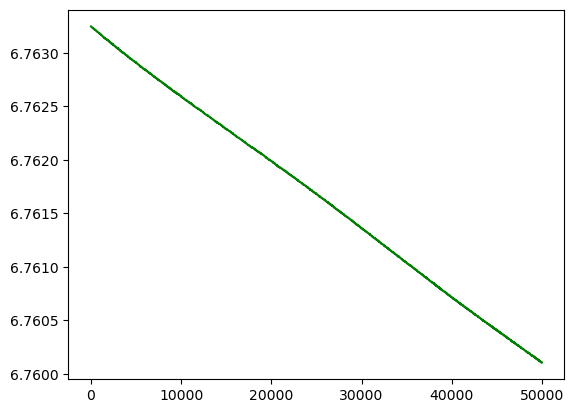

In [13]:
plt.plot(train_loss_arr, 'g')

In [6]:
class Net1(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)  
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [7]:
learning_rate = 0.01
epochs = 500

In [42]:
model = Net1(input_shape=x.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

NameError: name 'x' is not defined

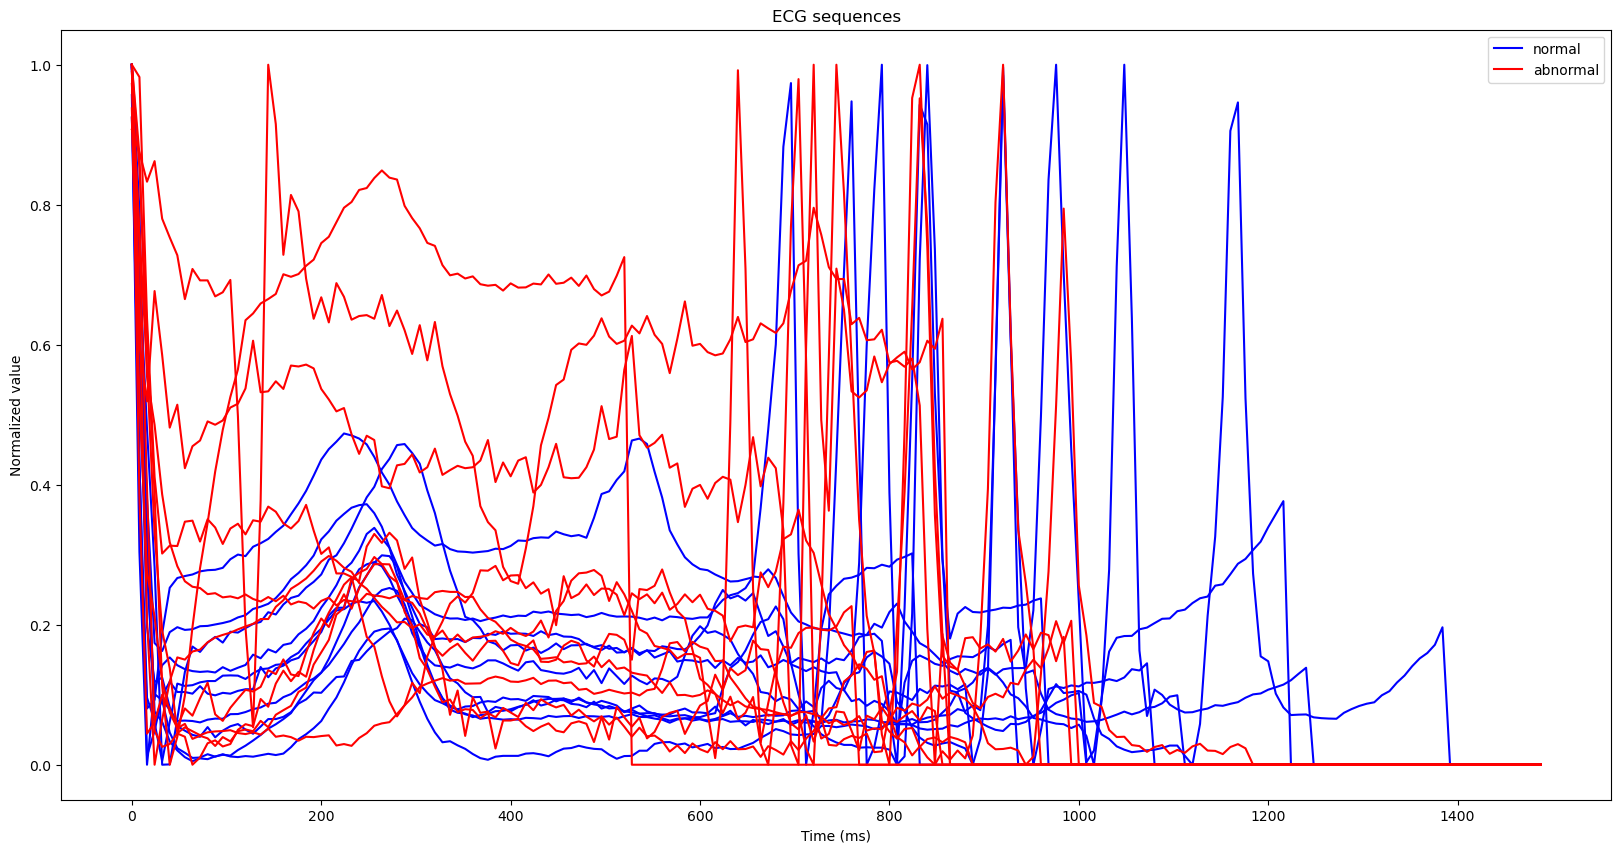

In [5]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:   
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [7]:
df_ptbd_normal

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
291,0.956608,0.304140,0.000000,0.107882,0.142118,0.153264,0.142118,0.136545,0.133758,0.132564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3445,1.000000,0.523354,0.300110,0.059581,0.005149,0.061052,0.115851,0.112541,0.113645,0.117690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2438,1.000000,0.641743,0.273771,0.100971,0.092140,0.045923,0.023550,0.017074,0.009714,0.010303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214,1.000000,0.792068,0.342210,0.075921,0.061190,0.033428,0.020397,0.010765,0.005099,0.009065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1819,1.000000,0.598419,0.196838,0.118182,0.124506,0.081818,0.055336,0.048617,0.042688,0.039921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2216,0.995811,0.706752,0.479547,0.282159,0.000000,0.000493,0.065796,0.132578,0.168802,0.161163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1715,0.925185,0.428665,0.095694,0.063071,0.093301,0.078295,0.062636,0.063071,0.062418,0.060461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3296,1.000000,0.615490,0.379484,0.173863,0.162440,0.189399,0.196482,0.192598,0.193512,0.197852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,1.000000,0.381696,0.080357,0.092634,0.187500,0.252790,0.266741,0.269531,0.271763,0.276228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1461,1.000000,0.434179,0.012688,0.048374,0.098335,0.118557,0.103886,0.103886,0.101507,0.112213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
